In [18]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphlab as gl

%matplotlib inline

# 1. Train-Test Split

In [2]:
def remove_user(utility_matrix):
    '''
    Takes in utility matrix, removes users with only 1-2 rating record
    Returns new utility matrix
    '''
    return utility_matrix[utility_matrix.groupby('user_id')['perfume_id'].transform(len) > 2]

In [3]:
# utility = remove_user(utility)
# utility = utility.set_index('perfume_id')
# utility.to_csv('/Users/kellypeng/Documents/Tech/github/Galvanize/scent_cn_rec/data/utility_matrix.csv', encoding='utf-8')

In [3]:
utility = pd.read_csv('/Users/kellypeng/Documents/Tech/github/Galvanize/scent_cn_rec/data/utility_matrix.csv')

In [5]:
utility.head()

perfume_id  user_rating   user_id
0      976148         10.0    738095
1      976148         10.0  32743685
2      980576          4.0  59952322
3      966498          8.0  13920580
4      511989          4.0  18133983

In [6]:
utility['perfume_id'].nunique()

3036

In [7]:
utility['user_id'].nunique()

2658

In [8]:
utility.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26125 entries, 0 to 26124
Data columns (total 3 columns):
perfume_id     26125 non-null int64
user_rating    26125 non-null float64
user_id        26125 non-null int64
dtypes: float64(1), int64(2)
memory usage: 612.4 KB


In [9]:
# training_df = pd.DataFrame()
# test_df = pd.DataFrame()

# for user_id in utility['user_id']:
#     user_ratings = utility[utility['user_id'] == user_id]
#     if user_ratings.groupby('user_id')['perfume_id'].count().values == 3:
#         sample = user_ratings.sample(n=1, axis=0)
#         test_df.append(sample)
#         training_df.append(user_ratings.drop(sample.index, axis=0))
#     else:
#         sample = user_ratings.sample(frac=0.25, axis=0)
#         test_df.append(sample)
#         training_df.append(user_ratings.drop(sample.index, axis=0))

# 2. Matrix Factorization Model

In [19]:
train = pd.read_csv('/Users/kellypeng/Documents/Tech/github/Galvanize/scent_cn_rec/data/train_valid_test/utility_train.csv')
valid = pd.read_csv('/Users/kellypeng/Documents/Tech/github/Galvanize/scent_cn_rec/data/train_valid_test/utility_valid.csv')
train_and_valid = pd.read_csv('/Users/kellypeng/Documents/Tech/github/Galvanize/scent_cn_rec/data/train_valid_test/utility_valid+train.csv')
test = pd.read_csv('/Users/kellypeng/Documents/Tech/github/Galvanize/scent_cn_rec/data/train_valid_test/utility_test.csv')
# train.drop('Unnamed: 0', axis=1, inplace=True)
# test.drop('Unnamed: 0', axis=1, inplace=True)

In [20]:
# convert to SFrame
train_sf = gl.SFrame(train)
valid_sf = gl.SFrame(valid)
test_sf = gl.SFrame(test)
train_and_valid_sf = gl.SFrame(train_and_valid)

## 1. Find optimum number of factors

In [21]:
def mf_model(data, num_factors):
    '''Fit matrix factorization model'''
    return gl.factorization_recommender.create(data,
#                                             regularization=regularization,
#                                             linear_regularization=linear_regularization,
                                            user_id='user_id',
                                            item_id='perfume_id',
                                            target='user_rating',
                                            num_factors=num_factors, # Number of latent factors.
                                            solver='auto')

In [22]:
def adjust_pred(predicted):
    '''Original predicted ratings out of range,
    adjust predicted rating to 2-10
    '''
    predicted = np.array(predicted)
    adj_pred = []
    for pred in predicted:
        if pred > 10:
            adj_pred.append(10)
        elif pred < 0:
            adj_pred.append(2)
        else:
            adj_pred.append(pred)
    return np.array(adj_pred)

In [23]:
m_t = mf_model(train_sf, num_factors=8, regularization=1e-3)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.070817s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 3.16909                                  |

| 2       | 0.720127          | 3.26997                                  |

| 3       | 0.360064          | 3.39656                                  |

| 4       | 0.180032          | 3.48095                                  |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 3.16909                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 79us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 124.856ms    | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 140.577ms    | 4.40881           | 2.09972               |             |

| 1       | 336.444ms    | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 343.405ms    | 4.40879           | 2.09971               |             |

| 1       | 441.796ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 452.995ms    | 4.40878           | 2.09971               |             |

| 1       | 606.715ms    | DIVERGED          | DIVERGED              | 0.180032    |

| RESET   | 614.141ms    | 4.40881           | 2.09972               |             |

| 1       | 698.144ms    | 7.13847           | 2.1073                | 0.0900159   |

| 2       | 782.765ms    | 4.38128           | 1.76845               | 0.0419074   |

| 3       | 978.725ms    | 3.48091           | 1.48165               | 0.0273111   |

| 4       | 1.15s        | 3.18147           | 1.34798               | 0.0194288   |

| 5       | 1.24s        | 3.04747           | 1.27282               | 0.0155707   |

| 6       | 1.31s        | 2.96893           | 1.22463               | 0.012991    |

| 11      | 1.57s        | 2.81714           | 1.12011               | 0.00710525  |

| 16      | 2.12s        | 2.76343           | 1.0825                | 0.00488983  |

| 26      | 2.73s        | 2.70987           | 1.04935               | 0.00301172  |

| 36      | 3.50s        | 2.68294           | 1.03393               | 0.00217597  |

| 46      | 4.30s        | 2.66613           | 1.02462               | 0.0017033   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.6767

Final training RMSE: 1.02948

In [24]:
m_t.training_rmse

1.013827076407088

In [42]:
m_t.evaluate_rmse(valid_sf, target='user_rating')['rmse_overall']

2.09704161696155

In [324]:
adjust_pred(m_t.predict(valid_sf)).min()

1.2593605444869125

In [325]:
adjust_pred(m_t.predict(valid_sf)).max()

9.8703436778029534

In [326]:
m_t.predict(valid_sf).max()

9.870343677802953

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          7.00000000e+00,   2.60000000e+01,   1.42000000e+02,
          5.60900000e+03,   6.72000000e+02,   2.60000000e+01,
          9.00000000e+00]),
 array([ 1.25936054,  2.12045886,  2.98155717,  3.84265548,  4.7037538 ,
         5.56485211,  6.42595042,  7.28704874,  8.14814705,  9.00924536,
         9.87034368]),
 <a list of 10 Patch objects>)

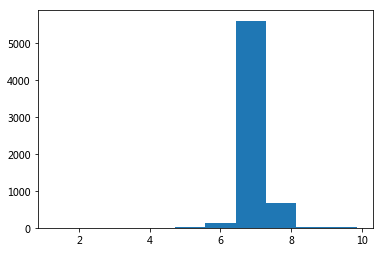

In [327]:
plt.hist(adjust_pred(m_t.predict(valid_sf)));

In [27]:
valid_rmse = []
train_rmse = []

for n in xrange(1, 30):
    m = mf_model(train_sf, num_factors=n)
    valid_rmse.append(np.sqrt(np.mean((np.array(valid_sf['user_rating']) - adjust_pred(m.predict(valid_sf))) ** 2)))
    train_rmse.append(m.training_rmse)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.045892s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 1        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (7.87572 >= 4.419)           |

| 1       | 6.25              | No Decrease (6.62524 >= 4.419)           |

| 2       | 1.5625            | No Decrease (4.57916 >= 4.419)           |

| 3       | 0.390625          | 2.00953                                  |

| 4       | 0.195312          | 1.37813                                  |

| 5       | 0.0976562         | 2.20106                                  |

| 6       | 0.0488281         | 2.48935                                  |

| 7       | 0.0244141         | 2.8685                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 1.37813                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 96us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 86.689ms     | 4.87965           | 2.20898               | 0.195312    |

| 2       | 208.243ms    | 3.65111           | 1.91078               | 0.116134    |

| 3       | 353.868ms    | 2.90913           | 1.70561               | 0.0856819   |

| 4       | 417.657ms    | 2.3493            | 1.53274               | 0.0580668   |

| 5       | 468.371ms    | 2.07651           | 1.441                 | 0.0491185   |

| 6       | 529.732ms    | 1.91666           | 1.38442               | 0.042841    |

| 11      | 895.612ms    | 1.5901            | 1.26098               | 0.0271912   |

| 25      | 2.27s        | 1.36438           | 1.16805               | 0.0146899   |

| 50      | 4.42s        | 1.25229           | 1.11903               | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.17216

Final training RMSE: 1.08264

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.042415s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (13.7244 >= 4.419)           |

| 1       | 6.25              | No Decrease (12.552 >= 4.419)            |

| 2       | 1.5625            | No Decrease (8.00162 >= 4.419)           |

| 3       | 0.390625          | 2.0946                                   |

| 4       | 0.195312          | 0.94954                                  |

| 5       | 0.0976562         | 2.19591                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 0.94954                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 82us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 74.197ms     | 5.08311           | 2.25456               | 0.195312    |

| 2       | 114.589ms    | 3.87745           | 1.96911               | 0.116134    |

| 3       | 146.688ms    | 2.7673            | 1.66351               | 0.0856819   |

| 4       | 212.092ms    | 2.06712           | 1.43773               | 0.0580668   |

| 5       | 340.269ms    | 1.6957            | 1.30217               | 0.0491185   |

| 6       | 516.882ms    | 1.49219           | 1.22153               | 0.042841    |

| 11      | 914.286ms    | 1.08959           | 1.0438                | 0.0271912   |

| 25      | 1.98s        | 0.839526          | 0.916218              | 0.0146899   |

| 50      | 4.49s        | 0.726788          | 0.852472              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.660893

Final training RMSE: 0.812905

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02575s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 3        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (22.5964 >= 4.419)           |

| 1       | 6.25              | No Decrease (21.0671 >= 4.419)           |

| 2       | 1.5625            | No Decrease (13.2919 >= 4.419)           |

| 3       | 0.390625          | 2.56616                                  |

| 4       | 0.195312          | 0.675956                                 |

| 5       | 0.0976562         | 2.19905                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 0.675956                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 94us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 88.851ms     | 5.24238           | 2.28961               | 0.195312    |

| 2       | 153.907ms    | 4.0908            | 2.02256               | 0.116134    |

| 3       | 204.596ms    | 2.82716           | 1.6814                | 0.0856819   |

| 4       | 274.748ms    | 1.98437           | 1.40866               | 0.0580668   |

| 5       | 348.047ms    | 1.46445           | 1.21012               | 0.0491185   |

| 6       | 410.085ms    | 1.21664           | 1.10299               | 0.042841    |

| 11      | 734.143ms    | 0.770373          | 0.877667              | 0.0271912   |

| 25      | 1.49s        | 0.520386          | 0.721319              | 0.0146899   |

| 50      | 3.93s        | 0.41468           | 0.643884              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.366786

Final training RMSE: 0.605551

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.04194s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (39.9018 >= 4.419)           |

| 1       | 6.25              | No Decrease (37.0325 >= 4.419)           |

| 2       | 1.5625            | No Decrease (23.6389 >= 4.419)           |

| 3       | 0.390625          | 3.48542                                  |

| 4       | 0.195312          | 0.527256                                 |

| 5       | 0.0976562         | 2.19458                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 0.527256                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 128us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 27.601ms     | 5.43903           | 2.33215               | 0.195312    |

| 2       | 75.883ms     | 4.54894           | 2.13281               | 0.116134    |

| 3       | 139.681ms    | 2.94874           | 1.71717               | 0.0856819   |

| 4       | 171.257ms    | 1.91484           | 1.38375               | 0.0580668   |

| 5       | 258.27ms     | 1.29564           | 1.13823               | 0.0491185   |

| 6       | 333.088ms    | 0.994375          | 0.997146              | 0.042841    |

| 11      | 651.516ms    | 0.529067          | 0.727312              | 0.0271912   |

| 25      | 1.33s        | 0.304509          | 0.551737              | 0.0146899   |

| 50      | 3.16s        | 0.222247          | 0.471321              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.192163

Final training RMSE: 0.438247

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02792s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 5        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | No Decrease (39.1868 >= 4.419)           |

| 3       | 0.390625          | No Decrease (5.09269 >= 4.419)           |

| 4       | 0.0976562         | 2.1957                                   |

| 5       | 0.0488281         | 2.48767                                  |

| 6       | 0.0244141         | 2.86786                                  |

| 7       | 0.012207          | 3.27016                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.1957                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 91us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 69.466ms     | 4.30225           | 2.07418               | 0.0976562   |

| 2       | 150.268ms    | 3.16518           | 1.77909               | 0.0580668   |

| 3       | 310.497ms    | 2.86              | 1.69115               | 0.042841    |

| 4       | 406.188ms    | 2.699             | 1.64286               | 0.0345267   |

| 5       | 494.05ms     | 2.59628           | 1.6113                | 0.029206    |

| 6       | 531.287ms    | 2.46864           | 1.57119               | 0.0254734   |

| 10      | 956.867ms    | 1.66549           | 1.29054               | 0.017366    |

| 11      | 1.00s        | 1.47863           | 1.21598               | 0.016168    |

| 20      | 1.66s        | 0.646856          | 0.804252              | 0.0103259   |

| 30      | 2.35s        | 0.376743          | 0.613756              | 0.00761832  |

| 40      | 3.05s        | 0.269247          | 0.518839              | 0.00613981  |

| 50      | 3.69s        | 0.215073          | 0.463698              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.19586

Final training RMSE: 0.442497

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.028063s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | No Decrease (9.34544 >= 4.419)           |

| 4       | 0.0976562         | 2.19154                                  |

| 5       | 0.0488281         | 2.48841                                  |

| 6       | 0.0244141         | 2.86774                                  |

| 7       | 0.012207          | 3.27052                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19154                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 306us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 151.852ms    | 4.28932           | 2.07106               | 0.0976562   |

| 2       | 258.923ms    | 3.1879            | 1.78547               | 0.0580668   |

| 3       | 338.951ms    | 2.85349           | 1.68923               | 0.042841    |

| 4       | 412.718ms    | 2.69789           | 1.64252               | 0.0345267   |

| 5       | 511.607ms    | 2.58796           | 1.60871               | 0.029206    |

| 6       | 590.184ms    | 2.45173           | 1.5658                | 0.0254734   |

| 11      | 880.495ms    | 1.40572           | 1.18562               | 0.016168    |

| 25      | 1.92s        | 0.374574          | 0.611989              | 0.00873464  |

| 50      | 3.82s        | 0.141751          | 0.376421              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.128522

Final training RMSE: 0.358417

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023416s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 7        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | No Decrease (20.2891 >= 4.419)           |

| 4       | 0.0976562         | 2.19218                                  |

| 5       | 0.0488281         | 2.48907                                  |

| 6       | 0.0244141         | 2.86811                                  |

| 7       | 0.012207          | 3.27046                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19218                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 68us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 88.477ms     | 4.28435           | 2.06986               | 0.0976562   |

| 2       | 140.393ms    | 3.15308           | 1.77569               | 0.0580668   |

| 3       | 399.343ms    | 2.86199           | 1.69174               | 0.042841    |

| 4       | 552.016ms    | 2.69369           | 1.64125               | 0.0345267   |

| 5       | 629.607ms    | 2.59038           | 1.60946               | 0.029206    |

| 6       | 653.793ms    | 2.45132           | 1.56567               | 0.0254734   |

| 10      | 1.08s        | 1.58636           | 1.2595                | 0.017366    |

| 11      | 1.16s        | 1.37986           | 1.17467               | 0.016168    |

| 20      | 1.90s        | 0.489534          | 0.69964               | 0.0103259   |

| 30      | 2.57s        | 0.241042          | 0.49091               | 0.00761832  |

| 40      | 3.26s        | 0.149896          | 0.387093              | 0.00613981  |

| 50      | 3.93s        | 0.106721          | 0.326591              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0965378

Final training RMSE: 0.31061

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.035264s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | No Decrease (37.7598 >= 4.419)           |

| 4       | 0.0976562         | 2.19551                                  |

| 5       | 0.0488281         | 2.48842                                  |

| 6       | 0.0244141         | 2.86797                                  |

| 7       | 0.012207          | 3.27071                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19551                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 75us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 81.618ms     | 4.2893            | 2.07106               | 0.0976562   |

| 2       | 153.773ms    | 3.14972           | 1.77474               | 0.0580668   |

| 3       | 241.114ms    | 2.86144           | 1.69158               | 0.042841    |

| 4       | 314.311ms    | 2.69477           | 1.64157               | 0.0345267   |

| 5       | 379.945ms    | 2.56876           | 1.60273               | 0.029206    |

| 6       | 446.28ms     | 2.40988           | 1.55238               | 0.0254734   |

| 11      | 871.015ms    | 1.28949           | 1.13555               | 0.016168    |

| 25      | 1.54s        | 0.274902          | 0.524267              | 0.00873464  |

| 50      | 3.00s        | 0.0779681         | 0.279121              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0708008

Final training RMSE: 0.265972

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.038561s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 9        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.18432                                  |

| 5       | 0.0488281         | 2.48905                                  |

| 6       | 0.0244141         | 2.86905                                  |

| 7       | 0.012207          | 3.2706                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.18432                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 84us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 85.531ms     | 4.28393           | 2.06976               | 0.0976562   |

| 2       | 164.328ms    | 3.18423           | 1.78444               | 0.0580668   |

| 3       | 248.904ms    | 2.86226           | 1.69182               | 0.042841    |

| 4       | 317.405ms    | 2.68875           | 1.63974               | 0.0345267   |

| 5       | 387.167ms    | 2.5924            | 1.61009               | 0.029206    |

| 6       | 490.26ms     | 2.46165           | 1.56896               | 0.0254734   |

| 11      | 770.961ms    | 1.31347           | 1.14606               | 0.016168    |

| 25      | 1.61s        | 0.256345          | 0.506259              | 0.00873464  |

| 50      | 3.06s        | 0.0646939         | 0.254233              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0587825

Final training RMSE: 0.242328

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.032964s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19776                                  |

| 5       | 0.0488281         | 2.48799                                  |

| 6       | 0.0244141         | 2.8688                                   |

| 7       | 0.012207          | 3.27087                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19776                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 72us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 101.738ms    | 4.29109           | 2.07149               | 0.0976562   |

| 2       | 162.887ms    | 3.19704           | 1.78802               | 0.0580668   |

| 3       | 235.611ms    | 2.84623           | 1.68708               | 0.042841    |

| 4       | 311.515ms    | 2.70008           | 1.64319               | 0.0345267   |

| 5       | 359.12ms     | 2.57756           | 1.60548               | 0.029206    |

| 6       | 419.323ms    | 2.4357            | 1.56067               | 0.0254734   |

| 11      | 712.753ms    | 1.26829           | 1.12618               | 0.016168    |

| 25      | 1.47s        | 0.234272          | 0.483968              | 0.00873464  |

| 50      | 2.77s        | 0.0526047         | 0.229227              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0478568

Final training RMSE: 0.218625

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.034099s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 11       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19337                                  |

| 5       | 0.0488281         | 2.48796                                  |

| 6       | 0.0244141         | 2.86905                                  |

| 7       | 0.012207          | 3.27053                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19337                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 75us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 138.19ms     | 4.30124           | 2.07394               | 0.0976562   |

| 2       | 209.883ms    | 3.18924           | 1.78584               | 0.0580668   |

| 3       | 267.18ms     | 2.85654           | 1.69013               | 0.042841    |

| 4       | 336.326ms    | 2.7012            | 1.64353               | 0.0345267   |

| 5       | 392.586ms    | 2.58408           | 1.60751               | 0.029206    |

| 6       | 471.441ms    | 2.46146           | 1.5689                | 0.0254734   |

| 11      | 1.39s        | 1.32915           | 1.15288               | 0.016168    |

| 25      | 4.18s        | 0.232702          | 0.482344              | 0.00873464  |

| 50      | 6.24s        | 0.0487476         | 0.220654              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0444763

Final training RMSE: 0.210753

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.029384s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.1949                                   |

| 5       | 0.0488281         | 2.48964                                  |

| 6       | 0.0244141         | 2.86864                                  |

| 7       | 0.012207          | 3.27047                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.1949                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 103us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 76.049ms     | 4.27586           | 2.06781               | 0.0976562   |

| 2       | 181.955ms    | 3.17258           | 1.78117               | 0.0580668   |

| 3       | 252.154ms    | 2.85512           | 1.68971               | 0.042841    |

| 4       | 357.064ms    | 2.69283           | 1.64098               | 0.0345267   |

| 5       | 495.815ms    | 2.5796            | 1.60611               | 0.029206    |

| 6       | 561.422ms    | 2.42444           | 1.55706               | 0.0254734   |

| 10      | 800.967ms    | 1.5052            | 1.22686               | 0.017366    |

| 11      | 873.085ms    | 1.28893           | 1.1353                | 0.016168    |

| 20      | 1.44s        | 0.372174          | 0.610028              | 0.0103259   |

| 30      | 2.13s        | 0.143221          | 0.378377              | 0.00761832  |

| 40      | 2.79s        | 0.0733977         | 0.270815              | 0.00613981  |

| 50      | 3.50s        | 0.0443763         | 0.210515              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0405654

Final training RMSE: 0.201261

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.031143s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 13       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19526                                  |

| 5       | 0.0488281         | 2.48809                                  |

| 6       | 0.0244141         | 2.86858                                  |

| 7       | 0.012207          | 3.27065                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19526                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 71us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 131.058ms    | 4.29609           | 2.0727                | 0.0976562   |

| 2       | 217.429ms    | 3.1826            | 1.78398               | 0.0580668   |

| 3       | 318.251ms    | 2.85014           | 1.68823               | 0.042841    |

| 4       | 357.474ms    | 2.69825           | 1.64264               | 0.0345267   |

| 5       | 438.153ms    | 2.6008            | 1.6127                | 0.029206    |

| 6       | 444.22ms     | 2.50516           | 1.58277               | 0.0254734   |

| 11      | 748.471ms    | 1.35221           | 1.16284               | 0.016168    |

| 25      | 1.86s        | 0.225878          | 0.475218              | 0.00873464  |

| 50      | 3.70s        | 0.0430073         | 0.207241              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0394077

Final training RMSE: 0.198366

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.034125s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19491                                  |

| 5       | 0.0488281         | 2.4885                                   |

| 6       | 0.0244141         | 2.86839                                  |

| 7       | 0.012207          | 3.2709                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19491                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 104us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 106.501ms    | 4.27926           | 2.06863               | 0.0976562   |

| 2       | 186.667ms    | 3.1804            | 1.78337               | 0.0580668   |

| 3       | 270.366ms    | 2.86111           | 1.69148               | 0.042841    |

| 4       | 357.521ms    | 2.70088           | 1.64344               | 0.0345267   |

| 5       | 454.554ms    | 2.59582           | 1.61115               | 0.029206    |

| 6       | 552.722ms    | 2.47969           | 1.5747                | 0.0254734   |

| 11      | 1.03s        | 1.34453           | 1.15953               | 0.016168    |

| 25      | 1.95s        | 0.225816          | 0.475152              | 0.00873464  |

| 50      | 3.45s        | 0.0425782         | 0.206202              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0390014

Final training RMSE: 0.197338

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.043051s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 15       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19694                                  |

| 5       | 0.0488281         | 2.48786                                  |

| 6       | 0.0244141         | 2.86846                                  |

| 7       | 0.012207          | 3.27077                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19694                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 73us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 35.542ms     | 4.28766           | 2.07066               | 0.0976562   |

| 2       | 112.138ms    | 3.18093           | 1.78351               | 0.0580668   |

| 3       | 189.371ms    | 2.85515           | 1.68972               | 0.042841    |

| 4       | 258.842ms    | 2.6902            | 1.64018               | 0.0345267   |

| 5       | 331.661ms    | 2.56482           | 1.60151               | 0.029206    |

| 6       | 390.136ms    | 2.40698           | 1.55144               | 0.0254734   |

| 11      | 822.46ms     | 1.33395           | 1.15496               | 0.016168    |

| 25      | 1.77s        | 0.229465          | 0.478976              | 0.00873464  |

| 50      | 3.40s        | 0.0430687         | 0.207386              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0394774

Final training RMSE: 0.198539

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.032205s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19963                                  |

| 5       | 0.0488281         | 2.48815                                  |

| 6       | 0.0244141         | 2.86823                                  |

| 7       | 0.012207          | 3.27087                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19963                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 78us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 191.531ms    | 4.27546           | 2.06771               | 0.0976562   |

| 2       | 279.641ms    | 3.18449           | 1.78451               | 0.0580668   |

| 3       | 407.54ms     | 2.86278           | 1.69197               | 0.042841    |

| 4       | 489.326ms    | 2.69361           | 1.64122               | 0.0345267   |

| 5       | 577.381ms    | 2.59063           | 1.60954               | 0.029206    |

| 6       | 669.213ms    | 2.46095           | 1.56874               | 0.0254734   |

| 11      | 943.178ms    | 1.38253           | 1.1758                | 0.016168    |

| 25      | 1.86s        | 0.22393           | 0.473163              | 0.00873464  |

| 50      | 3.50s        | 0.0409102         | 0.202117              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0375881

Final training RMSE: 0.193724

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02549s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 17       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19681                                  |

| 5       | 0.0488281         | 2.48854                                  |

| 6       | 0.0244141         | 2.86815                                  |

| 7       | 0.012207          | 3.27058                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19681                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 73us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 106.425ms    | 4.28702           | 2.07051               | 0.0976562   |

| 2       | 218.552ms    | 3.1792            | 1.78303               | 0.0580668   |

| 3       | 326.71ms     | 2.85531           | 1.68977               | 0.042841    |

| 4       | 433.45ms     | 2.69918           | 1.64292               | 0.0345267   |

| 5       | 503.846ms    | 2.58223           | 1.60693               | 0.029206    |

| 6       | 588.458ms    | 2.43848           | 1.56156               | 0.0254734   |

| 11      | 922.672ms    | 1.36209           | 1.16708               | 0.016168    |

| 25      | 1.72s        | 0.226166          | 0.47552               | 0.00873464  |

| 50      | 3.35s        | 0.0393129         | 0.198126              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0361435

Final training RMSE: 0.189959

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.028331s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19871                                  |

| 5       | 0.0488281         | 2.48825                                  |

| 6       | 0.0244141         | 2.86863                                  |

| 7       | 0.012207          | 3.27105                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19871                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 76us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 111.455ms    | 4.29146           | 2.07158               | 0.0976562   |

| 2       | 310.864ms    | 3.17696           | 1.7824                | 0.0580668   |

| 3       | 446.069ms    | 2.85564           | 1.68986               | 0.042841    |

| 4       | 547.982ms    | 2.69964           | 1.64306               | 0.0345267   |

| 5       | 689.677ms    | 2.58955           | 1.60921               | 0.029206    |

| 6       | 787.005ms    | 2.46343           | 1.56953               | 0.0254734   |

| 10      | 1.02s        | 1.59845           | 1.26429               | 0.017366    |

| 11      | 1.11s        | 1.37625           | 1.17313               | 0.016168    |

| 20      | 1.88s        | 0.382698          | 0.618594              | 0.0103259   |

| 30      | 2.77s        | 0.138736          | 0.372405              | 0.00761832  |

| 40      | 3.45s        | 0.0662557         | 0.257293              | 0.00613981  |

| 50      | 4.32s        | 0.0378127         | 0.194303              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0347643

Final training RMSE: 0.186294

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025534s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 19       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19736                                  |

| 5       | 0.0488281         | 2.48802                                  |

| 6       | 0.0244141         | 2.86791                                  |

| 7       | 0.012207          | 3.27054                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19736                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 91us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 72.849ms     | 4.28996           | 2.07122               | 0.0976562   |

| 2       | 166.83ms     | 3.17172           | 1.78093               | 0.0580668   |

| 3       | 228.317ms    | 2.85913           | 1.69089               | 0.042841    |

| 4       | 323.287ms    | 2.69905           | 1.64288               | 0.0345267   |

| 5       | 404.788ms    | 2.5915            | 1.60981               | 0.029206    |

| 6       | 479.923ms    | 2.47008           | 1.57165               | 0.0254734   |

| 11      | 902.68ms     | 1.43574           | 1.19822               | 0.016168    |

| 25      | 2.01s        | 0.22659           | 0.475967              | 0.00873464  |

| 50      | 4.10s        | 0.038084          | 0.195001              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0350358

Final training RMSE: 0.187022

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.030469s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 20       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19719                                  |

| 5       | 0.0488281         | 2.48859                                  |

| 6       | 0.0244141         | 2.86815                                  |

| 7       | 0.012207          | 3.27108                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19719                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 147us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 367.562ms    | 4.31923           | 2.07827               | 0.0976562   |

| 2       | 504.253ms    | 3.16555           | 1.7792                | 0.0580668   |

| 3       | 594.242ms    | 2.84992           | 1.68817               | 0.042841    |

| 4       | 734.54ms     | 2.70152           | 1.64363               | 0.0345267   |

| 5       | 865.768ms    | 2.58446           | 1.60762               | 0.029206    |

| 6       | 960.75ms     | 2.45274           | 1.56612               | 0.0254734   |

| 10      | 1.29s        | 1.59718           | 1.26379               | 0.017366    |

| 11      | 1.38s        | 1.36608           | 1.16879               | 0.016168    |

| 20      | 2.20s        | 0.377434          | 0.614324              | 0.0103259   |

| 30      | 2.82s        | 0.136479          | 0.369362              | 0.00761832  |

| 40      | 3.67s        | 0.0653231         | 0.255474              | 0.00613981  |

| 50      | 4.51s        | 0.0375901         | 0.19373               | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0345983

Final training RMSE: 0.185848

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026718s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 21       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19757                                  |

| 5       | 0.0488281         | 2.48782                                  |

| 6       | 0.0244141         | 2.86816                                  |

| 7       | 0.012207          | 3.27106                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19757                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 126us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 121.752ms    | 4.30349           | 2.07448               | 0.0976562   |

| 2       | 235.423ms    | 3.17215           | 1.78105               | 0.0580668   |

| 3       | 446.994ms    | 2.85268           | 1.68899               | 0.042841    |

| 4       | 735.862ms    | 2.70095           | 1.64346               | 0.0345267   |

| 5       | 889.731ms    | 2.59436           | 1.6107                | 0.029206    |

| 6       | 1.06s        | 2.47341           | 1.57271               | 0.0254734   |

| 10      | 1.46s        | 1.58428           | 1.25868               | 0.017366    |

| 11      | 1.64s        | 1.34848           | 1.16123               | 0.016168    |

| 20      | 2.64s        | 0.3702            | 0.608408              | 0.0103259   |

| 30      | 3.40s        | 0.131592          | 0.362686              | 0.00761832  |

| 40      | 4.12s        | 0.0632914         | 0.251466              | 0.00613981  |

| 50      | 4.92s        | 0.036631          | 0.191239              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0337279

Final training RMSE: 0.183492

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.030573s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 22       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19803                                  |

| 5       | 0.0488281         | 2.489                                    |

| 6       | 0.0244141         | 2.86841                                  |

| 7       | 0.012207          | 3.27095                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19803                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 97us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 131.139ms    | 4.31988           | 2.07843               | 0.0976562   |

| 2       | 309.729ms    | 3.16864           | 1.78007               | 0.0580668   |

| 3       | 400.74ms     | 2.85238           | 1.6889                | 0.042841    |

| 4       | 576.472ms    | 2.69888           | 1.64283               | 0.0345267   |

| 5       | 668.214ms    | 2.59936           | 1.61225               | 0.029206    |

| 6       | 786.843ms    | 2.49253           | 1.57878               | 0.0254734   |

| 10      | 1.28s        | 1.64034           | 1.28075               | 0.017366    |

| 11      | 1.41s        | 1.40148           | 1.18384               | 0.016168    |

| 20      | 2.29s        | 0.387493          | 0.622458              | 0.0103259   |

| 30      | 3.38s        | 0.138572          | 0.372184              | 0.00761832  |

| 40      | 4.22s        | 0.0651833         | 0.255201              | 0.00613981  |

| 50      | 5.15s        | 0.0368994         | 0.19194               | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0339952

Final training RMSE: 0.184219

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025108s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 23       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19797                                  |

| 5       | 0.0488281         | 2.48859                                  |

| 6       | 0.0244141         | 2.86891                                  |

| 7       | 0.012207          | 3.27116                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19797                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 106us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 65.065ms     | 4.29653           | 2.0728                | 0.0976562   |

| 2       | 279.057ms    | 3.16936           | 1.78027               | 0.0580668   |

| 3       | 465.365ms    | 2.85493           | 1.68965               | 0.042841    |

| 4       | 524.467ms    | 2.70083           | 1.64342               | 0.0345267   |

| 5       | 648.328ms    | 2.58229           | 1.60695               | 0.029206    |

| 6       | 702.136ms    | 2.44178           | 1.56262               | 0.0254734   |

| 10      | 999.916ms    | 1.61386           | 1.27037               | 0.017366    |

| 11      | 1.11s        | 1.38846           | 1.17832               | 0.016168    |

| 20      | 1.85s        | 0.388221          | 0.623042              | 0.0103259   |

| 30      | 2.80s        | 0.138993          | 0.37275               | 0.00761832  |

| 40      | 3.62s        | 0.0665193         | 0.257804              | 0.00613981  |

| 50      | 4.43s        | 0.0382205         | 0.195349              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0351873

Final training RMSE: 0.187425

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026878s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 24       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19943                                  |

| 5       | 0.0488281         | 2.48898                                  |

| 6       | 0.0244141         | 2.86827                                  |

| 7       | 0.012207          | 3.27097                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19943                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 77us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 20.662ms     | 4.30316           | 2.0744                | 0.0976562   |

| 2       | 76.31ms      | 3.17111           | 1.78076               | 0.0580668   |

| 3       | 226.567ms    | 2.85567           | 1.68987               | 0.042841    |

| 4       | 288.247ms    | 2.70013           | 1.64321               | 0.0345267   |

| 5       | 373.147ms    | 2.59342           | 1.61041               | 0.029206    |

| 6       | 492.325ms    | 2.47439           | 1.57302               | 0.0254734   |

| 11      | 834.719ms    | 1.41216           | 1.18834               | 0.016168    |

| 25      | 2.02s        | 0.219247          | 0.468189              | 0.00873464  |

| 50      | 3.86s        | 0.0368705         | 0.191865              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0339696

Final training RMSE: 0.18415

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.053558s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 25       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19848                                  |

| 5       | 0.0488281         | 2.48896                                  |

| 6       | 0.0244141         | 2.8682                                   |

| 7       | 0.012207          | 3.27052                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19848                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 73us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 68.607ms     | 4.31508           | 2.07727               | 0.0976562   |

| 2       | 183.516ms    | 3.16              | 1.77764               | 0.0580668   |

| 3       | 265.72ms     | 2.84989           | 1.68816               | 0.042841    |

| 4       | 363.636ms    | 2.69919           | 1.64292               | 0.0345267   |

| 5       | 493.721ms    | 2.59061           | 1.60954               | 0.029206    |

| 6       | 566.948ms    | 2.47057           | 1.57181               | 0.0254734   |

| 10      | 946.917ms    | 1.65087           | 1.28486               | 0.017366    |

| 11      | 1.00s        | 1.42272           | 1.19277               | 0.016168    |

| 20      | 1.63s        | 0.389482          | 0.624054              | 0.0103259   |

| 30      | 2.43s        | 0.137889          | 0.371266              | 0.00761832  |

| 40      | 3.32s        | 0.0648192         | 0.254487              | 0.00613981  |

| 50      | 4.10s        | 0.0368202         | 0.191733              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0339348

Final training RMSE: 0.184055

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.035519s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 26       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19742                                  |

| 5       | 0.0488281         | 2.48931                                  |

| 6       | 0.0244141         | 2.86823                                  |

| 7       | 0.012207          | 3.27099                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19742                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 445us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 86.529ms     | 4.29118           | 2.07151               | 0.0976562   |

| 2       | 172.957ms    | 3.16765           | 1.77979               | 0.0580668   |

| 3       | 268.383ms    | 2.85407           | 1.6894                | 0.042841    |

| 4       | 355.078ms    | 2.70115           | 1.64352               | 0.0345267   |

| 5       | 479.136ms    | 2.59869           | 1.61205               | 0.029206    |

| 6       | 536.227ms    | 2.48662           | 1.5769                | 0.0254734   |

| 11      | 946.48ms     | 1.40869           | 1.18688               | 0.016168    |

| 25      | 2.04s        | 0.21402           | 0.462573              | 0.00873464  |

| 50      | 4.03s        | 0.035363          | 0.187895              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0325952

Final training RMSE: 0.18038

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025888s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 27       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.2016                                   |

| 5       | 0.0488281         | 2.48815                                  |

| 6       | 0.0244141         | 2.86823                                  |

| 7       | 0.012207          | 3.27091                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.2016                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 95us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 89.329ms     | 4.30513           | 2.07487               | 0.0976562   |

| 2       | 156.872ms    | 3.17539           | 1.78196               | 0.0580668   |

| 3       | 254.827ms    | 2.85131           | 1.68858               | 0.042841    |

| 4       | 332.806ms    | 2.70202           | 1.64378               | 0.0345267   |

| 5       | 449.732ms    | 2.58738           | 1.60853               | 0.029206    |

| 6       | 558.666ms    | 2.46135           | 1.56887               | 0.0254734   |

| 11      | 973.005ms    | 1.40671           | 1.18604               | 0.016168    |

| 25      | 1.82s        | 0.212806          | 0.461259              | 0.00873464  |

| 50      | 4.30s        | 0.0351888         | 0.187431              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0324722

Final training RMSE: 0.180038

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024153s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 28       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19659                                  |

| 5       | 0.0488281         | 2.48838                                  |

| 6       | 0.0244141         | 2.86857                                  |

| 7       | 0.012207          | 3.27111                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19659                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 82us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 81.98ms      | 4.28256           | 2.06943               | 0.0976562   |

| 2       | 165.828ms    | 3.17674           | 1.78234               | 0.0580668   |

| 3       | 250.458ms    | 2.8517            | 1.6887                | 0.042841    |

| 4       | 300.114ms    | 2.70179           | 1.64371               | 0.0345267   |

| 5       | 404.535ms    | 2.59636           | 1.61132               | 0.029206    |

| 6       | 502.495ms    | 2.48448           | 1.57622               | 0.0254734   |

| 11      | 937.032ms    | 1.41884           | 1.19115               | 0.016168    |

| 25      | 2.55s        | 0.224791          | 0.474074              | 0.00873464  |

| 50      | 4.82s        | 0.0364991         | 0.190894              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0336435

Final training RMSE: 0.183262

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.032271s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 29       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19914                                  |

| 5       | 0.0488281         | 2.48828                                  |

| 6       | 0.0244141         | 2.86824                                  |

| 7       | 0.012207          | 3.27093                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19914                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 65us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 48.185ms     | 4.30127           | 2.07395               | 0.0976562   |

| 2       | 127.537ms    | 3.16903           | 1.78017               | 0.0580668   |

| 3       | 233.624ms    | 2.85104           | 1.6885                | 0.042841    |

| 4       | 296.59ms     | 2.70089           | 1.64344               | 0.0345267   |

| 5       | 387.417ms    | 2.58882           | 1.60898               | 0.029206    |

| 6       | 469.328ms    | 2.46662           | 1.57055               | 0.0254734   |

| 11      | 874.89ms     | 1.43989           | 1.19995               | 0.016168    |

| 25      | 1.79s        | 0.223498          | 0.472708              | 0.00873464  |

| 50      | 3.99s        | 0.0369748         | 0.192137              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.034095

Final training RMSE: 0.184491

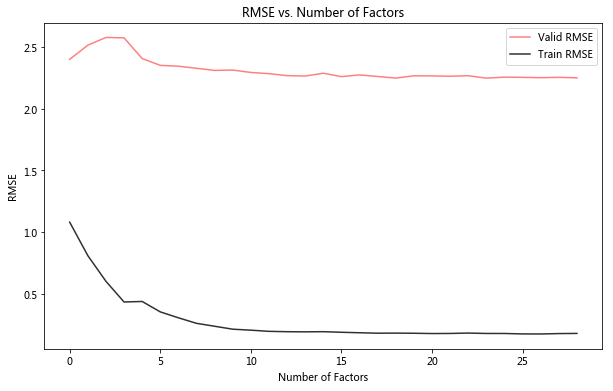

In [28]:
fig = plt.figure(figsize=(10,6))
plt.plot(valid_rmse, color='r', alpha=.5, label='Valid RMSE')
plt.plot(train_rmse, color='#303030', label='Train RMSE')
plt.xlabel('Number of Factors')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE vs. Number of Factors');
# plt.savefig('tune_n_factors.png', bbox_inches='tight')

In [51]:
valid_rmse_r = {}
train_rmse_r = {}

for reg in [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]:
    m1 = mf_model(train_sf, num_factors=14, regularization=reg)
    valid_rmse_r[reg] = np.sqrt(np.mean((np.array(valid_sf['user_rating']) - adjust_pred(m1.predict(valid_sf))) ** 2))
    train_rmse_r[reg] = m1.training_rmse

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.210194s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-12    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19808                                  |

| 5       | 0.0488281         | 2.48754                                  |

| 6       | 0.0244141         | 2.86882                                  |

| 7       | 0.012207          | 3.27074                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19808                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 90us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 93.462ms     | 4.30328           | 2.07443               | 0.0976562   |

| 2       | 214.512ms    | 3.1751            | 1.78188               | 0.0580668   |

| 3       | 245.708ms    | 2.8514            | 1.68861               | 0.042841    |

| 4       | 348.515ms    | 2.69955           | 1.64303               | 0.0345267   |

| 5       | 427.685ms    | 2.58384           | 1.60743               | 0.029206    |

| 6       | 518.887ms    | 2.46834           | 1.5711                | 0.0254734   |

| 11      | 868.489ms    | 1.30993           | 1.14452               | 0.016168    |

| 25      | 1.55s        | 0.24178           | 0.491711              | 0.00873464  |

| 50      | 3.06s        | 0.0548673         | 0.234236              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0499366

Final training RMSE: 0.223463

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.074932s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-11    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19045                                  |

| 5       | 0.0488281         | 2.48868                                  |

| 6       | 0.0244141         | 2.86881                                  |

| 7       | 0.012207          | 3.27074                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19045                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 70us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 16.117ms     | 4.29374           | 2.07213               | 0.0976562   |

| 2       | 79.17ms      | 3.18154           | 1.78369               | 0.0580668   |

| 3       | 171.218ms    | 2.8546            | 1.68955               | 0.042841    |

| 4       | 232.441ms    | 2.69862           | 1.64275               | 0.0345267   |

| 5       | 320.37ms     | 2.57066           | 1.60333               | 0.029206    |

| 6       | 395.936ms    | 2.42744           | 1.55802               | 0.0254734   |

| 11      | 750.268ms    | 1.27686           | 1.12998               | 0.016168    |

| 25      | 1.67s        | 0.237998          | 0.48785               | 0.00873464  |

| 50      | 3.18s        | 0.052112          | 0.228279              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0473812

Final training RMSE: 0.217671

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.058346s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.18802                                  |

| 5       | 0.0488281         | 2.48872                                  |

| 6       | 0.0244141         | 2.86878                                  |

| 7       | 0.012207          | 3.27073                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.18802                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 66us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 88.047ms     | 4.29835           | 2.07324               | 0.0976562   |

| 2       | 175.417ms    | 3.18074           | 1.78346               | 0.0580668   |

| 3       | 254.996ms    | 2.85101           | 1.68849               | 0.042841    |

| 4       | 319.213ms    | 2.69996           | 1.64316               | 0.0345267   |

| 5       | 400.525ms    | 2.58074           | 1.60647               | 0.029206    |

| 6       | 482.716ms    | 2.45732           | 1.56758               | 0.0254734   |

| 11      | 798.742ms    | 1.35027           | 1.16201               | 0.016168    |

| 25      | 1.52s        | 0.256044          | 0.506007              | 0.00873464  |

| 50      | 2.81s        | 0.0567327         | 0.238184              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0515818

Final training RMSE: 0.227114

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.044017s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-09    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19609                                  |

| 5       | 0.0488281         | 2.48776                                  |

| 6       | 0.0244141         | 2.86904                                  |

| 7       | 0.012207          | 3.2707                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19609                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 85us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 31.188ms     | 4.30705           | 2.07534               | 0.0976562   |

| 2       | 102.556ms    | 3.18164           | 1.78371               | 0.0580668   |

| 3       | 135.387ms    | 2.85243           | 1.68891               | 0.042841    |

| 4       | 242.795ms    | 2.6984            | 1.64268               | 0.0345267   |

| 5       | 321.433ms    | 2.5833            | 1.60726               | 0.029206    |

| 6       | 409.205ms    | 2.46541           | 1.57016               | 0.0254734   |

| 11      | 762.431ms    | 1.32235           | 1.14993               | 0.016168    |

| 25      | 1.79s        | 0.256568          | 0.506521              | 0.00873464  |

| 50      | 3.17s        | 0.0575241         | 0.239828              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0522884

Final training RMSE: 0.228652

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.05019s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.1971                                   |

| 5       | 0.0488281         | 2.48922                                  |

| 6       | 0.0244141         | 2.86914                                  |

| 7       | 0.012207          | 3.2705                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.1971                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 72us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 56.86ms      | 4.30564           | 2.075                 | 0.0976562   |

| 2       | 181.79ms     | 3.18096           | 1.78352               | 0.0580668   |

| 3       | 223.748ms    | 2.85311           | 1.68911               | 0.042841    |

| 4       | 321.564ms    | 2.69592           | 1.64193               | 0.0345267   |

| 5       | 378.59ms     | 2.55988           | 1.59996               | 0.029206    |

| 6       | 485.433ms    | 2.40702           | 1.55146               | 0.0254734   |

| 11      | 795.983ms    | 1.29012           | 1.13582               | 0.016168    |

| 25      | 1.61s        | 0.256174          | 0.50609               | 0.00873464  |

| 50      | 3.00s        | 0.0586254         | 0.242003              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0533174

Final training RMSE: 0.230776

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.060311s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-07    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.18755                                  |

| 5       | 0.0488281         | 2.48797                                  |

| 6       | 0.0244141         | 2.86905                                  |

| 7       | 0.012207          | 3.27038                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.18755                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 86us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 98.117ms     | 4.29389           | 2.07217               | 0.0976562   |

| 2       | 149.865ms    | 3.19              | 1.78606               | 0.0580668   |

| 3       | 246.773ms    | 2.8533            | 1.68917               | 0.042841    |

| 4       | 312.868ms    | 2.70407           | 1.64441               | 0.0345267   |

| 5       | 386.981ms    | 2.58858           | 1.6089                | 0.029206    |

| 6       | 468.992ms    | 2.47486           | 1.57317               | 0.0254734   |

| 11      | 756.792ms    | 1.32785           | 1.15225               | 0.016168    |

| 25      | 1.65s        | 0.253006          | 0.502544              | 0.00873464  |

| 50      | 3.13s        | 0.0586577         | 0.240979              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0534856

Final training RMSE: 0.229998

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.057648s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19141                                  |

| 5       | 0.0488281         | 2.48865                                  |

| 6       | 0.0244141         | 2.86934                                  |

| 7       | 0.012207          | 3.27059                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19141                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 76us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 99.607ms     | 4.31759           | 2.07788               | 0.0976562   |

| 2       | 188.552ms    | 3.17751           | 1.78256               | 0.0580668   |

| 3       | 262.133ms    | 2.84581           | 1.68695               | 0.042841    |

| 4       | 337.914ms    | 2.69747           | 1.64239               | 0.0345267   |

| 5       | 414.87ms     | 2.57442           | 1.60449               | 0.029206    |

| 6       | 485.067ms    | 2.43753           | 1.5612                | 0.0254734   |

| 11      | 763.996ms    | 1.32777           | 1.15154               | 0.016168    |

| 25      | 1.61s        | 0.262221          | 0.507582              | 0.00873464  |

| 50      | 3.19s        | 0.0643443         | 0.241693              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0591102

Final training RMSE: 0.23061

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.045354s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-05    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19301                                  |

| 5       | 0.0488281         | 2.48889                                  |

| 6       | 0.0244141         | 2.8696                                   |

| 7       | 0.012207          | 3.27055                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19301                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 79us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 109.192ms    | 4.30325           | 2.07442               | 0.0976562   |

| 2       | 243.471ms    | 3.18605           | 1.78495               | 0.0580668   |

| 3       | 373.612ms    | 2.85268           | 1.68899               | 0.042841    |

| 4       | 452.656ms    | 2.70384           | 1.64432               | 0.0345267   |

| 5       | 554.421ms    | 2.58626           | 1.60808               | 0.029206    |

| 6       | 642.638ms    | 2.46687           | 1.57018               | 0.0254734   |

| 10      | 862.93ms     | 1.55387           | 1.2412                | 0.017366    |

| 11      | 949.793ms    | 1.34274           | 1.15149               | 0.016168    |

| 20      | 1.55s        | 0.45215           | 0.643112              | 0.0103259   |

| 30      | 2.18s        | 0.221014          | 0.414318              | 0.00761832  |

| 40      | 2.81s        | 0.147788          | 0.30515               | 0.00613981  |

| 50      | 3.39s        | 0.116941          | 0.243397              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.111848

Final training RMSE: 0.232698

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.038768s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19716                                  |

| 5       | 0.0488281         | 2.48773                                  |

| 6       | 0.0244141         | 2.86869                                  |

| 7       | 0.012207          | 3.27039                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19716                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 73us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 68.948ms     | 4.29337           | 2.07204               | 0.0976562   |

| 2       | 164.295ms    | 3.17917           | 1.78302               | 0.0580668   |

| 3       | 316.552ms    | 2.84197           | 1.6858                | 0.042841    |

| 4       | 408.636ms    | 2.70085           | 1.64335               | 0.0345267   |

| 5       | 518.787ms    | 2.59657           | 1.61086               | 0.029206    |

| 6       | 612.059ms    | 2.50643           | 1.58065               | 0.0254734   |

| 10      | 880.236ms    | 1.78228           | 1.29444               | 0.017366    |

| 11      | 945.335ms    | 1.60179           | 1.20989               | 0.016168    |

| 20      | 1.61s        | 0.843898          | 0.713551              | 0.0103259   |

| 30      | 2.17s        | 0.668189          | 0.488528              | 0.00761832  |

| 40      | 2.71s        | 0.619511          | 0.382855              | 0.00613981  |

| 50      | 3.23s        | 0.600738          | 0.323368              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.596644

Final training RMSE: 0.316975

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.037453s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 3.36441                                  |

| 2       | 0.720127          | 3.50798                                  |

| 3       | 0.360064          | 3.66448                                  |

| 4       | 0.180032          | 3.75563                                  |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 3.36441                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 155us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 122.375ms    | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 131.127ms    | 4.40882           | 2.09972               |             |

| 1       | 233.751ms    | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 245.012ms    | 4.40879           | 2.09971               |             |

| 1       | 370.321ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 383.544ms    | 4.40876           | 2.09971               |             |

| 1       | 530.34ms     | DIVERGED          | DIVERGED              | 0.180032    |

| RESET   | 541.06ms     | 4.40883           | 2.09972               |             |

| 1       | 640.404ms    | 7.28405           | 2.10469               | 0.0900159   |

| 2       | 744.404ms    | 4.53762           | 1.77331               | 0.0419074   |

| 3       | 798.93ms     | 3.52384           | 1.45852               | 0.0273111   |

| 4       | 880.661ms    | 3.20468           | 1.32095               | 0.0194288   |

| 5       | 888.89ms     | 3.06437           | 1.24557               | 0.0155707   |

| 6       | 971.073ms    | 2.98351           | 1.19792               | 0.012991    |

| 11      | 1.35s        | 2.83008           | 1.09449               | 0.00710525  |

| 21      | 2.02s        | 2.73987           | 1.03802               | 0.00372757  |

| 46      | 3.47s        | 2.67522           | 1.00138               | 0.0017033   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.68734

Final training RMSE: 1.00724

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.042102s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.54894                                  |

| 4       | 0.0045008         | 3.77492                                  |

| 5       | 0.0022504         | 4.02928                                  |

| 6       | 0.0011252         | 4.19949                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.54894                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 71us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 145.312ms    | 4.22645           | 2.05583               | 0.00900159  |

| 2       | 220.829ms    | 3.82388           | 1.95547               | 0.00419074  |

| 3       | 342.826ms    | 3.68582           | 1.91985               | 0.00273111  |

| 4       | 451.288ms    | 3.60724           | 1.89927               | 0.0020256   |

| 5       | 538.452ms    | 3.55403           | 1.88521               | 0.00160976  |

| 6       | 650.084ms    | 3.51449           | 1.8747                | 0.00133557  |

| 11      | 1.01s        | 3.40216           | 1.84449               | 0.000721297 |

| 25      | 2.12s        | 3.28217           | 1.81168               | 0.000315277 |

| 50      | 4.00s        | 3.19966           | 1.78876               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.19658

Final training RMSE: 1.7879

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.03998s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08149                                  |

| 3       | 0.00180032        | 4.19618                                  |

| 4       | 0.000900159       | 4.27005                                  |

| 5       | 0.00045008        | 4.3237                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08149                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 118us        | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 88.028ms     | 4.31631           | 2.07753               | 0.00360064  |

| 2       | 305.437ms    | 4.11287           | 2.02801               | 0.000643903 |

| 3       | 460.265ms    | 4.07766           | 2.01932               | 0.000353566 |

| 4       | 611.749ms    | 4.05837           | 2.01454               | 0.000243687 |

| 5       | 800.563ms    | 4.04514           | 2.01125               | 0.000185911 |

| 6       | 934.542ms    | 4.03512           | 2.00876               | 0.00015028  |

| 10      | 1.34s        | 4.00958           | 2.00239               | 8.50671e-05 |

| 11      | 1.47s        | 4.00512           | 2.00128               | 7.67417e-05 |

| 20      | 2.19s        | 3.97869           | 1.99467               | 4.08023e-05 |

| 30      | 3.04s        | 3.9619            | 1.99045               | 2.68374e-05 |

| 40      | 3.89s        | 3.95042           | 1.98757               | 1.99942e-05 |

| 50      | 4.66s        | 3.94171           | 1.98537               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94108

Final training RMSE: 1.98521

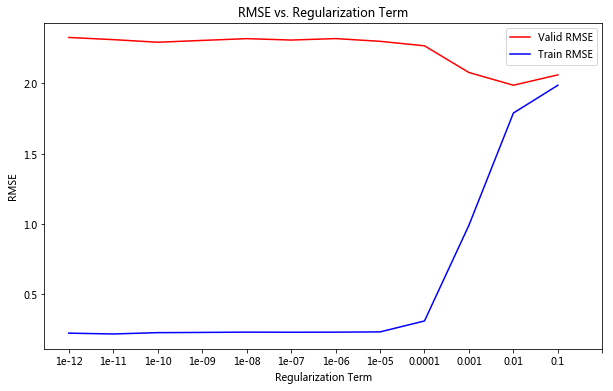

In [52]:
fig = plt.figure(figsize=(10,6))
plt.plot(valid_rmse_r, color='r', label='Valid RMSE')
plt.plot(train_rmse_r, color='b', label='Train RMSE')
plt.xlabel('Regularization Term')
plt.ylabel('RMSE')
plt.legend()
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12], [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
plt.title('RMSE vs. Regularization Term')
plt.savefig('tune_interaction_regularization.png', bbox_inches='tight')

In [11]:
m_final = gl.factorization_recommender.create(train_sf,
                                            regularization=0.01,
                                            linear_regularization=1e-8,
                                            user_id='user_id',
                                            item_id='perfume_id',
                                            target='user_rating',
                                            num_factors=10, # Number of latent factors.
                                            solver='sgd')

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.029453s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.54885                                  |

| 4       | 0.0045008         | 3.77518                                  |

| 5       | 0.0022504         | 4.02929                                  |

| 6       | 0.0011252         | 4.1995                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.54885                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 94us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 106.928ms    | 4.22547           | 2.0556                | 0.00900159  |

| 2       | 219.905ms    | 3.82394           | 1.95549               | 0.00419074  |

| 3       | 330.874ms    | 3.68581           | 1.91984               | 0.00273111  |

| 4       | 379.622ms    | 3.60732           | 1.89929               | 0.0020256   |

| 5       | 452.376ms    | 3.55416           | 1.88525               | 0.00160976  |

| 6       | 458.678ms    | 3.51459           | 1.87472               | 0.00133557  |

| 11      | 759.403ms    | 3.40231           | 1.84453               | 0.000721297 |

| 25      | 1.60s        | 3.28233           | 1.81172               | 0.000315277 |

| 50      | 3.43s        | 3.19981           | 1.7888                | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.19673

Final training RMSE: 1.78794

In [55]:
np.sqrt(np.mean((np.array(test_sf['user_rating']) - adjust_pred(m_final.predict(test_sf))) ** 2))

1.9758232489517082

In [12]:
m_final.training_rmse

1.7879376277486516

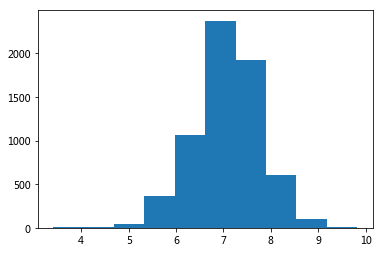

In [57]:
# my model predicted rating distribution on validation set
plt.hist(adjust_pred(m_final.predict(valid_sf)));

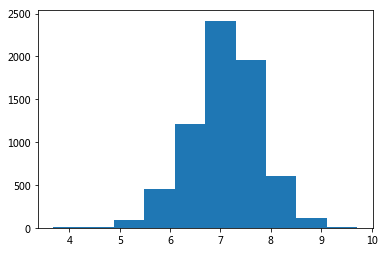

In [58]:
# my model predicted rating distribution on test set
plt.hist(adjust_pred(m_final.predict(test_sf)));

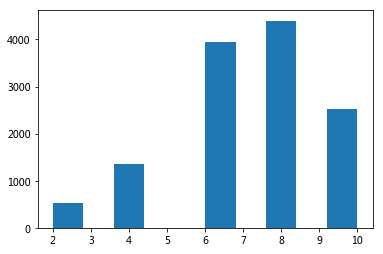

In [59]:
# original rating distribution
plt.hist(train['user_rating']);

In [13]:
m_final.evaluate_rmse(test_sf, target='user_rating')

{'rmse_by_item': Columns:
 	perfume_id	int
 	count	int
 	rmse	float
 
 Rows: 1707
 
 Data:
 +------------+-------+----------------+
 | perfume_id | count |      rmse      |
 +------------+-------+----------------+
 |   983725   |   1   | 3.85128029426  |
 |   690443   |   30  | 2.17390033124  |
 |   309189   |   8   | 1.28707181141  |
 |   654495   |   9   | 2.35955065245  |
 |   860793   |   4   |  2.2214900627  |
 |   884943   |   1   | 3.52026430507  |
 |   329998   |   2   | 2.80249855686  |
 |   460995   |   5   | 1.61143308313  |
 |   206222   |   21  | 1.64648489767  |
 |   797238   |   1   | 0.714890412884 |
 +------------+-------+----------------+
 [1707 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'rmse_by_user': Columns:
 	user_id	int
 	count	int
 	rmse	float
 
 Rows: 2658
 
 Data:
 +----------+-------+----------------+
 | user_id  | count |      rmse      |
 +----------+

In [14]:
m_all_data = gl.factorization_recommender.create(train_and_valid_sf,
                                            regularization=0.01,
                                            linear_regularization=1e-6,
                                            user_id='user_id',
                                            item_id='perfume_id',
                                            target='user_rating',
                                            num_factors=8, # Number of latent factors.
                                            solver='sgd')

Recsys training: model = factorization_recommender

Preparing data set.

Data has 19245 observations with 2658 users and 2718 items.

Data prepared in: 0.033428s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 19245 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.382135          | No Decrease (4.52656 >= 4.45745)         |

| 1       | 0.0955337         | Not Viable                               |

| 2       | 0.0238834         | 3.27191                                  |

| 3       | 0.0119417         | 3.54597                                  |

| 4       | 0.00597086        | 3.76656                                  |

| 5       | 0.00298543        | 3.96176                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0238834         | 3.27191                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 91us         | 4.45375           | 2.11039               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 129.699ms    | DIVERGED          | DIVERGED              | 0.0238834   |

| RESET   | 139.212ms    | 4.45376           | 2.11039               |             |

| 1       | 232.073ms    | 4.1639            | 2.04052               | 0.0119417   |

| 2       | 322.661ms    | 3.68732           | 1.92018               | 0.00362069  |

| 3       | 400.575ms    | 3.58511           | 1.89336               | 0.00213383  |

| 4       | 478.326ms    | 3.53187           | 1.87924               | 0.00151265  |

| 5       | 564.619ms    | 3.49701           | 1.86994               | 0.00117159  |

| 6       | 633.298ms    | 3.47152           | 1.8631                | 0.000956032 |

| 11      | 992.865ms    | 3.40026           | 1.84386               | 0.000497948 |

| 24      | 2.00s        | 3.3277            | 1.82405               | 0.000221725 |

| 49      | 3.94s        | 3.27283           | 1.80893               | 0.000107281 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.26933

Final training RMSE: 1.80796

In [15]:
m_all_data.evaluate_rmse(test_sf, target='user_rating')

{'rmse_by_item': Columns:
 	perfume_id	int
 	count	int
 	rmse	float
 
 Rows: 1707
 
 Data:
 +------------+-------+----------------+
 | perfume_id | count |      rmse      |
 +------------+-------+----------------+
 |   983725   |   1   | 4.02468297447  |
 |   690443   |   30  | 2.13382725595  |
 |   309189   |   8   | 1.23211171001  |
 |   654495   |   9   | 2.26218388854  |
 |   860793   |   4   | 2.32929377339  |
 |   884943   |   1   | 3.16345969404  |
 |   329998   |   2   | 2.65634413155  |
 |   460995   |   5   | 1.57497728576  |
 |   206222   |   21  | 1.63142210044  |
 |   797238   |   1   | 0.637841632615 |
 +------------+-------+----------------+
 [1707 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'rmse_by_user': Columns:
 	user_id	int
 	count	int
 	rmse	float
 
 Rows: 2658
 
 Data:
 +----------+-------+----------------+
 | user_id  | count |      rmse      |
 +----------+

## Grid Search on MF Parameters

In [7]:
valid_rmse_r = {}
train_rmse_r = {}

for n in xrange(2, 20, 2):
    for reg in [1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 1e-2, 1e-1]:
        for linear_reg in [1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 1e-2, 1e-1]:
            m1 = mf_model(train_sf, num_factors=n, regularization=reg, linear_regularization=linear_reg)
            valid_rmse_r[(n, reg, linear_reg)] = np.sqrt(np.mean((np.array(valid_sf['user_rating']) - adjust_pred(m1.predict(valid_sf))) ** 2))
            train_rmse_r[(n, reg, linear_reg)] = m1.training_rmse

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.05301s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (13.5865 >= 4.419)           |

| 1       | 6.25              | No Decrease (12.0972 >= 4.419)           |

| 2       | 1.5625            | No Decrease (7.81449 >= 4.419)           |

| 3       | 0.390625          | 2.09357                                  |

| 4       | 0.195312          | 0.970238                                 |

| 5       | 0.0976562         | 2.19997                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 0.970238                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 76us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 94.544ms     | 5.02595           | 2.24185               | 0.195312    |

| 2       | 213.074ms    | 3.82951           | 1.95691               | 0.116134    |

| 3       | 298.378ms    | 2.80756           | 1.67557               | 0.0856819   |

| 4       | 376.83ms     | 2.10937           | 1.45237               | 0.0580668   |

| 5       | 452.375ms    | 1.72128           | 1.31198               | 0.0491185   |

| 6       | 516.133ms    | 1.51152           | 1.22944               | 0.042841    |

| 11      | 798.695ms    | 1.10025           | 1.04893               | 0.0271912   |

| 25      | 1.67s        | 0.8424            | 0.917823              | 0.0146899   |

| 50      | 3.34s        | 0.727737          | 0.853074              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.660969

Final training RMSE: 0.812999

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.069048s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (13.515 >= 4.419)            |

| 1       | 6.25              | No Decrease (12.0797 >= 4.419)           |

| 2       | 1.5625            | No Decrease (7.57578 >= 4.419)           |

| 3       | 0.390625          | 2.06483                                  |

| 4       | 0.195312          | 0.959459                                 |

| 5       | 0.0976562         | 2.20328                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 0.959459                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 136us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 99.462ms     | 5.05766           | 2.24891               | 0.195312    |

| 2       | 136.126ms    | 3.78591           | 1.94573               | 0.116134    |

| 3       | 211.573ms    | 2.79208           | 1.67093               | 0.0856819   |

| 4       | 263.773ms    | 2.07899           | 1.44185               | 0.0580668   |

| 5       | 335.999ms    | 1.70236           | 1.30472               | 0.0491185   |

| 6       | 399.858ms    | 1.49246           | 1.22164               | 0.042841    |

| 11      | 645.949ms    | 1.09626           | 1.04699               | 0.0271912   |

| 25      | 1.39s        | 0.833792          | 0.913083              | 0.0146899   |

| 50      | 3.07s        | 0.719511          | 0.848195              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.653295

Final training RMSE: 0.80822

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.029484s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (13.3074 >= 4.419)           |

| 1       | 6.25              | No Decrease (12.6064 >= 4.419)           |

| 2       | 1.5625            | No Decrease (8.00958 >= 4.419)           |

| 3       | 0.390625          | 2.19379                                  |

| 4       | 0.195312          | 0.978176                                 |

| 5       | 0.0976562         | 2.20444                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 0.978176                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 74us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 85.258ms     | 5.15742           | 2.27002               | 0.195312    |

| 2       | 93.4ms       | 3.87489           | 1.96716               | 0.116134    |

| 3       | 165.708ms    | 2.81245           | 1.67538               | 0.0856819   |

| 4       | 227.931ms    | 2.13007           | 1.45751               | 0.0580668   |

| 5       | 302.276ms    | 1.76222           | 1.32527               | 0.0491185   |

| 6       | 377.328ms    | 1.56818           | 1.24987               | 0.042841    |

| 11      | 666.273ms    | 1.15323           | 1.07089               | 0.0271912   |

| 25      | 1.42s        | 0.885617          | 0.937386              | 0.0146899   |

| 50      | 2.92s        | 0.763419          | 0.869535              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.692706

Final training RMSE: 0.827875

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023909s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (4.56279 >= 4.419)           |

| 1       | 6.25              | 4.35866                                  |

| 2       | 3.125             | 4.16411                                  |

| 3       | 1.5625            | 4.07804                                  |

| 4       | 0.78125           | 3.59359                                  |

| 5       | 0.390625          | 2.62073                                  |

| 6       | 0.195312          | 1.41131                                  |

| 7       | 0.0976562         | 2.6142                                   |

| 8       | 0.0488281         | 2.72076                                  |

| 9       | 0.0244141         | 2.98087                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 1.41131                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 75us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 78.515ms     | 5.39938           | 2.24616               | 0.195312    |

| 2       | 144.498ms    | 4.21846           | 1.95591               | 0.116134    |

| 3       | 217.74ms     | 3.22686           | 1.6823                | 0.0856819   |

| 4       | 302.847ms    | 2.51615           | 1.45762               | 0.0580668   |

| 5       | 356.924ms    | 2.11579           | 1.31479               | 0.0491185   |

| 6       | 419.034ms    | 1.9093            | 1.23445               | 0.042841    |

| 11      | 783.897ms    | 1.51214           | 1.06826               | 0.0271912   |

| 25      | 1.86s        | 1.2344            | 0.943808              | 0.0146899   |

| 50      | 3.67s        | 1.09648           | 0.882448              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.02801

Final training RMSE: 0.84276

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026388s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | 2.25955                                  |

| 1       | 2.88051           | 2.33907                                  |

| 2       | 1.44025           | 2.32748                                  |

| 3       | 0.720127          | 2.29511                                  |

+---------+-------------------+------------------------------------------+

| Final   | 5.76102           | 2.25955                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 53us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 79.418ms     | 7.53111           | 2.7243                | 5.76102     |

| 2       | 163.049ms    | 6.03645           | 2.28171               | 0.07736     |

| 3       | 227.543ms    | 3.66492           | 1.73319               | 0.0389414   |

| 4       | 246.778ms    | 3.03189           | 1.55067               | 0.0259974   |

| 5       | 317.927ms    | 2.77484           | 1.47333               | 0.0195242   |

| 6       | 376.388ms    | 2.61409           | 1.42303               | 0.015632    |

| 11      | 682.468ms    | 2.26296           | 1.31307               | 0.00782862  |

| 25      | 1.51s        | 1.99056           | 1.22829               | 0.003265    |

| 50      | 3.11s        | 1.84577           | 1.18303               | 0.00159974  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.82965

Final training RMSE: 1.1762

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.021612s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | 3.66724                                  |

| 1       | 0.288051          | 3.63153                                  |

| 2       | 0.144025          | No Decrease (4.44223 >= 4.41901)         |

| 3       | 0.0360064         | No Decrease (4.433 >= 4.41901)           |

| 4       | 0.00900159        | 4.3773                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.288051          | 3.63153                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 67us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 71.56ms      | 6.22738           | 2.25159               | 0.288051    |

| 2       | 166.793ms    | 4.84172           | 2.11261               | 0.00763349  |

| 3       | 254.538ms    | 4.10396           | 1.93797               | 0.003868    |

| 4       | 327.581ms    | 3.92051           | 1.8913                | 0.00258586  |

| 5       | 369.506ms    | 3.83212           | 1.86758               | 0.00194459  |

| 6       | 402.038ms    | 3.77061           | 1.8513                | 0.00155817  |

| 11      | 680.943ms    | 3.63122           | 1.81343               | 0.000781599 |

| 25      | 1.54s        | 3.49959           | 1.77794               | 0.00032628  |

| 50      | 3.02s        | 3.40965           | 1.75394               | 0.000159921 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.41119

Final training RMSE: 1.75438

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022642s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.46383 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.44029 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43361 >= 4.41904)         |

| 3       | 0.000900159       | 4.41892                                  |

| 4       | 0.00045008        | 4.40901                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40383                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 93us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 59.957ms     | 4.40671           | 2.09811               | 0.00022504  |

| 2       | 121.782ms    | 4.39778           | 2.09469               | 0.000133809 |

| 3       | 175.146ms    | 4.39456           | 2.09286               | 9.8723e-05  |

| 4       | 202.917ms    | 4.39336           | 2.09169               | 7.95636e-05 |

| 5       | 234.08ms     | 4.39288           | 2.09082               | 6.73026e-05 |

| 6       | 300.275ms    | 4.39273           | 2.09015               | 5.87011e-05 |

| 11      | 596.911ms    | 4.39248           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39261

Final training RMSE: 2.08784

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024203s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (13.9961 >= 4.419)           |

| 1       | 6.25              | No Decrease (12.2047 >= 4.419)           |

| 2       | 1.5625            | No Decrease (7.95818 >= 4.419)           |

| 3       | 0.390625          | 2.08018                                  |

| 4       | 0.195312          | 0.950853                                 |

| 5       | 0.0976562         | 2.20002                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 0.950853                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 72us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 69.914ms     | 5.10974           | 2.26046               | 0.195312    |

| 2       | 127.442ms    | 3.77399           | 1.94266               | 0.116134    |

| 3       | 183.119ms    | 2.74722           | 1.65746               | 0.0856819   |

| 4       | 252.133ms    | 2.02441           | 1.4228                | 0.0580668   |

| 5       | 325.038ms    | 1.63971           | 1.28049               | 0.0491185   |

| 6       | 395.026ms    | 1.45655           | 1.20685               | 0.042841    |

| 11      | 723.039ms    | 1.05997           | 1.02952               | 0.0271912   |

| 25      | 1.57s        | 0.816431          | 0.903526              | 0.0146899   |

| 50      | 3.01s        | 0.707536          | 0.841104              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.643

Final training RMSE: 0.801822

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022783s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (13.2151 >= 4.419)           |

| 1       | 6.25              | No Decrease (12.4649 >= 4.419)           |

| 2       | 1.5625            | No Decrease (7.90553 >= 4.419)           |

| 3       | 0.390625          | 2.09548                                  |

| 4       | 0.195312          | 0.999016                                 |

| 5       | 0.0976562         | 2.18923                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 0.999016                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 75us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 56.074ms     | 5.0297            | 2.24268               | 0.195312    |

| 2       | 105.106ms    | 3.78405           | 1.94524               | 0.116134    |

| 3       | 165.846ms    | 2.7909            | 1.67057               | 0.0856819   |

| 4       | 206.914ms    | 2.07193           | 1.43939               | 0.0580668   |

| 5       | 268.159ms    | 1.69148           | 1.30053               | 0.0491185   |

| 6       | 337.458ms    | 1.49723           | 1.22357               | 0.042841    |

| 11      | 656.427ms    | 1.10914           | 1.0531                | 0.0271912   |

| 25      | 1.45s        | 0.855054          | 0.924615              | 0.0146899   |

| 50      | 2.86s        | 0.736825          | 0.858296              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.670107

Final training RMSE: 0.818507

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023049s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (12.9558 >= 4.419)           |

| 1       | 6.25              | No Decrease (11.5644 >= 4.419)           |

| 2       | 1.5625            | No Decrease (7.94697 >= 4.419)           |

| 3       | 0.390625          | 2.14816                                  |

| 4       | 0.195312          | 0.935137                                 |

| 5       | 0.0976562         | 2.20935                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 0.935137                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 92us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 66.273ms     | 5.01542           | 2.23854               | 0.195312    |

| 2       | 132.486ms    | 3.79194           | 1.94598               | 0.116134    |

| 3       | 193.452ms    | 2.75813           | 1.65908               | 0.0856819   |

| 4       | 263.955ms    | 2.08033           | 1.44034               | 0.0580668   |

| 5       | 327.442ms    | 1.69014           | 1.29777               | 0.0491185   |

| 6       | 343.322ms    | 1.51772           | 1.22948               | 0.042841    |

| 11      | 612.609ms    | 1.10951           | 1.05022               | 0.0271912   |

| 25      | 1.40s        | 0.844737          | 0.915232              | 0.0146899   |

| 50      | 2.74s        | 0.731581          | 0.850932              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.663551

Final training RMSE: 0.809972

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022965s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (4.59194 >= 4.419)           |

| 1       | 6.25              | 4.32773                                  |

| 2       | 3.125             | 4.33125                                  |

| 3       | 1.5625            | 3.96056                                  |

| 4       | 0.78125           | 3.58453                                  |

| 5       | 0.390625          | 2.60621                                  |

| 6       | 0.195312          | 1.40113                                  |

| 7       | 0.0976562         | 2.61266                                  |

| 8       | 0.0488281         | 2.72134                                  |

| 9       | 0.0244141         | 2.98099                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 1.40113                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 87us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 74.991ms     | 5.38321           | 2.24264               | 0.195312    |

| 2       | 144.291ms    | 4.2144            | 1.95474               | 0.116134    |

| 3       | 210.146ms    | 3.24281           | 1.68517               | 0.0856819   |

| 4       | 281.996ms    | 2.51762           | 1.45578               | 0.0580668   |

| 5       | 322.487ms    | 2.11477           | 1.31115               | 0.0491185   |

| 6       | 382.338ms    | 1.913             | 1.23274               | 0.042841    |

| 11      | 644.928ms    | 1.50503           | 1.06368               | 0.0271912   |

| 25      | 1.43s        | 1.23322           | 0.943109              | 0.0146899   |

| 50      | 2.68s        | 1.09505           | 0.882519              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.02521

Final training RMSE: 0.842018

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026288s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | 2.28912                                  |

| 1       | 2.88051           | 2.31829                                  |

| 2       | 1.44025           | 2.2279                                   |

| 3       | 0.720127          | 2.31023                                  |

| 4       | 0.360064          | 2.33834                                  |

| 5       | 0.180032          | 2.56463                                  |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 2.2279                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 54us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 75.703ms     | 7.7111            | 2.70412               | 1.44025     |

| 2       | 149.338ms    | 5.83339           | 2.24421               | 0.0743643   |

| 3       | 206.231ms    | 3.58126           | 1.70463               | 0.0381675   |

| 4       | 275.436ms    | 2.99994           | 1.53812               | 0.0255855   |

| 5       | 336.781ms    | 2.74705           | 1.46156               | 0.019291    |

| 6       | 401.192ms    | 2.58341           | 1.4113                | 0.0154821   |

| 11      | 648.491ms    | 2.2441            | 1.30454               | 0.00779085  |

| 25      | 1.40s        | 1.98029           | 1.22218               | 0.00325841  |

| 50      | 2.67s        | 1.83851           | 1.17804               | 0.00159815  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.82242

Final training RMSE: 1.1712

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023009s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | 3.66934                                  |

| 1       | 0.288051          | 3.69532                                  |

| 2       | 0.144025          | No Decrease (4.433 >= 4.41901)           |

| 3       | 0.0360064         | No Decrease (4.43324 >= 4.41901)         |

+---------+-------------------+------------------------------------------+

| Final   | 0.576102          | 3.66934                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 73us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 49.809ms     | 7.26798           | 2.49792               | 0.576102    |

| 2       | 116.781ms    | 5.74204           | 2.31919               | 0.007736    |

| 3       | 161.89ms     | 4.2415            | 1.97753               | 0.00389414  |

| 4       | 188.568ms    | 3.98789           | 1.91254               | 0.00259974  |

| 5       | 230.484ms    | 3.86721           | 1.88034               | 0.00195242  |

| 6       | 299.022ms    | 3.78943           | 1.85961               | 0.0015632   |

| 11      | 584.082ms    | 3.61887           | 1.81361               | 0.000782862 |

| 25      | 1.40s        | 3.47132           | 1.77436               | 0.0003265   |

| 50      | 2.82s        | 3.37775           | 1.74963               | 0.000159974 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.37869

Final training RMSE: 1.7499

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02275s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.45603 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.43971 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43351 >= 4.41904)         |

| 3       | 0.000900159       | No Decrease (4.41911 >= 4.41904)         |

| 4       | 0.00022504        | 4.40114                                  |

| 5       | 0.00011252        | 4.40381                                  |

| 6       | 5.626e-05         | 4.40921                                  |

| 7       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 119us        | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 32.663ms     | 4.40692           | 2.09811               | 0.00022504  |

| 2       | 103.729ms    | 4.39758           | 2.09459               | 0.000133809 |

| 3       | 149.404ms    | 4.39452           | 2.0928                | 9.8723e-05  |

| 4       | 215.915ms    | 4.39324           | 2.09161               | 7.95636e-05 |

| 5       | 286.513ms    | 4.39289           | 2.09078               | 6.73026e-05 |

| 6       | 359.136ms    | 4.39259           | 2.09008               | 5.87011e-05 |

| 11      | 582.928ms    | 4.39269           | 2.08836               | 2.21535e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39283

Final training RMSE: 2.08772

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025221s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (12.0984 >= 4.419)           |

| 1       | 6.25              | No Decrease (12.3431 >= 4.419)           |

| 2       | 1.5625            | No Decrease (7.63809 >= 4.419)           |

| 3       | 0.390625          | 2.02581                                  |

| 4       | 0.195312          | 0.931687                                 |

| 5       | 0.0976562         | 2.20019                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 0.931687                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 55us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 104.712ms    | 5.06848           | 2.25072               | 0.195312    |

| 2       | 125.94ms     | 3.76118           | 1.93848               | 0.116134    |

| 3       | 191.69ms     | 2.76489           | 1.66163               | 0.0856819   |

| 4       | 252.036ms    | 2.07162           | 1.43785               | 0.0580668   |

| 5       | 344.044ms    | 1.70355           | 1.30346               | 0.0491185   |

| 6       | 421.764ms    | 1.51305           | 1.22811               | 0.042841    |

| 11      | 764.217ms    | 1.11147           | 1.05155               | 0.0271912   |

| 25      | 1.90s        | 0.85354           | 0.920137              | 0.0146899   |

| 50      | 4.00s        | 0.737879          | 0.854413              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.669111

Final training RMSE: 0.813175

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.027763s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (11.0114 >= 4.419)           |

| 1       | 6.25              | No Decrease (12.2972 >= 4.419)           |

| 2       | 1.5625            | No Decrease (7.99012 >= 4.419)           |

| 3       | 0.390625          | 2.09855                                  |

| 4       | 0.195312          | 0.963201                                 |

| 5       | 0.0976562         | 2.20127                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 0.963201                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 82us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 80.384ms     | 5.07447           | 2.25201               | 0.195312    |

| 2       | 167.914ms    | 3.81105           | 1.95126               | 0.116134    |

| 3       | 257.551ms    | 2.74692           | 1.65616               | 0.0856819   |

| 4       | 337.137ms    | 2.06815           | 1.43661               | 0.0580668   |

| 5       | 419.44ms     | 1.68082           | 1.29468               | 0.0491185   |

| 6       | 495.895ms    | 1.49615           | 1.22117               | 0.042841    |

| 11      | 902.548ms    | 1.10919           | 1.05044               | 0.0271912   |

| 25      | 1.88s        | 0.84413           | 0.914984              | 0.0146899   |

| 50      | 3.37s        | 0.733108          | 0.85159               | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.665973

Final training RMSE: 0.811215

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.027209s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (11.5197 >= 4.419)           |

| 1       | 6.25              | No Decrease (11.9344 >= 4.419)           |

| 2       | 1.5625            | No Decrease (7.58586 >= 4.419)           |

| 3       | 0.390625          | 2.10362                                  |

| 4       | 0.195312          | 0.990859                                 |

| 5       | 0.0976562         | 2.18829                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 0.990859                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 72us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 60.585ms     | 5.07938           | 2.25218               | 0.195312    |

| 2       | 111.52ms     | 3.80455           | 1.94833               | 0.116134    |

| 3       | 178.49ms     | 2.78023           | 1.66456               | 0.0856819   |

| 4       | 249.882ms    | 2.10188           | 1.44636               | 0.0580668   |

| 5       | 314.276ms    | 1.71074           | 1.30396               | 0.0491185   |

| 6       | 384.087ms    | 1.52689           | 1.23125               | 0.042841    |

| 11      | 645.307ms    | 1.11884           | 1.05192               | 0.0271912   |

| 25      | 1.45s        | 0.871029          | 0.925758              | 0.0146899   |

| 50      | 2.73s        | 0.762456          | 0.86436               | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.693909

Final training RMSE: 0.823754

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022547s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (4.66917 >= 4.419)           |

| 1       | 6.25              | 4.22552                                  |

| 2       | 3.125             | 4.28443                                  |

| 3       | 1.5625            | 4.13621                                  |

| 4       | 0.78125           | 3.56486                                  |

| 5       | 0.390625          | 2.68434                                  |

| 6       | 0.195312          | 1.43097                                  |

| 7       | 0.0976562         | 2.61339                                  |

| 8       | 0.0488281         | 2.72107                                  |

| 9       | 0.0244141         | 2.98118                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 1.43097                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 86us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 67.309ms     | 5.39127           | 2.24119               | 0.195312    |

| 2       | 109.286ms    | 4.22201           | 1.95619               | 0.116134    |

| 3       | 182.93ms     | 3.20897           | 1.67551               | 0.0856819   |

| 4       | 247.154ms    | 2.46889           | 1.44015               | 0.0580668   |

| 5       | 310.075ms    | 2.09352           | 1.30525               | 0.0491185   |

| 6       | 336.323ms    | 1.90751           | 1.23312               | 0.042841    |

| 11      | 581.797ms    | 1.50811           | 1.0665                | 0.0271912   |

| 25      | 1.27s        | 1.23904           | 0.946394              | 0.0146899   |

| 50      | 2.85s        | 1.10389           | 0.886217              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.03418

Final training RMSE: 0.845975

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024093s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | 2.30755                                  |

| 1       | 2.88051           | 2.25981                                  |

| 2       | 1.44025           | 2.30812                                  |

| 3       | 0.720127          | 2.24958                                  |

| 4       | 0.360064          | 2.30053                                  |

| 5       | 0.180032          | 2.76888                                  |

| 6       | 0.0900159         | 3.90793                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.720127          | 2.24958                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 53us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 73.124ms     | 7.4262            | 2.60243               | 0.720127    |

| 2       | 144.309ms    | 5.58339           | 2.19083               | 0.0707131   |

| 3       | 187.938ms    | 3.52782           | 1.68937               | 0.0371821   |

| 4       | 247.612ms    | 2.94756           | 1.51925               | 0.0250561   |

| 5       | 288.02ms     | 2.68097           | 1.43651               | 0.0189885   |

| 6       | 329.792ms    | 2.5253            | 1.38845               | 0.0152867   |

| 11      | 622.652ms    | 2.17525           | 1.27898               | 0.00774105  |

| 25      | 1.29s        | 1.91451           | 1.19797               | 0.00324967  |

| 50      | 2.62s        | 1.77927           | 1.15581               | 0.00159605  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.76368

Final training RMSE: 1.14904

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025351s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | 3.72361                                  |

| 1       | 0.288051          | 3.70175                                  |

| 2       | 0.144025          | No Decrease (4.44081 >= 4.41901)         |

| 3       | 0.0360064         | No Decrease (4.43122 >= 4.41901)         |

| 4       | 0.00900159        | 4.37696                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.288051          | 3.70175                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 69us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 81.427ms     | 6.41611           | 2.25369               | 0.288051    |

| 2       | 139.168ms    | 4.84347           | 2.11015               | 0.00763349  |

| 3       | 174.486ms    | 4.04362           | 1.92141               | 0.003868    |

| 4       | 231.766ms    | 3.85196           | 1.87281               | 0.00258586  |

| 5       | 298.843ms    | 3.7573            | 1.8478                | 0.00194459  |

| 6       | 354.009ms    | 3.69262           | 1.83087               | 0.00155817  |

| 11      | 661.753ms    | 3.54526           | 1.79111               | 0.000781599 |

| 25      | 1.42s        | 3.40332           | 1.75325               | 0.00032628  |

| 50      | 2.82s        | 3.30647           | 1.72759               | 0.000159921 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.30762

Final training RMSE: 1.72792

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022766s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.46476 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.43786 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43345 >= 4.41904)         |

| 3       | 0.000900159       | 4.41901                                  |

| 4       | 0.00045008        | 4.40898                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40382                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 95us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 27.972ms     | 4.40671           | 2.09811               | 0.00022504  |

| 2       | 84.845ms     | 4.3978            | 2.09469               | 0.000133809 |

| 3       | 144.199ms    | 4.39455           | 2.09285               | 9.8723e-05  |

| 4       | 169.646ms    | 4.39335           | 2.09169               | 7.95636e-05 |

| 5       | 192.984ms    | 4.39288           | 2.09083               | 6.73026e-05 |

| 6       | 233.596ms    | 4.39275           | 2.09015               | 5.87011e-05 |

| 11      | 486.562ms    | 4.39248           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39261

Final training RMSE: 2.08784

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023262s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | 3.61841                                  |

| 1       | 12.5              | 3.49834                                  |

| 2       | 6.25              | 3.58577                                  |

| 3       | 3.125             | 3.37123                                  |

| 4       | 1.5625            | 3.16631                                  |

| 5       | 0.78125           | 3.14825                                  |

| 6       | 0.390625          | 2.32401                                  |

| 7       | 0.195312          | 1.3684                                   |

| 8       | 0.0976562         | 2.19862                                  |

| 9       | 0.0488281         | 2.49029                                  |

| 10      | 0.0244141         | 2.86955                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 1.3684                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 88us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 84.448ms     | 5.42077           | 2.26424               | 0.195312    |

| 2       | 143.634ms    | 4.18083           | 1.96881               | 0.116134    |

| 3       | 212.462ms    | 3.20973           | 1.69568               | 0.0856819   |

| 4       | 287.875ms    | 2.46579           | 1.45737               | 0.0580668   |

| 5       | 348.066ms    | 2.1253            | 1.32682               | 0.0491185   |

| 6       | 396.649ms    | 1.92847           | 1.2451                | 0.042841    |

| 11      | 682.024ms    | 1.58615           | 1.07866               | 0.0271912   |

| 25      | 1.30s        | 1.37382           | 0.952208              | 0.0146899   |

| 50      | 2.81s        | 1.28299           | 0.891004              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.21223

Final training RMSE: 0.850368

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023561s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | 3.52358                                  |

| 1       | 12.5              | 3.41388                                  |

| 2       | 6.25              | 3.48343                                  |

| 3       | 3.125             | 3.4332                                   |

| 4       | 1.5625            | 3.44625                                  |

+---------+-------------------+------------------------------------------+

| Final   | 12.5              | 3.41388                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 53us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 67.507ms     | 7.38143           | 2.70102               | 12.5        |

| 2       | 147.971ms    | 8.42276           | 2.79967               | 0.737844    |

| 3       | 187.115ms    | 7.81662           | 2.67783               | 0.380141    |

| 4       | 254.401ms    | 6.58362           | 2.44912               | 0.255035    |

| 5       | 289.375ms    | 5.42684           | 2.21852               | 0.191779    |

| 6       | 351.286ms    | 4.5885            | 2.03827               | 0.154092    |

| 11      | 614.963ms    | 2.44628           | 1.43467               | 0.0777234   |

| 25      | 1.35s        | 1.50594           | 1.02371               | 0.0325517   |

| 50      | 2.69s        | 1.2955            | 0.898132              | 0.0159737   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.18594

Final training RMSE: 0.834918

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022783s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | 3.49384                                  |

| 1       | 12.5              | 3.55162                                  |

| 2       | 6.25              | 3.52207                                  |

| 3       | 3.125             | 3.49434                                  |

+---------+-------------------+------------------------------------------+

| Final   | 25                | 3.49384                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 68us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 71.103ms     | 6.7958            | 2.59595               | 25          |

| 2       | 128.611ms    | 8.17319           | 2.75763               | 0.760283    |

| 3       | 187.679ms    | 7.69944           | 2.65225               | 0.386011    |

| 4       | 252.728ms    | 6.61372           | 2.45508               | 0.258167    |

| 5       | 312.259ms    | 5.55325           | 2.24652               | 0.193882    |

| 6       | 380.78ms     | 4.56709           | 2.02765               | 0.155447    |

| 11      | 637.583ms    | 2.44647           | 1.4301                | 0.0780666   |

| 25      | 1.34s        | 1.50339           | 1.01544               | 0.0326118   |

| 50      | 2.69s        | 1.30253           | 0.893802              | 0.0159882   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.19133

Final training RMSE: 0.829268

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022975s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | 3.98188                                  |

| 1       | 12.5              | 4.01573                                  |

| 2       | 6.25              | 3.97477                                  |

| 3       | 3.125             | 3.93852                                  |

| 4       | 1.5625            | 3.79479                                  |

| 5       | 0.78125           | 3.60596                                  |

| 6       | 0.390625          | 2.80784                                  |

| 7       | 0.195312          | 1.82892                                  |

| 8       | 0.0976562         | 2.61366                                  |

| 9       | 0.0488281         | 2.72206                                  |

| 10      | 0.0244141         | 2.9811                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 1.82892                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 63us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 63.715ms     | 5.7768            | 2.26378               | 0.195312    |

| 2       | 100.573ms    | 4.63237           | 1.97926               | 0.116134    |

| 3       | 145.187ms    | 3.67923           | 1.7073                | 0.0856819   |

| 4       | 210.174ms    | 2.93589           | 1.47349               | 0.0580668   |

| 5       | 273.655ms    | 2.57756           | 1.33578               | 0.0491185   |

| 6       | 345.274ms    | 2.38883           | 1.25805               | 0.042841    |

| 11      | 546.839ms    | 2.04637           | 1.09433               | 0.0271912   |

| 25      | 1.27s        | 1.83152           | 0.974949              | 0.0146899   |

| 50      | 2.69s        | 1.74181           | 0.919909              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.67553

Final training RMSE: 0.883149

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.028041s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | 2.72201                                  |

| 1       | 2.88051           | 2.72903                                  |

| 2       | 1.44025           | 2.75216                                  |

| 3       | 0.720127          | 2.78056                                  |

+---------+-------------------+------------------------------------------+

| Final   | 5.76102           | 2.72201                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 61us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 90.414ms     | 6.70911           | 2.52503               | 5.76102     |

| 2       | 148.857ms    | 5.23593           | 2.07018               | 0.07736     |

| 3       | 182.534ms    | 3.87391           | 1.70955               | 0.0389414   |

| 4       | 256.236ms    | 3.3715            | 1.54828               | 0.0259974   |

| 5       | 330.98ms     | 3.11552           | 1.45999               | 0.0195242   |

| 6       | 390.96ms     | 2.96113           | 1.40676               | 0.015632    |

| 11      | 651.018ms    | 2.66335           | 1.29366               | 0.00782862  |

| 25      | 1.47s        | 2.45546           | 1.20845               | 0.003265    |

| 50      | 2.81s        | 2.35723           | 1.16419               | 0.00159974  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.34411

Final training RMSE: 1.15854

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022899s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | 4.14547                                  |

| 1       | 0.288051          | 4.03636                                  |

| 2       | 0.144025          | No Decrease (4.44489 >= 4.41901)         |

| 3       | 0.0360064         | No Decrease (4.43234 >= 4.41901)         |

| 4       | 0.00900159        | 4.37713                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.288051          | 4.03636                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 91us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 80.187ms     | 7.2404            | 2.27914               | 0.288051    |

| 2       | 176.065ms    | 5.31211           | 2.12771               | 0.00763349  |

| 3       | 254.09ms     | 4.48517           | 1.93946               | 0.003868    |

| 4       | 285.508ms    | 4.2946            | 1.8935                | 0.00258586  |

| 5       | 345.809ms    | 4.20178           | 1.87011               | 0.00194459  |

| 6       | 413.414ms    | 4.1387            | 1.85422               | 0.00155817  |

| 11      | 678.454ms    | 3.99642           | 1.8171                | 0.000781599 |

| 25      | 1.46s        | 3.86327           | 1.78173               | 0.00032628  |

| 50      | 3.00s        | 3.77327           | 1.75736               | 0.000159921 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.77488

Final training RMSE: 1.75781

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022856s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.46255 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.43825 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43349 >= 4.41904)         |

| 3       | 0.000900159       | 4.4187                                   |

| 4       | 0.00045008        | 4.40897                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40382                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 83us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 62.522ms     | 4.40672           | 2.09811               | 0.00022504  |

| 2       | 136.445ms    | 4.39779           | 2.09468               | 0.000133809 |

| 3       | 203.432ms    | 4.39457           | 2.09285               | 9.8723e-05  |

| 4       | 258.335ms    | 4.39337           | 2.09168               | 7.95636e-05 |

| 5       | 277.785ms    | 4.39288           | 2.09082               | 6.73026e-05 |

| 6       | 349.822ms    | 4.39274           | 2.09014               | 5.87011e-05 |

| 11      | 606.41ms     | 4.39248           | 2.08837               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39262

Final training RMSE: 2.08783

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026782s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 2.51013                                  |

| 2       | 0.720127          | 2.51066                                  |

| 3       | 0.360064          | 2.53756                                  |

| 4       | 0.180032          | 2.61327                                  |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 2.51013                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 91us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 62.642ms     | 7.68462           | 2.60302               | 1.44025     |

| 2       | 97.686ms     | 4.84658           | 1.97072               | 0.0743643   |

| 3       | 158.501ms    | 3.38353           | 1.64055               | 0.0381675   |

| 4       | 236.417ms    | 2.94868           | 1.49972               | 0.0255855   |

| 5       | 291.667ms    | 2.81551           | 1.43963               | 0.019291    |

| 6       | 321.866ms    | 2.72131           | 1.39881               | 0.0154821   |

| 11      | 635.324ms    | 2.56672           | 1.31915               | 0.00779085  |

| 25      | 1.39s        | 2.46614           | 1.26573               | 0.00325841  |

| 50      | 2.75s        | 2.42358           | 1.24194               | 0.00159815  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.42277

Final training RMSE: 1.24162

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023083s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 2.4874                                   |

| 2       | 0.720127          | 2.51488                                  |

| 3       | 0.360064          | 2.54381                                  |

| 4       | 0.180032          | 2.60218                                  |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 2.4874                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 88us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 70.358ms     | 7.64206           | 2.60429               | 1.44025     |

| 2       | 126.205ms    | 4.83023           | 1.96115               | 0.0743643   |

| 3       | 196.331ms    | 3.3861            | 1.63287               | 0.0381675   |

| 4       | 254.008ms    | 2.97171           | 1.498                 | 0.0255855   |

| 5       | 328.028ms    | 2.82494           | 1.43512               | 0.019291    |

| 6       | 368.168ms    | 2.72103           | 1.39256               | 0.0154821   |

| 11      | 643.369ms    | 2.5661            | 1.31382               | 0.00779085  |

| 25      | 1.45s        | 2.46631           | 1.26039               | 0.00325841  |

| 50      | 2.77s        | 2.42351           | 1.23654               | 0.00159815  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.4233

Final training RMSE: 1.23645

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022512s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 2.49404                                  |

| 2       | 0.720127          | 2.4976                                   |

| 3       | 0.360064          | 2.54678                                  |

| 4       | 0.180032          | 2.60161                                  |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 2.49404                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 93us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 36.132ms     | 7.61445           | 2.59811               | 1.44025     |

| 2       | 97.177ms     | 4.90669           | 1.96625               | 0.0743643   |

| 3       | 129.238ms    | 3.39014           | 1.62727               | 0.0381675   |

| 4       | 181.821ms    | 2.98282           | 1.49323               | 0.0255855   |

| 5       | 253.138ms    | 2.82518           | 1.42696               | 0.019291    |

| 6       | 324.209ms    | 2.726             | 1.38494               | 0.0154821   |

| 11      | 611.105ms    | 2.56993           | 1.30486               | 0.00779085  |

| 25      | 1.38s        | 2.46973           | 1.25266               | 0.00325841  |

| 50      | 2.76s        | 2.42623           | 1.23061               | 0.00159815  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.42617

Final training RMSE: 1.23059

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02277s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 2.95918                                  |

| 2       | 0.720127          | 2.95921                                  |

| 3       | 0.360064          | 3.01222                                  |

| 4       | 0.180032          | 3.05114                                  |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 2.95918                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 101us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 64.722ms     | 7.57945           | 2.55377               | 1.44025     |

| 2       | 165.038ms    | 5.14886           | 1.96351               | 0.0743643   |

| 3       | 227.165ms    | 3.82659           | 1.66983               | 0.0381675   |

| 4       | 268.872ms    | 3.42116           | 1.53185               | 0.0255855   |

| 5       | 331.886ms    | 3.27879           | 1.4689                | 0.019291    |

| 6       | 360.24ms     | 3.18488           | 1.42656               | 0.0154821   |

| 11      | 639.251ms    | 3.0549            | 1.34582               | 0.00779085  |

| 25      | 1.47s        | 2.98061           | 1.29262               | 0.00325841  |

| 50      | 2.94s        | 2.9558            | 1.26967               | 0.00159431  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.95645

Final training RMSE: 1.26992

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024291s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 4.21984                                  |

| 2       | 0.720127          | 4.24887                                  |

| 3       | 0.360064          | 4.31021                                  |

| 4       | 0.180032          | 4.35385                                  |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 4.21984                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 52us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 68.279ms     | 7.20144           | 2.44929               | 1.44025     |

| 2       | 127.286ms    | 6.04344           | 2.05122               | 0.0743643   |

| 3       | 210.826ms    | 4.90313           | 1.80545               | 0.0381675   |

| 4       | 265.396ms    | 4.47294           | 1.66835               | 0.0255855   |

| 5       | 328.538ms    | 4.32784           | 1.60563               | 0.019291    |

| 6       | 370.194ms    | 4.24312           | 1.56708               | 0.0154821   |

| 11      | 601.041ms    | 4.10715           | 1.49482               | 0.00779085  |

| 25      | 1.42s        | 4.02812           | 1.45074               | 0.00325841  |

| 50      | 2.64s        | 4.00305           | 1.43349               | 0.00158616  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 4.01772

Final training RMSE: 1.4386

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026439s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | No Decrease (5.21182 >= 4.41901)         |

| 1       | 0.144025          | No Decrease (5.3284 >= 4.41901)          |

| 2       | 0.0360064         | No Decrease (4.42891 >= 4.41901)         |

| 3       | 0.00900159        | 4.37768                                  |

| 4       | 0.0045008         | 4.32303                                  |

| 5       | 0.0022504         | 4.26719                                  |

| 6       | 0.0011252         | 4.28279                                  |

| 7       | 0.0005626         | 4.32671                                  |

| 8       | 0.0002813         | 4.36507                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26719                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 92us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 80.971ms     | 4.38973           | 2.08528               | 0.0022504   |

| 2       | 103.3ms      | 4.31138           | 2.05593               | 0.00133809  |

| 3       | 191.273ms    | 4.28743           | 2.04211               | 0.00098723  |

| 4       | 272.219ms    | 4.27909           | 2.03376               | 0.000795636 |

| 5       | 365.684ms    | 4.2761            | 2.0279                | 0.000673026 |

| 6       | 455.694ms    | 4.27553           | 2.0235                | 0.000587011 |

| 11      | 753.13ms     | 4.27479           | 2.01238               | 0.000221535 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27506

Final training RMSE: 2.00793

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.028885s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.46157 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.44079 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43266 >= 4.41904)         |

| 3       | 0.000900159       | 4.41899                                  |

| 4       | 0.00045008        | 4.40895                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40382                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 87us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 74.688ms     | 4.4067            | 2.09811               | 0.00022504  |

| 2       | 122.385ms    | 4.39779           | 2.09469               | 0.000133809 |

| 3       | 128.63ms     | 4.39456           | 2.09286               | 9.8723e-05  |

| 4       | 200.947ms    | 4.39339           | 2.09169               | 7.95636e-05 |

| 5       | 273.715ms    | 4.39287           | 2.09082               | 6.73026e-05 |

| 6       | 355.125ms    | 4.39274           | 2.09015               | 5.87011e-05 |

| 11      | 665.897ms    | 4.39248           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39261

Final training RMSE: 2.08784

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022182s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | 2.99096                                  |

| 2       | 0.0720127         | 3.39635                                  |

| 3       | 0.0360064         | 3.82993                                  |

| 4       | 0.0180032         | 3.30335                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.144025          | 2.99096                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 61us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 74.607ms     | DIVERGED          | DIVERGED              | 0.144025    |

| RESET   | 81.444ms     | 4.40886           | 2.09973               |             |

| 1       | 166.738ms    | DIVERGED          | DIVERGED              | 0.0720127   |

| RESET   | 171.465ms    | 4.4088            | 2.09971               |             |

| 1       | 245.636ms    | DIVERGED          | DIVERGED              | 0.0360064   |

| RESET   | 251.772ms    | 4.4088            | 2.09971               |             |

| 1       | 294.923ms    | 4.14803           | 2.03667               | 0.0180032   |

| 2       | 342.348ms    | 3.5551            | 1.8855                | 0.00546222  |

| 3       | 381.532ms    | 3.42935           | 1.85185               | 0.00321952  |

| 4       | 444.523ms    | 3.36464           | 1.8343                | 0.0022824   |

| 5       | 525.834ms    | 3.32256           | 1.82279               | 0.00176783  |

| 6       | 584.803ms    | 3.29195           | 1.81437               | 0.00144259  |

| 11      | 895.886ms    | 3.20697           | 1.7908                | 0.000751402 |

| 22      | 1.79s        | 3.12982           | 1.76913               | 0.000365808 |

| 47      | 3.65s        | 3.06007           | 1.74931               | 0.000168864 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.05214

Final training RMSE: 1.74704

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.028669s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | 2.96882                                  |

| 2       | 0.0720127         | 3.37733                                  |

| 3       | 0.0360064         | 3.80623                                  |

| 4       | 0.0180032         | 3.30385                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.144025          | 2.96882                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 85us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 144.695ms    | DIVERGED          | DIVERGED              | 0.144025    |

| RESET   | 151.063ms    | 4.40882           | 2.09972               |             |

| 1       | 265.419ms    | DIVERGED          | DIVERGED              | 0.0720127   |

| RESET   | 272.911ms    | 4.4088            | 2.09971               |             |

| 1       | 326.728ms    | DIVERGED          | DIVERGED              | 0.0360064   |

| RESET   | 332.924ms    | 4.40877           | 2.09971               |             |

| 1       | 405.278ms    | 4.14627           | 2.03624               | 0.0180032   |

| 2       | 464.952ms    | 3.55378           | 1.88515               | 0.00546222  |

| 3       | 519.888ms    | 3.4283            | 1.85157               | 0.00321952  |

| 4       | 587.421ms    | 3.36373           | 1.83405               | 0.0022824   |

| 5       | 659.743ms    | 3.32171           | 1.82256               | 0.00176783  |

| 6       | 731.683ms    | 3.29118           | 1.81416               | 0.00144259  |

| 11      | 996.346ms    | 3.20636           | 1.79063               | 0.000751402 |

| 22      | 1.55s        | 3.12934           | 1.76899               | 0.000365808 |

| 47      | 2.94s        | 3.0597            | 1.7492                | 0.000168864 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.05177

Final training RMSE: 1.74693

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022677s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | 2.99931                                  |

| 2       | 0.0720127         | 3.3875                                   |

| 3       | 0.0360064         | 3.86609                                  |

| 4       | 0.0180032         | 3.30374                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.144025          | 2.99931                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 54us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 92.96ms      | DIVERGED          | DIVERGED              | 0.144025    |

| RESET   | 98.818ms     | 4.4088            | 2.09971               |             |

| 1       | 170.056ms    | DIVERGED          | DIVERGED              | 0.0720127   |

| RESET   | 173.384ms    | 4.40878           | 2.09971               |             |

| 1       | 245.793ms    | DIVERGED          | DIVERGED              | 0.0360064   |

| RESET   | 251.517ms    | 4.40878           | 2.09971               |             |

| 1       | 286.043ms    | 4.14871           | 2.03679               | 0.0180032   |

| 2       | 314.079ms    | 3.55421           | 1.88519               | 0.00546222  |

| 3       | 360.925ms    | 3.42858           | 1.85155               | 0.00321952  |

| 4       | 425.129ms    | 3.36407           | 1.83404               | 0.0022824   |

| 5       | 491.438ms    | 3.32211           | 1.82256               | 0.00176783  |

| 6       | 561.896ms    | 3.29169           | 1.81418               | 0.00144259  |

| 11      | 773.195ms    | 3.20703           | 1.79068               | 0.000751402 |

| 22      | 1.45s        | 3.13017           | 1.76906               | 0.000365808 |

| 47      | 2.96s        | 3.06068           | 1.74928               | 0.000168864 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.05277

Final training RMSE: 1.74701

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.0244s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | 3.2789                                   |

| 2       | 0.0720127         | 3.53893                                  |

| 3       | 0.0360064         | 3.94471                                  |

| 4       | 0.0180032         | 3.34585                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.144025          | 3.2789                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 76us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 78.155ms     | DIVERGED          | DIVERGED              | 0.144025    |

| RESET   | 83.984ms     | 4.40879           | 2.09971               |             |

| 1       | 163.993ms    | DIVERGED          | DIVERGED              | 0.0720127   |

| RESET   | 168.203ms    | 4.40881           | 2.09972               |             |

| 1       | 226.466ms    | DIVERGED          | DIVERGED              | 0.0360064   |

| RESET   | 232.407ms    | 4.40881           | 2.09972               |             |

| 1       | 296.075ms    | 4.16753           | 2.0368                | 0.0180032   |

| 2       | 339.586ms    | 3.59056           | 1.88769               | 0.00546222  |

| 3       | 380.911ms    | 3.47118           | 1.85444               | 0.00321952  |

| 4       | 454.218ms    | 3.41119           | 1.8372                | 0.0022824   |

| 5       | 523.852ms    | 3.37278           | 1.82594               | 0.00176783  |

| 6       | 646.564ms    | 3.34523           | 1.81774               | 0.00144259  |

| 11      | 1.06s        | 3.27024           | 1.79483               | 0.000751402 |

| 22      | 1.80s        | 3.20439           | 1.77388               | 0.000365808 |

| 47      | 3.66s        | 3.14687           | 1.75482               | 0.000168864 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.14009

Final training RMSE: 1.75266

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02514s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | 4.3689                                   |

| 2       | 0.0720127         | No Decrease (4.42034 >= 4.41901)         |

| 3       | 0.0180032         | 3.65923                                  |

| 4       | 0.00900159        | 3.74982                                  |

| 5       | 0.0045008         | 3.87758                                  |

| 6       | 0.0022504         | 4.06313                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0180032         | 3.65923                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 102us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 56.375ms     | 4.30824           | 2.03591               | 0.0180032   |

| 2       | 117.108ms    | 3.84379           | 1.90429               | 0.00546222  |

| 3       | 207.909ms    | 3.76974           | 1.87624               | 0.00321952  |

| 4       | 301.633ms    | 3.73955           | 1.86222               | 0.0022824   |

| 5       | 379.261ms    | 3.72281           | 1.85319               | 0.00176783  |

| 6       | 420.633ms    | 3.71248           | 1.84674               | 0.00144259  |

| 11      | 767.124ms    | 3.69116           | 1.82922               | 0.000751402 |

| 25      | 1.81s        | 3.68115           | 1.81169               | 0.000320897 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 3.67891

Final training RMSE: 1.80322

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024981s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | No Decrease (4.84457 >= 4.41901)         |

| 2       | 0.0360064         | No Decrease (5.24301 >= 4.41901)         |

| 3       | 0.00900159        | 4.37637                                  |

| 4       | 0.0045008         | 4.32287                                  |

| 5       | 0.0022504         | 4.26714                                  |

| 6       | 0.0011252         | 4.28273                                  |

| 7       | 0.0005626         | 4.3267                                   |

| 8       | 0.0002813         | 4.36508                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26714                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 93us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 126.65ms     | 4.3904            | 2.08526               | 0.0022504   |

| 2       | 229.232ms    | 4.31052           | 2.05568               | 0.00133809  |

| 3       | 302.163ms    | 4.28709           | 2.04203               | 0.00098723  |

| 4       | 376.352ms    | 4.27937           | 2.03382               | 0.000795636 |

| 5       | 453.504ms    | 4.27533           | 2.02776               | 0.000673026 |

| 6       | 513.963ms    | 4.27544           | 2.02352               | 0.000587011 |

| 11      | 832.012ms    | 4.27242           | 2.01322               | 0.000186288 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27248

Final training RMSE: 2.00939

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025166s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (14.486 >= 4.41904)          |

| 1       | 0.0144025         | No Decrease (4.43748 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43227 >= 4.41904)         |

| 3       | 0.000900159       | 4.41877                                  |

| 4       | 0.00045008        | 4.409                                    |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40383                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 86us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 74.908ms     | 4.40672           | 2.09811               | 0.00022504  |

| 2       | 148.208ms    | 4.39781           | 2.09469               | 0.000133809 |

| 3       | 211.898ms    | 4.39457           | 2.09285               | 9.8723e-05  |

| 4       | 284.594ms    | 4.39336           | 2.09168               | 7.95636e-05 |

| 5       | 316.8ms      | 4.39288           | 2.09082               | 6.73026e-05 |

| 6       | 377.431ms    | 4.39276           | 2.09015               | 5.87011e-05 |

| 11      | 786.984ms    | 4.39248           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39253

Final training RMSE: 2.08795

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.032691s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08146                                  |

| 3       | 0.00180032        | 4.19617                                  |

| 4       | 0.000900159       | 4.2701                                   |

| 5       | 0.00045008        | 4.32371                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08146                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 107us        | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 82.331ms     | 4.31887           | 2.07757               | 0.00360064  |

| 2       | 186.462ms    | 4.11336           | 2.02802               | 0.000643903 |

| 3       | 270.934ms    | 4.07789           | 2.01933               | 0.000353566 |

| 4       | 369.252ms    | 4.05851           | 2.01455               | 0.000243687 |

| 5       | 458.955ms    | 4.04525           | 2.01126               | 0.000185911 |

| 6       | 546.429ms    | 4.0352            | 2.00877               | 0.00015028  |

| 11      | 949.198ms    | 4.00517           | 2.00129               | 7.67417e-05 |

| 25      | 1.74s        | 3.96939           | 1.99233               | 3.23783e-05 |

| 50      | 3.59s        | 3.94173           | 1.98538               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.9411

Final training RMSE: 1.98522

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026033s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08165                                  |

| 3       | 0.00180032        | 4.19606                                  |

| 4       | 0.000900159       | 4.27004                                  |

| 5       | 0.00045008        | 4.3237                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08165                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 96us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 65.588ms     | 4.31618           | 2.07752               | 0.00360064  |

| 2       | 146.312ms    | 4.11249           | 2.02792               | 0.000643903 |

| 3       | 226.41ms     | 4.07736           | 2.01925               | 0.000353566 |

| 4       | 300.194ms    | 4.05809           | 2.01447               | 0.000243687 |

| 5       | 353.462ms    | 4.04488           | 2.01119               | 0.000185911 |

| 6       | 418.593ms    | 4.03487           | 2.0087                | 0.00015028  |

| 11      | 756.413ms    | 4.0049            | 2.00122               | 7.67417e-05 |

| 25      | 1.77s        | 3.96917           | 1.99228               | 3.23783e-05 |

| 50      | 3.30s        | 3.94154           | 1.98533               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94091

Final training RMSE: 1.98517

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022529s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08141                                  |

| 3       | 0.00180032        | 4.19605                                  |

| 4       | 0.000900159       | 4.27011                                  |

| 5       | 0.00045008        | 4.32373                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08141                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 88us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 142.08ms     | 4.32575           | 2.07752               | 0.00360064  |

| 2       | 238.626ms    | 4.11443           | 2.02793               | 0.000643903 |

| 3       | 318.508ms    | 4.0782            | 2.01926               | 0.000353566 |

| 4       | 395.862ms    | 4.05858           | 2.01448               | 0.000243687 |

| 5       | 468.907ms    | 4.04522           | 2.0112                | 0.000185911 |

| 6       | 499.727ms    | 4.03513           | 2.00871               | 0.00015028  |

| 11      | 913.126ms    | 4.00505           | 2.00124               | 7.67417e-05 |

| 25      | 1.77s        | 3.96928           | 1.99229               | 3.23783e-05 |

| 50      | 3.36s        | 3.94165           | 1.98535               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94102

Final training RMSE: 1.98519

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022597s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08363                                  |

| 3       | 0.00180032        | 4.1971                                   |

| 4       | 0.000900159       | 4.27051                                  |

| 5       | 0.00045008        | 4.32389                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08363                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 84us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 84.343ms     | 4.354             | 2.07762               | 0.00360064  |

| 2       | 195.429ms    | 4.12252           | 2.02821               | 0.000643903 |

| 3       | 229.939ms    | 4.08357           | 2.01957               | 0.000353566 |

| 4       | 294.09ms     | 4.06323           | 2.01481               | 0.000243687 |

| 5       | 320.933ms    | 4.04964           | 2.01154               | 0.000185911 |

| 6       | 365.431ms    | 4.03948           | 2.00906               | 0.00015028  |

| 11      | 598.123ms    | 4.00959           | 2.00162               | 7.67417e-05 |

| 25      | 1.60s        | 3.97447           | 1.99272               | 3.23783e-05 |

| 50      | 3.30s        | 3.9475            | 1.98582               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94687

Final training RMSE: 1.98566

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022233s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.10524                                  |

| 3       | 0.00180032        | 4.20615                                  |

| 4       | 0.000900159       | 4.27455                                  |

| 5       | 0.00045008        | 4.32552                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.10524                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 60us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 51.98ms      | 4.32886           | 2.07754               | 0.00360064  |

| 2       | 122.143ms    | 4.13595           | 2.02957               | 0.000643903 |

| 3       | 166.988ms    | 4.10474           | 2.02127               | 0.000353566 |

| 4       | 225.397ms    | 4.08808           | 2.01671               | 0.000243687 |

| 5       | 290.927ms    | 4.0769            | 2.01359               | 0.000185911 |

| 6       | 361.949ms    | 4.06852           | 2.01123               | 0.00015028  |

| 11      | 619.188ms    | 4.04401           | 2.00418               | 7.67417e-05 |

| 25      | 1.40s        | 4.01582           | 1.99581               | 3.23783e-05 |

| 50      | 2.89s        | 3.99473           | 1.98935               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.9942

Final training RMSE: 1.98921

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.030356s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.25705                                  |

| 3       | 0.00180032        | 4.27898                                  |

| 4       | 0.000900159       | 4.30911                                  |

| 5       | 0.00045008        | 4.34042                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.25705                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 64us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 21.556ms     | 4.4381            | 2.0784                | 0.00360064  |

| 2       | 92.69ms      | 4.28564           | 2.04288               | 0.000643903 |

| 3       | 144.353ms    | 4.26998           | 2.03715               | 0.000353566 |

| 4       | 203.696ms    | 4.26401           | 2.03407               | 0.000240606 |

| 5       | 282.518ms    | 4.26144           | 2.03211               | 0.000184112 |

| 6       | 373.404ms    | 4.25996           | 2.03064               | 0.000149103 |

| 11      | 661.539ms    | 4.25775           | 2.02642               | 7.64335e-05 |

| 25      | 1.55s        | 4.25782           | 2.02206               | 1.70264e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.25781

Final training RMSE: 2.02169

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.027718s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | No Decrease (4.43323 >= 4.41905)         |

| 3       | 0.000900159       | 4.41904                                  |

| 4       | 0.00045008        | 4.40898                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40383                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41347                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 92us         | 4.40886           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 142.486ms    | 4.40674           | 2.09811               | 0.00022504  |

| 2       | 323.297ms    | 4.39768           | 2.09466               | 0.000133809 |

| 3       | 666.098ms    | 4.39458           | 2.09286               | 9.8723e-05  |

| 4       | 778.206ms    | 4.39347           | 2.09171               | 7.95636e-05 |

| 5       | 855.46ms     | 4.39281           | 2.09081               | 6.73026e-05 |

| 6       | 929.761ms    | 4.39265           | 2.09013               | 5.87011e-05 |

| 10      | 1.57s        | 4.39285           | 2.08848               | 2.82973e-05 |

| 11      | 1.65s        | 4.39281           | 2.08825               | 2.21535e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.3929

Final training RMSE: 2.08771

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.030534s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (40.1523 >= 4.419)           |

| 1       | 6.25              | No Decrease (34.1966 >= 4.419)           |

| 2       | 1.5625            | No Decrease (24.201 >= 4.419)            |

| 3       | 0.390625          | 3.25248                                  |

| 4       | 0.195312          | 0.527034                                 |

| 5       | 0.0976562         | 2.1942                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 0.527034                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 91us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 70.747ms     | 5.42079           | 2.32824               | 0.195312    |

| 2       | 125.224ms    | 4.48006           | 2.11661               | 0.116134    |

| 3       | 192.034ms    | 3.04703           | 1.74557               | 0.0856819   |

| 4       | 264.567ms    | 1.95651           | 1.39875               | 0.0580668   |

| 5       | 336.235ms    | 1.28786           | 1.13484               | 0.0491185   |

| 6       | 394.004ms    | 0.978202          | 0.98904               | 0.042841    |

| 11      | 750.362ms    | 0.534512          | 0.731102              | 0.0271912   |

| 25      | 1.77s        | 0.311308          | 0.557949              | 0.0146899   |

| 50      | 3.06s        | 0.231015          | 0.480639              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.199168

Final training RMSE: 0.446281

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022839s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (39.5055 >= 4.419)           |

| 1       | 6.25              | No Decrease (35.6689 >= 4.419)           |

| 2       | 1.5625            | No Decrease (23.2395 >= 4.419)           |

| 3       | 0.390625          | 3.41303                                  |

| 4       | 0.195312          | 0.546048                                 |

| 5       | 0.0976562         | 2.19364                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 0.546048                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 77us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 33.265ms     | 5.59738           | 2.36586               | 0.195312    |

| 2       | 100.006ms    | 4.62512           | 2.15059               | 0.116134    |

| 3       | 168.436ms    | 3.14752           | 1.77411               | 0.0856819   |

| 4       | 200.065ms    | 1.9097            | 1.3819                | 0.0580668   |

| 5       | 256.765ms    | 1.29375           | 1.13741               | 0.0491185   |

| 6       | 325.404ms    | 0.98374           | 0.991807              | 0.042841    |

| 11      | 592.733ms    | 0.534144          | 0.73081               | 0.0271912   |

| 25      | 1.32s        | 0.316195          | 0.562255              | 0.0146899   |

| 50      | 2.83s        | 0.235084          | 0.484787              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.203372

Final training RMSE: 0.450895

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025647s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (36.0503 >= 4.419)           |

| 1       | 6.25              | No Decrease (36.2498 >= 4.419)           |

| 2       | 1.5625            | No Decrease (23.0423 >= 4.419)           |

| 3       | 0.390625          | 3.44119                                  |

| 4       | 0.195312          | 0.51858                                  |

| 5       | 0.0976562         | 2.1985                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 0.51858                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 70us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 66.508ms     | 5.48062           | 2.3401                | 0.195312    |

| 2       | 114.592ms    | 4.56641           | 2.13572               | 0.116134    |

| 3       | 177.287ms    | 3.04582           | 1.74369               | 0.0856819   |

| 4       | 207.734ms    | 1.9161            | 1.38227               | 0.0580668   |

| 5       | 276.796ms    | 1.27863           | 1.12833               | 0.0491185   |

| 6       | 358.137ms    | 0.981781          | 0.988035              | 0.042841    |

| 11      | 610.053ms    | 0.527428          | 0.722258              | 0.0271912   |

| 25      | 1.45s        | 0.302824          | 0.544794              | 0.0146899   |

| 50      | 4.44s        | 0.219898          | 0.462272              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.190115

Final training RMSE: 0.428849

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.086741s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (10.5665 >= 4.419)           |

| 1       | 6.25              | No Decrease (9.98442 >= 4.419)           |

| 2       | 1.5625            | No Decrease (8.90384 >= 4.419)           |

| 3       | 0.390625          | 3.81166                                  |

| 4       | 0.195312          | 0.931188                                 |

| 5       | 0.0976562         | 2.61011                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 0.931188                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 86us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 60.947ms     | 5.63181           | 2.2958                | 0.195312    |

| 2       | 140.374ms    | 4.81809           | 2.1013                | 0.116134    |

| 3       | 223.105ms    | 3.32852           | 1.71257               | 0.0856819   |

| 4       | 287.581ms    | 2.24773           | 1.36866               | 0.0580668   |

| 5       | 353.63ms     | 1.63869           | 1.12844               | 0.0491185   |

| 6       | 424.52ms     | 1.3581            | 1.00089               | 0.042841    |

| 11      | 826.081ms    | 0.866367          | 0.740573              | 0.0271912   |

| 25      | 2.14s        | 0.597944          | 0.578093              | 0.0146899   |

| 50      | 5.15s        | 0.474324          | 0.503883              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.441757

Final training RMSE: 0.470459

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.027668s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | 1.68141                                  |

| 1       | 2.88051           | 1.64021                                  |

| 2       | 1.44025           | 1.64554                                  |

| 3       | 0.720127          | 1.63788                                  |

| 4       | 0.360064          | 1.59284                                  |

| 5       | 0.180032          | 2.26493                                  |

| 6       | 0.0900159         | 3.90674                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.360064          | 1.59284                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 85us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 79.595ms     | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 87.176ms     | 4.4088            | 2.09971               |             |

| 1       | 165.73ms     | 6.08356           | 2.21209               | 0.180032    |

| 2       | 222.1ms      | 4.3515            | 1.88695               | 0.0546222   |

| 3       | 316.565ms    | 2.8731            | 1.47347               | 0.0321952   |

| 4       | 444.237ms    | 2.27293           | 1.27647               | 0.0222893   |

| 5       | 566.069ms    | 1.97955           | 1.17344               | 0.0173558   |

| 6       | 859.026ms    | 1.79335           | 1.10713               | 0.0142105   |

| 9       | 1.36s        | 1.49084           | 0.99575               | 0.0092056   |

| 11      | 1.61s        | 1.38046           | 0.954335              | 0.00745515  |

| 19      | 2.48s        | 1.15466           | 0.867508              | 0.00423443  |

| 29      | 3.54s        | 1.03085           | 0.818476              | 0.0027496   |

| 39      | 4.14s        | 0.961036          | 0.790255              | 0.00203575  |

| 49      | 4.72s        | 0.914443          | 0.771248              | 0.00161616  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.900902

Final training RMSE: 0.763356

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.057261s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | 3.53905                                  |

| 1       | 0.288051          | 3.2776                                   |

| 2       | 0.144025          | No Decrease (4.43401 >= 4.41901)         |

| 3       | 0.0360064         | No Decrease (4.43592 >= 4.41901)         |

| 4       | 0.00900159        | 4.37715                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.288051          | 3.2776                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 79us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 91.413ms     | 7.88876           | 2.47764               | 0.288051    |

| 2       | 132.436ms    | 6.0844            | 2.37899               | 0.00763349  |

| 3       | 210.56ms     | 4.04905           | 1.9241                | 0.003868    |

| 4       | 280.463ms    | 3.68475           | 1.83249               | 0.00258586  |

| 5       | 310.079ms    | 3.50864           | 1.78619               | 0.00194459  |

| 6       | 377.815ms    | 3.39662           | 1.75633               | 0.00155817  |

| 11      | 686.423ms    | 3.14106           | 1.68599               | 0.000781599 |

| 25      | 1.59s        | 2.91127           | 1.62118               | 0.00032628  |

| 50      | 3.32s        | 2.76158           | 1.57819               | 0.000159921 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.7602

Final training RMSE: 1.57775

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023702s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.47135 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.44024 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43395 >= 4.41904)         |

| 3       | 0.000900159       | 4.41897                                  |

| 4       | 0.00045008        | 4.40898                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40383                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 82us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 102.894ms    | 4.40672           | 2.09811               | 0.00022504  |

| 2       | 158.074ms    | 4.39783           | 2.09469               | 0.000133809 |

| 3       | 201.171ms    | 4.39455           | 2.09285               | 9.8723e-05  |

| 4       | 254.533ms    | 4.39335           | 2.09168               | 7.95636e-05 |

| 5       | 306.438ms    | 4.39287           | 2.09082               | 6.73026e-05 |

| 6       | 375.566ms    | 4.39275           | 2.09015               | 5.87011e-05 |

| 11      | 675.073ms    | 4.39249           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39262

Final training RMSE: 2.08784

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02277s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (41.0102 >= 4.419)           |

| 1       | 6.25              | No Decrease (37.5925 >= 4.419)           |

| 2       | 1.5625            | No Decrease (24.307 >= 4.419)            |

| 3       | 0.390625          | 3.38759                                  |

| 4       | 0.195312          | 0.510318                                 |

| 5       | 0.0976562         | 2.19728                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 0.510318                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 60us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 72.496ms     | 5.51284           | 2.34792               | 0.195312    |

| 2       | 119.161ms    | 4.54485           | 2.13185               | 0.116134    |

| 3       | 195.24ms     | 3.06336           | 1.75022               | 0.0856819   |

| 4       | 264.77ms     | 1.93395           | 1.39064               | 0.0580668   |

| 5       | 355.64ms     | 1.24996           | 1.11798               | 0.0491185   |

| 6       | 427.771ms    | 0.972759          | 0.986247              | 0.042841    |

| 11      | 774.135ms    | 0.526187          | 0.725328              | 0.0271912   |

| 25      | 1.56s        | 0.310307          | 0.556966              | 0.0146899   |

| 50      | 3.08s        | 0.230484          | 0.479979              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.199256

Final training RMSE: 0.446264

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02287s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (39.6904 >= 4.419)           |

| 1       | 6.25              | No Decrease (35.6234 >= 4.419)           |

| 2       | 1.5625            | No Decrease (24.0709 >= 4.419)           |

| 3       | 0.390625          | 3.29169                                  |

| 4       | 0.195312          | 0.566703                                 |

| 5       | 0.0976562         | 2.19729                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 0.566703                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 83us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 58.564ms     | 5.36735           | 2.31673               | 0.195312    |

| 2       | 97.159ms     | 4.4585            | 2.11149               | 0.116134    |

| 3       | 153.401ms    | 2.99244           | 1.72983               | 0.0856819   |

| 4       | 189.896ms    | 1.88576           | 1.37318               | 0.0580668   |

| 5       | 245.032ms    | 1.23892           | 1.11301               | 0.0491185   |

| 6       | 317.897ms    | 0.948993          | 0.974096              | 0.042841    |

| 11      | 621.573ms    | 0.512125          | 0.71553               | 0.0271912   |

| 25      | 1.44s        | 0.298497          | 0.546208              | 0.0146899   |

| 50      | 2.83s        | 0.220916          | 0.469844              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.190479

Final training RMSE: 0.436252

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022162s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (35.7811 >= 4.419)           |

| 1       | 6.25              | No Decrease (35.0962 >= 4.419)           |

| 2       | 1.5625            | No Decrease (23.3836 >= 4.419)           |

| 3       | 0.390625          | 3.26938                                  |

| 4       | 0.195312          | 0.521571                                 |

| 5       | 0.0976562         | 2.19909                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 0.521571                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 81us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 64.456ms     | 5.55968           | 2.35695               | 0.195312    |

| 2       | 115.092ms    | 4.62415           | 2.14918               | 0.116134    |

| 3       | 167.477ms    | 3.08861           | 1.75594               | 0.0856819   |

| 4       | 236.934ms    | 1.91311           | 1.38121               | 0.0580668   |

| 5       | 260.414ms    | 1.25355           | 1.11718               | 0.0491185   |

| 6       | 334.807ms    | 0.974217          | 0.984231              | 0.042841    |

| 11      | 616.104ms    | 0.532534          | 0.725825              | 0.0271912   |

| 25      | 1.24s        | 0.315893          | 0.556703              | 0.0146899   |

| 50      | 2.65s        | 0.232448          | 0.475689              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.202272

Final training RMSE: 0.442837

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02519s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (10.8 >= 4.419)              |

| 1       | 6.25              | No Decrease (10.324 >= 4.419)            |

| 2       | 1.5625            | No Decrease (8.78478 >= 4.419)           |

| 3       | 0.390625          | 3.62121                                  |

| 4       | 0.195312          | 0.935391                                 |

| 5       | 0.0976562         | 2.60198                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 0.935391                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 61us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 57.171ms     | 5.66874           | 2.30135               | 0.195312    |

| 2       | 122.678ms    | 4.79514           | 2.0967                | 0.116134    |

| 3       | 188.812ms    | 3.40219           | 1.73506               | 0.0856819   |

| 4       | 211.344ms    | 2.27543           | 1.37775               | 0.0580668   |

| 5       | 275.053ms    | 1.63082           | 1.12525               | 0.0491185   |

| 6       | 345.033ms    | 1.34082           | 0.993549              | 0.042841    |

| 11      | 659.985ms    | 0.849495          | 0.729903              | 0.0271912   |

| 25      | 1.47s        | 0.584306          | 0.567861              | 0.0146899   |

| 50      | 2.80s        | 0.463175          | 0.494727              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.431778

Final training RMSE: 0.461907

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023427s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | 1.65814                                  |

| 1       | 2.88051           | 1.67939                                  |

| 2       | 1.44025           | 1.64625                                  |

| 3       | 0.720127          | 1.57459                                  |

| 4       | 0.360064          | 1.65923                                  |

| 5       | 0.180032          | 2.14235                                  |

| 6       | 0.0900159         | 3.90864                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.720127          | 1.57459                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 53us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 60.926ms     | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 67.638ms     | 4.4088            | 2.09971               |             |

| 1       | 129.745ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 131.474ms    | 4.4088            | 2.09971               |             |

| 1       | 181.993ms    | 5.89418           | 2.19185               | 0.180032    |

| 2       | 257.199ms    | 4.44743           | 1.90406               | 0.0546222   |

| 3       | 338.389ms    | 2.93271           | 1.48925               | 0.0321952   |

| 4       | 386.341ms    | 2.35168           | 1.30142               | 0.0222893   |

| 5       | 462.226ms    | 2.05282           | 1.19972               | 0.0173558   |

| 6       | 538.005ms    | 1.86454           | 1.13313               | 0.0142105   |

| 11      | 862.942ms    | 1.43011           | 0.974271              | 0.00745515  |

| 23      | 1.60s        | 1.12584           | 0.857961              | 0.00348224  |

| 48      | 3.00s        | 0.93696           | 0.782914              | 0.00165017  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.918604

Final training RMSE: 0.773083

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024645s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | 3.525                                    |

| 1       | 0.288051          | 3.3698                                   |

| 2       | 0.144025          | No Decrease (4.43984 >= 4.41901)         |

| 3       | 0.0360064         | No Decrease (4.43387 >= 4.41901)         |

| 4       | 0.00900159        | 4.37762                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.288051          | 3.3698                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 74us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 74.938ms     | 7.60416           | 2.47821               | 0.288051    |

| 2       | 148.951ms    | 6.02319           | 2.37199               | 0.00763349  |

| 3       | 204.97ms     | 4.05063           | 1.92571               | 0.003868    |

| 4       | 267.783ms    | 3.68521           | 1.83252               | 0.00258586  |

| 5       | 309.463ms    | 3.51043           | 1.78608               | 0.00194459  |

| 6       | 336.428ms    | 3.39807           | 1.75592               | 0.00155817  |

| 11      | 604.524ms    | 3.14289           | 1.68554               | 0.000781599 |

| 25      | 1.43s        | 2.9153            | 1.62147               | 0.00032628  |

| 50      | 2.86s        | 2.76807           | 1.57931               | 0.000159921 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.7668

Final training RMSE: 1.57891

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024332s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.46236 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.43942 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43247 >= 4.41904)         |

| 3       | 0.000900159       | 4.41881                                  |

| 4       | 0.00045008        | 4.40902                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40382                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 73us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 74.786ms     | 4.40671           | 2.09811               | 0.00022504  |

| 2       | 127.267ms    | 4.39778           | 2.09468               | 0.000133809 |

| 3       | 199.827ms    | 4.39457           | 2.09285               | 9.8723e-05  |

| 4       | 263.572ms    | 4.39335           | 2.09168               | 7.95636e-05 |

| 5       | 326.045ms    | 4.39287           | 2.09082               | 6.73026e-05 |

| 6       | 386.317ms    | 4.39275           | 2.09015               | 5.87011e-05 |

| 11      | 672.152ms    | 4.39248           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39252

Final training RMSE: 2.08796

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025533s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (28.1352 >= 4.419)           |

| 1       | 6.25              | No Decrease (32.688 >= 4.419)            |

| 2       | 1.5625            | No Decrease (23.3123 >= 4.419)           |

| 3       | 0.390625          | 3.30353                                  |

| 4       | 0.195312          | 0.512254                                 |

| 5       | 0.0976562         | 2.18647                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 0.512254                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 90us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 95.966ms     | 5.41406           | 2.32555               | 0.195312    |

| 2       | 169.115ms    | 4.51469           | 2.12313               | 0.116134    |

| 3       | 251.391ms    | 3.05633           | 1.74633               | 0.0856819   |

| 4       | 330.658ms    | 1.93339           | 1.38803               | 0.0580668   |

| 5       | 396.926ms    | 1.29719           | 1.13581               | 0.0491185   |

| 6       | 462.882ms    | 1.012             | 1.00228               | 0.042841    |

| 11      | 813.653ms    | 0.549735          | 0.735769              | 0.0271912   |

| 25      | 1.67s        | 0.327331          | 0.563822              | 0.0146899   |

| 50      | 3.06s        | 0.243506          | 0.482992              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.211517

Final training RMSE: 0.448657

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.027046s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (30.1895 >= 4.419)           |

| 1       | 6.25              | No Decrease (34.3094 >= 4.419)           |

| 2       | 1.5625            | No Decrease (23.4664 >= 4.419)           |

| 3       | 0.390625          | 3.50476                                  |

| 4       | 0.195312          | 0.590634                                 |

| 5       | 0.0976562         | 2.18147                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 0.590634                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 63us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 91.77ms      | 5.39052           | 2.32057               | 0.195312    |

| 2       | 127.359ms    | 4.44271           | 2.10617               | 0.116134    |

| 3       | 201.78ms     | 2.98925           | 1.72699               | 0.0856819   |

| 4       | 269.159ms    | 1.87283           | 1.36604               | 0.0580668   |

| 5       | 333.526ms    | 1.25417           | 1.1167                | 0.0491185   |

| 6       | 407.495ms    | 0.978976          | 0.985622              | 0.042841    |

| 11      | 662.062ms    | 0.5226            | 0.71704               | 0.0271912   |

| 25      | 1.41s        | 0.312007          | 0.55002               | 0.0146899   |

| 50      | 2.87s        | 0.233878          | 0.472915              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.202486

Final training RMSE: 0.438471

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024399s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (25.7839 >= 4.419)           |

| 1       | 6.25              | No Decrease (32.1204 >= 4.419)           |

| 2       | 1.5625            | No Decrease (23.2894 >= 4.419)           |

| 3       | 0.390625          | 3.33479                                  |

| 4       | 0.195312          | 0.518485                                 |

| 5       | 0.0976562         | 2.20242                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 0.518485                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 115us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 64.764ms     | 5.36862           | 2.3148                | 0.195312    |

| 2       | 147.782ms    | 4.5195            | 2.12308               | 0.116134    |

| 3       | 226.19ms     | 3.04134           | 1.74046               | 0.0856819   |

| 4       | 283.377ms    | 1.92365           | 1.38252               | 0.0580668   |

| 5       | 328.061ms    | 1.2917            | 1.13092               | 0.0491185   |

| 6       | 413.243ms    | 1.01512           | 1.00099               | 0.042841    |

| 11      | 772.906ms    | 0.551703          | 0.733062              | 0.0271912   |

| 25      | 1.54s        | 0.338533          | 0.568227              | 0.0146899   |

| 50      | 3.62s        | 0.259664          | 0.492997              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.227754

Final training RMSE: 0.459495

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025621s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (11.1552 >= 4.419)           |

| 1       | 6.25              | No Decrease (10.9375 >= 4.419)           |

| 2       | 1.5625            | No Decrease (8.22627 >= 4.419)           |

| 3       | 0.390625          | 3.78562                                  |

| 4       | 0.195312          | 0.927562                                 |

| 5       | 0.0976562         | 2.60845                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 0.927562                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 105us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 114.03ms     | 5.78437           | 2.32684               | 0.195312    |

| 2       | 310.984ms    | 4.85862           | 2.10962               | 0.116134    |

| 3       | 615.111ms    | 3.3969            | 1.73027               | 0.0856819   |

| 4       | 725.064ms    | 2.278             | 1.37799               | 0.0580668   |

| 5       | 806.458ms    | 1.64746           | 1.13121               | 0.0491185   |

| 6       | 909.356ms    | 1.34025           | 0.990669              | 0.042841    |

| 10      | 1.34s        | 0.900301          | 0.756357              | 0.029206    |

| 11      | 1.45s        | 0.85136           | 0.727756              | 0.0271912   |

| 20      | 2.40s        | 0.640869          | 0.597689              | 0.017366    |

| 30      | 3.52s        | 0.548967          | 0.539549              | 0.0128124   |

| 40      | 4.26s        | 0.499427          | 0.508987              | 0.0103259   |

| 50      | 4.78s        | 0.466488          | 0.489041              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.436036

Final training RMSE: 0.456846

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.032289s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | 1.68908                                  |

| 1       | 2.88051           | 1.68783                                  |

| 2       | 1.44025           | 1.66272                                  |

| 3       | 0.720127          | 1.67997                                  |

| 4       | 0.360064          | 1.62896                                  |

| 5       | 0.180032          | 2.13772                                  |

| 6       | 0.0900159         | 3.90746                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.360064          | 1.62896                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 103us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 153.804ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 162.16ms     | 4.4088            | 2.09971               |             |

| 1       | 310.522ms    | 6.02255           | 2.19675               | 0.180032    |

| 2       | 437.445ms    | 4.39253           | 1.89342               | 0.0546222   |

| 3       | 553.376ms    | 3.01204           | 1.51493               | 0.0321952   |

| 4       | 630.112ms    | 2.3961            | 1.31682               | 0.0222893   |

| 5       | 684.892ms    | 2.08669           | 1.21013               | 0.0173558   |

| 6       | 770.015ms    | 1.88626           | 1.13884               | 0.0142105   |

| 11      | 1.22s        | 1.43665           | 0.972894              | 0.00745515  |

| 24      | 2.60s        | 1.11438           | 0.848647              | 0.00333417  |

| 49      | 4.12s        | 0.933942          | 0.775786              | 0.00161616  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.919811

Final training RMSE: 0.767586

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023273s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | 3.51145                                  |

| 1       | 0.288051          | 3.42507                                  |

| 2       | 0.144025          | No Decrease (4.43566 >= 4.41901)         |

| 3       | 0.0360064         | No Decrease (4.43318 >= 4.41901)         |

| 4       | 0.00900159        | 4.37664                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.288051          | 3.42507                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 72us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 193.868ms    | 7.79785           | 2.48772               | 0.288051    |

| 2       | 256.856ms    | 6.16187           | 2.39343               | 0.00763349  |

| 3       | 404.496ms    | 4.11568           | 1.93709               | 0.003868    |

| 4       | 613.067ms    | 3.73007           | 1.84031               | 0.00258586  |

| 5       | 805.971ms    | 3.54723           | 1.79208               | 0.00194459  |

| 6       | 992.714ms    | 3.42812           | 1.76046               | 0.00155817  |

| 10      | 1.50s        | 3.19609           | 1.69698               | 0.000868132 |

| 11      | 1.61s        | 3.16137           | 1.68735               | 0.000781599 |

| 20      | 2.71s        | 2.98022           | 1.63666               | 0.000411998 |

| 30      | 3.68s        | 2.87949           | 1.60808               | 0.000270088 |

| 40      | 4.63s        | 2.81584           | 1.58988               | 0.000200892 |

| 50      | 5.46s        | 2.76957           | 1.57656               | 0.000159921 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.76824

Final training RMSE: 1.57613

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.029077s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.46676 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.44253 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43232 >= 4.41904)         |

| 3       | 0.000900159       | 4.4188                                   |

| 4       | 0.00045008        | 4.40898                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40383                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 84us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 89.422ms     | 4.40671           | 2.09811               | 0.00022504  |

| 2       | 138.858ms    | 4.39776           | 2.09468               | 0.000133809 |

| 3       | 208.953ms    | 4.39456           | 2.09286               | 9.8723e-05  |

| 4       | 282.428ms    | 4.39336           | 2.09169               | 7.95636e-05 |

| 5       | 362.188ms    | 4.39287           | 2.09082               | 6.73026e-05 |

| 6       | 443.463ms    | 4.39274           | 2.09015               | 5.87011e-05 |

| 11      | 767.387ms    | 4.39248           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39252

Final training RMSE: 2.08796

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023501s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (5.9905 >= 4.419)            |

| 1       | 6.25              | No Decrease (5.85677 >= 4.419)           |

| 2       | 1.5625            | No Decrease (5.67414 >= 4.419)           |

| 3       | 0.390625          | 3.13201                                  |

| 4       | 0.195312          | 1.08236                                  |

| 5       | 0.0976562         | 2.20136                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 1.08236                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 80us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 29.596ms     | 6.16028           | 2.35711               | 0.195312    |

| 2       | 46.372ms     | 5.17941           | 2.12728               | 0.116134    |

| 3       | 113.634ms    | 3.63325           | 1.75128               | 0.0856819   |

| 4       | 197.701ms    | 2.50238           | 1.39797               | 0.0580668   |

| 5       | 364.467ms    | 1.89366           | 1.15142               | 0.0491185   |

| 6       | 490.464ms    | 1.62639           | 1.02131               | 0.042841    |

| 11      | 997.765ms    | 1.18791           | 0.756876              | 0.0271912   |

| 25      | 1.83s        | 0.97675           | 0.591785              | 0.0146899   |

| 50      | 3.39s        | 0.897353          | 0.522799              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.866326

Final training RMSE: 0.492232

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024167s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (6.39339 >= 4.419)           |

| 1       | 6.25              | No Decrease (5.93978 >= 4.419)           |

| 2       | 1.5625            | No Decrease (5.48704 >= 4.419)           |

| 3       | 0.390625          | 3.03682                                  |

| 4       | 0.195312          | 1.11396                                  |

| 5       | 0.0976562         | 2.19647                                  |

| 6       | 0.0488281         | 2.48844                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 1.11396                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 100us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 71.441ms     | 6.23509           | 2.3632                | 0.195312    |

| 2       | 149.193ms    | 5.22264           | 2.14263               | 0.116134    |

| 3       | 217.507ms    | 3.67271           | 1.76134               | 0.0856819   |

| 4       | 289.727ms    | 2.44627           | 1.37842               | 0.0580668   |

| 5       | 336.389ms    | 1.86188           | 1.13847               | 0.0491185   |

| 6       | 413.495ms    | 1.58696           | 1.00454               | 0.042841    |

| 11      | 729.359ms    | 1.16825           | 0.745441              | 0.0271912   |

| 25      | 1.71s        | 0.969861          | 0.583815              | 0.0146899   |

| 50      | 3.08s        | 0.891313          | 0.51361               | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.861648

Final training RMSE: 0.48387

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022869s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (6.08019 >= 4.419)           |

| 1       | 6.25              | No Decrease (6.20275 >= 4.419)           |

| 2       | 1.5625            | No Decrease (5.33015 >= 4.419)           |

| 3       | 0.390625          | 3.13325                                  |

| 4       | 0.195312          | 1.09578                                  |

| 5       | 0.0976562         | 2.1925                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 1.09578                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 67us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 31.456ms     | 6.61012           | 2.42169               | 0.195312    |

| 2       | 75.906ms     | 5.39299           | 2.16934               | 0.116134    |

| 3       | 140.99ms     | 3.69242           | 1.75852               | 0.0856819   |

| 4       | 213.406ms    | 2.5504            | 1.40423               | 0.0580668   |

| 5       | 289.107ms    | 1.93612           | 1.15923               | 0.0491185   |

| 6       | 358.604ms    | 1.64331           | 1.01783               | 0.042841    |

| 11      | 606.855ms    | 1.19467           | 0.751338              | 0.0271912   |

| 25      | 1.42s        | 0.990529          | 0.594546              | 0.0146899   |

| 50      | 2.72s        | 0.909143          | 0.525114              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.878311

Final training RMSE: 0.494888

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025061s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (6.34818 >= 4.419)           |

| 1       | 6.25              | No Decrease (6.08122 >= 4.419)           |

| 2       | 1.5625            | No Decrease (5.75144 >= 4.419)           |

| 3       | 0.390625          | 3.63998                                  |

| 4       | 0.195312          | 1.51605                                  |

| 5       | 0.0976562         | 2.6098                                   |

| 6       | 0.0488281         | 2.72137                                  |

| 7       | 0.0244141         | 2.98066                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 1.51605                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 86us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 173.107ms    | 6.71262           | 2.38618               | 0.195312    |

| 2       | 243.843ms    | 5.70221           | 2.15327               | 0.116134    |

| 3       | 324.375ms    | 4.13677           | 1.7694                | 0.0856819   |

| 4       | 429.817ms    | 2.91499           | 1.39301               | 0.0580668   |

| 5       | 749.727ms    | 2.28354           | 1.13907               | 0.0491185   |

| 6       | 830.869ms    | 2.0048            | 1.00547               | 0.042841    |

| 10      | 1.12s        | 1.62296           | 0.787677              | 0.029206    |

| 11      | 1.18s        | 1.5803            | 0.761292              | 0.0271912   |

| 20      | 1.78s        | 1.40977           | 0.646078              | 0.017366    |

| 30      | 2.40s        | 1.34026           | 0.598165              | 0.0128124   |

| 40      | 3.00s        | 1.30323           | 0.572099              | 0.0103259   |

| 50      | 3.64s        | 1.28045           | 0.556273              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.24923

Final training RMSE: 0.527465

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024851s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | 2.16504                                  |

| 1       | 2.88051           | 2.20651                                  |

| 2       | 1.44025           | 2.27435                                  |

| 3       | 0.720127          | 2.36134                                  |

+---------+-------------------+------------------------------------------+

| Final   | 5.76102           | 2.16504                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 84us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 63.298ms     | DIVERGED          | DIVERGED              | 5.76102     |

| RESET   | 69.643ms     | 4.4088            | 2.09971               |             |

| 1       | 141.536ms    | DIVERGED          | DIVERGED              | 2.88051     |

| RESET   | 147.605ms    | 4.4088            | 2.09971               |             |

| 1       | 161.325ms    | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 165.938ms    | 4.4088            | 2.09971               |             |

| 1       | 200.165ms    | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 208.184ms    | 4.4088            | 2.09971               |             |

| 1       | 265.618ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 271.649ms    | 4.4088            | 2.09971               |             |

| 1       | 345.373ms    | 6.58957           | 2.23929               | 0.180032    |

| 2       | 410.944ms    | 4.97433           | 1.94617               | 0.0546222   |

| 3       | 466.091ms    | 3.42352           | 1.50669               | 0.0321952   |

| 4       | 534.984ms    | 2.84872           | 1.30826               | 0.0222893   |

| 5       | 607.246ms    | 2.58969           | 1.20992               | 0.0173558   |

| 6       | 649.342ms    | 2.43378           | 1.14694               | 0.0142105   |

| 11      | 968.619ms    | 2.0982            | 1.00243               | 0.00745515  |

| 20      | 1.52s        | 1.91173           | 0.913307              | 0.00401748  |

| 45      | 3.11s        | 1.76408           | 0.834645              | 0.00176138  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached (hard limit).

Computing final objective value and training RMSE.

Final objective value: 1.74176

Final training RMSE: 0.821524

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025543s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | 4.37233                                  |

| 1       | 0.288051          | 4.06649                                  |

| 2       | 0.144025          | No Decrease (4.42449 >= 4.41901)         |

| 3       | 0.0360064         | No Decrease (4.43196 >= 4.41901)         |

| 4       | 0.00900159        | 4.37745                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.288051          | 4.06649                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 65us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 74.764ms     | DIVERGED          | DIVERGED              | 0.288051    |

| RESET   | 77.119ms     | 4.40881           | 2.09971               |             |

| 1       | 155.351ms    | 5.64306           | 2.0735                | 0.144025    |

| 2       | 225.404ms    | 4.55536           | 2.01593               | 0.00743643  |

| 3       | 286.585ms    | 4.26734           | 1.95515               | 0.00381675  |

| 4       | 359.465ms    | 4.18467           | 1.93499               | 0.00255855  |

| 5       | 456.876ms    | 4.13517           | 1.92254               | 0.0019291   |

| 6       | 536.815ms    | 4.10665           | 1.91472               | 0.00154821  |

| 11      | 880.219ms    | 4.0213            | 1.89111               | 0.000779085 |

| 24      | 1.65s        | 3.9273            | 1.86488               | 0.000339969 |

| 49      | 3.08s        | 3.84189           | 1.841                 | 0.00016314  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.84222

Final training RMSE: 1.84107

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023327s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.45357 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.4391 >= 4.41904)          |

| 2       | 0.00360064        | No Decrease (4.43269 >= 4.41904)         |

| 3       | 0.000900159       | 4.41897                                  |

| 4       | 0.00045008        | 4.40895                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40383                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 86us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 46.049ms     | 4.40671           | 2.09811               | 0.00022504  |

| 2       | 115.958ms    | 4.39777           | 2.09469               | 0.000133809 |

| 3       | 190.009ms    | 4.39457           | 2.09286               | 9.8723e-05  |

| 4       | 259.606ms    | 4.39336           | 2.09169               | 7.95636e-05 |

| 5       | 326.864ms    | 4.39287           | 2.09082               | 6.73026e-05 |

| 6       | 408.742ms    | 4.39273           | 2.09015               | 5.87011e-05 |

| 11      | 656.411ms    | 4.39248           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39261

Final training RMSE: 2.08784

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026993s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 2.75761                                  |

| 2       | 0.720127          | 2.77263                                  |

| 3       | 0.360064          | 2.88889                                  |

| 4       | 0.180032          | 2.94057                                  |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 2.75761                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 58us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 51.875ms     | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 53.887ms     | 4.40884           | 2.09972               |             |

| 1       | 133.415ms    | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 135.457ms    | 4.40875           | 2.0997                |             |

| 1       | 211.046ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 217.762ms    | 4.40883           | 2.09972               |             |

| 1       | 272.313ms    | DIVERGED          | DIVERGED              | 0.180032    |

| RESET   | 280.392ms    | 4.40881           | 2.09972               |             |

| 1       | 334.141ms    | 5.62363           | 2.07753               | 0.0900159   |

| 2       | 402.26ms     | 3.7769            | 1.74552               | 0.0419074   |

| 3       | 466.227ms    | 3.21269           | 1.54872               | 0.0273111   |

| 4       | 554.597ms    | 2.98927           | 1.44418               | 0.0194288   |

| 5       | 621.2ms      | 2.88235           | 1.38193               | 0.0155707   |

| 6       | 690.413ms    | 2.81549           | 1.33928               | 0.012991    |

| 11      | 950.986ms    | 2.68172           | 1.23865               | 0.00710525  |

| 21      | 1.59s        | 2.60694           | 1.17487               | 0.00372757  |

| 46      | 3.08s        | 2.55743           | 1.12983               | 0.0017033   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.56127

Final training RMSE: 1.12977

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024956s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 2.76102                                  |

| 2       | 0.720127          | 2.80513                                  |

| 3       | 0.360064          | 2.8573                                   |

| 4       | 0.180032          | 2.95787                                  |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 2.76102                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 71us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 123.937ms    | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 128.984ms    | 4.40878           | 2.09971               |             |

| 1       | 205.101ms    | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 211.949ms    | 4.40877           | 2.09971               |             |

| 1       | 444.349ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 453.218ms    | 4.40881           | 2.09972               |             |

| 1       | 560.229ms    | DIVERGED          | DIVERGED              | 0.180032    |

| RESET   | 569.6ms      | 4.40884           | 2.09972               |             |

| 1       | 646.429ms    | 5.58701           | 2.0708                | 0.0900159   |

| 2       | 725.592ms    | 3.74861           | 1.74541               | 0.0419074   |

| 3       | 784.059ms    | 3.19542           | 1.54458               | 0.0273111   |

| 4       | 852.734ms    | 2.96685           | 1.44003               | 0.0194288   |

| 5       | 884.133ms    | 2.86189           | 1.3794                | 0.0155707   |

| 6       | 945.802ms    | 2.79985           | 1.33862               | 0.012991    |

| 11      | 1.21s        | 2.67328           | 1.24022               | 0.00710525  |

| 21      | 2.00s        | 2.60115           | 1.178                 | 0.00372757  |

| 46      | 3.59s        | 2.553             | 1.1339                | 0.0017033   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.55648

Final training RMSE: 1.13362

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024618s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 2.76797                                  |

| 2       | 0.720127          | 2.79937                                  |

| 3       | 0.360064          | 2.87097                                  |

| 4       | 0.180032          | 2.95506                                  |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 2.76797                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 62us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 70.44ms      | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 80.06ms      | 4.40881           | 2.09972               |             |

| 1       | 148.998ms    | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 155.077ms    | 4.40881           | 2.09972               |             |

| 1       | 232.282ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 234.199ms    | 4.40879           | 2.09971               |             |

| 1       | 278.155ms    | DIVERGED          | DIVERGED              | 0.180032    |

| RESET   | 284.886ms    | 4.40884           | 2.09972               |             |

| 1       | 344.444ms    | 5.41423           | 2.06701               | 0.0900159   |

| 2       | 422.049ms    | 3.71962           | 1.74436               | 0.0419074   |

| 3       | 495.853ms    | 3.18573           | 1.55423               | 0.0273111   |

| 4       | 575.949ms    | 2.96722           | 1.45297               | 0.0194288   |

| 5       | 643.614ms    | 2.85294           | 1.39105               | 0.0155707   |

| 6       | 718.788ms    | 2.79482           | 1.35073               | 0.012991    |

| 11      | 1.06s        | 2.67009           | 1.24632               | 0.00710525  |

| 21      | 1.71s        | 2.6013            | 1.17896               | 0.00372757  |

| 46      | 3.12s        | 2.55636           | 1.13074               | 0.0017033   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.56065

Final training RMSE: 1.1304

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.027722s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 3.18553                                  |

| 2       | 0.720127          | 3.24006                                  |

| 3       | 0.360064          | 3.31559                                  |

| 4       | 0.180032          | 3.33242                                  |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 3.18553                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 94us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 67.953ms     | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 75.682ms     | 4.4088            | 2.09971               |             |

| 1       | 148.686ms    | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 154.711ms    | 4.4088            | 2.09971               |             |

| 1       | 236.127ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 243.143ms    | 4.40881           | 2.09972               |             |

| 1       | 302.598ms    | DIVERGED          | DIVERGED              | 0.180032    |

| RESET   | 308.778ms    | 4.40879           | 2.09971               |             |

| 1       | 372.174ms    | 5.79871           | 2.07488               | 0.0900159   |

| 2       | 443.055ms    | 4.03536           | 1.75412               | 0.0419074   |

| 3       | 511.434ms    | 3.5136            | 1.55747               | 0.0273111   |

| 4       | 601.959ms    | 3.30629           | 1.45257               | 0.0194288   |

| 5       | 660.588ms    | 3.21574           | 1.39116               | 0.0155707   |

| 6       | 710.863ms    | 3.16558           | 1.34939               | 0.012991    |

| 11      | 994.946ms    | 3.07571           | 1.24958               | 0.00710525  |

| 21      | 1.55s        | 3.03925           | 1.18949               | 0.00372757  |

| 46      | 3.12s        | 3.01346           | 1.14699               | 0.000900899 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.01804

Final training RMSE: 1.14773

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023173s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | No Decrease (4.45895 >= 4.419)           |

| 2       | 0.360064          | No Decrease (4.56902 >= 4.419)           |

| 3       | 0.0900159         | 3.90554                                  |

| 4       | 0.045008          | 3.81208                                  |

| 5       | 0.022504          | 3.66311                                  |

| 6       | 0.011252          | 3.67313                                  |

| 7       | 0.005626          | 3.81751                                  |

| 8       | 0.002813          | 4.00616                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.022504          | 3.66311                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 84us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 73.053ms     | 4.3365            | 2.03174               | 0.022504    |

| 2       | 145.574ms    | 3.93297           | 1.89497               | 0.0133809   |

| 3       | 207.083ms    | 3.84259           | 1.84845               | 0.0098723   |

| 4       | 264.783ms    | 3.80728           | 1.82313               | 0.00795636  |

| 5       | 337.908ms    | 3.79195           | 1.80712               | 0.00673026  |

| 6       | 441.248ms    | 3.78452           | 1.79581               | 0.00587011  |

| 11      | 707.254ms    | 3.77199           | 1.76582               | 0.00313298  |

| 25      | 1.61s        | 3.7496            | 1.74717               | 0.000251602 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 3.74798

Final training RMSE: 1.74553

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02224s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | No Decrease (6.13779 >= 4.41901)         |

| 1       | 0.144025          | No Decrease (6.46874 >= 4.41901)         |

| 2       | 0.0360064         | No Decrease (4.43167 >= 4.41901)         |

| 3       | 0.00900159        | 4.37756                                  |

| 4       | 0.0045008         | 4.32305                                  |

| 5       | 0.0022504         | 4.26717                                  |

| 6       | 0.0011252         | 4.28282                                  |

| 7       | 0.0005626         | 4.32672                                  |

| 8       | 0.0002813         | 4.36507                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26717                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 56us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 72.967ms     | 4.38975           | 2.08527               | 0.0022504   |

| 2       | 121.314ms    | 4.3115            | 2.05593               | 0.00133809  |

| 3       | 152.113ms    | 4.28727           | 2.04205               | 0.00098723  |

| 4       | 199.796ms    | 4.27911           | 2.03374               | 0.000795636 |

| 5       | 235.391ms    | 4.27607           | 2.02788               | 0.000673026 |

| 6       | 306.134ms    | 4.27548           | 2.02348               | 0.000587011 |

| 11      | 572.75ms     | 4.27481           | 2.01238               | 0.000221535 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27492

Final training RMSE: 2.00801

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022508s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.45665 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.44798 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43242 >= 4.41904)         |

| 3       | 0.000900159       | No Decrease (4.41908 >= 4.41904)         |

| 4       | 0.00022504        | 4.40114                                  |

| 5       | 0.00011252        | 4.40381                                  |

| 6       | 5.626e-05         | 4.40921                                  |

| 7       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 113us        | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 65.295ms     | 4.40691           | 2.09811               | 0.00022504  |

| 2       | 115.55ms     | 4.3976            | 2.0946                | 0.000133809 |

| 3       | 178.703ms    | 4.39452           | 2.0928                | 9.8723e-05  |

| 4       | 235.426ms    | 4.39327           | 2.09162               | 7.95636e-05 |

| 5       | 274.319ms    | 4.39287           | 2.09078               | 6.73026e-05 |

| 6       | 353.943ms    | 4.39259           | 2.09008               | 5.87011e-05 |

| 11      | 541.297ms    | 4.39269           | 2.08836               | 2.21535e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39284

Final training RMSE: 2.08772

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.031125s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | 3.43362                                  |

| 2       | 0.0720127         | 4.08293                                  |

| 3       | 0.0360064         | No Decrease (4.70892 >= 4.41901)         |

| 4       | 0.00900159        | 3.54859                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.144025          | 3.43362                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 62us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 74.774ms     | DIVERGED          | DIVERGED              | 0.144025    |

| RESET   | 80.879ms     | 4.4088            | 2.09971               |             |

| 1       | 166.027ms    | DIVERGED          | DIVERGED              | 0.0720127   |

| RESET   | 173.729ms    | 4.40881           | 2.09972               |             |

| 1       | 189.261ms    | DIVERGED          | DIVERGED              | 0.0360064   |

| RESET   | 195.567ms    | 4.40881           | 2.09972               |             |

| 1       | 266.053ms    | 4.1494            | 2.03701               | 0.0180032   |

| 2       | 344.631ms    | 3.55443           | 1.88532               | 0.00546222  |

| 3       | 410.15ms     | 3.42865           | 1.85166               | 0.00321952  |

| 4       | 452.544ms    | 3.36409           | 1.83415               | 0.0022824   |

| 5       | 526.292ms    | 3.32209           | 1.82266               | 0.00176783  |

| 6       | 563.334ms    | 3.29152           | 1.81425               | 0.00144259  |

| 11      | 841.305ms    | 3.20664           | 1.79071               | 0.000751402 |

| 22      | 1.47s        | 3.12957           | 1.76906               | 0.000365808 |

| 47      | 2.79s        | 3.05989           | 1.74925               | 0.000168864 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.05196

Final training RMSE: 1.74699

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.039153s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | 3.41214                                  |

| 2       | 0.0720127         | 4.10899                                  |

| 3       | 0.0360064         | No Decrease (4.66524 >= 4.41901)         |

| 4       | 0.00900159        | 3.54856                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.144025          | 3.41214                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 89us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 66.209ms     | DIVERGED          | DIVERGED              | 0.144025    |

| RESET   | 72.228ms     | 4.40881           | 2.09972               |             |

| 1       | 160.984ms    | DIVERGED          | DIVERGED              | 0.0720127   |

| RESET   | 167.913ms    | 4.40881           | 2.09972               |             |

| 1       | 246.536ms    | DIVERGED          | DIVERGED              | 0.0360064   |

| RESET   | 252.74ms     | 4.40885           | 2.09973               |             |

| 1       | 324.528ms    | 4.14849           | 2.03678               | 0.0180032   |

| 2       | 400.808ms    | 3.55385           | 1.88517               | 0.00546222  |

| 3       | 449.872ms    | 3.42853           | 1.85163               | 0.00321952  |

| 4       | 498.162ms    | 3.36398           | 1.83411               | 0.0022824   |

| 5       | 556.285ms    | 3.322             | 1.82263               | 0.00176783  |

| 6       | 617.883ms    | 3.29148           | 1.81424               | 0.00144259  |

| 11      | 946.565ms    | 3.20667           | 1.79072               | 0.000751402 |

| 22      | 1.68s        | 3.12962           | 1.76907               | 0.000365808 |

| 47      | 3.28s        | 3.05995           | 1.74927               | 0.000168864 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.05203

Final training RMSE: 1.747

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02221s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | 3.32996                                  |

| 2       | 0.0720127         | 4.09955                                  |

| 3       | 0.0360064         | No Decrease (4.67347 >= 4.41901)         |

| 4       | 0.00900159        | 3.54869                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.144025          | 3.32996                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 53us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 57.063ms     | DIVERGED          | DIVERGED              | 0.144025    |

| RESET   | 63.179ms     | 4.40878           | 2.09971               |             |

| 1       | 142.541ms    | DIVERGED          | DIVERGED              | 0.0720127   |

| RESET   | 144.237ms    | 4.40875           | 2.0997                |             |

| 1       | 226.674ms    | DIVERGED          | DIVERGED              | 0.0360064   |

| RESET   | 232.717ms    | 4.40877           | 2.09971               |             |

| 1       | 292.082ms    | 4.15128           | 2.03742               | 0.0180032   |

| 2       | 333.804ms    | 3.55547           | 1.88552               | 0.00546222  |

| 3       | 425.429ms    | 3.42985           | 1.8519                | 0.00321952  |

| 4       | 507.525ms    | 3.36523           | 1.83436               | 0.0022824   |

| 5       | 582.649ms    | 3.32317           | 1.82285               | 0.00176783  |

| 6       | 650.641ms    | 3.29259           | 1.81443               | 0.00144259  |

| 11      | 904.887ms    | 3.20766           | 1.79085               | 0.000751402 |

| 22      | 1.63s        | 3.1306            | 1.76918               | 0.000365808 |

| 47      | 3.11s        | 3.06094           | 1.74935               | 0.000168864 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.05302

Final training RMSE: 1.74708

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.021971s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | 3.72118                                  |

| 2       | 0.0720127         | 4.2732                                   |

| 3       | 0.0360064         | No Decrease (4.77521 >= 4.41901)         |

| 4       | 0.00900159        | 3.57132                                  |

| 5       | 0.0045008         | 3.78618                                  |

| 6       | 0.0022504         | 4.03265                                  |

| 7       | 0.0011252         | 4.2005                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.57132                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 99us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 59.296ms     | 4.23468           | 2.05627               | 0.00900159  |

| 2       | 114.8ms      | 3.83898           | 1.95638               | 0.00419074  |

| 3       | 154.197ms    | 3.70618           | 1.92118               | 0.00273111  |

| 4       | 199.063ms    | 3.63158           | 1.90091               | 0.0020256   |

| 5       | 266.538ms    | 3.58151           | 1.88707               | 0.00160976  |

| 6       | 321.53ms     | 3.54457           | 1.87672               | 0.00133557  |

| 11      | 638.263ms    | 3.4413            | 1.84712               | 0.000721297 |

| 25      | 1.68s        | 3.33408           | 1.81512               | 0.000315277 |

| 50      | 3.16s        | 3.26259           | 1.79289               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.25966

Final training RMSE: 1.79207

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025986s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | No Decrease (4.73613 >= 4.41901)         |

| 2       | 0.0360064         | No Decrease (5.3537 >= 4.41901)          |

| 3       | 0.00900159        | 3.74995                                  |

| 4       | 0.0045008         | 3.87794                                  |

| 5       | 0.0022504         | 4.0632                                   |

| 6       | 0.0011252         | 4.20949                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.74995                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 62us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 74.655ms     | 4.28737           | 2.05644               | 0.00900159  |

| 2       | 138.348ms    | 3.95578           | 1.96342               | 0.00419074  |

| 3       | 217.956ms    | 3.86141           | 1.93174               | 0.00273111  |

| 4       | 298.615ms    | 3.81472           | 1.91396               | 0.0020256   |

| 5       | 373.7ms      | 3.78628           | 1.90201               | 0.00160976  |

| 6       | 443.847ms    | 3.7672            | 1.89324               | 0.00133557  |

| 11      | 739.417ms    | 3.7222            | 1.86873               | 0.000721297 |

| 25      | 1.46s        | 3.69107           | 1.84361               | 0.000315277 |

| 50      | 3.07s        | 3.67969           | 1.82707               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.67821

Final training RMSE: 1.82666

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024499s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | No Decrease (5.13149 >= 4.41901)         |

| 2       | 0.0360064         | No Decrease (6.03895 >= 4.41901)         |

| 3       | 0.00900159        | 4.37649                                  |

| 4       | 0.0045008         | 4.32289                                  |

| 5       | 0.0022504         | 4.26715                                  |

| 6       | 0.0011252         | 4.2827                                   |

| 7       | 0.0005626         | 4.3267                                   |

| 8       | 0.0002813         | 4.36508                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26715                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 62us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 100.331ms    | 4.39046           | 2.0853                | 0.0022504   |

| 2       | 171.631ms    | 4.31084           | 2.05574               | 0.00133809  |

| 3       | 181.807ms    | 4.28722           | 2.04202               | 0.00098723  |

| 4       | 249.215ms    | 4.27911           | 2.03374               | 0.000795636 |

| 5       | 324.334ms    | 4.27541           | 2.02777               | 0.000673026 |

| 6       | 375.255ms    | 4.27536           | 2.0235                | 0.000587011 |

| 11      | 650.824ms    | 4.27475           | 2.0124                | 0.000221535 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27499

Final training RMSE: 2.00805

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.034004s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (26.6742 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.43734 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43337 >= 4.41904)         |

| 3       | 0.000900159       | 4.41896                                  |

| 4       | 0.00045008        | 4.40899                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40383                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 90us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 33.533ms     | 4.40672           | 2.09811               | 0.00022504  |

| 2       | 104.829ms    | 4.39778           | 2.09469               | 0.000133809 |

| 3       | 131.561ms    | 4.39455           | 2.09285               | 9.8723e-05  |

| 4       | 193.912ms    | 4.39336           | 2.09168               | 7.95636e-05 |

| 5       | 221.112ms    | 4.39287           | 2.09082               | 6.73026e-05 |

| 6       | 308.091ms    | 4.39275           | 2.09015               | 5.87011e-05 |

| 11      | 593.738ms    | 4.39248           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39261

Final training RMSE: 2.08784

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022289s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08115                                  |

| 3       | 0.00180032        | 4.19605                                  |

| 4       | 0.000900159       | 4.27008                                  |

| 5       | 0.00045008        | 4.32371                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08115                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 90us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 55.102ms     | 4.3181            | 2.07756               | 0.00360064  |

| 2       | 122.403ms    | 4.11304           | 2.02797               | 0.000643903 |

| 3       | 199.69ms     | 4.07767           | 2.01929               | 0.000353566 |

| 4       | 263.422ms    | 4.05832           | 2.01451               | 0.000243687 |

| 5       | 335.794ms    | 4.04507           | 2.01122               | 0.000185911 |

| 6       | 382.847ms    | 4.03503           | 2.00873               | 0.00015028  |

| 11      | 724.694ms    | 4.00502           | 2.00125               | 7.67417e-05 |

| 25      | 1.63s        | 3.96925           | 1.9923                | 3.23783e-05 |

| 50      | 3.14s        | 3.94161           | 1.98535               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94097

Final training RMSE: 1.98519

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023031s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08149                                  |

| 3       | 0.00180032        | 4.19604                                  |

| 4       | 0.000900159       | 4.27013                                  |

| 5       | 0.00045008        | 4.32372                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08149                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 104us        | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 91.18ms      | 4.31794           | 2.07743               | 0.00360064  |

| 2       | 152.979ms    | 4.11276           | 2.02789               | 0.000643903 |

| 3       | 199.66ms     | 4.07741           | 2.01921               | 0.000353566 |

| 4       | 282.685ms    | 4.05807           | 2.01444               | 0.000243687 |

| 5       | 366.638ms    | 4.04484           | 2.01116               | 0.000185911 |

| 6       | 412.68ms     | 4.03481           | 2.00867               | 0.00015028  |

| 11      | 717.819ms    | 4.00484           | 2.00121               | 7.67417e-05 |

| 25      | 1.80s        | 3.96912           | 1.99226               | 3.23783e-05 |

| 50      | 3.13s        | 3.9415            | 1.98532               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94087

Final training RMSE: 1.98516

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.031978s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08149                                  |

| 3       | 0.00180032        | 4.19612                                  |

| 4       | 0.000900159       | 4.27009                                  |

| 5       | 0.00045008        | 4.32372                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08149                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 64us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 66.544ms     | 4.35661           | 2.0775                | 0.00360064  |

| 2       | 132.038ms    | 4.12042           | 2.02792               | 0.000643903 |

| 3       | 216.45ms     | 4.08062           | 2.01925               | 0.000353566 |

| 4       | 226.428ms    | 4.05988           | 2.01448               | 0.000243687 |

| 5       | 261.689ms    | 4.04603           | 2.0112                | 0.000185911 |

| 6       | 311.452ms    | 4.03567           | 2.00871               | 0.00015028  |

| 11      | 600.142ms    | 4.00519           | 2.00124               | 7.67417e-05 |

| 25      | 1.53s        | 3.96929           | 1.99229               | 3.23783e-05 |

| 50      | 3.06s        | 3.94163           | 1.98534               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.941

Final training RMSE: 1.98518

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023368s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08397                                  |

| 3       | 0.00180032        | 4.19694                                  |

| 4       | 0.000900159       | 4.27053                                  |

| 5       | 0.00045008        | 4.3239                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08397                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 89us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 15.716ms     | 4.31827           | 2.07762               | 0.00360064  |

| 2       | 26.467ms     | 4.11551           | 2.02822               | 0.000643903 |

| 3       | 86.349ms     | 4.08069           | 2.01956               | 0.000353566 |

| 4       | 161.136ms    | 4.06166           | 2.0148                | 0.000243687 |

| 5       | 232.674ms    | 4.04864           | 2.01154               | 0.000185911 |

| 6       | 311.305ms    | 4.03879           | 2.00905               | 0.00015028  |

| 11      | 603.841ms    | 4.00936           | 2.00161               | 7.67417e-05 |

| 25      | 1.84s        | 3.97439           | 1.99271               | 3.23783e-05 |

| 50      | 3.61s        | 3.94744           | 1.98581               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94682

Final training RMSE: 1.98565

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023594s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.10526                                  |

| 3       | 0.00180032        | 4.20627                                  |

| 4       | 0.000900159       | 4.27449                                  |

| 5       | 0.00045008        | 4.32553                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.10526                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 81us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 39.854ms     | 4.36264           | 2.07767               | 0.00360064  |

| 2       | 109.384ms    | 4.14312           | 2.02975               | 0.000643903 |

| 3       | 150.685ms    | 4.10791           | 2.02141               | 0.000353566 |

| 4       | 196.741ms    | 4.08997           | 2.01684               | 0.000243687 |

| 5       | 307.933ms    | 4.0782            | 2.01372               | 0.000185911 |

| 6       | 395.72ms     | 4.06952           | 2.01135               | 0.00015028  |

| 11      | 700.833ms    | 4.04449           | 2.00428               | 7.67417e-05 |

| 25      | 1.50s        | 4.01608           | 1.99588               | 3.23783e-05 |

| 50      | 2.99s        | 3.99491           | 1.98941               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.99438

Final training RMSE: 1.98928

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.03196s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.25705                                  |

| 3       | 0.00180032        | 4.27886                                  |

| 4       | 0.000900159       | 4.30911                                  |

| 5       | 0.00045008        | 4.34041                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.25705                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 122us        | 4.40883           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 92.423ms     | 4.40459           | 2.07839               | 0.00360064  |

| 2       | 169.216ms    | 4.27931           | 2.04301               | 0.000643903 |

| 3       | 254.57ms     | 4.26745           | 2.03726               | 0.000353566 |

| 4       | 325.678ms    | 4.26268           | 2.03415               | 0.000243687 |

| 5       | 411.294ms    | 4.2606            | 2.03216               | 0.000185911 |

| 6       | 468.581ms    | 4.25938           | 2.03068               | 0.00015028  |

| 11      | 937.301ms    | 4.25755           | 2.02642               | 7.67417e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.25788

Final training RMSE: 2.02504

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.027658s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | No Decrease (4.43349 >= 4.41905)         |

| 3       | 0.000900159       | 4.41894                                  |

| 4       | 0.00045008        | 4.40903                                  |

| 5       | 0.00022504        | 4.40115                                  |

| 6       | 0.00011252        | 4.40384                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41347                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40115                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 68us         | 4.40886           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 47.526ms     | 4.40675           | 2.09811               | 0.00022504  |

| 2       | 126.348ms    | 4.39766           | 2.09466               | 0.000133809 |

| 3       | 223.261ms    | 4.39454           | 2.09285               | 9.8723e-05  |

| 4       | 273.28ms     | 4.39347           | 2.09171               | 7.95636e-05 |

| 5       | 324.82ms     | 4.39282           | 2.09081               | 6.73026e-05 |

| 6       | 405.651ms    | 4.39265           | 2.09013               | 5.87011e-05 |

| 11      | 805.474ms    | 4.39246           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39254

Final training RMSE: 2.08792

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02884s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | No Decrease (9.32446 >= 4.419)           |

| 4       | 0.0976562         | 2.19673                                  |

| 5       | 0.0488281         | 2.48849                                  |

| 6       | 0.0244141         | 2.8687                                   |

| 7       | 0.012207          | 3.27046                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19673                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 200us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 86.287ms     | 4.25919           | 2.06377               | 0.0976562   |

| 2       | 129.776ms    | 3.18987           | 1.78602               | 0.0580668   |

| 3       | 193.523ms    | 2.85408           | 1.6894                | 0.042841    |

| 4       | 285.311ms    | 2.70029           | 1.64326               | 0.0345267   |

| 5       | 380.043ms    | 2.58079           | 1.60648               | 0.029206    |

| 6       | 452.086ms    | 2.43219           | 1.55955               | 0.0254734   |

| 11      | 1.00s        | 1.39777           | 1.18227               | 0.016168    |

| 25      | 2.53s        | 0.381189          | 0.617404              | 0.00873464  |

| 50      | 5.05s        | 0.147531          | 0.384097              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.133823

Final training RMSE: 0.365816

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.046627s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | No Decrease (9.07256 >= 4.419)           |

| 4       | 0.0976562         | 2.19536                                  |

| 5       | 0.0488281         | 2.48913                                  |

| 6       | 0.0244141         | 2.86795                                  |

| 7       | 0.012207          | 3.27056                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19536                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 107us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 75.657ms     | 4.26485           | 2.06515               | 0.0976562   |

| 2       | 171.689ms    | 3.20318           | 1.78974               | 0.0580668   |

| 3       | 264.241ms    | 2.85747           | 1.69039               | 0.042841    |

| 4       | 363.949ms    | 2.69726           | 1.64232               | 0.0345267   |

| 5       | 513.776ms    | 2.58013           | 1.60626               | 0.029206    |

| 6       | 707.134ms    | 2.43516           | 1.56049               | 0.0254734   |

| 10      | 1.13s        | 1.56343           | 1.25035               | 0.017366    |

| 11      | 1.19s        | 1.36879           | 1.16993               | 0.016168    |

| 20      | 1.94s        | 0.539285          | 0.734318              | 0.0103259   |

| 30      | 2.61s        | 0.283338          | 0.532234              | 0.00761832  |

| 40      | 3.36s        | 0.190287          | 0.436142              | 0.00613981  |

| 50      | 4.14s        | 0.144589          | 0.380159              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.131127

Final training RMSE: 0.362021

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.029981s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | No Decrease (9.25587 >= 4.419)           |

| 4       | 0.0976562         | 2.20218                                  |

| 5       | 0.0488281         | 2.49172                                  |

| 6       | 0.0244141         | 2.86914                                  |

| 7       | 0.012207          | 3.27095                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.20218                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 197us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 48.486ms     | 4.2922            | 2.07126               | 0.0976562   |

| 2       | 144.223ms    | 3.1885            | 1.78481               | 0.0580668   |

| 3       | 244.186ms    | 2.85573           | 1.68884               | 0.042841    |

| 4       | 333.774ms    | 2.70379           | 1.64311               | 0.0345267   |

| 5       | 369.257ms    | 2.59172           | 1.60853               | 0.029206    |

| 6       | 428.333ms    | 2.45528           | 1.56545               | 0.0254734   |

| 11      | 883.589ms    | 1.37145           | 1.16872               | 0.016168    |

| 25      | 2.23s        | 0.37331           | 0.605781              | 0.00873464  |

| 50      | 3.88s        | 0.148823          | 0.376986              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.135323

Final training RMSE: 0.358635

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022152s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (35.1527 >= 4.419)           |

| 1       | 6.25              | No Decrease (31.1265 >= 4.419)           |

| 2       | 1.5625            | No Decrease (27.5866 >= 4.419)           |

| 3       | 0.390625          | No Decrease (9.42044 >= 4.419)           |

| 4       | 0.0976562         | 2.61059                                  |

| 5       | 0.0488281         | 2.72175                                  |

| 6       | 0.0244141         | 2.98019                                  |

| 7       | 0.012207          | 3.31803                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.61059                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 115us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 42.015ms     | 4.47503           | 2.0701                | 0.0976562   |

| 2       | 82.094ms     | 3.48067           | 1.79616               | 0.0580668   |

| 3       | 153.504ms    | 3.20077           | 1.70424               | 0.042841    |

| 4       | 242.497ms    | 3.04099           | 1.64949               | 0.0290334   |

| 5       | 360.199ms    | 2.96324           | 1.61991               | 0.0245592   |

| 6       | 442.035ms    | 2.86595           | 1.58504               | 0.0214205   |

| 11      | 884.986ms    | 2.0407            | 1.28385               | 0.0135956   |

| 25      | 2.04s        | 0.952876          | 0.74355               | 0.00734493  |

| 50      | 3.94s        | 0.596867          | 0.47689               | 0.00436732  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.581786

Final training RMSE: 0.460806

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.029509s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | 1.36447                                  |

| 1       | 2.88051           | 1.46409                                  |

| 2       | 1.44025           | 1.42096                                  |

| 3       | 0.720127          | 1.38253                                  |

+---------+-------------------+------------------------------------------+

| Final   | 5.76102           | 1.36447                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 68us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 43.73ms      | DIVERGED          | DIVERGED              | 5.76102     |

| RESET   | 50.726ms     | 4.4088            | 2.09971               |             |

| 1       | 100.39ms     | DIVERGED          | DIVERGED              | 2.88051     |

| RESET   | 107.511ms    | 4.4088            | 2.09971               |             |

| 1       | 193.614ms    | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 200.161ms    | 4.4088            | 2.09971               |             |

| 1       | 268.373ms    | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 276.227ms    | 4.4088            | 2.09971               |             |

| 1       | 356.067ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 358.359ms    | 4.4088            | 2.09971               |             |

| 1       | 431.219ms    | 6.03009           | 2.21884               | 0.180032    |

| 2       | 485.032ms    | 4.76834           | 1.98413               | 0.0546222   |

| 3       | 534.538ms    | 2.78688           | 1.4386                | 0.0321952   |

| 4       | 582.759ms    | 2.02905           | 1.17847               | 0.0222893   |

| 5       | 639.812ms    | 1.69875           | 1.05325               | 0.0173558   |

| 6       | 705.257ms    | 1.49836           | 0.974597              | 0.0142105   |

| 11      | 997.479ms    | 1.06574           | 0.795525              | 0.00745515  |

| 20      | 1.53s        | 0.820233          | 0.687169              | 0.00401748  |

| 45      | 3.05s        | 0.617275          | 0.592952              | 0.00176138  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached (hard limit).

Computing final objective value and training RMSE.

Final objective value: 0.592071

Final training RMSE: 0.578723

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026264s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | 3.58457                                  |

| 1       | 0.288051          | 3.20336                                  |

| 2       | 0.144025          | No Decrease (4.43381 >= 4.41901)         |

| 3       | 0.0360064         | No Decrease (4.43288 >= 4.41901)         |

| 4       | 0.00900159        | 4.37711                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.288051          | 3.20336                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 84us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 20.149ms     | DIVERGED          | DIVERGED              | 0.288051    |

| RESET   | 27.497ms     | 4.40881           | 2.09971               |             |

| 1       | 70.574ms     | 5.64499           | 2.06324               | 0.144025    |

| 2       | 140.675ms    | 4.54782           | 2.02576               | 0.00743643  |

| 3       | 219.031ms    | 4.3213            | 1.98235               | 0.00381675  |

| 4       | 287.985ms    | 4.2632            | 1.96928               | 0.00255855  |

| 5       | 356.367ms    | 4.22851           | 1.9612                | 0.0019291   |

| 6       | 409.237ms    | 4.20996           | 1.95633               | 0.00154821  |

| 11      | 725.645ms    | 4.15231           | 1.9413                | 0.000779085 |

| 24      | 1.40s        | 4.08844           | 1.92478               | 0.000339969 |

| 49      | 3.00s        | 4.02862           | 1.90969               | 0.00016314  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 4.03075

Final training RMSE: 1.91027

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024971s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.46564 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.43947 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43322 >= 4.41904)         |

| 3       | 0.000900159       | 4.41885                                  |

| 4       | 0.00045008        | 4.40899                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40382                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 93us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 46.79ms      | 4.40672           | 2.09811               | 0.00022504  |

| 2       | 113.383ms    | 4.39779           | 2.09468               | 0.000133809 |

| 3       | 188.073ms    | 4.39456           | 2.09285               | 9.8723e-05  |

| 4       | 253.895ms    | 4.39337           | 2.09168               | 7.95636e-05 |

| 5       | 323.211ms    | 4.39287           | 2.09082               | 6.73026e-05 |

| 6       | 372.672ms    | 4.39273           | 2.09014               | 5.87011e-05 |

| 11      | 686.493ms    | 4.39249           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39253

Final training RMSE: 2.08795

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024373s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | No Decrease (9.15942 >= 4.419)           |

| 4       | 0.0976562         | 2.19679                                  |

| 5       | 0.0488281         | 2.48864                                  |

| 6       | 0.0244141         | 2.86795                                  |

| 7       | 0.012207          | 3.27068                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19679                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 72us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 75.171ms     | 4.2546            | 2.06266               | 0.0976562   |

| 2       | 107.643ms    | 3.19226           | 1.78669               | 0.0580668   |

| 3       | 168.668ms    | 2.85608           | 1.68999               | 0.042841    |

| 4       | 230.834ms    | 2.69899           | 1.64286               | 0.0345267   |

| 5       | 265.387ms    | 2.59166           | 1.60986               | 0.029206    |

| 6       | 340.251ms    | 2.47204           | 1.57227               | 0.0254734   |

| 11      | 680.281ms    | 1.39061           | 1.17924               | 0.016168    |

| 25      | 1.48s        | 0.3732            | 0.610865              | 0.00873464  |

| 50      | 2.79s        | 0.145802          | 0.381764              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.132312

Final training RMSE: 0.363667

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.032698s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | No Decrease (9.64926 >= 4.419)           |

| 4       | 0.0976562         | 2.19684                                  |

| 5       | 0.0488281         | 2.49001                                  |

| 6       | 0.0244141         | 2.86786                                  |

| 7       | 0.012207          | 3.27054                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19684                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 76us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 76.547ms     | 4.25831           | 2.06356               | 0.0976562   |

| 2       | 154.648ms    | 3.19381           | 1.78712               | 0.0580668   |

| 3       | 206.003ms    | 2.85271           | 1.68899               | 0.042841    |

| 4       | 276.917ms    | 2.6932            | 1.64109               | 0.0345267   |

| 5       | 350.797ms    | 2.56208           | 1.60063               | 0.029206    |

| 6       | 415.031ms    | 2.39102           | 1.54628               | 0.0254734   |

| 11      | 757.814ms    | 1.34972           | 1.16174               | 0.016168    |

| 25      | 1.58s        | 0.369849          | 0.608064              | 0.00873464  |

| 50      | 3.08s        | 0.141618          | 0.376155              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.128427

Final training RMSE: 0.358191

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.029321s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | No Decrease (10.046 >= 4.419)            |

| 4       | 0.0976562         | 2.19925                                  |

| 5       | 0.0488281         | 2.49267                                  |

| 6       | 0.0244141         | 2.86942                                  |

| 7       | 0.012207          | 3.27094                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19925                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 83us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 111.146ms    | 4.31117           | 2.07583               | 0.0976562   |

| 2       | 186.357ms    | 3.17235           | 1.78028               | 0.0580668   |

| 3       | 216.247ms    | 2.85633           | 1.68902               | 0.042841    |

| 4       | 250.767ms    | 2.70437           | 1.64328               | 0.0345267   |

| 5       | 330.905ms    | 2.59118           | 1.60836               | 0.029206    |

| 6       | 407.542ms    | 2.45444           | 1.56518               | 0.0254734   |

| 11      | 676.262ms    | 1.38258           | 1.17347               | 0.016168    |

| 25      | 2.06s        | 0.377903          | 0.609546              | 0.00873464  |

| 50      | 4.29s        | 0.148761          | 0.376871              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.135599

Final training RMSE: 0.358984

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026157s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (33.7201 >= 4.419)           |

| 1       | 6.25              | No Decrease (33.612 >= 4.419)            |

| 2       | 1.5625            | No Decrease (25.5837 >= 4.419)           |

| 3       | 0.390625          | No Decrease (8.97418 >= 4.419)           |

| 4       | 0.0976562         | 2.60595                                  |

| 5       | 0.0488281         | 2.7216                                   |

| 6       | 0.0244141         | 2.97959                                  |

| 7       | 0.012207          | 3.31803                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.60595                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 95us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 93.613ms     | 4.47194           | 2.06864               | 0.0976562   |

| 2       | 177.626ms    | 3.47624           | 1.79481               | 0.0580668   |

| 3       | 248.026ms    | 3.20581           | 1.70583               | 0.042841    |

| 4       | 325.809ms    | 3.0416            | 1.65014               | 0.0290334   |

| 5       | 400.631ms    | 2.95018           | 1.61629               | 0.0245592   |

| 6       | 656.17ms     | 2.83499           | 1.57567               | 0.0214205   |

| 11      | 1.41s        | 2.03108           | 1.28053               | 0.0135956   |

| 25      | 2.91s        | 0.956162          | 0.746994              | 0.00734493  |

| 50      | 4.70s        | 0.599744          | 0.480853              | 0.00436732  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.584416

Final training RMSE: 0.464641

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.027758s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | 1.43609                                  |

| 1       | 2.88051           | 1.4422                                   |

| 2       | 1.44025           | 1.41759                                  |

| 3       | 0.720127          | 1.37273                                  |

| 4       | 0.360064          | 1.27726                                  |

| 5       | 0.180032          | 1.76889                                  |

| 6       | 0.0900159         | 3.90838                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.360064          | 1.27726                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 126us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 83.936ms     | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 92.078ms     | 4.4088            | 2.09971               |             |

| 1       | 166.044ms    | 6.18097           | 2.23788               | 0.180032    |

| 2       | 232.061ms    | 4.6095            | 1.95317               | 0.0546222   |

| 3       | 312.54ms     | 2.7404            | 1.43655               | 0.0321952   |

| 4       | 370.017ms    | 1.99216           | 1.17777               | 0.0222893   |

| 5       | 528.202ms    | 1.6537            | 1.0475                | 0.0173558   |

| 6       | 662.267ms    | 1.44407           | 0.963839              | 0.0142105   |

| 11      | 972.046ms    | 1.01439           | 0.781578              | 0.00745515  |

| 24      | 1.71s        | 0.719211          | 0.646211              | 0.00333417  |

| 49      | 3.73s        | 0.558537          | 0.566261              | 0.00161616  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.549314

Final training RMSE: 0.559418

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026389s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | 3.591                                    |

| 1       | 0.288051          | 3.25546                                  |

| 2       | 0.144025          | No Decrease (4.44123 >= 4.41901)         |

| 3       | 0.0360064         | No Decrease (4.43188 >= 4.41901)         |

| 4       | 0.00900159        | 4.37699                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.288051          | 3.25546                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 88us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 76.177ms     | DIVERGED          | DIVERGED              | 0.288051    |

| RESET   | 83.014ms     | 4.40881           | 2.09971               |             |

| 1       | 133.915ms    | 5.59529           | 2.06298               | 0.144025    |

| 2       | 206.685ms    | 4.55709           | 2.03037               | 0.00743643  |

| 3       | 271.292ms    | 4.35598           | 1.99133               | 0.00381675  |

| 4       | 343.631ms    | 4.30581           | 1.9799                | 0.00255855  |

| 5       | 367.107ms    | 4.27659           | 1.9729                | 0.0019291   |

| 6       | 413.637ms    | 4.2622            | 1.96891               | 0.00154821  |

| 11      | 692.981ms    | 4.21599           | 1.9566                | 0.000779085 |

| 24      | 1.42s        | 4.1659            | 1.94339               | 0.000339969 |

| 49      | 2.88s        | 4.11783           | 1.93123               | 0.00016314  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 4.1207

Final training RMSE: 1.93198

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024543s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.44676 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.43875 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43383 >= 4.41904)         |

| 3       | 0.000900159       | 4.4189                                   |

| 4       | 0.00045008        | 4.40903                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40383                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 54us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 62.591ms     | 4.40672           | 2.09811               | 0.00022504  |

| 2       | 130.747ms    | 4.39778           | 2.09468               | 0.000133809 |

| 3       | 206.13ms     | 4.39456           | 2.09285               | 9.8723e-05  |

| 4       | 281.039ms    | 4.39337           | 2.09168               | 7.95636e-05 |

| 5       | 342.685ms    | 4.39288           | 2.09082               | 6.73026e-05 |

| 6       | 410.824ms    | 4.39275           | 2.09015               | 5.87011e-05 |

| 11      | 729.11ms     | 4.39249           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39262

Final training RMSE: 2.08783

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022502s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | No Decrease (9.26828 >= 4.419)           |

| 4       | 0.0976562         | 2.19637                                  |

| 5       | 0.0488281         | 2.48985                                  |

| 6       | 0.0244141         | 2.86807                                  |

| 7       | 0.012207          | 3.27049                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19637                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 59us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 64.589ms     | 4.31825           | 2.07803               | 0.0976562   |

| 2       | 112.642ms    | 3.17257           | 1.78117               | 0.0580668   |

| 3       | 191.966ms    | 2.85191           | 1.68876               | 0.042841    |

| 4       | 244.212ms    | 2.69706           | 1.64227               | 0.0345267   |

| 5       | 303.488ms    | 2.57644           | 1.60511               | 0.029206    |

| 6       | 368.86ms     | 2.41493           | 1.55394               | 0.0254734   |

| 11      | 715.727ms    | 1.32761           | 1.15146               | 0.016168    |

| 25      | 1.39s        | 0.363254          | 0.599013              | 0.00873464  |

| 50      | 2.90s        | 0.146805          | 0.375446              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.133817

Final training RMSE: 0.357731

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.03324s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | No Decrease (9.1868 >= 4.419)            |

| 4       | 0.0976562         | 2.19389                                  |

| 5       | 0.0488281         | 2.48944                                  |

| 6       | 0.0244141         | 2.86818                                  |

| 7       | 0.012207          | 3.27052                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19389                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 70us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 40.394ms     | 4.29568           | 2.0726                | 0.0976562   |

| 2       | 95.552ms     | 3.18883           | 1.78572               | 0.0580668   |

| 3       | 192.152ms    | 2.85439           | 1.68948               | 0.042841    |

| 4       | 231.535ms    | 2.69653           | 1.6421                | 0.0345267   |

| 5       | 287.607ms    | 2.58909           | 1.60904               | 0.029206    |

| 6       | 347.725ms    | 2.45191           | 1.5658                | 0.0254734   |

| 11      | 669.481ms    | 1.3794            | 1.17376               | 0.016168    |

| 25      | 1.58s        | 0.367907          | 0.602888              | 0.00873464  |

| 50      | 3.00s        | 0.142225          | 0.369232              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.129583

Final training RMSE: 0.351697

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024122s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | No Decrease (9.56979 >= 4.419)           |

| 4       | 0.0976562         | 2.20324                                  |

| 5       | 0.0488281         | 2.49228                                  |

| 6       | 0.0244141         | 2.86883                                  |

| 7       | 0.012207          | 3.27092                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.20324                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 83us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 60.039ms     | 4.28319           | 2.06907               | 0.0976562   |

| 2       | 147.852ms    | 3.17973           | 1.78235               | 0.0580668   |

| 3       | 179.106ms    | 2.86515           | 1.69163               | 0.042841    |

| 4       | 244.526ms    | 2.70134           | 1.64236               | 0.0345267   |

| 5       | 359.161ms    | 2.59304           | 1.60893               | 0.029206    |

| 6       | 464.647ms    | 2.47675           | 1.57226               | 0.0254734   |

| 11      | 771.907ms    | 1.40495           | 1.18231               | 0.016168    |

| 25      | 1.58s        | 0.384614          | 0.611551              | 0.00873464  |

| 50      | 3.10s        | 0.152819          | 0.374647              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.139865

Final training RMSE: 0.35694

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025128s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (31.9817 >= 4.419)           |

| 1       | 6.25              | No Decrease (32.7378 >= 4.419)           |

| 2       | 1.5625            | No Decrease (27.1648 >= 4.419)           |

| 3       | 0.390625          | No Decrease (9.01978 >= 4.419)           |

| 4       | 0.0976562         | 2.60913                                  |

| 5       | 0.0488281         | 2.72162                                  |

| 6       | 0.0244141         | 2.97993                                  |

| 7       | 0.012207          | 3.31822                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.60913                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 99us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 67.408ms     | 4.46616           | 2.06726               | 0.0976562   |

| 2       | 121.282ms    | 3.48356           | 1.79694               | 0.0580668   |

| 3       | 161.429ms    | 3.20878           | 1.70626               | 0.042841    |

| 4       | 188.276ms    | 3.04327           | 1.65028               | 0.0290334   |

| 5       | 262.445ms    | 2.96733           | 1.62126               | 0.0245592   |

| 6       | 329.216ms    | 2.87516           | 1.58815               | 0.0214205   |

| 11      | 639.749ms    | 2.04126           | 1.28352               | 0.0135956   |

| 25      | 1.43s        | 0.933924          | 0.728372              | 0.00734493  |

| 50      | 3.13s        | 0.592056          | 0.466598              | 0.00436732  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.577601

Final training RMSE: 0.450842

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024544s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | 1.44659                                  |

| 1       | 2.88051           | 1.42763                                  |

| 2       | 1.44025           | 1.41905                                  |

| 3       | 0.720127          | 1.37677                                  |

| 4       | 0.360064          | 1.28366                                  |

| 5       | 0.180032          | 1.79934                                  |

| 6       | 0.0900159         | 3.90726                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.360064          | 1.28366                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 80us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 47.872ms     | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 53.028ms     | 4.4088            | 2.09971               |             |

| 1       | 125.333ms    | 6.18166           | 2.22996               | 0.180032    |

| 2       | 158.78ms     | 4.65463           | 1.96371               | 0.0546222   |

| 3       | 207.58ms     | 2.75589           | 1.4368                | 0.0321952   |

| 4       | 282.597ms    | 2.0191            | 1.18204               | 0.0222893   |

| 5       | 332.474ms    | 1.68054           | 1.05411               | 0.0173558   |

| 6       | 387.665ms    | 1.47306           | 0.971992              | 0.0142105   |

| 11      | 695.64ms     | 1.04098           | 0.790011              | 0.00745515  |

| 24      | 1.57s        | 0.744704          | 0.65572               | 0.00333417  |

| 49      | 3.24s        | 0.584653          | 0.576771              | 0.00161616  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.575367

Final training RMSE: 0.569951

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023036s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | 3.5814                                   |

| 1       | 0.288051          | 3.28437                                  |

| 2       | 0.144025          | No Decrease (4.43637 >= 4.41901)         |

| 3       | 0.0360064         | No Decrease (4.43212 >= 4.41901)         |

| 4       | 0.00900159        | 4.37734                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.288051          | 3.28437                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 97us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 71.179ms     | DIVERGED          | DIVERGED              | 0.288051    |

| RESET   | 80.273ms     | 4.40881           | 2.09971               |             |

| 1       | 149.773ms    | 5.4836            | 2.06348               | 0.144025    |

| 2       | 221.915ms    | 4.57401           | 2.0385                | 0.00743643  |

| 3       | 307.766ms    | 4.4026            | 2.00399               | 0.00381675  |

| 4       | 358.709ms    | 4.36447           | 1.99472               | 0.00255855  |

| 5       | 411.993ms    | 4.34166           | 1.98931               | 0.0019291   |

| 6       | 478.699ms    | 4.33397           | 1.98686               | 0.00154821  |

| 11      | 851.045ms    | 4.30824           | 1.97939               | 0.000779085 |

| 24      | 1.73s        | 4.28357           | 1.97231               | 0.000339969 |

| 49      | 3.31s        | 4.25841           | 1.96571               | 0.00016314  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 4.26252

Final training RMSE: 1.96676

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023148s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.46471 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.44062 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43247 >= 4.41904)         |

| 3       | 0.000900159       | 4.41895                                  |

| 4       | 0.00045008        | 4.40901                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40382                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 62us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 64.879ms     | 4.40672           | 2.09811               | 0.00022504  |

| 2       | 90.868ms     | 4.39779           | 2.09468               | 0.000133809 |

| 3       | 165.301ms    | 4.39455           | 2.09285               | 9.8723e-05  |

| 4       | 246.573ms    | 4.39337           | 2.09168               | 7.95636e-05 |

| 5       | 263.471ms    | 4.39288           | 2.09082               | 6.73026e-05 |

| 6       | 338.306ms    | 4.39274           | 2.09015               | 5.87011e-05 |

| 11      | 640.924ms    | 4.39248           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39253

Final training RMSE: 2.08796

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024634s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (13.1859 >= 4.419)           |

| 1       | 6.25              | No Decrease (12.7301 >= 4.419)           |

| 2       | 1.5625            | No Decrease (12.1974 >= 4.419)           |

| 3       | 0.390625          | No Decrease (6.0166 >= 4.419)            |

| 4       | 0.0976562         | 2.18375                                  |

| 5       | 0.0488281         | 2.4877                                   |

| 6       | 0.0244141         | 2.86774                                  |

| 7       | 0.012207          | 3.27073                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.18375                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 109us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 65.45ms      | 4.2833            | 2.06961               | 0.0976562   |

| 2       | 136.492ms    | 3.18299           | 1.78408               | 0.0580668   |

| 3       | 183.436ms    | 2.84877           | 1.68769               | 0.042841    |

| 4       | 206.552ms    | 2.68777           | 1.63823               | 0.0345267   |

| 5       | 279.014ms    | 2.53942           | 1.58889               | 0.029206    |

| 6       | 337.829ms    | 2.38153           | 1.53294               | 0.0254734   |

| 11      | 608.486ms    | 1.51657           | 1.15938               | 0.016168    |

| 25      | 1.46s        | 0.824296          | 0.657111              | 0.00873464  |

| 50      | 3.00s        | 0.691727          | 0.440423              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.679373

Final training RMSE: 0.426167

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02315s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (13.2708 >= 4.419)           |

| 1       | 6.25              | No Decrease (13.1643 >= 4.419)           |

| 2       | 1.5625            | No Decrease (12.0175 >= 4.419)           |

| 3       | 0.390625          | No Decrease (5.97729 >= 4.419)           |

| 4       | 0.0976562         | 2.17735                                  |

| 5       | 0.0488281         | 2.48938                                  |

| 6       | 0.0244141         | 2.86833                                  |

| 7       | 0.012207          | 3.27076                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.17735                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 271us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 30.014ms     | 4.28073           | 2.06899               | 0.0976562   |

| 2       | 93.195ms     | 3.17955           | 1.78311               | 0.0580668   |

| 3       | 164.477ms    | 2.84535           | 1.68668               | 0.042841    |

| 4       | 230.99ms     | 2.68568           | 1.63762               | 0.0345267   |

| 5       | 298.192ms    | 2.53825           | 1.58846               | 0.029206    |

| 6       | 370.134ms    | 2.37744           | 1.53151               | 0.0254734   |

| 11      | 671.216ms    | 1.47132           | 1.13643               | 0.016168    |

| 25      | 2.32s        | 0.800136          | 0.633569              | 0.00873464  |

| 50      | 4.09s        | 0.681655          | 0.427942              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.670284

Final training RMSE: 0.414443

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.027841s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (13.1237 >= 4.419)           |

| 1       | 6.25              | No Decrease (13.0028 >= 4.419)           |

| 2       | 1.5625            | No Decrease (11.7711 >= 4.419)           |

| 3       | 0.390625          | No Decrease (5.74973 >= 4.419)           |

| 4       | 0.0976562         | 2.19728                                  |

| 5       | 0.0488281         | 2.49189                                  |

| 6       | 0.0244141         | 2.86944                                  |

| 7       | 0.012207          | 3.27122                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19728                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 95us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 86.412ms     | 4.30597           | 2.07458               | 0.0976562   |

| 2       | 175.884ms    | 3.17884           | 1.78209               | 0.0580668   |

| 3       | 265.873ms    | 2.8532            | 1.68802               | 0.042841    |

| 4       | 314.362ms    | 2.69876           | 1.64094               | 0.0345267   |

| 5       | 395.142ms    | 2.56731           | 1.59774               | 0.029206    |

| 6       | 508.714ms    | 2.41677           | 1.54501               | 0.0254734   |

| 11      | 1.01s        | 1.5386            | 1.16997               | 0.016168    |

| 25      | 2.42s        | 0.820353          | 0.65106               | 0.00873464  |

| 50      | 3.97s        | 0.694969          | 0.440956              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.682733

Final training RMSE: 0.426857

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025252s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (12.3375 >= 4.419)           |

| 1       | 6.25              | No Decrease (12.6277 >= 4.419)           |

| 2       | 1.5625            | No Decrease (11.7828 >= 4.419)           |

| 3       | 0.390625          | No Decrease (6.09194 >= 4.419)           |

| 4       | 0.0976562         | 2.58617                                  |

| 5       | 0.0488281         | 2.72134                                  |

| 6       | 0.0244141         | 2.97986                                  |

| 7       | 0.012207          | 3.31818                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.58617                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 121us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 106.767ms    | 4.4692            | 2.06796               | 0.0976562   |

| 2       | 189.889ms    | 3.47595           | 1.79458               | 0.0580668   |

| 3       | 277.504ms    | 3.20438           | 1.70516               | 0.042841    |

| 4       | 369.675ms    | 3.03974           | 1.64889               | 0.0290334   |

| 5       | 462.328ms    | 2.9614            | 1.61799               | 0.0245592   |

| 6       | 542.055ms    | 2.86533           | 1.58046               | 0.0214205   |

| 11      | 866.038ms    | 2.17207           | 1.28909               | 0.0135956   |

| 25      | 1.70s        | 1.3701            | 0.791208              | 0.00734493  |

| 50      | 2.93s        | 1.1527            | 0.541716              | 0.00436732  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.13875

Final training RMSE: 0.528678

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024198s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | 1.92972                                  |

| 1       | 2.88051           | 1.97322                                  |

| 2       | 1.44025           | 2.1169                                   |

| 3       | 0.720127          | 2.3083                                   |

+---------+-------------------+------------------------------------------+

| Final   | 5.76102           | 1.92972                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 82us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 92.774ms     | DIVERGED          | DIVERGED              | 5.76102     |

| RESET   | 100.213ms    | 4.4088            | 2.09971               |             |

| 1       | 151.59ms     | DIVERGED          | DIVERGED              | 2.88051     |

| RESET   | 158.803ms    | 4.4088            | 2.09971               |             |

| 1       | 231.889ms    | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 234.103ms    | 4.4088            | 2.09971               |             |

| 1       | 282.647ms    | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 289.429ms    | 4.4088            | 2.09971               |             |

| 1       | 367.739ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 374.207ms    | 4.4088            | 2.09971               |             |

| 1       | 437.442ms    | 7.42438           | 2.34397               | 0.180032    |

| 2       | 508.825ms    | 5.52195           | 2.04901               | 0.0546222   |

| 3       | 568.953ms    | 3.38271           | 1.45957               | 0.0321952   |

| 4       | 636.451ms    | 2.64653           | 1.19135               | 0.0222893   |

| 5       | 679.037ms    | 2.35009           | 1.0679                | 0.0173558   |

| 6       | 768.836ms    | 2.18258           | 0.993537              | 0.0142105   |

| 11      | 1.12s        | 1.8346            | 0.824016              | 0.00745515  |

| 20      | 1.64s        | 1.65211           | 0.723656              | 0.00401748  |

| 45      | 3.38s        | 1.5108            | 0.636515              | 0.00176138  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached (hard limit).

Computing final objective value and training RMSE.

Final objective value: 1.49374

Final training RMSE: 0.624575

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024446s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | No Decrease (4.75343 >= 4.41901)         |

| 1       | 0.144025          | No Decrease (4.43132 >= 4.41901)         |

| 2       | 0.0360064         | No Decrease (4.42997 >= 4.41901)         |

| 3       | 0.00900159        | 4.37785                                  |

| 4       | 0.0045008         | 4.32294                                  |

| 5       | 0.0022504         | 4.26718                                  |

| 6       | 0.0011252         | 4.28281                                  |

| 7       | 0.0005626         | 4.32672                                  |

| 8       | 0.0002813         | 4.36506                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26718                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 94us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 40.648ms     | 4.38983           | 2.08531               | 0.0022504   |

| 2       | 78.642ms     | 4.31152           | 2.05596               | 0.00133809  |

| 3       | 145.663ms    | 4.28736           | 2.04209               | 0.00098723  |

| 4       | 217.634ms    | 4.27917           | 2.03376               | 0.000795636 |

| 5       | 267.027ms    | 4.27608           | 2.02789               | 0.000673026 |

| 6       | 313.281ms    | 4.27545           | 2.02348               | 0.000587011 |

| 11      | 634.116ms    | 4.27483           | 2.01238               | 0.000221535 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27508

Final training RMSE: 2.00792

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024378s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.46374 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.43835 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43277 >= 4.41904)         |

| 3       | 0.000900159       | 4.41885                                  |

| 4       | 0.00045008        | 4.40899                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40383                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 55us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 61.724ms     | 4.40672           | 2.09811               | 0.00022504  |

| 2       | 87.71ms      | 4.39778           | 2.09468               | 0.000133809 |

| 3       | 146.11ms     | 4.39458           | 2.09285               | 9.8723e-05  |

| 4       | 163.056ms    | 4.39335           | 2.09168               | 7.95636e-05 |

| 5       | 236.239ms    | 4.39287           | 2.09082               | 6.73026e-05 |

| 6       | 314.738ms    | 4.39274           | 2.09015               | 5.87011e-05 |

| 11      | 613.82ms     | 4.39248           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39253

Final training RMSE: 2.08796

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023161s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 2.97564                                  |

| 2       | 0.720127          | 3.05573                                  |

| 3       | 0.360064          | 3.13682                                  |

| 4       | 0.180032          | 3.2318                                   |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 2.97564                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 106us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 67.739ms     | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 75.38ms      | 4.40879           | 2.09971               |             |

| 1       | 164.797ms    | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 181.211ms    | 4.40882           | 2.09972               |             |

| 1       | 205.761ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 210.249ms    | 4.40882           | 2.09972               |             |

| 1       | 370.596ms    | DIVERGED          | DIVERGED              | 0.180032    |

| RESET   | 380.806ms    | 4.40884           | 2.09972               |             |

| 1       | 437.324ms    | 6.29041           | 2.0813                | 0.0900159   |

| 2       | 482.657ms    | 4.0636            | 1.75101               | 0.0419074   |

| 3       | 556.731ms    | 3.35081           | 1.50836               | 0.0273111   |

| 4       | 613.926ms    | 3.08335           | 1.38722               | 0.0194288   |

| 5       | 686.477ms    | 2.96575           | 1.3171                | 0.0155707   |

| 6       | 746.555ms    | 2.89186           | 1.27069               | 0.012991    |

| 11      | 1.02s        | 2.75491           | 1.16577               | 0.00710525  |

| 21      | 1.60s        | 2.67559           | 1.10317               | 0.00372757  |

| 46      | 3.22s        | 2.62073           | 1.06067               | 0.0017033   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.62927

Final training RMSE: 1.06351

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024007s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 2.96793                                  |

| 2       | 0.720127          | 3.04975                                  |

| 3       | 0.360064          | 3.1356                                   |

| 4       | 0.180032          | 3.22778                                  |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 2.96793                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 88us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 65.117ms     | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 71.73ms      | 4.40876           | 2.09971               |             |

| 1       | 167.523ms    | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 172.72ms     | 4.40881           | 2.09972               |             |

| 1       | 250.615ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 257.252ms    | 4.40885           | 2.09973               |             |

| 1       | 333.144ms    | DIVERGED          | DIVERGED              | 0.180032    |

| RESET   | 339.926ms    | 4.4088            | 2.09972               |             |

| 1       | 405.805ms    | 6.40795           | 2.0904                | 0.0900159   |

| 2       | 488.556ms    | 4.08797           | 1.74932               | 0.0419074   |

| 3       | 548.819ms    | 3.35769           | 1.50686               | 0.0273111   |

| 4       | 620.93ms     | 3.10971           | 1.38759               | 0.0194288   |

| 5       | 686.231ms    | 2.96971           | 1.31595               | 0.0155707   |

| 6       | 758.465ms    | 2.89995           | 1.27257               | 0.012991    |

| 11      | 1.15s        | 2.76029           | 1.17074               | 0.00710525  |

| 21      | 1.74s        | 2.6803            | 1.11077               | 0.00372757  |

| 46      | 3.26s        | 2.62359           | 1.06928               | 0.0017033   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.63137

Final training RMSE: 1.07186

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024826s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 2.97065                                  |

| 2       | 0.720127          | 3.01602                                  |

| 3       | 0.360064          | 3.13124                                  |

| 4       | 0.180032          | 3.24519                                  |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 2.97065                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 78us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 82.174ms     | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 88.696ms     | 4.4088            | 2.09971               |             |

| 1       | 116.111ms    | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 118.642ms    | 4.40883           | 2.09972               |             |

| 1       | 185.311ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 191.971ms    | 4.40882           | 2.09972               |             |

| 1       | 271.364ms    | DIVERGED          | DIVERGED              | 0.180032    |

| RESET   | 276.627ms    | 4.40882           | 2.09972               |             |

| 1       | 352.292ms    | 6.83971           | 2.09797               | 0.0900159   |

| 2       | 432.516ms    | 4.23793           | 1.76614               | 0.0419074   |

| 3       | 511.099ms    | 3.40426           | 1.50296               | 0.0273111   |

| 4       | 620.965ms    | 3.12669           | 1.38501               | 0.0194288   |

| 5       | 740.848ms    | 2.99678           | 1.31849               | 0.0155707   |

| 6       | 820.584ms    | 2.91962           | 1.27428               | 0.012991    |

| 11      | 1.17s        | 2.76924           | 1.17196               | 0.00710525  |

| 21      | 1.90s        | 2.68336           | 1.11155               | 0.00372757  |

| 46      | 3.58s        | 2.62394           | 1.07019               | 0.0017033   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.63159

Final training RMSE: 1.07264

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026962s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 3.36934                                  |

| 2       | 0.720127          | 3.44324                                  |

| 3       | 0.360064          | 3.56628                                  |

| 4       | 0.180032          | 3.61579                                  |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 3.36934                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 89us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 65.289ms     | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 72.082ms     | 4.4088            | 2.09972               |             |

| 1       | 205.881ms    | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 218.102ms    | 4.4088            | 2.09971               |             |

| 1       | 280.538ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 283.455ms    | 4.40879           | 2.09971               |             |

| 1       | 371.196ms    | DIVERGED          | DIVERGED              | 0.180032    |

| RESET   | 379.525ms    | 4.40881           | 2.09972               |             |

| 1       | 451.482ms    | 6.45409           | 2.07897               | 0.0900159   |

| 2       | 493.034ms    | 4.32211           | 1.78329               | 0.0419074   |

| 3       | 559.267ms    | 3.61889           | 1.53831               | 0.0273111   |

| 4       | 612.793ms    | 3.37977           | 1.41754               | 0.0194288   |

| 5       | 688.062ms    | 3.27905           | 1.34773               | 0.0155707   |

| 6       | 786.941ms    | 3.22189           | 1.30052               | 0.012991    |

| 11      | 1.13s        | 3.12278           | 1.19196               | 0.00710525  |

| 21      | 1.89s        | 3.08341           | 1.12965               | 0.00372757  |

| 46      | 3.57s        | 3.04775           | 1.09033               | 0.000318516 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.05005

Final training RMSE: 1.09106

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024486s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | No Decrease (4.67353 >= 4.419)           |

| 2       | 0.360064          | No Decrease (4.80877 >= 4.419)           |

| 3       | 0.0900159         | 3.90823                                  |

| 4       | 0.045008          | 3.81296                                  |

| 5       | 0.022504          | 3.66314                                  |

| 6       | 0.011252          | 3.67318                                  |

| 7       | 0.005626          | 3.81769                                  |

| 8       | 0.002813          | 4.00615                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.022504          | 3.66314                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 75us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 71.942ms     | 4.33448           | 2.03057               | 0.022504    |

| 2       | 137.813ms    | 3.93109           | 1.89462               | 0.0133809   |

| 3       | 195.35ms     | 3.84212           | 1.84859               | 0.0098723   |

| 4       | 219.729ms    | 3.80721           | 1.82331               | 0.00795636  |

| 5       | 287.9ms      | 3.79108           | 1.80717               | 0.00673026  |

| 6       | 366.049ms    | 3.78457           | 1.79591               | 0.00587011  |

| 11      | 762.569ms    | 3.77184           | 1.76578               | 0.00313298  |

| 25      | 1.49s        | 3.74963           | 1.74716               | 0.000251602 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 3.748

Final training RMSE: 1.74552

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023908s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | No Decrease (6.89535 >= 4.41901)         |

| 1       | 0.144025          | No Decrease (7.53861 >= 4.41901)         |

| 2       | 0.0360064         | No Decrease (4.42914 >= 4.41901)         |

| 3       | 0.00900159        | 4.37746                                  |

| 4       | 0.0045008         | 4.32289                                  |

| 5       | 0.0022504         | 4.26717                                  |

| 6       | 0.0011252         | 4.28278                                  |

| 7       | 0.0005626         | 4.32673                                  |

| 8       | 0.0002813         | 4.36507                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26717                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 63us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 71.661ms     | 4.38973           | 2.08525               | 0.0022504   |

| 2       | 129.012ms    | 4.31141           | 2.05591               | 0.00133809  |

| 3       | 197.242ms    | 4.28735           | 2.04208               | 0.00098723  |

| 4       | 254.308ms    | 4.27913           | 2.03376               | 0.000795636 |

| 5       | 330.659ms    | 4.27622           | 2.02791               | 0.000673026 |

| 6       | 401.009ms    | 4.2755            | 2.02348               | 0.000587011 |

| 11      | 934.335ms    | 4.2748            | 2.01237               | 0.000221535 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27507

Final training RMSE: 2.00793

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025348s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.46883 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.43846 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43254 >= 4.41904)         |

| 3       | 0.000900159       | 4.41883                                  |

| 4       | 0.00045008        | 4.40901                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40383                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 66us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 70.101ms     | 4.40671           | 2.09811               | 0.00022504  |

| 2       | 142.453ms    | 4.39777           | 2.09468               | 0.000133809 |

| 3       | 205.505ms    | 4.39456           | 2.09285               | 9.8723e-05  |

| 4       | 264.368ms    | 4.39335           | 2.09168               | 7.95636e-05 |

| 5       | 305.987ms    | 4.39286           | 2.09082               | 6.73026e-05 |

| 6       | 323.299ms    | 4.39274           | 2.09015               | 5.87011e-05 |

| 11      | 644.396ms    | 4.39249           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39261

Final training RMSE: 2.08784

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02544s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | 3.80562                                  |

| 2       | 0.0720127         | Not Viable                               |

| 3       | 0.0180032         | 3.30359                                  |

| 4       | 0.00900159        | 3.54827                                  |

| 5       | 0.0045008         | 3.77502                                  |

| 6       | 0.0022504         | 4.02917                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0180032         | 3.30359                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 60us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 66.523ms     | 4.14511           | 2.03595               | 0.0180032   |

| 2       | 119.908ms    | 3.55287           | 1.8849                | 0.00546222  |

| 3       | 198.634ms    | 3.42768           | 1.8514                | 0.00321952  |

| 4       | 262.706ms    | 3.36354           | 1.83399               | 0.0022824   |

| 5       | 343.274ms    | 3.32176           | 1.82257               | 0.00176783  |

| 6       | 354.489ms    | 3.29133           | 1.8142                | 0.00144259  |

| 11      | 667.187ms    | 3.20673           | 1.79074               | 0.000751402 |

| 25      | 1.63s        | 3.11717           | 1.76555               | 0.000320897 |

| 50      | 3.11s        | 3.05497           | 1.74785               | 0.000158616 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.05222

Final training RMSE: 1.74706

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.030218s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | 3.79777                                  |

| 2       | 0.0720127         | Not Viable                               |

| 3       | 0.0180032         | 3.30381                                  |

| 4       | 0.00900159        | 3.54797                                  |

| 5       | 0.0045008         | 3.77489                                  |

| 6       | 0.0022504         | 4.02932                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0180032         | 3.30381                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 86us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 30.649ms     | 4.14495           | 2.03591               | 0.0180032   |

| 2       | 104.307ms    | 3.55228           | 1.88475               | 0.00546222  |

| 3       | 165.155ms    | 3.42752           | 1.85136               | 0.00321952  |

| 4       | 243.496ms    | 3.36331           | 1.83393               | 0.0022824   |

| 5       | 329.729ms    | 3.32154           | 1.82251               | 0.00176783  |

| 6       | 401.609ms    | 3.29113           | 1.81414               | 0.00144259  |

| 11      | 721.068ms    | 3.20658           | 1.79069               | 0.000751402 |

| 25      | 1.93s        | 3.11705           | 1.76552               | 0.000320897 |

| 50      | 3.52s        | 3.05488           | 1.74782               | 0.000158616 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.05213

Final training RMSE: 1.74703

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.030719s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | 3.79943                                  |

| 2       | 0.0720127         | Not Viable                               |

| 3       | 0.0180032         | 3.30395                                  |

| 4       | 0.00900159        | 3.54849                                  |

| 5       | 0.0045008         | 3.77499                                  |

| 6       | 0.0022504         | 4.02929                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0180032         | 3.30395                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 107us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 56.42ms      | 4.14585           | 2.03609               | 0.0180032   |

| 2       | 147.076ms    | 3.55446           | 1.88525               | 0.00546222  |

| 3       | 214.977ms    | 3.42929           | 1.85174               | 0.00321952  |

| 4       | 286.278ms    | 3.36491           | 1.83427               | 0.0022824   |

| 5       | 359.854ms    | 3.32305           | 1.82281               | 0.00176783  |

| 6       | 379.594ms    | 3.29259           | 1.81443               | 0.00144259  |

| 11      | 710.261ms    | 3.20791           | 1.79092               | 0.000751402 |

| 25      | 1.88s        | 3.11832           | 1.7657                | 0.000320897 |

| 50      | 4.07s        | 3.05616           | 1.74798               | 0.000158616 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.05341

Final training RMSE: 1.7472

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.029099s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | 4.01681                                  |

| 2       | 0.0720127         | Not Viable                               |

| 3       | 0.0180032         | 3.34665                                  |

| 4       | 0.00900159        | 3.57085                                  |

| 5       | 0.0045008         | 3.78589                                  |

| 6       | 0.0022504         | 4.03264                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0180032         | 3.34665                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 79us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 114.856ms    | 4.16447           | 2.03598               | 0.0180032   |

| 2       | 315.376ms    | 3.58827           | 1.88705               | 0.00546222  |

| 3       | 450.216ms    | 3.4702            | 1.85415               | 0.00321952  |

| 4       | 526.149ms    | 3.41058           | 1.83702               | 0.0022824   |

| 5       | 553.995ms    | 3.3724            | 1.82582               | 0.00176783  |

| 6       | 613.748ms    | 3.34494           | 1.81765               | 0.00144259  |

| 10      | 923.961ms    | 3.2806            | 1.79805               | 0.000831037 |

| 11      | 990.792ms    | 3.27014           | 1.7948                | 0.000751402 |

| 20      | 1.53s        | 3.21252           | 1.77651               | 0.000403451 |

| 30      | 2.14s        | 3.17941           | 1.7657                | 0.000266389 |

| 40      | 2.72s        | 3.15812           | 1.75861               | 0.000198838 |

| 50      | 3.28s        | 3.14269           | 1.7534                | 0.000158616 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.14011

Final training RMSE: 1.75266

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023327s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | No Decrease (5.2155 >= 4.41901)          |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.75021                                  |

| 4       | 0.0045008         | 3.87777                                  |

| 5       | 0.0022504         | 4.06314                                  |

| 6       | 0.0011252         | 4.20958                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.75021                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 54us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 70.186ms     | 4.28733           | 2.05649               | 0.00900159  |

| 2       | 157.618ms    | 3.95631           | 1.96357               | 0.00419074  |

| 3       | 227.146ms    | 3.86183           | 1.93187               | 0.00273111  |

| 4       | 289.484ms    | 3.81476           | 1.91399               | 0.0020256   |

| 5       | 317.212ms    | 3.78649           | 1.90207               | 0.00160976  |

| 6       | 370.223ms    | 3.76708           | 1.89322               | 0.00133557  |

| 11      | 635.527ms    | 3.72211           | 1.8687                | 0.000721297 |

| 25      | 1.57s        | 3.69104           | 1.8436                | 0.000315277 |

| 50      | 2.94s        | 3.67969           | 1.82707               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.67823

Final training RMSE: 1.82667

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024991s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | No Decrease (5.4757 >= 4.41901)          |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 4.37521                                  |

| 4       | 0.0045008         | 4.32311                                  |

| 5       | 0.0022504         | 4.26715                                  |

| 6       | 0.0011252         | 4.28283                                  |

| 7       | 0.0005626         | 4.32667                                  |

| 8       | 0.0002813         | 4.36509                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26715                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 86us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 65.777ms     | 4.38999           | 2.08528               | 0.0022504   |

| 2       | 130.439ms    | 4.31052           | 2.05579               | 0.00133809  |

| 3       | 169.363ms    | 4.28763           | 2.04221               | 0.00098723  |

| 4       | 260.643ms    | 4.27958           | 2.0339                | 0.000795636 |

| 5       | 337.208ms    | 4.27561           | 2.02783               | 0.000673026 |

| 6       | 437.501ms    | 4.27513           | 2.02348               | 0.000587011 |

| 11      | 743.815ms    | 4.27461           | 2.01241               | 0.000221535 |

| 25      | 1.69s        | 4.27372           | 2.00849               | 4.73088e-06 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27381

Final training RMSE: 2.00851

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.040887s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | No Decrease (4.4428 >= 4.41904)          |

| 2       | 0.00360064        | No Decrease (4.43209 >= 4.41904)         |

| 3       | 0.000900159       | 4.41866                                  |

| 4       | 0.00045008        | 4.40894                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40381                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 63us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 82.054ms     | 4.40683           | 2.09811               | 0.00022504  |

| 2       | 178.121ms    | 4.3976            | 2.09462               | 0.000133809 |

| 3       | 242.101ms    | 4.39449           | 2.09282               | 9.8723e-05  |

| 4       | 316.816ms    | 4.3934            | 2.09167               | 7.95636e-05 |

| 5       | 355.336ms    | 4.39271           | 2.09077               | 6.73026e-05 |

| 6       | 428.202ms    | 4.39275           | 2.09014               | 5.87011e-05 |

| 11      | 794.358ms    | 4.39233           | 2.08852               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39265

Final training RMSE: 2.08834

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.036003s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08163                                  |

| 3       | 0.00180032        | 4.19609                                  |

| 4       | 0.000900159       | 4.27012                                  |

| 5       | 0.00045008        | 4.32373                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08163                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 62us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 78.536ms     | 4.32691           | 2.07769               | 0.00360064  |

| 2       | 94.572ms     | 4.11523           | 2.02811               | 0.000643903 |

| 3       | 534.764ms    | 4.07882           | 2.01941               | 0.000353566 |

| 4       | 671.339ms    | 4.05913           | 2.01462               | 0.000243687 |

| 5       | 809.482ms    | 4.04572           | 2.01133               | 0.000185911 |

| 6       | 979.334ms    | 4.0356            | 2.00883               | 0.00015028  |

| 10      | 1.36s        | 4.00989           | 2.00246               | 8.50671e-05 |

| 11      | 1.42s        | 4.00542           | 2.00134               | 7.67417e-05 |

| 20      | 2.29s        | 3.97891           | 1.99472               | 4.08023e-05 |

| 30      | 2.90s        | 3.96209           | 1.9905                | 2.68374e-05 |

| 40      | 3.74s        | 3.95058           | 1.98761               | 1.99942e-05 |

| 50      | 4.43s        | 3.94187           | 1.98541               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94123

Final training RMSE: 1.98525

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02375s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08159                                  |

| 3       | 0.00180032        | 4.19614                                  |

| 4       | 0.000900159       | 4.27008                                  |

| 5       | 0.00045008        | 4.32372                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08159                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 89us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 61.394ms     | 4.3241            | 2.07765               | 0.00360064  |

| 2       | 136.236ms    | 4.11465           | 2.0281                | 0.000643903 |

| 3       | 221.283ms    | 4.07856           | 2.0194                | 0.000353566 |

| 4       | 293.429ms    | 4.05897           | 2.01461               | 0.000243687 |

| 5       | 402.054ms    | 4.04561           | 2.01132               | 0.000185911 |

| 6       | 469.62ms     | 4.03551           | 2.00882               | 0.00015028  |

| 11      | 779.787ms    | 4.00537           | 2.00133               | 7.67417e-05 |

| 25      | 1.66s        | 3.96953           | 1.99237               | 3.23783e-05 |

| 50      | 3.12s        | 3.94185           | 1.98541               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94121

Final training RMSE: 1.98525

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026367s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08123                                  |

| 3       | 0.00180032        | 4.19622                                  |

| 4       | 0.000900159       | 4.27006                                  |

| 5       | 0.00045008        | 4.32372                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08123                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 57us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 72.868ms     | 4.46341           | 2.07756               | 0.00360064  |

| 2       | 147.661ms    | 4.14144           | 2.02796               | 0.000643903 |

| 3       | 220.327ms    | 4.08933           | 2.0193                | 0.000353566 |

| 4       | 231.439ms    | 4.06476           | 2.01453               | 0.000240606 |

| 5       | 299.601ms    | 4.04933           | 2.01129               | 0.000184112 |

| 6       | 366.55ms     | 4.03814           | 2.00882               | 0.000149103 |

| 11      | 595.092ms    | 4.00637           | 2.00139               | 7.64335e-05 |

| 25      | 1.41s        | 3.97005           | 1.99245               | 3.23233e-05 |

| 50      | 2.88s        | 3.9423            | 1.9855                | 1.59185e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94167

Final training RMSE: 1.98534

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.030861s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08419                                  |

| 3       | 0.00180032        | 4.19712                                  |

| 4       | 0.000900159       | 4.27052                                  |

| 5       | 0.00045008        | 4.3239                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08419                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 88us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 53.735ms     | 4.33624           | 2.0775                | 0.00360064  |

| 2       | 152.551ms    | 4.11843           | 2.02805               | 0.000643903 |

| 3       | 273.301ms    | 4.08159           | 2.01942               | 0.000353566 |

| 4       | 360.48ms     | 4.06192           | 2.01467               | 0.000243687 |

| 5       | 411.375ms    | 4.04864           | 2.01141               | 0.000185911 |

| 6       | 487.406ms    | 4.03864           | 2.00893               | 0.00015028  |

| 11      | 980.933ms    | 4.00904           | 2.00151               | 7.67417e-05 |

| 25      | 2.33s        | 3.97406           | 1.99262               | 3.23783e-05 |

| 50      | 4.46s        | 3.94714           | 1.98573               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94652

Final training RMSE: 1.98557

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.028029s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.10545                                  |

| 3       | 0.00180032        | 4.20628                                  |

| 4       | 0.000900159       | 4.27454                                  |

| 5       | 0.00045008        | 4.32553                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.10545                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 109us        | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 82.834ms     | 4.33015           | 2.07763               | 0.00360064  |

| 2       | 175.792ms    | 4.1365            | 2.02967               | 0.000643903 |

| 3       | 309.565ms    | 4.10508           | 2.02134               | 0.000353566 |

| 4       | 482.43ms     | 4.08833           | 2.01677               | 0.000243687 |

| 5       | 579.795ms    | 4.0771            | 2.01365               | 0.000185911 |

| 6       | 620.155ms    | 4.0687            | 2.01129               | 0.00015028  |

| 10      | 877.993ms    | 4.04773           | 2.00527               | 8.50671e-05 |

| 11      | 944.402ms    | 4.04412           | 2.00422               | 7.67417e-05 |

| 20      | 1.48s        | 4.02314           | 1.99802               | 4.08023e-05 |

| 30      | 2.07s        | 4.01011           | 1.99408               | 2.68374e-05 |

| 40      | 2.77s        | 4.00133           | 1.99139               | 1.99942e-05 |

| 50      | 3.50s        | 3.99474           | 1.98936               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.99421

Final training RMSE: 1.98923

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.028715s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.25704                                  |

| 3       | 0.00180032        | 4.27889                                  |

| 4       | 0.000900159       | 4.30913                                  |

| 5       | 0.00045008        | 4.34042                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.25704                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 82us         | 4.40883           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 119.368ms    | 4.41213           | 2.0784                | 0.00360064  |

| 2       | 193.231ms    | 4.28058           | 2.04296               | 0.000643903 |

| 3       | 274.183ms    | 4.26795           | 2.03724               | 0.000353566 |

| 4       | 348.74ms     | 4.26283           | 2.03413               | 0.000240606 |

| 5       | 366.676ms    | 4.26069           | 2.03217               | 0.000184112 |

| 6       | 430.77ms     | 4.25945           | 2.03071               | 0.000149103 |

| 11      | 749.787ms    | 4.25754           | 2.02647               | 7.64335e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.25784

Final training RMSE: 2.02509

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026832s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | No Decrease (4.43301 >= 4.41906)         |

| 3       | 0.000900159       | 4.41898                                  |

| 4       | 0.00045008        | 4.40899                                  |

| 5       | 0.00022504        | 4.40115                                  |

| 6       | 0.00011252        | 4.40384                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41348                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40115                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 68us         | 4.40886           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 73.383ms     | 4.40675           | 2.09811               | 0.00022504  |

| 2       | 147.537ms    | 4.39764           | 2.09466               | 0.000133809 |

| 3       | 174.08ms     | 4.39455           | 2.09286               | 9.8723e-05  |

| 4       | 237.18ms     | 4.39347           | 2.09171               | 7.95636e-05 |

| 5       | 303.039ms    | 4.39283           | 2.09082               | 6.73026e-05 |

| 6       | 345.614ms    | 4.39263           | 2.09013               | 5.87011e-05 |

| 11      | 699.769ms    | 4.39246           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39254

Final training RMSE: 2.08792

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023749s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | No Decrease (38.2337 >= 4.419)           |

| 4       | 0.0976562         | 2.19332                                  |

| 5       | 0.0488281         | 2.48828                                  |

| 6       | 0.0244141         | 2.86765                                  |

| 7       | 0.012207          | 3.2706                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19332                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 85us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 65.664ms     | 4.2928            | 2.0719                | 0.0976562   |

| 2       | 130.094ms    | 3.15627           | 1.77659               | 0.0580668   |

| 3       | 229.605ms    | 2.85701           | 1.69027               | 0.042841    |

| 4       | 296.499ms    | 2.69112           | 1.64046               | 0.0345267   |

| 5       | 366.69ms     | 2.57381           | 1.60431               | 0.029206    |

| 6       | 386.28ms     | 2.42079           | 1.55589               | 0.0254734   |

| 11      | 681.054ms    | 1.3504            | 1.16207               | 0.016168    |

| 25      | 1.50s        | 0.296556          | 0.544568              | 0.00873464  |

| 50      | 4.60s        | 0.0849011         | 0.291376              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0769679

Final training RMSE: 0.277429

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.027909s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19416                                  |

| 5       | 0.0488281         | 2.48844                                  |

| 6       | 0.0244141         | 2.86939                                  |

| 7       | 0.012207          | 3.27058                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19416                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 55us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 93.407ms     | 4.27995           | 2.0688                | 0.0976562   |

| 2       | 152.717ms    | 3.17976           | 1.78318               | 0.0580668   |

| 3       | 256.974ms    | 2.85931           | 1.69094               | 0.042841    |

| 4       | 336.541ms    | 2.68765           | 1.63939               | 0.0345267   |

| 5       | 426.532ms    | 2.58502           | 1.60779               | 0.029206    |

| 6       | 497.929ms    | 2.43628           | 1.56085               | 0.0254734   |

| 11      | 885.669ms    | 1.32659           | 1.15175               | 0.016168    |

| 25      | 2.00s        | 0.277428          | 0.526654              | 0.00873464  |

| 50      | 3.81s        | 0.0742708         | 0.272404              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0673831

Final training RMSE: 0.259453

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.057877s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19809                                  |

| 5       | 0.0488281         | 2.48987                                  |

| 6       | 0.0244141         | 2.86994                                  |

| 7       | 0.012207          | 3.2713                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19809                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 78us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 39.863ms     | 4.28245           | 2.06888               | 0.0976562   |

| 2       | 86.92ms      | 3.18606           | 1.78413               | 0.0580668   |

| 3       | 161.262ms    | 2.86349           | 1.69114               | 0.042841    |

| 4       | 264.719ms    | 2.69269           | 1.63972               | 0.0345267   |

| 5       | 341.681ms    | 2.58094           | 1.60518               | 0.029206    |

| 6       | 410.24ms     | 2.41735           | 1.55329               | 0.0254734   |

| 11      | 689.756ms    | 1.31898           | 1.14607               | 0.016168    |

| 25      | 1.49s        | 0.298732          | 0.540805              | 0.00873464  |

| 50      | 3.39s        | 0.0922294         | 0.292659              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0843185

Final training RMSE: 0.278816

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.028251s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | No Decrease (38.6216 >= 4.419)           |

| 4       | 0.0976562         | 2.60696                                  |

| 5       | 0.0488281         | 2.72199                                  |

| 6       | 0.0244141         | 2.97979                                  |

| 7       | 0.012207          | 3.3181                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.60696                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 85us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 137.243ms    | 4.47493           | 2.06977               | 0.0976562   |

| 2       | 233.843ms    | 3.45219           | 1.78804               | 0.0580668   |

| 3       | 322.219ms    | 3.21061           | 1.70744               | 0.042841    |

| 4       | 468.493ms    | 3.0414            | 1.64992               | 0.0290334   |

| 5       | 597.996ms    | 2.968             | 1.62178               | 0.0245592   |

| 6       | 720.987ms    | 2.87808           | 1.58903               | 0.0214205   |

| 10      | 1.07s        | 2.2385            | 1.36023               | 0.014603    |

| 11      | 1.15s        | 2.05852           | 1.29057               | 0.0135956   |

| 20      | 2.00s        | 1.11988           | 0.846193              | 0.008683    |

| 30      | 2.85s        | 0.761189          | 0.605859              | 0.00640622  |

| 40      | 3.73s        | 0.610056          | 0.47917               | 0.00516295  |

| 50      | 4.40s        | 0.529476          | 0.403205              | 0.00436732  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.519029

Final training RMSE: 0.390035

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026156s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | 1.42112                                  |

| 1       | 2.88051           | 1.4287                                   |

| 2       | 1.44025           | 1.39048                                  |

| 3       | 0.720127          | 1.33068                                  |

| 4       | 0.360064          | 1.11918                                  |

| 5       | 0.180032          | 1.68629                                  |

| 6       | 0.0900159         | 3.90595                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.360064          | 1.11918                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 109us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 215.327ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 220.418ms    | 4.4088            | 2.09971               |             |

| 1       | 271.628ms    | 6.3582            | 2.26621               | 0.180032    |

| 2       | 351.049ms    | 4.86721           | 2.02051               | 0.0546222   |

| 3       | 429.413ms    | 2.64794           | 1.40903               | 0.0321952   |

| 4       | 485.419ms    | 1.74035           | 1.07876               | 0.0222893   |

| 5       | 553.884ms    | 1.38889           | 0.932215              | 0.0173558   |

| 6       | 603.792ms    | 1.18743           | 0.843352              | 0.0142105   |

| 11      | 978.653ms    | 0.783345          | 0.652253              | 0.00745515  |

| 24      | 1.73s        | 0.524992          | 0.518957              | 0.00333417  |

| 49      | 3.48s        | 0.391017          | 0.443497              | 0.00161616  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.385468

Final training RMSE: 0.438823

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02396s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | 3.59086                                  |

| 1       | 0.288051          | 3.19832                                  |

| 2       | 0.144025          | No Decrease (4.44178 >= 4.41901)         |

| 3       | 0.0360064         | No Decrease (4.43477 >= 4.41901)         |

| 4       | 0.00900159        | 4.37683                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.288051          | 3.19832                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 102us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 59.978ms     | DIVERGED          | DIVERGED              | 0.288051    |

| RESET   | 67.06ms      | 4.40881           | 2.09971               |             |

| 1       | 136.929ms    | 5.76536           | 2.07067               | 0.144025    |

| 2       | 191.133ms    | 4.59944           | 2.03424               | 0.00743643  |

| 3       | 261.036ms    | 4.39672           | 1.99882               | 0.00381675  |

| 4       | 304.329ms    | 4.35288           | 1.98985               | 0.00255855  |

| 5       | 370.736ms    | 4.32778           | 1.9844                | 0.0019291   |

| 6       | 441.208ms    | 4.31694           | 1.98156               | 0.00154821  |

| 11      | 899.251ms    | 4.2823            | 1.97267               | 0.000779085 |

| 24      | 1.75s        | 4.24751           | 1.96349               | 0.000339969 |

| 49      | 3.58s        | 4.21296           | 1.95478               | 0.00016314  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 4.21658

Final training RMSE: 1.95571

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.031418s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.47444 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.44023 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43216 >= 4.41904)         |

| 3       | 0.000900159       | 4.4189                                   |

| 4       | 0.00045008        | 4.40899                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40383                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 92us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 82.632ms     | 4.40673           | 2.09811               | 0.00022504  |

| 2       | 106.916ms    | 4.39777           | 2.09468               | 0.000133809 |

| 3       | 152.582ms    | 4.39455           | 2.09285               | 9.8723e-05  |

| 4       | 220.814ms    | 4.39335           | 2.09168               | 7.95636e-05 |

| 5       | 285.494ms    | 4.3929            | 2.09082               | 6.73026e-05 |

| 6       | 357.826ms    | 4.39274           | 2.09014               | 5.87011e-05 |

| 11      | 643.713ms    | 4.39248           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39253

Final training RMSE: 2.08796

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02281s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | No Decrease (35.9267 >= 4.419)           |

| 4       | 0.0976562         | 2.19124                                  |

| 5       | 0.0488281         | 2.48899                                  |

| 6       | 0.0244141         | 2.86807                                  |

| 7       | 0.012207          | 3.27043                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19124                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 103us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 68.386ms     | 4.30364           | 2.07452               | 0.0976562   |

| 2       | 135.972ms    | 3.15106           | 1.77512               | 0.0580668   |

| 3       | 199.954ms    | 2.85803           | 1.69057               | 0.042841    |

| 4       | 292.4ms      | 2.69505           | 1.64166               | 0.0345267   |

| 5       | 396.982ms    | 2.57348           | 1.60421               | 0.029206    |

| 6       | 432.54ms     | 2.41613           | 1.55439               | 0.0254734   |

| 11      | 739.571ms    | 1.2492            | 1.11767               | 0.016168    |

| 25      | 1.69s        | 0.265091          | 0.514825              | 0.00873464  |

| 50      | 3.55s        | 0.0772574         | 0.277845              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0700622

Final training RMSE: 0.26458

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.036102s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | No Decrease (41.8949 >= 4.419)           |

| 4       | 0.0976562         | 2.19692                                  |

| 5       | 0.0488281         | 2.48797                                  |

| 6       | 0.0244141         | 2.86764                                  |

| 7       | 0.012207          | 3.27068                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19692                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 88us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 102.998ms    | 4.30373           | 2.07454               | 0.0976562   |

| 2       | 183.849ms    | 3.16506           | 1.77905               | 0.0580668   |

| 3       | 288.46ms     | 2.86123           | 1.69151               | 0.042841    |

| 4       | 456.555ms    | 2.69797           | 1.64254               | 0.0345267   |

| 5       | 797.274ms    | 2.57651           | 1.60514               | 0.029206    |

| 6       | 881.775ms    | 2.42644           | 1.55769               | 0.0254734   |

| 10      | 1.44s        | 1.52543           | 1.23506               | 0.017366    |

| 11      | 1.55s        | 1.31261           | 1.14566               | 0.016168    |

| 20      | 2.55s        | 0.441264          | 0.664202              | 0.0103259   |

| 30      | 3.40s        | 0.197306          | 0.444063              | 0.00761832  |

| 40      | 4.36s        | 0.11499           | 0.338922              | 0.00613981  |

| 50      | 4.92s        | 0.0782597         | 0.279525              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0709437

Final training RMSE: 0.266117

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024106s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | No Decrease (36.992 >= 4.419)            |

| 4       | 0.0976562         | 2.19979                                  |

| 5       | 0.0488281         | 2.49163                                  |

| 6       | 0.0244141         | 2.86895                                  |

| 7       | 0.012207          | 3.27138                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19979                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 119us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 87.758ms     | 4.30152           | 2.0735                | 0.0976562   |

| 2       | 149.86ms     | 3.15573           | 1.7756                | 0.0580668   |

| 3       | 196.713ms    | 2.86652           | 1.69203               | 0.042841    |

| 4       | 265.952ms    | 2.69558           | 1.64061               | 0.0345267   |

| 5       | 301.548ms    | 2.55086           | 1.59578               | 0.029206    |

| 6       | 373.745ms    | 2.36256           | 1.53555               | 0.0254734   |

| 11      | 1.02s        | 1.28326           | 1.13038               | 0.016168    |

| 25      | 2.16s        | 0.295599          | 0.53789               | 0.00873464  |

| 50      | 3.60s        | 0.0888316         | 0.28674               | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0810571

Final training RMSE: 0.272847

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025274s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | No Decrease (35.8091 >= 4.419)           |

| 4       | 0.0976562         | 2.61095                                  |

| 5       | 0.0488281         | 2.72183                                  |

| 6       | 0.0244141         | 2.97997                                  |

| 7       | 0.012207          | 3.31807                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.61095                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 97us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 75.316ms     | 4.48461           | 2.07259               | 0.0976562   |

| 2       | 146.774ms    | 3.43795           | 1.78408               | 0.0580668   |

| 3       | 210.307ms    | 3.21533           | 1.70887               | 0.042841    |

| 4       | 284.478ms    | 3.0404            | 1.64969               | 0.0290334   |

| 5       | 341.704ms    | 2.96454           | 1.62072               | 0.0245592   |

| 6       | 413.061ms    | 2.87175           | 1.58684               | 0.0214205   |

| 11      | 796.64ms     | 2.06435           | 1.29271               | 0.0135956   |

| 25      | 1.61s        | 0.9006            | 0.707952              | 0.00734493  |

| 50      | 3.16s        | 0.529269          | 0.403785              | 0.00436732  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.518826

Final training RMSE: 0.390639

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.028661s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 1.38209                                  |

| 2       | 0.720127          | 1.30951                                  |

| 3       | 0.360064          | 1.19321                                  |

| 4       | 0.180032          | 1.69587                                  |

| 5       | 0.0900159         | 3.9078                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.360064          | 1.19321                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 71us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 82.859ms     | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 84.84ms      | 4.4088            | 2.09971               |             |

| 1       | 156.583ms    | 6.43068           | 2.27397               | 0.180032    |

| 2       | 201.761ms    | 5.01907           | 2.04662               | 0.0546222   |

| 3       | 270.723ms    | 2.67193           | 1.4077                | 0.0321952   |

| 4       | 324.858ms    | 1.81336           | 1.09863               | 0.0222893   |

| 5       | 361.053ms    | 1.45785           | 0.953591              | 0.0173558   |

| 6       | 429.9ms      | 1.25244           | 0.865483              | 0.0142105   |

| 11      | 740.086ms    | 0.835842          | 0.673959              | 0.00745515  |

| 24      | 1.56s        | 0.563408          | 0.537858              | 0.00333417  |

| 49      | 3.02s        | 0.418108          | 0.458731              | 0.00161616  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.411835

Final training RMSE: 0.453566

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024896s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | 3.49067                                  |

| 1       | 0.288051          | 3.25661                                  |

| 2       | 0.144025          | No Decrease (4.44047 >= 4.41901)         |

| 3       | 0.0360064         | No Decrease (4.43199 >= 4.41901)         |

| 4       | 0.00900159        | 4.37703                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.288051          | 3.25661                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 79us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 69.927ms     | DIVERGED          | DIVERGED              | 0.288051    |

| RESET   | 77.405ms     | 4.40881           | 2.09971               |             |

| 1       | 107.3ms      | 5.7269            | 2.06861               | 0.144025    |

| 2       | 149.976ms    | 4.56723           | 2.02892               | 0.00743643  |

| 3       | 224.697ms    | 4.36177           | 1.99122               | 0.00381675  |

| 4       | 250.478ms    | 4.31147           | 1.98035               | 0.00255855  |

| 5       | 301.172ms    | 4.28148           | 1.97353               | 0.0019291   |

| 6       | 361.481ms    | 4.26662           | 1.96961               | 0.00154821  |

| 11      | 640.027ms    | 4.21909           | 1.95722               | 0.000779085 |

| 24      | 1.38s        | 4.16559           | 1.94329               | 0.000339969 |

| 49      | 2.91s        | 4.11288           | 1.92999               | 0.00016314  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 4.11553

Final training RMSE: 1.93069

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.028072s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.4525 >= 4.41904)          |

| 1       | 0.0144025         | No Decrease (4.43886 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43342 >= 4.41904)         |

| 3       | 0.000900159       | 4.41892                                  |

| 4       | 0.00045008        | 4.40898                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40383                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 71us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 78.132ms     | 4.40673           | 2.09811               | 0.00022504  |

| 2       | 136.892ms    | 4.3978            | 2.09468               | 0.000133809 |

| 3       | 173.52ms     | 4.39455           | 2.09284               | 9.8723e-05  |

| 4       | 250.964ms    | 4.39336           | 2.09168               | 7.95636e-05 |

| 5       | 307.746ms    | 4.39289           | 2.09082               | 6.73026e-05 |

| 6       | 364.97ms     | 4.39274           | 2.09014               | 5.87011e-05 |

| 11      | 667.298ms    | 4.39249           | 2.08837               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39262

Final training RMSE: 2.08783

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024741s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | No Decrease (34.9203 >= 4.419)           |

| 4       | 0.0976562         | 2.19565                                  |

| 5       | 0.0488281         | 2.48912                                  |

| 6       | 0.0244141         | 2.86784                                  |

| 7       | 0.012207          | 3.2709                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19565                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 76us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 76.903ms     | 4.28874           | 2.07092               | 0.0976562   |

| 2       | 93.687ms     | 3.15355           | 1.77582               | 0.0580668   |

| 3       | 134.469ms    | 2.86137           | 1.69156               | 0.042841    |

| 4       | 212.808ms    | 2.691             | 1.64042               | 0.0345267   |

| 5       | 272.708ms    | 2.52817           | 1.58997               | 0.029206    |

| 6       | 345.469ms    | 2.31681           | 1.52199               | 0.0254734   |

| 11      | 699.257ms    | 1.2182            | 1.1028                | 0.016168    |

| 25      | 1.45s        | 0.292324          | 0.536322              | 0.00873464  |

| 50      | 2.69s        | 0.0871498         | 0.284815              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0794449

Final training RMSE: 0.270951

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024527s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | No Decrease (37.861 >= 4.419)            |

| 4       | 0.0976562         | 2.19299                                  |

| 5       | 0.0488281         | 2.48883                                  |

| 6       | 0.0244141         | 2.86779                                  |

| 7       | 0.012207          | 3.27018                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19299                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 98us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 76.223ms     | 4.29837           | 2.07325               | 0.0976562   |

| 2       | 104.995ms    | 3.15571           | 1.77642               | 0.0580668   |

| 3       | 216.177ms    | 2.85964           | 1.69104               | 0.042841    |

| 4       | 271.938ms    | 2.69619           | 1.64199               | 0.0345267   |

| 5       | 337.494ms    | 2.56563           | 1.60172               | 0.029206    |

| 6       | 376.414ms    | 2.40317           | 1.55013               | 0.0254734   |

| 11      | 682.787ms    | 1.24584           | 1.1153                | 0.016168    |

| 25      | 1.60s        | 0.271721          | 0.51677               | 0.00873464  |

| 50      | 3.17s        | 0.079462          | 0.271059              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0726484

Final training RMSE: 0.258185

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025159s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | No Decrease (39.6506 >= 4.419)           |

| 4       | 0.0976562         | 2.2003                                   |

| 5       | 0.0488281         | 2.491                                    |

| 6       | 0.0244141         | 2.8695                                   |

| 7       | 0.012207          | 3.27117                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.2003                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 66us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 71.421ms     | 4.29837           | 2.07275               | 0.0976562   |

| 2       | 132.043ms    | 3.16503           | 1.77822               | 0.0580668   |

| 3       | 195.879ms    | 2.86432           | 1.69138               | 0.042841    |

| 4       | 263.639ms    | 2.69701           | 1.64104               | 0.0345267   |

| 5       | 328.679ms    | 2.57494           | 1.60328               | 0.029206    |

| 6       | 367.867ms    | 2.39725           | 1.54673               | 0.0254734   |

| 11      | 694.086ms    | 1.29185           | 1.13336               | 0.016168    |

| 25      | 1.48s        | 0.301909          | 0.539492              | 0.00873464  |

| 50      | 3.03s        | 0.0947057         | 0.286611              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0869771

Final training RMSE: 0.272796

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.028358s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | No Decrease (33.4637 >= 4.419)           |

| 4       | 0.0976562         | 2.61171                                  |

| 5       | 0.0488281         | 2.72097                                  |

| 6       | 0.0244141         | 2.97981                                  |

| 7       | 0.012207          | 3.3179                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.61171                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 64us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 104.091ms    | 4.47173           | 2.06984               | 0.0976562   |

| 2       | 174.333ms    | 3.45689           | 1.78988               | 0.0580668   |

| 3       | 249.419ms    | 3.21311           | 1.70861               | 0.042841    |

| 4       | 320.402ms    | 3.04026           | 1.64993               | 0.0290334   |

| 5       | 380.794ms    | 2.96389           | 1.62074               | 0.0245592   |

| 6       | 454.758ms    | 2.86685           | 1.58565               | 0.0214205   |

| 11      | 722.213ms    | 2.01895           | 1.27497               | 0.0135956   |

| 25      | 1.49s        | 0.886215          | 0.695783              | 0.00734493  |

| 50      | 3.11s        | 0.535173          | 0.403465              | 0.00436732  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.52489

Final training RMSE: 0.390515

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02739s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | 1.43139                                  |

| 1       | 2.88051           | 1.42537                                  |

| 2       | 1.44025           | 1.33287                                  |

| 3       | 0.720127          | 1.33361                                  |

| 4       | 0.360064          | 1.21837                                  |

| 5       | 0.180032          | 1.65812                                  |

| 6       | 0.0900159         | 3.90684                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.360064          | 1.21837                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 54us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 59.692ms     | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 66.292ms     | 4.4088            | 2.09971               |             |

| 1       | 120.298ms    | 6.75765           | 2.33228               | 0.180032    |

| 2       | 191.704ms    | 5.52038           | 2.16977               | 0.0546222   |

| 3       | 244.859ms    | 2.74415           | 1.44243               | 0.0321952   |

| 4       | 307.58ms     | 1.75733           | 1.08612               | 0.0222893   |

| 5       | 341.67ms     | 1.39525           | 0.935535              | 0.0173558   |

| 6       | 416.539ms    | 1.19242           | 0.845989              | 0.0142105   |

| 11      | 739.829ms    | 0.794654          | 0.657367              | 0.00745515  |

| 24      | 1.58s        | 0.540835          | 0.526879              | 0.00333417  |

| 49      | 3.04s        | 0.408132          | 0.452859              | 0.00161616  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.401985

Final training RMSE: 0.447589

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02205s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | 3.56732                                  |

| 1       | 0.288051          | 3.31009                                  |

| 2       | 0.144025          | No Decrease (4.43839 >= 4.41901)         |

| 3       | 0.0360064         | No Decrease (4.43113 >= 4.41901)         |

| 4       | 0.00900159        | 4.37701                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.288051          | 3.31009                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 62us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 137.221ms    | DIVERGED          | DIVERGED              | 0.288051    |

| RESET   | 145.03ms     | 4.40881           | 2.09971               |             |

| 1       | 208.285ms    | 5.63606           | 2.06517               | 0.144025    |

| 2       | 275.897ms    | 4.56007           | 2.02753               | 0.00743643  |

| 3       | 344.161ms    | 4.35145           | 1.98874               | 0.00381675  |

| 4       | 403.266ms    | 4.29759           | 1.97695               | 0.00255855  |

| 5       | 456.988ms    | 4.2651            | 1.96961               | 0.0019291   |

| 6       | 501.523ms    | 4.24881           | 1.96534               | 0.00154821  |

| 11      | 791.661ms    | 4.19615           | 1.95163               | 0.000779085 |

| 24      | 1.57s        | 4.13543           | 1.93595               | 0.000339969 |

| 49      | 3.23s        | 4.0752            | 1.92077               | 0.00016314  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 4.07738

Final training RMSE: 1.92136

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023208s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.46486 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.43963 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43241 >= 4.41904)         |

| 3       | 0.000900159       | 4.4189                                   |

| 4       | 0.00045008        | 4.40898                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40382                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 110us        | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 61.9ms       | 4.40672           | 2.09811               | 0.00022504  |

| 2       | 135.735ms    | 4.39776           | 2.09468               | 0.000133809 |

| 3       | 187.426ms    | 4.39455           | 2.09285               | 9.8723e-05  |

| 4       | 252.342ms    | 4.39336           | 2.09168               | 7.95636e-05 |

| 5       | 266.989ms    | 4.39288           | 2.09082               | 6.73026e-05 |

| 6       | 315.549ms    | 4.39273           | 2.09015               | 5.87011e-05 |

| 11      | 601.827ms    | 4.39248           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39261

Final training RMSE: 2.08784

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023285s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (28.162 >= 4.419)            |

| 1       | 6.25              | No Decrease (27.5318 >= 4.419)           |

| 2       | 1.5625            | No Decrease (26.3367 >= 4.419)           |

| 3       | 0.390625          | No Decrease (15.7308 >= 4.419)           |

| 4       | 0.0976562         | 2.19281                                  |

| 5       | 0.0488281         | 2.48833                                  |

| 6       | 0.0244141         | 2.86792                                  |

| 7       | 0.012207          | 3.27085                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19281                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 72us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 65.028ms     | 4.29923           | 2.07345               | 0.0976562   |

| 2       | 134.955ms    | 3.18376           | 1.7843                | 0.0580668   |

| 3       | 208.176ms    | 2.84705           | 1.68726               | 0.042841    |

| 4       | 249.043ms    | 2.69727           | 1.64178               | 0.0345267   |

| 5       | 318.795ms    | 2.56606           | 1.59905               | 0.029206    |

| 6       | 369.534ms    | 2.42404           | 1.54971               | 0.0254734   |

| 11      | 679.823ms    | 1.50375           | 1.15592               | 0.016168    |

| 25      | 1.38s        | 0.738134          | 0.576219              | 0.00873464  |

| 50      | 2.60s        | 0.624785          | 0.346543              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.618822

Final training RMSE: 0.337829

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025929s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (27.6447 >= 4.419)           |

| 1       | 6.25              | No Decrease (28.6802 >= 4.419)           |

| 2       | 1.5625            | No Decrease (27.8816 >= 4.419)           |

| 3       | 0.390625          | No Decrease (16.2555 >= 4.419)           |

| 4       | 0.0976562         | 2.19586                                  |

| 5       | 0.0488281         | 2.48846                                  |

| 6       | 0.0244141         | 2.86817                                  |

| 7       | 0.012207          | 3.27063                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19586                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 100us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 71.526ms     | 4.29016           | 2.07126               | 0.0976562   |

| 2       | 128.635ms    | 3.18566           | 1.78483               | 0.0580668   |

| 3       | 196.217ms    | 2.84277           | 1.68598               | 0.042841    |

| 4       | 258.221ms    | 2.69856           | 1.64216               | 0.0345267   |

| 5       | 329.572ms    | 2.56356           | 1.59805               | 0.029206    |

| 6       | 398.67ms     | 2.40048           | 1.54048               | 0.0254734   |

| 11      | 713.896ms    | 1.45697           | 1.13008               | 0.016168    |

| 25      | 1.57s        | 0.75701           | 0.591026              | 0.00873464  |

| 50      | 3.02s        | 0.638078          | 0.36202               | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.631062

Final training RMSE: 0.352195

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024308s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (27.4412 >= 4.419)           |

| 1       | 6.25              | No Decrease (27.6405 >= 4.419)           |

| 2       | 1.5625            | No Decrease (27.4085 >= 4.419)           |

| 3       | 0.390625          | No Decrease (16.0451 >= 4.419)           |

| 4       | 0.0976562         | 2.19243                                  |

| 5       | 0.0488281         | 2.49109                                  |

| 6       | 0.0244141         | 2.86952                                  |

| 7       | 0.012207          | 3.27106                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19243                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 84us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 72.074ms     | 4.28739           | 2.07008               | 0.0976562   |

| 2       | 140.583ms    | 3.18589           | 1.78407               | 0.0580668   |

| 3       | 181.689ms    | 2.85553           | 1.68876               | 0.042841    |

| 4       | 247.097ms    | 2.70233           | 1.64248               | 0.0345267   |

| 5       | 313.708ms    | 2.59598           | 1.60866               | 0.029206    |

| 6       | 392.831ms    | 2.4723            | 1.56596               | 0.0254734   |

| 11      | 634.09ms     | 1.48903           | 1.14725               | 0.016168    |

| 25      | 1.39s        | 0.752846          | 0.588165              | 0.00873464  |

| 50      | 3.00s        | 0.635768          | 0.358919              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.629067

Final training RMSE: 0.34946

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02325s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | No Decrease (25.9523 >= 4.419)           |

| 1       | 6.25              | No Decrease (25.7255 >= 4.419)           |

| 2       | 1.5625            | No Decrease (26.377 >= 4.419)            |

| 3       | 0.390625          | No Decrease (15.5573 >= 4.419)           |

| 4       | 0.0976562         | 2.60375                                  |

| 5       | 0.0488281         | 2.72082                                  |

| 6       | 0.0244141         | 2.97992                                  |

| 7       | 0.012207          | 3.31795                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.60375                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 75us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 74.464ms     | 4.46429           | 2.06708               | 0.0976562   |

| 2       | 142.342ms    | 3.48393           | 1.79712               | 0.0580668   |

| 3       | 181.616ms    | 3.20776           | 1.70651               | 0.042841    |

| 4       | 211.753ms    | 3.04395           | 1.6503                | 0.0290334   |

| 5       | 281.991ms    | 2.96362           | 1.61908               | 0.0245592   |

| 6       | 346.628ms    | 2.87396           | 1.58386               | 0.0214205   |

| 11      | 661.075ms    | 2.13819           | 1.27449               | 0.0135956   |

| 25      | 1.48s        | 1.28912           | 0.729865              | 0.00734493  |

| 50      | 2.84s        | 1.08141           | 0.464729              | 0.00436732  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.07308

Final training RMSE: 0.455682

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025072s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | 1.80043                                  |

| 1       | 2.88051           | 1.96505                                  |

| 2       | 1.44025           | 2.16116                                  |

| 3       | 0.720127          | 2.43607                                  |

+---------+-------------------+------------------------------------------+

| Final   | 5.76102           | 1.80043                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 71us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 87.327ms     | DIVERGED          | DIVERGED              | 5.76102     |

| RESET   | 103.717ms    | 4.4088            | 2.09971               |             |

| 1       | 162.816ms    | DIVERGED          | DIVERGED              | 2.88051     |

| RESET   | 169.534ms    | 4.4088            | 2.09971               |             |

| 1       | 259.539ms    | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 267.336ms    | 4.4088            | 2.09971               |             |

| 1       | 359.196ms    | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 366.239ms    | 4.4088            | 2.09971               |             |

| 1       | 408.53ms     | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 415.356ms    | 4.4088            | 2.09971               |             |

| 1       | 435.578ms    | 8.26678           | 2.43487               | 0.180032    |

| 2       | 474.183ms    | 6.73432           | 2.27679               | 0.0546222   |

| 3       | 535.739ms    | 3.50714           | 1.45607               | 0.0321952   |

| 4       | 607.712ms    | 2.54062           | 1.09659               | 0.0222893   |

| 5       | 689.673ms    | 2.22231           | 0.955446              | 0.0173558   |

| 6       | 747.362ms    | 2.05097           | 0.872746              | 0.0142105   |

| 11      | 1.03s        | 1.71599           | 0.698049              | 0.00745515  |

| 20      | 1.57s        | 1.54743           | 0.600478              | 0.00401748  |

| 45      | 3.14s        | 1.41825           | 0.518644              | 0.00176138  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached (hard limit).

Computing final objective value and training RMSE.

Final objective value: 1.40486

Final training RMSE: 0.509227

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022882s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | No Decrease (5.09168 >= 4.41901)         |

| 1       | 0.144025          | 4.39588                                  |

| 2       | 0.0720127         | No Decrease (4.43385 >= 4.41901)         |

| 3       | 0.0180032         | 4.41513                                  |

| 4       | 0.00900159        | 4.37718                                  |

| 5       | 0.0045008         | 4.3234                                   |

| 6       | 0.0022504         | 4.26715                                  |

| 7       | 0.0011252         | 4.28282                                  |

| 8       | 0.0005626         | 4.32669                                  |

| 9       | 0.0002813         | 4.36509                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26715                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 61us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 74.77ms      | 4.39072           | 2.08523               | 0.0022504   |

| 2       | 127.793ms    | 4.31089           | 2.05559               | 0.00133809  |

| 3       | 201.32ms     | 4.28708           | 2.04185               | 0.00098723  |

| 4       | 247.304ms    | 4.27938           | 2.03366               | 0.000795636 |

| 5       | 319.81ms     | 4.27524           | 2.02759               | 0.000673026 |

| 6       | 391.371ms    | 4.27551           | 2.02341               | 0.000587011 |

| 11      | 703.527ms    | 4.27266           | 2.01318               | 0.000186288 |

| 25      | 1.55s        | 4.27261           | 2.00914               | 5.94877e-06 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.2727

Final training RMSE: 2.00913

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02328s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.46172 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.43977 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43273 >= 4.41904)         |

| 3       | 0.000900159       | 4.41886                                  |

| 4       | 0.00045008        | 4.40899                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40382                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 60us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 69.155ms     | 4.40673           | 2.09811               | 0.00022504  |

| 2       | 102.812ms    | 4.39777           | 2.09467               | 0.000133809 |

| 3       | 171.543ms    | 4.39455           | 2.09284               | 9.8723e-05  |

| 4       | 248.743ms    | 4.39338           | 2.09168               | 7.95636e-05 |

| 5       | 308.17ms     | 4.39288           | 2.09081               | 6.73026e-05 |

| 6       | 369.22ms     | 4.39274           | 2.09014               | 5.87011e-05 |

| 11      | 693.548ms    | 4.39249           | 2.08837               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39262

Final training RMSE: 2.08783

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02224s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 3.16023                                  |

| 2       | 0.720127          | 3.26392                                  |

| 3       | 0.360064          | 3.40676                                  |

| 4       | 0.180032          | 3.48303                                  |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 3.16023                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 83us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 70.513ms     | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 78.796ms     | 4.40882           | 2.09972               |             |

| 1       | 131.48ms     | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 138.198ms    | 4.40883           | 2.09972               |             |

| 1       | 217.538ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 224.327ms    | 4.40879           | 2.09971               |             |

| 1       | 264.665ms    | DIVERGED          | DIVERGED              | 0.180032    |

| RESET   | 271.094ms    | 4.40878           | 2.09971               |             |

| 1       | 341.478ms    | 7.13856           | 2.10864               | 0.0900159   |

| 2       | 400.419ms    | 4.40222           | 1.78445               | 0.0419074   |

| 3       | 448.585ms    | 3.47143           | 1.49036               | 0.0273111   |

| 4       | 528.308ms    | 3.16816           | 1.35836               | 0.0194288   |

| 5       | 570.537ms    | 3.02753           | 1.28616               | 0.0155707   |

| 6       | 611.222ms    | 2.9507            | 1.23999               | 0.012991    |

| 11      | 914.595ms    | 2.79635           | 1.1353                | 0.00710525  |

| 21      | 1.51s        | 2.71109           | 1.0743                | 0.00372757  |

| 46      | 2.93s        | 2.65125           | 1.03284               | 0.0017033   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.66162

Final training RMSE: 1.03698

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023485s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 3.1585                                   |

| 2       | 0.720127          | 3.24935                                  |

| 3       | 0.360064          | 3.40424                                  |

| 4       | 0.180032          | 3.50472                                  |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 3.1585                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 87us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 50.542ms     | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 57.482ms     | 4.40881           | 2.09972               |             |

| 1       | 118.956ms    | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 125.652ms    | 4.40884           | 2.09972               |             |

| 1       | 186.417ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 193.951ms    | 4.4088            | 2.09971               |             |

| 1       | 249.084ms    | DIVERGED          | DIVERGED              | 0.180032    |

| RESET   | 255.678ms    | 4.40877           | 2.09971               |             |

| 1       | 327.69ms     | 7.12602           | 2.09871               | 0.0900159   |

| 2       | 399.353ms    | 4.4072            | 1.78535               | 0.0419074   |

| 3       | 462.94ms     | 3.47874           | 1.48158               | 0.0273111   |

| 4       | 536.027ms    | 3.16509           | 1.34452               | 0.0194288   |

| 5       | 584.831ms    | 3.02671           | 1.27182               | 0.0155707   |

| 6       | 677.472ms    | 2.95302           | 1.22675               | 0.012991    |

| 11      | 1.00s        | 2.8013            | 1.12262               | 0.00710525  |

| 21      | 1.56s        | 2.71516           | 1.06361               | 0.00372757  |

| 46      | 3.07s        | 2.65341           | 1.02471               | 0.0017033   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.66412

Final training RMSE: 1.02938

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024697s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 3.17309                                  |

| 2       | 0.720127          | 3.25956                                  |

| 3       | 0.360064          | 3.36599                                  |

| 4       | 0.180032          | 3.49115                                  |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 3.17309                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 86us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 83.805ms     | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 86.099ms     | 4.40878           | 2.09971               |             |

| 1       | 170.522ms    | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 179.397ms    | 4.40887           | 2.09973               |             |

| 1       | 256.014ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 263.923ms    | 4.40879           | 2.09971               |             |

| 1       | 329.176ms    | DIVERGED          | DIVERGED              | 0.180032    |

| RESET   | 339.242ms    | 4.40881           | 2.09972               |             |

| 1       | 405.799ms    | 7.32487           | 2.11359               | 0.0900159   |

| 2       | 460.584ms    | 4.48735           | 1.77379               | 0.0419074   |

| 3       | 505.358ms    | 3.50346           | 1.47066               | 0.0273111   |

| 4       | 553.253ms    | 3.20631           | 1.33918               | 0.0194288   |

| 5       | 626.001ms    | 3.066             | 1.26581               | 0.0155707   |

| 6       | 691.507ms    | 2.98607           | 1.21992               | 0.012991    |

| 11      | 979.067ms    | 2.82754           | 1.11654               | 0.00710525  |

| 21      | 1.60s        | 2.736             | 1.05931               | 0.00372757  |

| 46      | 3.03s        | 2.66988           | 1.02191               | 0.0017033   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.68029

Final training RMSE: 1.02678

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022359s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 3.58883                                  |

| 2       | 0.720127          | 3.67287                                  |

| 3       | 0.360064          | 3.80271                                  |

| 4       | 0.180032          | 3.85747                                  |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 3.58883                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 81us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 82.893ms     | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 90.911ms     | 4.4088            | 2.09971               |             |

| 1       | 164.492ms    | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 171.529ms    | 4.40881           | 2.09972               |             |

| 1       | 242.603ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 249.082ms    | 4.4088            | 2.09971               |             |

| 1       | 327.06ms     | DIVERGED          | DIVERGED              | 0.180032    |

| RESET   | 329.453ms    | 4.40877           | 2.09971               |             |

| 1       | 392.325ms    | 7.36311           | 2.09196               | 0.0900159   |

| 2       | 454.046ms    | 4.69917           | 1.78936               | 0.0419074   |

| 3       | 497.268ms    | 3.77313           | 1.49214               | 0.0273111   |

| 4       | 568.824ms    | 3.47903           | 1.36409               | 0.0194288   |

| 5       | 603.416ms    | 3.3571            | 1.29519               | 0.0155707   |

| 6       | 663.177ms    | 3.29054           | 1.25107               | 0.012991    |

| 11      | 987.965ms    | 3.17082           | 1.14975               | 0.00710525  |

| 21      | 1.60s        | 3.11763           | 1.08924               | 0.00372757  |

| 46      | 2.98s        | 3.09213           | 1.04863               | 0.00151513  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.10663

Final training RMSE: 1.05354

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026251s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | No Decrease (4.82269 >= 4.419)           |

| 2       | 0.360064          | No Decrease (5.04203 >= 4.419)           |

| 3       | 0.0900159         | 3.90918                                  |

| 4       | 0.045008          | 3.81203                                  |

| 5       | 0.022504          | 3.66299                                  |

| 6       | 0.011252          | 3.6732                                   |

| 7       | 0.005626          | 3.81748                                  |

| 8       | 0.002813          | 4.00611                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.022504          | 3.66299                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 98us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 57.17ms      | 4.33592           | 2.03061               | 0.022504    |

| 2       | 121.745ms    | 3.93183           | 1.89443               | 0.0133809   |

| 3       | 198.418ms    | 3.84187           | 1.84827               | 0.0098723   |

| 4       | 282.975ms    | 3.80711           | 1.82293               | 0.00795636  |

| 5       | 356.253ms    | 3.79144           | 1.80704               | 0.00673026  |

| 6       | 410.341ms    | 3.78478           | 1.79582               | 0.00587011  |

| 11      | 691.291ms    | 3.77205           | 1.76571               | 0.00313298  |

| 25      | 1.42s        | 3.74971           | 1.74712               | 0.000251602 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 3.74809

Final training RMSE: 1.74549

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.021538s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | No Decrease (7.76748 >= 4.41901)         |

| 1       | 0.144025          | No Decrease (8.90889 >= 4.41901)         |

| 2       | 0.0360064         | No Decrease (4.42806 >= 4.41901)         |

| 3       | 0.00900159        | 4.37747                                  |

| 4       | 0.0045008         | 4.32291                                  |

| 5       | 0.0022504         | 4.26719                                  |

| 6       | 0.0011252         | 4.2828                                   |

| 7       | 0.0005626         | 4.32672                                  |

| 8       | 0.0002813         | 4.36507                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26719                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 109us        | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 71.605ms     | 4.38985           | 2.08525               | 0.0022504   |

| 2       | 116.094ms    | 4.31145           | 2.05589               | 0.00133809  |

| 3       | 197.584ms    | 4.28731           | 2.04203               | 0.00098723  |

| 4       | 271.766ms    | 4.2792            | 2.03374               | 0.000795636 |

| 5       | 291.136ms    | 4.27617           | 2.02787               | 0.000673026 |

| 6       | 322.817ms    | 4.27546           | 2.02345               | 0.000587011 |

| 11      | 637.513ms    | 4.27484           | 2.01236               | 0.000221535 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.2743

Final training RMSE: 2.0083

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024237s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.46868 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.43971 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43244 >= 4.41904)         |

| 3       | 0.000900159       | 4.41881                                  |

| 4       | 0.00045008        | 4.40899                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40382                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 68us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 70.643ms     | 4.40672           | 2.09811               | 0.00022504  |

| 2       | 139.717ms    | 4.39778           | 2.09468               | 0.000133809 |

| 3       | 207.865ms    | 4.39455           | 2.09285               | 9.8723e-05  |

| 4       | 260.29ms     | 4.39338           | 2.09169               | 7.95636e-05 |

| 5       | 316.619ms    | 4.39287           | 2.09082               | 6.73026e-05 |

| 6       | 398.347ms    | 4.39275           | 2.09015               | 5.87011e-05 |

| 11      | 712.696ms    | 4.39248           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39253

Final training RMSE: 2.08796

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024539s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.54852                                  |

| 4       | 0.0045008         | 3.77512                                  |

| 5       | 0.0022504         | 4.02918                                  |

| 6       | 0.0011252         | 4.19945                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.54852                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 78us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 82.785ms     | 4.22731           | 2.05604               | 0.00900159  |

| 2       | 156.512ms    | 3.82469           | 1.95568               | 0.00419074  |

| 3       | 229.683ms    | 3.68598           | 1.91989               | 0.00273111  |

| 4       | 306.124ms    | 3.60728           | 1.89928               | 0.0020256   |

| 5       | 369.207ms    | 3.55403           | 1.88521               | 0.00160976  |

| 6       | 439.349ms    | 3.51444           | 1.87468               | 0.00133557  |

| 11      | 748.266ms    | 3.40214           | 1.84449               | 0.000721297 |

| 25      | 1.63s        | 3.28218           | 1.81168               | 0.000315277 |

| 50      | 3.03s        | 3.19967           | 1.78876               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.19659

Final training RMSE: 1.7879

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023595s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | 4.19945                                  |

| 2       | 0.0720127         | Not Viable                               |

| 3       | 0.0180032         | 3.30342                                  |

| 4       | 0.00900159        | 3.54816                                  |

| 5       | 0.0045008         | 3.77482                                  |

| 6       | 0.0022504         | 4.02923                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0180032         | 3.30342                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 67us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 72.545ms     | 4.14573           | 2.03611               | 0.0180032   |

| 2       | 132.814ms    | 3.55436           | 1.8853                | 0.00546222  |

| 3       | 184.548ms    | 3.42915           | 1.85179               | 0.00321952  |

| 4       | 259.847ms    | 3.36467           | 1.8343                | 0.0022824   |

| 5       | 319.836ms    | 3.32272           | 1.82283               | 0.00176783  |

| 6       | 386.433ms    | 3.29224           | 1.81445               | 0.00144259  |

| 11      | 604.189ms    | 3.20741           | 1.79092               | 0.000751402 |

| 25      | 1.41s        | 3.11761           | 1.76567               | 0.000320897 |

| 50      | 2.80s        | 3.05528           | 1.74793               | 0.000158616 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.05253

Final training RMSE: 1.74715

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025865s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | 4.11909                                  |

| 2       | 0.0720127         | Not Viable                               |

| 3       | 0.0180032         | 3.30371                                  |

| 4       | 0.00900159        | 3.54874                                  |

| 5       | 0.0045008         | 3.77497                                  |

| 6       | 0.0022504         | 4.02918                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0180032         | 3.30371                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 93us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 70.601ms     | 4.1466            | 2.03627               | 0.0180032   |

| 2       | 142.442ms    | 3.55468           | 1.88531               | 0.00546222  |

| 3       | 212.884ms    | 3.429             | 1.85167               | 0.00321952  |

| 4       | 280.938ms    | 3.36453           | 1.83416               | 0.0022824   |

| 5       | 318.798ms    | 3.32267           | 1.82271               | 0.00176783  |

| 6       | 382.071ms    | 3.29223           | 1.81433               | 0.00144259  |

| 11      | 597.77ms     | 3.20759           | 1.79083               | 0.000751402 |

| 25      | 1.45s        | 3.11806           | 1.76563               | 0.000320897 |

| 50      | 3.32s        | 3.05593           | 1.74792               | 0.000158616 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.05319

Final training RMSE: 1.74713

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026852s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | No Decrease (4.48136 >= 4.41901)         |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.57145                                  |

| 4       | 0.0045008         | 3.78599                                  |

| 5       | 0.0022504         | 4.03255                                  |

| 6       | 0.0011252         | 4.20054                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.57145                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 60us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 72.539ms     | 4.23299           | 2.05585               | 0.00900159  |

| 2       | 141.885ms    | 3.83808           | 1.95614               | 0.00419074  |

| 3       | 203.979ms    | 3.7056            | 1.92101               | 0.00273111  |

| 4       | 255.595ms    | 3.63102           | 1.90075               | 0.0020256   |

| 5       | 330.356ms    | 3.58106           | 1.88694               | 0.00160976  |

| 6       | 344.205ms    | 3.54418           | 1.87661               | 0.00133557  |

| 11      | 630.633ms    | 3.44103           | 1.84704               | 0.000721297 |

| 25      | 1.39s        | 3.3339            | 1.81506               | 0.000315277 |

| 50      | 2.66s        | 3.26243           | 1.79284               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.25951

Final training RMSE: 1.79202

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022227s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | No Decrease (5.59841 >= 4.41901)         |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.74985                                  |

| 4       | 0.0045008         | 3.87774                                  |

| 5       | 0.0022504         | 4.06307                                  |

| 6       | 0.0011252         | 4.20956                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.74985                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 79us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 81.511ms     | 4.28715           | 2.05629               | 0.00900159  |

| 2       | 159.717ms    | 3.95597           | 1.96339               | 0.00419074  |

| 3       | 223.582ms    | 3.86172           | 1.93178               | 0.00273111  |

| 4       | 261.252ms    | 3.8148            | 1.91397               | 0.0020256   |

| 5       | 277.614ms    | 3.78655           | 1.90206               | 0.00160976  |

| 6       | 350.291ms    | 3.76708           | 1.8932                | 0.00133557  |

| 11      | 512.235ms    | 3.72216           | 1.86871               | 0.000721297 |

| 25      | 1.24s        | 3.69107           | 1.84361               | 0.000315277 |

| 50      | 2.61s        | 3.6797            | 1.82708               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.67824

Final training RMSE: 1.82668

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023893s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 4.37673                                  |

| 4       | 0.0045008         | 4.32236                                  |

| 5       | 0.0022504         | 4.26716                                  |

| 6       | 0.0011252         | 4.28273                                  |

| 7       | 0.0005626         | 4.3267                                   |

| 8       | 0.0002813         | 4.36507                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26716                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 100us        | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 67.329ms     | 4.39066           | 2.08526               | 0.0022504   |

| 2       | 137.588ms    | 4.31118           | 2.0557                | 0.00133809  |

| 3       | 187ms        | 4.2875            | 2.04199               | 0.00098723  |

| 4       | 219.912ms    | 4.27907           | 2.03367               | 0.000795636 |

| 5       | 288.191ms    | 4.27526           | 2.02769               | 0.000673026 |

| 6       | 347.493ms    | 4.27507           | 2.02342               | 0.000587011 |

| 11      | 533.635ms    | 4.27463           | 2.0124                | 0.000221535 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27442

Final training RMSE: 2.00822

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022396s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | No Decrease (4.443 >= 4.41904)           |

| 2       | 0.00360064        | No Decrease (4.43287 >= 4.41904)         |

| 3       | 0.000900159       | 4.41858                                  |

| 4       | 0.00045008        | 4.40891                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40381                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41347                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 86us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 59.866ms     | 4.4068            | 2.09811               | 0.00022504  |

| 2       | 106.595ms    | 4.39761           | 2.09463               | 0.000133809 |

| 3       | 129.849ms    | 4.3945            | 2.09283               | 9.8723e-05  |

| 4       | 195.446ms    | 4.39339           | 2.09168               | 7.95636e-05 |

| 5       | 268.067ms    | 4.39272           | 2.09078               | 6.73026e-05 |

| 6       | 318.608ms    | 4.39275           | 2.09015               | 5.87011e-05 |

| 11      | 644.472ms    | 4.39232           | 2.08853               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.3926

Final training RMSE: 2.08825

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024314s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08154                                  |

| 3       | 0.00180032        | 4.19607                                  |

| 4       | 0.000900159       | 4.27004                                  |

| 5       | 0.00045008        | 4.32371                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08154                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 68us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 71.773ms     | 4.31639           | 2.0775                | 0.00360064  |

| 2       | 141.627ms    | 4.11264           | 2.02795               | 0.000643903 |

| 3       | 180.888ms    | 4.07748           | 2.01927               | 0.000353566 |

| 4       | 252.999ms    | 4.05821           | 2.01449               | 0.000243687 |

| 5       | 326.443ms    | 4.04499           | 2.01121               | 0.000185911 |

| 6       | 393.455ms    | 4.03498           | 2.00872               | 0.00015028  |

| 11      | 656.554ms    | 4.00501           | 2.00125               | 7.67417e-05 |

| 25      | 1.46s        | 3.96927           | 1.9923                | 3.23783e-05 |

| 50      | 2.88s        | 3.94164           | 1.98536               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94101

Final training RMSE: 1.9852

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022563s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08162                                  |

| 3       | 0.00180032        | 4.19605                                  |

| 4       | 0.000900159       | 4.2701                                   |

| 5       | 0.00045008        | 4.32371                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08162                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 84us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 44.018ms     | 4.31651           | 2.07755               | 0.00360064  |

| 2       | 111.107ms    | 4.11267           | 2.02796               | 0.000643903 |

| 3       | 149.183ms    | 4.0775            | 2.01928               | 0.000353566 |

| 4       | 209.47ms     | 4.05821           | 2.0145                | 0.000243687 |

| 5       | 281.8ms      | 4.04499           | 2.01122               | 0.000185911 |

| 6       | 356.109ms    | 4.03497           | 2.00872               | 0.00015028  |

| 11      | 684.369ms    | 4.00499           | 2.00125               | 7.67417e-05 |

| 25      | 1.57s        | 3.96924           | 1.99229               | 3.23783e-05 |

| 50      | 3.09s        | 3.9416            | 1.98535               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94096

Final training RMSE: 1.98519

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024448s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08137                                  |

| 3       | 0.00180032        | 4.19598                                  |

| 4       | 0.000900159       | 4.27001                                  |

| 5       | 0.00045008        | 4.32372                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08137                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 74us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 74.287ms     | 4.33614           | 2.07764               | 0.00360064  |

| 2       | 145.04ms     | 4.11699           | 2.02809               | 0.000643903 |

| 3       | 176.139ms    | 4.07952           | 2.01939               | 0.000353566 |

| 4       | 240.635ms    | 4.0595            | 2.01461               | 0.000243687 |

| 5       | 297.109ms    | 4.04595           | 2.01132               | 0.000185911 |

| 6       | 359.429ms    | 4.03575           | 2.00882               | 0.00015028  |

| 11      | 606.479ms    | 4.00548           | 2.00134               | 7.67417e-05 |

| 25      | 1.41s        | 3.96961           | 1.99237               | 3.23783e-05 |

| 50      | 2.60s        | 3.94193           | 1.98542               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94129

Final training RMSE: 1.98526

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022829s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08382                                  |

| 3       | 0.00180032        | 4.19711                                  |

| 4       | 0.000900159       | 4.27049                                  |

| 5       | 0.00045008        | 4.3239                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08382                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 96us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 72.838ms     | 4.31867           | 2.07753               | 0.00360064  |

| 2       | 143.07ms     | 4.11521           | 2.02811               | 0.000643903 |

| 3       | 180.104ms    | 4.08034           | 2.01946               | 0.000353566 |

| 4       | 237.599ms    | 4.0613            | 2.0147                | 0.000243687 |

| 5       | 307.774ms    | 4.04829           | 2.01144               | 0.000185911 |

| 6       | 381.726ms    | 4.03844           | 2.00896               | 0.00015028  |

| 11      | 633.348ms    | 4.00904           | 2.00153               | 7.67417e-05 |

| 25      | 1.61s        | 3.97411           | 1.99264               | 3.23783e-05 |

| 50      | 2.99s        | 3.94719           | 1.98574               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94657

Final training RMSE: 1.98559

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023379s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.10532                                  |

| 3       | 0.00180032        | 4.20612                                  |

| 4       | 0.000900159       | 4.27452                                  |

| 5       | 0.00045008        | 4.32552                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.10532                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 79us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 57.92ms      | 4.51188           | 2.0776                | 0.00360064  |

| 2       | 128.588ms    | 4.17172           | 2.0296                | 0.000643903 |

| 3       | 202.624ms    | 4.11941           | 2.02131               | 0.000353566 |

| 4       | 262.452ms    | 4.09611           | 2.01676               | 0.000240606 |

| 5       | 329.324ms    | 4.08211           | 2.01368               | 0.000184112 |

| 6       | 378.287ms    | 4.07224           | 2.01134               | 0.000149103 |

| 11      | 659.915ms    | 4.04542           | 2.00432               | 7.64335e-05 |

| 25      | 1.48s        | 4.01645           | 1.99595               | 3.23233e-05 |

| 50      | 2.76s        | 3.99519           | 1.98948               | 1.59185e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.99466

Final training RMSE: 1.98935

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022564s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.25706                                  |

| 3       | 0.00180032        | 4.27891                                  |

| 4       | 0.000900159       | 4.30915                                  |

| 5       | 0.00045008        | 4.34042                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.25706                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 98us         | 4.40883           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 67.451ms     | 4.40416           | 2.07833               | 0.00360064  |

| 2       | 141.178ms    | 4.2792            | 2.04295               | 0.000643903 |

| 3       | 183.047ms    | 4.26736           | 2.03721               | 0.000353566 |

| 4       | 201.17ms     | 4.26261           | 2.0341                | 0.000243687 |

| 5       | 272.623ms    | 4.26058           | 2.03212               | 0.000185911 |

| 6       | 343.109ms    | 4.25937           | 2.03064               | 0.00015028  |

| 11      | 615.451ms    | 4.25757           | 2.02639               | 7.67417e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.25789

Final training RMSE: 2.02501

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025944s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | No Decrease (4.43292 >= 4.41906)         |

| 3       | 0.000900159       | 4.4189                                   |

| 4       | 0.00045008        | 4.40899                                  |

| 5       | 0.00022504        | 4.40115                                  |

| 6       | 0.00011252        | 4.40384                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41348                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40115                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 105us        | 4.40886           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 30.5ms       | 4.40674           | 2.09811               | 0.00022504  |

| 2       | 92.678ms     | 4.39766           | 2.09466               | 0.000133809 |

| 3       | 143.238ms    | 4.39454           | 2.09286               | 9.8723e-05  |

| 4       | 182.083ms    | 4.39348           | 2.09172               | 7.95636e-05 |

| 5       | 259.411ms    | 4.39281           | 2.09081               | 6.73026e-05 |

| 6       | 324.628ms    | 4.39265           | 2.09014               | 5.87011e-05 |

| 11      | 628.866ms    | 4.39246           | 2.08839               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39254

Final training RMSE: 2.08792

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025118s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19012                                  |

| 5       | 0.0488281         | 2.48845                                  |

| 6       | 0.0244141         | 2.86874                                  |

| 7       | 0.012207          | 3.2705                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19012                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 69us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 72.633ms     | 4.30822           | 2.07562               | 0.0976562   |

| 2       | 142.754ms    | 3.1794            | 1.78308               | 0.0580668   |

| 3       | 212.541ms    | 2.85481           | 1.68962               | 0.042841    |

| 4       | 290.155ms    | 2.70234           | 1.64388               | 0.0345267   |

| 5       | 350.03ms     | 2.57888           | 1.60589               | 0.029206    |

| 6       | 409.701ms    | 2.44572           | 1.56388               | 0.0254734   |

| 11      | 696.539ms    | 1.31528           | 1.14686               | 0.016168    |

| 25      | 1.49s        | 0.248266          | 0.498262              | 0.00873464  |

| 50      | 2.98s        | 0.0559713         | 0.23658               | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0509119

Final training RMSE: 0.225634

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024476s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.1949                                   |

| 5       | 0.0488281         | 2.48844                                  |

| 6       | 0.0244141         | 2.86837                                  |

| 7       | 0.012207          | 3.27038                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.1949                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 75us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 71.237ms     | 4.28306           | 2.06955               | 0.0976562   |

| 2       | 130.053ms    | 3.18879           | 1.78571               | 0.0580668   |

| 3       | 195.471ms    | 2.8568            | 1.6902                | 0.042841    |

| 4       | 245.858ms    | 2.70044           | 1.64329               | 0.0345267   |

| 5       | 296.571ms    | 2.57848           | 1.60575               | 0.029206    |

| 6       | 348.561ms    | 2.44314           | 1.56304               | 0.0254734   |

| 11      | 670.464ms    | 1.334             | 1.15496               | 0.016168    |

| 25      | 1.35s        | 0.262475          | 0.512261              | 0.00873464  |

| 50      | 2.61s        | 0.0600821         | 0.24498               | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0546423

Final training RMSE: 0.233613

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022253s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.18448                                  |

| 5       | 0.0488281         | 2.48984                                  |

| 6       | 0.0244141         | 2.8704                                   |

| 7       | 0.012207          | 3.27127                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.18448                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 83us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 75.718ms     | 4.29461           | 2.07183               | 0.0976562   |

| 2       | 150.053ms    | 3.18163           | 1.78288               | 0.0580668   |

| 3       | 216.572ms    | 2.85664           | 1.68911               | 0.042841    |

| 4       | 270.145ms    | 2.69978           | 1.64188               | 0.0345267   |

| 5       | 319.003ms    | 2.56627           | 1.6006                | 0.029206    |

| 6       | 356.975ms    | 2.41569           | 1.55276               | 0.0254734   |

| 11      | 656.458ms    | 1.27394           | 1.12625               | 0.016168    |

| 25      | 1.27s        | 0.244888          | 0.488525              | 0.00873464  |

| 50      | 2.50s        | 0.0614478         | 0.234328              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0565141

Final training RMSE: 0.223552

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024261s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.59859                                  |

| 5       | 0.0488281         | 2.72066                                  |

| 6       | 0.0244141         | 2.98083                                  |

| 7       | 0.012207          | 3.31765                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.59859                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 69us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 71.773ms     | 4.48584           | 2.07301               | 0.0976562   |

| 2       | 137.839ms    | 3.48488           | 1.79773               | 0.0580668   |

| 3       | 162.465ms    | 3.20479           | 1.70594               | 0.042841    |

| 4       | 174.856ms    | 3.04618           | 1.65136               | 0.0290334   |

| 5       | 241.729ms    | 2.96231           | 1.61988               | 0.0245592   |

| 6       | 274.762ms    | 2.87461           | 1.58798               | 0.0214205   |

| 11      | 557.944ms    | 2.01229           | 1.27252               | 0.0135956   |

| 25      | 1.40s        | 0.832721          | 0.659697              | 0.00734493  |

| 50      | 2.69s        | 0.490966          | 0.358671              | 0.00436732  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.483417

Final training RMSE: 0.347988

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023999s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | Not Viable                               |

| 2       | 0.360064          | 1.19224                                  |

| 3       | 0.180032          | 1.55243                                  |

| 4       | 0.0900159         | 3.91277                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.360064          | 1.19224                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 65us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 78.483ms     | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 86.503ms     | 4.4088            | 2.09971               |             |

| 1       | 116.267ms    | 6.63518           | 2.30354               | 0.180032    |

| 2       | 167.386ms    | 5.68788           | 2.20008               | 0.0546222   |

| 3       | 231.925ms    | 2.73482           | 1.43858               | 0.0321952   |

| 4       | 305.375ms    | 1.6398            | 1.03189               | 0.0222893   |

| 5       | 359.046ms    | 1.26781           | 0.869635              | 0.0173558   |

| 6       | 425.37ms     | 1.06774           | 0.776702              | 0.0142105   |

| 11      | 711.473ms    | 0.692031          | 0.590841              | 0.00745515  |

| 24      | 1.38s        | 0.452477          | 0.461444              | 0.00333417  |

| 49      | 2.80s        | 0.32813           | 0.387945              | 0.00161616  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.324089

Final training RMSE: 0.384576

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023105s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | 3.48152                                  |

| 1       | 0.288051          | 3.10371                                  |

| 2       | 0.144025          | No Decrease (4.43351 >= 4.41901)         |

| 3       | 0.0360064         | No Decrease (4.43343 >= 4.41901)         |

| 4       | 0.00900159        | 4.37696                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.288051          | 3.10371                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 76us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 42.452ms     | DIVERGED          | DIVERGED              | 0.288051    |

| RESET   | 45.984ms     | 4.40881           | 2.09971               |             |

| 1       | 119.353ms    | 5.574             | 2.06397               | 0.144025    |

| 2       | 189.446ms    | 4.55678           | 2.03149               | 0.00743643  |

| 3       | 250.551ms    | 4.36643           | 1.99428               | 0.00381675  |

| 4       | 322.43ms     | 4.31734           | 1.98307               | 0.00255855  |

| 5       | 403.714ms    | 4.29002           | 1.97644               | 0.0019291   |

| 6       | 476.067ms    | 4.27749           | 1.97278               | 0.00154821  |

| 11      | 753.09ms     | 4.23536           | 1.96139               | 0.000779085 |

| 24      | 1.33s        | 4.19079           | 1.94946               | 0.000339969 |

| 49      | 2.71s        | 4.14743           | 1.93839               | 0.00016314  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 4.15057

Final training RMSE: 1.93921

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022642s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.45863 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.45002 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43378 >= 4.41904)         |

| 3       | 0.000900159       | No Decrease (4.41909 >= 4.41904)         |

| 4       | 0.00022504        | 4.40114                                  |

| 5       | 0.00011252        | 4.40381                                  |

| 6       | 5.626e-05         | 4.40921                                  |

| 7       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 85us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 34.769ms     | 4.40692           | 2.09811               | 0.00022504  |

| 2       | 84.606ms     | 4.39758           | 2.09459               | 0.000133809 |

| 3       | 145.75ms     | 4.39454           | 2.0928                | 9.8723e-05  |

| 4       | 212.02ms     | 4.39324           | 2.09161               | 7.95636e-05 |

| 5       | 283.768ms    | 4.39289           | 2.09079               | 6.73026e-05 |

| 6       | 339.783ms    | 4.39259           | 2.09008               | 5.87011e-05 |

| 11      | 560.566ms    | 4.39254           | 2.08836               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39302

Final training RMSE: 2.08848

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025036s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19201                                  |

| 5       | 0.0488281         | 2.48776                                  |

| 6       | 0.0244141         | 2.86918                                  |

| 7       | 0.012207          | 3.27077                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19201                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 84us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 58.563ms     | 4.30803           | 2.07557               | 0.0976562   |

| 2       | 97.735ms     | 3.18687           | 1.78518               | 0.0580668   |

| 3       | 148.218ms    | 2.85228           | 1.68887               | 0.042841    |

| 4       | 181.19ms     | 2.69734           | 1.64236               | 0.0345267   |

| 5       | 245.168ms    | 2.56119           | 1.60037               | 0.029206    |

| 6       | 275.614ms    | 2.41008           | 1.55244               | 0.0254734   |

| 11      | 541.294ms    | 1.32075           | 1.14923               | 0.016168    |

| 25      | 1.26s        | 0.244413          | 0.494334              | 0.00873464  |

| 50      | 2.87s        | 0.0532287         | 0.230583              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0484173

Final training RMSE: 0.219903

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023695s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19715                                  |

| 5       | 0.0488281         | 2.48831                                  |

| 6       | 0.0244141         | 2.86892                                  |

| 7       | 0.012207          | 3.27084                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19715                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 73us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 38.091ms     | 4.30733           | 2.07541               | 0.0976562   |

| 2       | 113.59ms     | 3.17612           | 1.78216               | 0.0580668   |

| 3       | 176.902ms    | 2.85169           | 1.68869               | 0.042841    |

| 4       | 228.819ms    | 2.70379           | 1.64431               | 0.0345267   |

| 5       | 275.966ms    | 2.58532           | 1.60788               | 0.029206    |

| 6       | 339.488ms    | 2.4603            | 1.56852               | 0.0254734   |

| 11      | 619.326ms    | 1.32667           | 1.15178               | 0.016168    |

| 25      | 1.26s        | 0.259358          | 0.509166              | 0.00873464  |

| 50      | 2.36s        | 0.0591711         | 0.242994              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0538462

Final training RMSE: 0.231778

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022532s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.20199                                  |

| 5       | 0.0488281         | 2.49018                                  |

| 6       | 0.0244141         | 2.87006                                  |

| 7       | 0.012207          | 3.27125                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.20199                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 72us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 77.064ms     | 4.29254           | 2.07133               | 0.0976562   |

| 2       | 149.002ms    | 3.18549           | 1.78396               | 0.0580668   |

| 3       | 221.648ms    | 2.85866           | 1.68971               | 0.042841    |

| 4       | 276.782ms    | 2.70667           | 1.64398               | 0.0345267   |

| 5       | 293.664ms    | 2.58551           | 1.6066                | 0.029206    |

| 6       | 338.016ms    | 2.46192           | 1.56757               | 0.0254734   |

| 11      | 612.684ms    | 1.34324           | 1.15659               | 0.016168    |

| 25      | 1.48s        | 0.271324          | 0.514781              | 0.00873464  |

| 50      | 2.71s        | 0.0653011         | 0.242156              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.059973

Final training RMSE: 0.230893

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022786s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.61337                                  |

| 5       | 0.0488281         | 2.72079                                  |

| 6       | 0.0244141         | 2.98075                                  |

| 7       | 0.012207          | 3.31782                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.61337                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 76us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 58.688ms     | 4.49093           | 2.0731                | 0.0976562   |

| 2       | 102.378ms    | 3.46873           | 1.79298               | 0.0580668   |

| 3       | 165.445ms    | 3.21089           | 1.70743               | 0.042841    |

| 4       | 236.741ms    | 3.04515           | 1.6511                | 0.0290334   |

| 5       | 302.707ms    | 2.97045           | 1.6224                | 0.0245592   |

| 6       | 378.484ms    | 2.90698           | 1.598                 | 0.0214205   |

| 11      | 628.323ms    | 2.13521           | 1.31906               | 0.0135956   |

| 25      | 1.40s        | 0.88068           | 0.690863              | 0.00734493  |

| 50      | 2.63s        | 0.504824          | 0.368675              | 0.00436732  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.496749

Final training RMSE: 0.357556

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022569s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 1.43825                                  |

| 2       | 0.720127          | 1.40383                                  |

| 3       | 0.360064          | 1.19324                                  |

| 4       | 0.180032          | 1.64056                                  |

| 5       | 0.0900159         | 3.90734                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.360064          | 1.19324                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 63us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 69.393ms     | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 73.183ms     | 4.4088            | 2.09971               |             |

| 1       | 116.823ms    | 6.66232           | 2.33273               | 0.180032    |

| 2       | 161.96ms     | 5.81791           | 2.23348               | 0.0546222   |

| 3       | 203.692ms    | 2.72715           | 1.43345               | 0.0321952   |

| 4       | 250.382ms    | 1.62857           | 1.02624               | 0.0222893   |

| 5       | 303.809ms    | 1.2633            | 0.866001              | 0.0173558   |

| 6       | 377.673ms    | 1.06421           | 0.772726              | 0.0142105   |

| 11      | 671.269ms    | 0.686404          | 0.584201              | 0.00745515  |

| 24      | 1.36s        | 0.447356          | 0.453782              | 0.00333417  |

| 49      | 2.70s        | 0.323903          | 0.38071               | 0.00161616  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.319957

Final training RMSE: 0.377427

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.027035s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | 3.48931                                  |

| 1       | 0.288051          | 3.18362                                  |

| 2       | 0.144025          | No Decrease (4.4289 >= 4.41901)          |

| 3       | 0.0360064         | No Decrease (4.4328 >= 4.41901)          |

| 4       | 0.00900159        | 4.37732                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.288051          | 3.18362                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 120us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 84.895ms     | DIVERGED          | DIVERGED              | 0.288051    |

| RESET   | 93.707ms     | 4.40881           | 2.09971               |             |

| 1       | 123.727ms    | 5.53632           | 2.06554               | 0.144025    |

| 2       | 179.312ms    | 4.58214           | 2.03643               | 0.00743643  |

| 3       | 251.732ms    | 4.38983           | 1.99977               | 0.00381675  |

| 4       | 285.226ms    | 4.34465           | 1.98962               | 0.00255855  |

| 5       | 314.402ms    | 4.31894           | 1.98355               | 0.0019291   |

| 6       | 381.523ms    | 4.3068            | 1.98018               | 0.00154821  |

| 11      | 731.157ms    | 4.26899           | 1.96994               | 0.000779085 |

| 24      | 1.43s        | 4.22571           | 1.95848               | 0.000339969 |

| 49      | 2.82s        | 4.17905           | 1.94675               | 0.00016314  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 4.18196

Final training RMSE: 1.9475

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022422s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.46848 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.44049 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43391 >= 4.41904)         |

| 3       | 0.000900159       | 4.41887                                  |

| 4       | 0.00045008        | 4.40898                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40382                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 90us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 69.195ms     | 4.40671           | 2.09811               | 0.00022504  |

| 2       | 136.596ms    | 4.39779           | 2.09469               | 0.000133809 |

| 3       | 163.233ms    | 4.39455           | 2.09285               | 9.8723e-05  |

| 4       | 196.458ms    | 4.39335           | 2.09168               | 7.95636e-05 |

| 5       | 253.717ms    | 4.39288           | 2.09082               | 6.73026e-05 |

| 6       | 318.869ms    | 4.39273           | 2.09015               | 5.87011e-05 |

| 11      | 608.079ms    | 4.39248           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39261

Final training RMSE: 2.08784

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024193s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.1908                                   |

| 5       | 0.0488281         | 2.48798                                  |

| 6       | 0.0244141         | 2.86893                                  |

| 7       | 0.012207          | 3.27043                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.1908                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 74us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 70.62ms      | 4.29409           | 2.07221               | 0.0976562   |

| 2       | 123.428ms    | 3.1794            | 1.78308               | 0.0580668   |

| 3       | 190.823ms    | 2.8484            | 1.68772               | 0.042841    |

| 4       | 257.523ms    | 2.70108           | 1.64349               | 0.0345267   |

| 5       | 313.33ms     | 2.57345           | 1.60418               | 0.029206    |

| 6       | 371.383ms    | 2.43702           | 1.56104               | 0.0254734   |

| 11      | 683.658ms    | 1.29409           | 1.13681               | 0.016168    |

| 25      | 1.58s        | 0.253192          | 0.498592              | 0.00873464  |

| 50      | 3.08s        | 0.0609484         | 0.234583              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0560189

Final training RMSE: 0.223829

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.021788s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19486                                  |

| 5       | 0.0488281         | 2.48892                                  |

| 6       | 0.0244141         | 2.86852                                  |

| 7       | 0.012207          | 3.2705                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19486                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 84us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 41.528ms     | 4.30207           | 2.07414               | 0.0976562   |

| 2       | 114.785ms    | 3.18315           | 1.78413               | 0.0580668   |

| 3       | 166.711ms    | 2.8561            | 1.68999               | 0.042841    |

| 4       | 232.059ms    | 2.69975           | 1.64308               | 0.0345267   |

| 5       | 246.808ms    | 2.57907           | 1.60592               | 0.029206    |

| 6       | 317.61ms     | 2.4497            | 1.56509               | 0.0254734   |

| 11      | 627.537ms    | 1.30013           | 1.13944               | 0.016168    |

| 25      | 1.41s        | 0.251109          | 0.496432              | 0.00873464  |

| 50      | 2.70s        | 0.0622171         | 0.237169              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.057186

Final training RMSE: 0.226314

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.0226s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.20167                                  |

| 5       | 0.0488281         | 2.49025                                  |

| 6       | 0.0244141         | 2.87028                                  |

| 7       | 0.012207          | 3.2713                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.20167                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 64us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 68.027ms     | 4.30636           | 2.07466               | 0.0976562   |

| 2       | 139.944ms    | 3.17361           | 1.78063               | 0.0580668   |

| 3       | 215.611ms    | 2.85864           | 1.6897                | 0.042841    |

| 4       | 256.294ms    | 2.70235           | 1.64266               | 0.0345267   |

| 5       | 322.472ms    | 2.57014           | 1.60178               | 0.029206    |

| 6       | 390.13ms     | 2.4241            | 1.55539               | 0.0254734   |

| 11      | 691.724ms    | 1.33601           | 1.15272               | 0.016168    |

| 25      | 1.58s        | 0.262066          | 0.501194              | 0.00873464  |

| 50      | 2.84s        | 0.0678983         | 0.235316              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0629568

Final training RMSE: 0.224571

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.027466s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.61104                                  |

| 5       | 0.0488281         | 2.72081                                  |

| 6       | 0.0244141         | 2.98062                                  |

| 7       | 0.012207          | 3.31767                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.61104                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 73us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 42.896ms     | 4.48591           | 2.0719                | 0.0976562   |

| 2       | 98.715ms     | 3.47568           | 1.79419               | 0.0580668   |

| 3       | 146.33ms     | 3.20666           | 1.70599               | 0.042841    |

| 4       | 173.717ms    | 3.04584           | 1.65112               | 0.0290334   |

| 5       | 209.693ms    | 2.96616           | 1.62084               | 0.0245592   |

| 6       | 247.119ms    | 2.88774           | 1.59197               | 0.0214205   |

| 11      | 524.036ms    | 2.04348           | 1.28409               | 0.0135956   |

| 25      | 1.29s        | 0.846802          | 0.666636              | 0.00734493  |

| 50      | 2.68s        | 0.497432          | 0.358309              | 0.00436732  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.489835

Final training RMSE: 0.347547

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023205s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 1.4278                                   |

| 2       | 0.720127          | 1.40421                                  |

| 3       | 0.360064          | 1.26037                                  |

| 4       | 0.180032          | 1.6271                                   |

| 5       | 0.0900159         | 3.90758                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.360064          | 1.26037                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 87us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 60.813ms     | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 67.789ms     | 4.4088            | 2.09971               |             |

| 1       | 105.4ms      | 6.95532           | 2.37942               | 0.180032    |

| 2       | 158.178ms    | 6.0407            | 2.27698               | 0.0546222   |

| 3       | 188.596ms    | 2.79513           | 1.45648               | 0.0321952   |

| 4       | 228.238ms    | 1.64793           | 1.03683               | 0.0222893   |

| 5       | 302.295ms    | 1.27693           | 0.876011              | 0.0173558   |

| 6       | 331.4ms      | 1.07826           | 0.783156              | 0.0142105   |

| 11      | 636.085ms    | 0.698766          | 0.592958              | 0.00745515  |

| 24      | 1.29s        | 0.460521          | 0.462811              | 0.00333417  |

| 49      | 2.80s        | 0.336914          | 0.388504              | 0.00161616  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.332597

Final training RMSE: 0.384728

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022334s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | 3.52354                                  |

| 1       | 0.288051          | 3.13227                                  |

| 2       | 0.144025          | No Decrease (4.43588 >= 4.41901)         |

| 3       | 0.0360064         | No Decrease (4.43211 >= 4.41901)         |

| 4       | 0.00900159        | 4.3776                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.288051          | 3.13227                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 86us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 78.57ms      | DIVERGED          | DIVERGED              | 0.288051    |

| RESET   | 84.963ms     | 4.40881           | 2.09971               |             |

| 1       | 119.315ms    | 5.73643           | 2.07371               | 0.144025    |

| 2       | 188.623ms    | 4.57759           | 2.03008               | 0.00743643  |

| 3       | 230.96ms     | 4.37048           | 1.99281               | 0.00381675  |

| 4       | 292.333ms    | 4.32143           | 1.9824                | 0.00255855  |

| 5       | 372.654ms    | 4.29166           | 1.9758                | 0.0019291   |

| 6       | 437.797ms    | 4.27768           | 1.97222               | 0.00154821  |

| 11      | 693.56ms     | 4.23371           | 1.96082               | 0.000779085 |

| 24      | 1.39s        | 4.18657           | 1.94854               | 0.000339969 |

| 49      | 2.76s        | 4.14156           | 1.93716               | 0.00016314  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 4.1446

Final training RMSE: 1.93796

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022646s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.46264 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.44368 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43232 >= 4.41904)         |

| 3       | 0.000900159       | 4.41879                                  |

| 4       | 0.00045008        | 4.40897                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40383                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 54us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 78.203ms     | 4.40673           | 2.09811               | 0.00022504  |

| 2       | 144.361ms    | 4.39777           | 2.09468               | 0.000133809 |

| 3       | 216.551ms    | 4.39456           | 2.09285               | 9.8723e-05  |

| 4       | 287.065ms    | 4.39336           | 2.09168               | 7.95636e-05 |

| 5       | 354.894ms    | 4.39288           | 2.09082               | 6.73026e-05 |

| 6       | 425.326ms    | 4.39273           | 2.09014               | 5.87011e-05 |

| 11      | 736.795ms    | 4.39248           | 2.08837               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39253

Final training RMSE: 2.08795

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022661s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19606                                  |

| 5       | 0.0488281         | 2.48893                                  |

| 6       | 0.0244141         | 2.86838                                  |

| 7       | 0.012207          | 3.27044                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19606                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 76us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 37.671ms     | 4.28916           | 2.07102               | 0.0976562   |

| 2       | 104.786ms    | 3.18999           | 1.78605               | 0.0580668   |

| 3       | 157.952ms    | 2.83871           | 1.68481               | 0.042841    |

| 4       | 229.176ms    | 2.70165           | 1.64335               | 0.0345267   |

| 5       | 290.804ms    | 2.58212           | 1.60502               | 0.029206    |

| 6       | 350.087ms    | 2.44569           | 1.55779               | 0.0254734   |

| 11      | 660.982ms    | 1.50976           | 1.16006               | 0.016168    |

| 25      | 1.44s        | 0.723248          | 0.561481              | 0.00873464  |

| 50      | 2.80s        | 0.607479          | 0.318692              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.6034

Final training RMSE: 0.312227

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022126s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.20099                                  |

| 5       | 0.0488281         | 2.48912                                  |

| 6       | 0.0244141         | 2.86898                                  |

| 7       | 0.012207          | 3.27047                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.20099                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 84us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 58.047ms     | 4.29056           | 2.07136               | 0.0976562   |

| 2       | 86.372ms     | 3.18728           | 1.78528               | 0.0580668   |

| 3       | 150.733ms    | 2.8424            | 1.68591               | 0.042841    |

| 4       | 222.017ms    | 2.70106           | 1.64331               | 0.0345267   |

| 5       | 290.905ms    | 2.59459           | 1.60965               | 0.029206    |

| 6       | 314.74ms     | 2.473             | 1.56792               | 0.0254734   |

| 11      | 508.177ms    | 1.52795           | 1.17113               | 0.016168    |

| 25      | 1.22s        | 0.710749          | 0.554424              | 0.00873464  |

| 50      | 2.59s        | 0.597979          | 0.313743              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.59429

Final training RMSE: 0.307807

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023361s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.20106                                  |

| 5       | 0.0488281         | 2.49096                                  |

| 6       | 0.0244141         | 2.87004                                  |

| 7       | 0.012207          | 3.27095                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.20106                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 73us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 94.768ms     | 4.28379           | 2.06922               | 0.0976562   |

| 2       | 168.402ms    | 3.19391           | 1.78632               | 0.0580668   |

| 3       | 238.202ms    | 2.84689           | 1.68619               | 0.042841    |

| 4       | 304.472ms    | 2.70769           | 1.64401               | 0.0345267   |

| 5       | 369.876ms    | 2.58767           | 1.60549               | 0.029206    |

| 6       | 443.574ms    | 2.44927           | 1.5572                | 0.0254734   |

| 11      | 739.301ms    | 1.50964           | 1.15719               | 0.016168    |

| 25      | 1.50s        | 0.735972          | 0.570066              | 0.00873464  |

| 50      | 2.99s        | 0.614268          | 0.320918              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.610114

Final training RMSE: 0.31438

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023513s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.6089                                   |

| 5       | 0.0488281         | 2.72116                                  |

| 6       | 0.0244141         | 2.98066                                  |

| 7       | 0.012207          | 3.31779                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.6089                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 63us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 61.894ms     | 4.47809           | 2.07121               | 0.0976562   |

| 2       | 118.833ms    | 3.47549           | 1.79559               | 0.0580668   |

| 3       | 186.676ms    | 3.20029           | 1.70427               | 0.042841    |

| 4       | 209.117ms    | 3.04737           | 1.65172               | 0.0290334   |

| 5       | 276ms        | 2.9737            | 1.62302               | 0.0245592   |

| 6       | 349.288ms    | 2.90612           | 1.59564               | 0.0214205   |

| 11      | 671.128ms    | 2.2075            | 1.30682               | 0.0135956   |

| 25      | 1.34s        | 1.28471           | 0.728797              | 0.00734493  |

| 50      | 2.36s        | 1.05931           | 0.437171              | 0.00436732  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.0529

Final training RMSE: 0.429781

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022982s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | 1.81991                                  |

| 1       | 2.88051           | 2.05082                                  |

| 2       | 1.44025           | 2.43546                                  |

| 3       | 0.720127          | 2.71684                                  |

+---------+-------------------+------------------------------------------+

| Final   | 5.76102           | 1.81991                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 67us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 30.089ms     | DIVERGED          | DIVERGED              | 5.76102     |

| RESET   | 37.192ms     | 4.4088            | 2.09971               |             |

| 1       | 88.009ms     | DIVERGED          | DIVERGED              | 2.88051     |

| RESET   | 95.409ms     | 4.4088            | 2.09971               |             |

| 1       | 171.76ms     | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 179.066ms    | 4.4088            | 2.09971               |             |

| 1       | 242.33ms     | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 249.604ms    | 4.4088            | 2.09971               |             |

| 1       | 299.773ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 307.024ms    | 4.4088            | 2.09971               |             |

| 1       | 329.622ms    | 8.35242           | 2.44288               | 0.180032    |

| 2       | 409.356ms    | 7.61138           | 2.42585               | 0.0546222   |

| 3       | 456.848ms    | 3.72432           | 1.5057                | 0.0321952   |

| 4       | 526.943ms    | 2.5014            | 1.05092               | 0.0222893   |

| 5       | 595.216ms    | 2.14693           | 0.886393              | 0.0173558   |

| 6       | 660.46ms     | 1.97203           | 0.799488              | 0.0142105   |

| 11      | 882.209ms    | 1.64868           | 0.62455               | 0.00745515  |

| 20      | 1.34s        | 1.49072           | 0.531657              | 0.00401748  |

| 45      | 2.74s        | 1.36973           | 0.455239              | 0.00176138  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached (hard limit).

Computing final objective value and training RMSE.

Final objective value: 1.3586

Final training RMSE: 0.448022

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022722s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | No Decrease (5.45262 >= 4.41901)         |

| 1       | 0.144025          | No Decrease (4.4245 >= 4.41901)          |

| 2       | 0.0360064         | No Decrease (4.42976 >= 4.41901)         |

| 3       | 0.00900159        | 4.37749                                  |

| 4       | 0.0045008         | 4.32295                                  |

| 5       | 0.0022504         | 4.26719                                  |

| 6       | 0.0011252         | 4.28281                                  |

| 7       | 0.0005626         | 4.32672                                  |

| 8       | 0.0002813         | 4.36507                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26719                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 80us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 73.317ms     | 4.38991           | 2.08528               | 0.0022504   |

| 2       | 124.661ms    | 4.31131           | 2.05587               | 0.00133809  |

| 3       | 151.13ms     | 4.28724           | 2.04204               | 0.00098723  |

| 4       | 187.859ms    | 4.27909           | 2.03374               | 0.000795636 |

| 5       | 220.167ms    | 4.27625           | 2.02791               | 0.000673026 |

| 6       | 261.951ms    | 4.27554           | 2.02348               | 0.000587011 |

| 11      | 486.884ms    | 4.2748            | 2.01236               | 0.000221535 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27494

Final training RMSE: 2.008

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02281s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.46318 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.43843 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43216 >= 4.41904)         |

| 3       | 0.000900159       | No Decrease (4.41905 >= 4.41904)         |

| 4       | 0.00022504        | 4.40114                                  |

| 5       | 0.00011252        | 4.40381                                  |

| 6       | 5.626e-05         | 4.40921                                  |

| 7       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 90us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 57.766ms     | 4.40691           | 2.09811               | 0.00022504  |

| 2       | 129.497ms    | 4.3976            | 2.0946                | 0.000133809 |

| 3       | 186.065ms    | 4.39453           | 2.0928                | 9.8723e-05  |

| 4       | 246.751ms    | 4.39323           | 2.09161               | 7.95636e-05 |

| 5       | 302.614ms    | 4.39287           | 2.09078               | 6.73026e-05 |

| 6       | 348.519ms    | 4.39258           | 2.09008               | 5.87011e-05 |

| 11      | 561.006ms    | 4.39269           | 2.08836               | 2.21535e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39283

Final training RMSE: 2.08772

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022622s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 3.33353                                  |

| 2       | 0.720127          | 3.52957                                  |

| 3       | 0.360064          | 3.67265                                  |

| 4       | 0.180032          | 3.75258                                  |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 3.33353                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 81us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 95.188ms     | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 102.42ms     | 4.40884           | 2.09972               |             |

| 1       | 201.893ms    | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 214.984ms    | 4.40882           | 2.09972               |             |

| 1       | 291.64ms     | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 299.177ms    | 4.40878           | 2.09971               |             |

| 1       | 374.974ms    | DIVERGED          | DIVERGED              | 0.180032    |

| RESET   | 382.259ms    | 4.40878           | 2.09971               |             |

| 1       | 395.969ms    | 6.45694           | 2.08462               | 0.0900159   |

| 2       | 452.558ms    | 4.19708           | 1.77651               | 0.0419074   |

| 3       | 524.6ms      | 3.36485           | 1.49562               | 0.0273111   |

| 4       | 595.118ms    | 3.09334           | 1.36364               | 0.0194288   |

| 5       | 663.163ms    | 2.96411           | 1.28778               | 0.0155707   |

| 6       | 694.954ms    | 2.89999           | 1.24071               | 0.012991    |

| 11      | 1.02s        | 2.76534           | 1.1272                | 0.00710525  |

| 21      | 1.71s        | 2.69198           | 1.06034               | 0.00372757  |

| 46      | 3.07s        | 2.64101           | 1.01537               | 0.0017033   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.65314

Final training RMSE: 1.01993

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.027129s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 3.40532                                  |

| 2       | 0.720127          | 3.45673                                  |

| 3       | 0.360064          | 3.63978                                  |

| 4       | 0.180032          | 3.694                                    |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 3.40532                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 91us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 60.689ms     | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 69.509ms     | 4.40878           | 2.09971               |             |

| 1       | 148.019ms    | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 155.257ms    | 4.40886           | 2.09973               |             |

| 1       | 228.762ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 235.9ms      | 4.40882           | 2.09972               |             |

| 1       | 309.684ms    | DIVERGED          | DIVERGED              | 0.180032    |

| RESET   | 316.891ms    | 4.40874           | 2.0997                |             |

| 1       | 326.948ms    | 6.44106           | 2.08355               | 0.0900159   |

| 2       | 385.731ms    | 4.17094           | 1.77754               | 0.0419074   |

| 3       | 449.533ms    | 3.37165           | 1.51302               | 0.0273111   |

| 4       | 514.838ms    | 3.10275           | 1.3854                | 0.0194288   |

| 5       | 587.968ms    | 2.97247           | 1.30878               | 0.0155707   |

| 6       | 612.925ms    | 2.90416           | 1.25871               | 0.012991    |

| 11      | 827.237ms    | 2.76776           | 1.13839               | 0.00710525  |

| 21      | 1.44s        | 2.69526           | 1.06706               | 0.00372757  |

| 46      | 2.83s        | 2.64589           | 1.01921               | 0.0017033   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.65793

Final training RMSE: 1.02339

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022305s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 3.39401                                  |

| 2       | 0.720127          | 3.47756                                  |

| 3       | 0.360064          | 3.68452                                  |

| 4       | 0.180032          | 3.75826                                  |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 3.39401                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 65us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 48.674ms     | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 56.155ms     | 4.40884           | 2.09972               |             |

| 1       | 126.97ms     | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 134.284ms    | 4.40884           | 2.09972               |             |

| 1       | 210.083ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 217.399ms    | 4.40878           | 2.09971               |             |

| 1       | 265.82ms     | DIVERGED          | DIVERGED              | 0.180032    |

| RESET   | 272.828ms    | 4.40876           | 2.09971               |             |

| 1       | 312.602ms    | 8.42784           | 2.12529               | 0.0900159   |

| 2       | 385.355ms    | 4.88576           | 1.80619               | 0.0419074   |

| 3       | 433.361ms    | 3.64047           | 1.44806               | 0.0273111   |

| 4       | 505.22ms     | 3.28326           | 1.3106                | 0.0194288   |

| 5       | 573.736ms    | 3.12518           | 1.23771               | 0.0155707   |

| 6       | 646.84ms     | 3.03947           | 1.19346               | 0.012991    |

| 11      | 949.466ms    | 2.86264           | 1.09387               | 0.00710525  |

| 21      | 1.58s        | 2.76293           | 1.03914               | 0.00372757  |

| 46      | 3.10s        | 2.69203           | 1.00292               | 0.0017033   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.70379

Final training RMSE: 1.00879

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02289s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 3.7541                                   |

| 2       | 0.720127          | 3.86018                                  |

| 3       | 0.360064          | 4.03646                                  |

| 4       | 0.180032          | 4.17087                                  |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 3.7541                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 63us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 45.143ms     | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 52.396ms     | 4.40881           | 2.09972               |             |

| 1       | 129.674ms    | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 136.895ms    | 4.4088            | 2.09971               |             |

| 1       | 209.936ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 212.534ms    | 4.4088            | 2.09971               |             |

| 1       | 249.179ms    | DIVERGED          | DIVERGED              | 0.180032    |

| RESET   | 257.947ms    | 4.40879           | 2.09971               |             |

| 1       | 292.152ms    | 6.69376           | 2.08614               | 0.0900159   |

| 2       | 367.851ms    | 4.52069           | 1.7871                | 0.0419074   |

| 3       | 436.422ms    | 3.695             | 1.50905               | 0.0273111   |

| 4       | 518.785ms    | 3.43845           | 1.37666               | 0.0194288   |

| 5       | 587.685ms    | 3.31961           | 1.30077               | 0.0155707   |

| 6       | 653.203ms    | 3.26136           | 1.25272               | 0.012991    |

| 11      | 932.146ms    | 3.16123           | 1.14213               | 0.00710525  |

| 21      | 1.54s        | 3.11974           | 1.07846               | 0.00372757  |

| 46      | 3.00s        | 3.08741           | 1.037                 | 0.000535678 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.09255

Final training RMSE: 1.03896

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022738s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | No Decrease (4.97511 >= 4.419)           |

| 2       | 0.360064          | No Decrease (5.24426 >= 4.419)           |

| 3       | 0.0900159         | 3.94092                                  |

| 4       | 0.045008          | 3.81176                                  |

| 5       | 0.022504          | 3.66312                                  |

| 6       | 0.011252          | 3.67311                                  |

| 7       | 0.005626          | 3.8176                                   |

| 8       | 0.002813          | 4.00617                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.022504          | 3.66312                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 84us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 76.341ms     | 4.33305           | 2.03104               | 0.022504    |

| 2       | 147.939ms    | 3.93341           | 1.89521               | 0.0133809   |

| 3       | 220.468ms    | 3.84146           | 1.84844               | 0.0098723   |

| 4       | 271.394ms    | 3.80682           | 1.82321               | 0.00795636  |

| 5       | 341.109ms    | 3.79125           | 1.80735               | 0.00673026  |

| 6       | 409.404ms    | 3.78409           | 1.79595               | 0.00587011  |

| 11      | 692.428ms    | 3.76406           | 1.76478               | 0.00263451  |

| 25      | 1.48s        | 3.74653           | 1.74856               | 0.000251602 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 3.74473

Final training RMSE: 1.74698

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023347s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | No Decrease (8.69434 >= 4.41901)         |

| 1       | 0.144025          | No Decrease (10.0078 >= 4.41901)         |

| 2       | 0.0360064         | No Decrease (4.42889 >= 4.41901)         |

| 3       | 0.00900159        | 4.37812                                  |

| 4       | 0.0045008         | 4.32289                                  |

| 5       | 0.0022504         | 4.26717                                  |

| 6       | 0.0011252         | 4.28282                                  |

| 7       | 0.0005626         | 4.32671                                  |

| 8       | 0.0002813         | 4.36507                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26717                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 89us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 38.791ms     | 4.38974           | 2.08528               | 0.0022504   |

| 2       | 91.698ms     | 4.31151           | 2.05596               | 0.00133809  |

| 3       | 132.493ms    | 4.28733           | 2.04208               | 0.00098723  |

| 4       | 199.107ms    | 4.2791            | 2.03375               | 0.000795636 |

| 5       | 270.214ms    | 4.27622           | 2.02791               | 0.000673026 |

| 6       | 314.656ms    | 4.27543           | 2.02346               | 0.000587011 |

| 11      | 588.771ms    | 4.27478           | 2.01237               | 0.000221535 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27507

Final training RMSE: 2.00793

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025192s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.45322 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.44039 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43226 >= 4.41904)         |

| 3       | 0.000900159       | 4.41891                                  |

| 4       | 0.00045008        | 4.40898                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40382                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 74us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 53.411ms     | 4.40672           | 2.09811               | 0.00022504  |

| 2       | 111.592ms    | 4.39777           | 2.09468               | 0.000133809 |

| 3       | 137.635ms    | 4.39456           | 2.09285               | 9.8723e-05  |

| 4       | 208.688ms    | 4.39336           | 2.09168               | 7.95636e-05 |

| 5       | 225.752ms    | 4.39288           | 2.09082               | 6.73026e-05 |

| 6       | 290.235ms    | 4.39274           | 2.09015               | 5.87011e-05 |

| 11      | 539.068ms    | 4.39249           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39261

Final training RMSE: 2.08784

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022816s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.54871                                  |

| 4       | 0.0045008         | 3.7751                                   |

| 5       | 0.0022504         | 4.02901                                  |

| 6       | 0.0011252         | 4.19947                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.54871                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 64us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 47.751ms     | 4.22632           | 2.0558                | 0.00900159  |

| 2       | 90.348ms     | 3.824             | 1.95551               | 0.00419074  |

| 3       | 162.291ms    | 3.68571           | 1.91982               | 0.00273111  |

| 4       | 239.635ms    | 3.60712           | 1.89924               | 0.0020256   |

| 5       | 305.44ms     | 3.55389           | 1.88518               | 0.00160976  |

| 6       | 384.424ms    | 3.51433           | 1.87466               | 0.00133557  |

| 11      | 660.393ms    | 3.40206           | 1.84447               | 0.000721297 |

| 25      | 1.45s        | 3.28214           | 1.81167               | 0.000315277 |

| 50      | 2.92s        | 3.19966           | 1.78876               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.19658

Final training RMSE: 1.7879

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024113s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.54885                                  |

| 4       | 0.0045008         | 3.77478                                  |

| 5       | 0.0022504         | 4.02922                                  |

| 6       | 0.0011252         | 4.19944                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.54885                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 54us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 41.5ms       | 4.22617           | 2.05576               | 0.00900159  |

| 2       | 69.536ms     | 3.82356           | 1.95539               | 0.00419074  |

| 3       | 134.645ms    | 3.68543           | 1.91975               | 0.00273111  |

| 4       | 179.672ms    | 3.60695           | 1.8992                | 0.0020256   |

| 5       | 248.184ms    | 3.55379           | 1.88515               | 0.00160976  |

| 6       | 318.674ms    | 3.51427           | 1.87464               | 0.00133557  |

| 11      | 507.918ms    | 3.40209           | 1.84448               | 0.000721297 |

| 25      | 1.33s        | 3.2822            | 1.81168               | 0.000315277 |

| 50      | 2.66s        | 3.19973           | 1.78878               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.19665

Final training RMSE: 1.78792

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022726s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.54897                                  |

| 4       | 0.0045008         | 3.77522                                  |

| 5       | 0.0022504         | 4.02917                                  |

| 6       | 0.0011252         | 4.19951                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.54897                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 111us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 62.56ms      | 4.22585           | 2.05567               | 0.00900159  |

| 2       | 132.477ms    | 3.8241            | 1.9555                | 0.00419074  |

| 3       | 188.086ms    | 3.68585           | 1.91982               | 0.00273111  |

| 4       | 256.108ms    | 3.60737           | 1.89926               | 0.0020256   |

| 5       | 263.216ms    | 3.55422           | 1.88521               | 0.00160976  |

| 6       | 337.321ms    | 3.51471           | 1.8747                | 0.00133557  |

| 11      | 571.091ms    | 3.40255           | 1.84452               | 0.000721297 |

| 25      | 1.39s        | 3.28275           | 1.81172               | 0.000315277 |

| 50      | 2.72s        | 3.20037           | 1.78882               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.19729

Final training RMSE: 1.78796

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023443s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.57135                                  |

| 4       | 0.0045008         | 3.78612                                  |

| 5       | 0.0022504         | 4.03279                                  |

| 6       | 0.0011252         | 4.20047                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.57135                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 63us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 73.916ms     | 4.23325           | 2.05592               | 0.00900159  |

| 2       | 115.194ms    | 3.83913           | 1.95641               | 0.00419074  |

| 3       | 169.788ms    | 3.70605           | 1.92114               | 0.00273111  |

| 4       | 238.367ms    | 3.63146           | 1.90087               | 0.0020256   |

| 5       | 279.423ms    | 3.58135           | 1.88702               | 0.00160976  |

| 6       | 337.697ms    | 3.54437           | 1.87667               | 0.00133557  |

| 11      | 642.022ms    | 3.44107           | 1.84706               | 0.000721297 |

| 25      | 1.48s        | 3.33388           | 1.81506               | 0.000315277 |

| 50      | 2.86s        | 3.2624            | 1.79283               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.25948

Final training RMSE: 1.79202

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024438s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.75004                                  |

| 4       | 0.0045008         | 3.87791                                  |

| 5       | 0.0022504         | 4.0633                                   |

| 6       | 0.0011252         | 4.20954                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.75004                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 67us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 71.146ms     | 4.28551           | 2.05592               | 0.00900159  |

| 2       | 140.838ms    | 3.95652           | 1.96351               | 0.00419074  |

| 3       | 208.037ms    | 3.86131           | 1.93165               | 0.00273111  |

| 4       | 281.966ms    | 3.81471           | 1.91389               | 0.0020256   |

| 5       | 323.296ms    | 3.78628           | 1.90193               | 0.00160976  |

| 6       | 396.818ms    | 3.7669            | 1.8931                | 0.00133557  |

| 11      | 695.485ms    | 3.72203           | 1.86862               | 0.000721297 |

| 25      | 1.50s        | 3.69099           | 1.84353               | 0.000315277 |

| 50      | 3.02s        | 3.67968           | 1.82701               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.67822

Final training RMSE: 1.82661

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022599s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 4.37711                                  |

| 4       | 0.0045008         | 4.32211                                  |

| 5       | 0.0022504         | 4.26717                                  |

| 6       | 0.0011252         | 4.28275                                  |

| 7       | 0.0005626         | 4.3267                                   |

| 8       | 0.0002813         | 4.36507                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26717                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 65us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 74.974ms     | 4.39069           | 2.08526               | 0.0022504   |

| 2       | 130.749ms    | 4.31099           | 2.05567               | 0.00133809  |

| 3       | 229.347ms    | 4.28761           | 2.04201               | 0.00098723  |

| 4       | 313.535ms    | 4.27921           | 2.03368               | 0.000795636 |

| 5       | 382.114ms    | 4.27537           | 2.0277                | 0.000673026 |

| 6       | 428.58ms     | 4.2752            | 2.02344               | 0.000587011 |

| 11      | 723.188ms    | 4.27464           | 2.0124                | 0.000221535 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27443

Final training RMSE: 2.00822

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022555s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | No Decrease (4.44318 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43218 >= 4.41904)         |

| 3       | 0.000900159       | 4.41857                                  |

| 4       | 0.00045008        | 4.40902                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40381                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 100us        | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 50.958ms     | 4.4068            | 2.09811               | 0.00022504  |

| 2       | 108.53ms     | 4.39762           | 2.09464               | 0.000133809 |

| 3       | 169.181ms    | 4.39454           | 2.09284               | 9.8723e-05  |

| 4       | 230.448ms    | 4.39338           | 2.09168               | 7.95636e-05 |

| 5       | 294.154ms    | 4.39272           | 2.09078               | 6.73026e-05 |

| 6       | 316.697ms    | 4.39275           | 2.09015               | 5.87011e-05 |

| 11      | 611.032ms    | 4.39232           | 2.08853               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.3926

Final training RMSE: 2.08825

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022699s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08125                                  |

| 3       | 0.00180032        | 4.1961                                   |

| 4       | 0.000900159       | 4.27006                                  |

| 5       | 0.00045008        | 4.32372                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08125                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 64us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 73.231ms     | 4.31765           | 2.07754               | 0.00360064  |

| 2       | 143.805ms    | 4.11321           | 2.02803               | 0.000643903 |

| 3       | 215.365ms    | 4.07786           | 2.01934               | 0.000353566 |

| 4       | 286.765ms    | 4.05852           | 2.01456               | 0.000243687 |

| 5       | 352.709ms    | 4.04527           | 2.01128               | 0.000185911 |

| 6       | 417.817ms    | 4.03523           | 2.00878               | 0.00015028  |

| 11      | 670.524ms    | 4.00521           | 2.0013                | 7.67417e-05 |

| 25      | 1.55s        | 3.96943           | 1.99234               | 3.23783e-05 |

| 50      | 2.86s        | 3.94178           | 1.98539               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94114

Final training RMSE: 1.98523

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022258s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08148                                  |

| 3       | 0.00180032        | 4.1961                                   |

| 4       | 0.000900159       | 4.2701                                   |

| 5       | 0.00045008        | 4.32371                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08148                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 73us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 84.136ms     | 4.32007           | 2.07764               | 0.00360064  |

| 2       | 149.956ms    | 4.11373           | 2.02806               | 0.000643903 |

| 3       | 207.492ms    | 4.07812           | 2.01937               | 0.000353566 |

| 4       | 274.298ms    | 4.05869           | 2.01458               | 0.000243687 |

| 5       | 319.259ms    | 4.04541           | 2.0113                | 0.000185911 |

| 6       | 358.554ms    | 4.03535           | 2.0088                | 0.00015028  |

| 11      | 609.856ms    | 4.00529           | 2.00132               | 7.67417e-05 |

| 25      | 1.45s        | 3.96948           | 1.99236               | 3.23783e-05 |

| 50      | 2.64s        | 3.94182           | 1.9854                | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94118

Final training RMSE: 1.98524

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024981s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08143                                  |

| 3       | 0.00180032        | 4.19603                                  |

| 4       | 0.000900159       | 4.27011                                  |

| 5       | 0.00045008        | 4.32371                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08143                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 78us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 66.499ms     | 4.34644           | 2.07743               | 0.00360064  |

| 2       | 114.206ms    | 4.11826           | 2.02787               | 0.000643903 |

| 3       | 187.653ms    | 4.07964           | 2.0192                | 0.000353566 |

| 4       | 236.42ms     | 4.05928           | 2.01443               | 0.000243687 |

| 5       | 294.113ms    | 4.0456            | 2.01116               | 0.000185911 |

| 6       | 333.735ms    | 4.03534           | 2.00867               | 0.00015028  |

| 11      | 600.572ms    | 4.00501           | 2.00121               | 7.67417e-05 |

| 25      | 1.38s        | 3.96919           | 1.99227               | 3.23783e-05 |

| 50      | 2.81s        | 3.94157           | 1.98533               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94093

Final training RMSE: 1.98517

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02348s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08413                                  |

| 3       | 0.00180032        | 4.19719                                  |

| 4       | 0.000900159       | 4.27053                                  |

| 5       | 0.00045008        | 4.32389                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08413                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 81us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 66.157ms     | 4.31785           | 2.07753               | 0.00360064  |

| 2       | 129.598ms    | 4.11513           | 2.02813               | 0.000643903 |

| 3       | 205.488ms    | 4.08034           | 2.01948               | 0.000353566 |

| 4       | 262.158ms    | 4.06132           | 2.01472               | 0.000243687 |

| 5       | 334.419ms    | 4.04831           | 2.01145               | 0.000185911 |

| 6       | 401.869ms    | 4.03846           | 2.00897               | 0.00015028  |

| 11      | 650.279ms    | 4.00906           | 2.00154               | 7.67417e-05 |

| 25      | 1.47s        | 3.97412           | 1.99264               | 3.23783e-05 |

| 50      | 3.07s        | 3.94719           | 1.98575               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94657

Final training RMSE: 1.98559

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024879s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.10557                                  |

| 3       | 0.00180032        | 4.20613                                  |

| 4       | 0.000900159       | 4.27448                                  |

| 5       | 0.00045008        | 4.32552                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.10557                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 103us        | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 19.281ms     | 4.59985           | 2.07773               | 0.00360064  |

| 2       | 81.129ms     | 4.18917           | 2.02968               | 0.000643903 |

| 3       | 133.291ms    | 4.12678           | 2.0214                | 0.000353566 |

| 4       | 202.578ms    | 4.10026           | 2.01685               | 0.000240606 |

| 5       | 274.115ms    | 4.0848            | 2.01377               | 0.000184112 |

| 6       | 335.987ms    | 4.07417           | 2.01142               | 0.000149103 |

| 11      | 657.988ms    | 4.04614           | 2.00439               | 7.64335e-05 |

| 25      | 1.47s        | 4.01673           | 1.99601               | 3.23233e-05 |

| 50      | 2.97s        | 3.99537           | 1.98954               | 1.59185e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.99484

Final training RMSE: 1.9894

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022481s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.25709                                  |

| 3       | 0.00180032        | 4.27887                                  |

| 4       | 0.000900159       | 4.30912                                  |

| 5       | 0.00045008        | 4.34043                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.25709                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 65us         | 4.40883           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 58.188ms     | 4.40431           | 2.07835               | 0.00360064  |

| 2       | 123.587ms    | 4.2791            | 2.04291               | 0.000643903 |

| 3       | 166.165ms    | 4.26736           | 2.03718               | 0.000353566 |

| 4       | 204.361ms    | 4.2626            | 2.03407               | 0.000243687 |

| 5       | 240.631ms    | 4.26054           | 2.03209               | 0.000185911 |

| 6       | 311.493ms    | 4.25936           | 2.03061               | 0.00015028  |

| 11      | 680.191ms    | 4.25757           | 2.02637               | 7.67417e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.25791

Final training RMSE: 2.02499

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02297s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | No Decrease (4.43302 >= 4.41905)         |

| 3       | 0.000900159       | 4.41885                                  |

| 4       | 0.00045008        | 4.40898                                  |

| 5       | 0.00022504        | 4.40115                                  |

| 6       | 0.00011252        | 4.40383                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41347                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40115                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 95us         | 4.40886           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 70.888ms     | 4.40675           | 2.09811               | 0.00022504  |

| 2       | 131.317ms    | 4.39767           | 2.09466               | 0.000133809 |

| 3       | 188.91ms     | 4.39453           | 2.09285               | 9.8723e-05  |

| 4       | 274.604ms    | 4.39346           | 2.09171               | 7.95636e-05 |

| 5       | 333.302ms    | 4.3928            | 2.09081               | 6.73026e-05 |

| 6       | 387.807ms    | 4.39263           | 2.09013               | 5.87011e-05 |

| 11      | 666.498ms    | 4.39247           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39254

Final training RMSE: 2.08791

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02196s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19143                                  |

| 5       | 0.0488281         | 2.48985                                  |

| 6       | 0.0244141         | 2.86855                                  |

| 7       | 0.012207          | 3.27036                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19143                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 68us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 5.786ms      | 4.27861           | 2.06847               | 0.0976562   |

| 2       | 50.792ms     | 3.17169           | 1.78092               | 0.0580668   |

| 3       | 113.614ms    | 2.85547           | 1.68981               | 0.042841    |

| 4       | 198.155ms    | 2.69517           | 1.6417                | 0.0345267   |

| 5       | 259.414ms    | 2.5889            | 1.609                 | 0.029206    |

| 6       | 336.021ms    | 2.44468           | 1.56355               | 0.0254734   |

| 11      | 547.558ms    | 1.33889           | 1.1571                | 0.016168    |

| 25      | 1.38s        | 0.230247          | 0.47984               | 0.00873464  |

| 50      | 2.71s        | 0.0460608         | 0.214615              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0421161

Final training RMSE: 0.205219

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022231s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.1937                                   |

| 5       | 0.0488281         | 2.48853                                  |

| 6       | 0.0244141         | 2.86839                                  |

| 7       | 0.012207          | 3.27085                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.1937                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 104us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 65.811ms     | 4.26722           | 2.06572               | 0.0976562   |

| 2       | 122.525ms    | 3.1759            | 1.7821                | 0.0580668   |

| 3       | 167.509ms    | 2.86153           | 1.69159               | 0.042841    |

| 4       | 232.374ms    | 2.69551           | 1.64179               | 0.0345267   |

| 5       | 297.995ms    | 2.59125           | 1.60972               | 0.029206    |

| 6       | 355.842ms    | 2.45235           | 1.56598               | 0.0254734   |

| 11      | 735.572ms    | 1.34399           | 1.15928               | 0.016168    |

| 25      | 1.53s        | 0.234545          | 0.484233              | 0.00873464  |

| 50      | 2.80s        | 0.0468065         | 0.216193              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0427645

Final training RMSE: 0.206634

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023703s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.2004                                   |

| 5       | 0.0488281         | 2.4913                                   |

| 6       | 0.0244141         | 2.86952                                  |

| 7       | 0.012207          | 3.27096                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.2004                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 64us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 68.925ms     | 4.28032           | 2.06836               | 0.0976562   |

| 2       | 132.137ms    | 3.17956           | 1.78231               | 0.0580668   |

| 3       | 161.628ms    | 2.85771           | 1.68943               | 0.042841    |

| 4       | 224.083ms    | 2.70163           | 1.64245               | 0.0345267   |

| 5       | 295.193ms    | 2.595             | 1.60955               | 0.029206    |

| 6       | 356.26ms     | 2.45148           | 1.56424               | 0.0254734   |

| 11      | 640.389ms    | 1.28702           | 1.13203               | 0.016168    |

| 25      | 1.51s        | 0.230082          | 0.473085              | 0.00873464  |

| 50      | 3.00s        | 0.0522134         | 0.213628              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0482807

Final training RMSE: 0.204216

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024078s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.61295                                  |

| 5       | 0.0488281         | 2.72074                                  |

| 6       | 0.0244141         | 2.98082                                  |

| 7       | 0.012207          | 3.31773                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.61295                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 82us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 66.643ms     | 4.48942           | 2.07287               | 0.0976562   |

| 2       | 151.665ms    | 3.47352           | 1.79433               | 0.0580668   |

| 3       | 214.423ms    | 3.20783           | 1.70638               | 0.042841    |

| 4       | 289.572ms    | 3.04768           | 1.65159               | 0.0290334   |

| 5       | 349.171ms    | 2.96177           | 1.61956               | 0.0245592   |

| 6       | 398.87ms     | 2.87888           | 1.58908               | 0.0214205   |

| 11      | 725.652ms    | 2.07371           | 1.29602               | 0.0135956   |

| 25      | 1.50s        | 0.83928           | 0.66358               | 0.00734493  |

| 50      | 3.01s        | 0.481432          | 0.344428              | 0.00436732  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.474612

Final training RMSE: 0.334382

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026936s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | Not Viable                               |

| 2       | 0.360064          | 1.31861                                  |

| 3       | 0.180032          | 1.8306                                   |

| 4       | 0.0900159         | 3.9128                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.360064          | 1.31861                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 66us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 73.464ms     | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 83.038ms     | 4.4088            | 2.09971               |             |

| 1       | 150.978ms    | 7.11385           | 2.41867               | 0.180032    |

| 2       | 205.202ms    | 6.84028           | 2.44385               | 0.0546222   |

| 3       | 268.14ms     | 3.17086           | 1.58935               | 0.0321952   |

| 4       | 291.498ms    | 1.56553           | 1.00916               | 0.0222893   |

| 5       | 364.008ms    | 1.14715           | 0.817036              | 0.0173558   |

| 6       | 376.117ms    | 0.947808          | 0.718315              | 0.0142105   |

| 11      | 632.665ms    | 0.592112          | 0.530734              | 0.00745515  |

| 24      | 1.34s        | 0.379705          | 0.410073              | 0.00333417  |

| 49      | 2.72s        | 0.271271          | 0.342434              | 0.00161616  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.268188

Final training RMSE: 0.339859

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024417s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | No Decrease (4.43629 >= 4.41901)         |

| 2       | 0.0360064         | No Decrease (4.42349 >= 4.41901)         |

| 3       | 0.00900159        | 4.37836                                  |

| 4       | 0.0045008         | 4.32358                                  |

| 5       | 0.0022504         | 4.2671                                   |

| 6       | 0.0011252         | 4.28271                                  |

| 7       | 0.0005626         | 4.32673                                  |

| 8       | 0.0002813         | 4.36509                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.2671                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 66us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 61.909ms     | 4.39031           | 2.08521               | 0.0022504   |

| 2       | 135.423ms    | 4.31007           | 2.05556               | 0.00133809  |

| 3       | 192.404ms    | 4.2879            | 2.04214               | 0.00098723  |

| 4       | 268.368ms    | 4.2784            | 2.03358               | 0.000795636 |

| 5       | 312.891ms    | 4.27614           | 2.02789               | 0.000673026 |

| 6       | 358.961ms    | 4.27505           | 2.02339               | 0.000587011 |

| 11      | 596.946ms    | 4.27464           | 2.01233               | 0.000221535 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27499

Final training RMSE: 2.00813

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022443s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.45508 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.43892 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43289 >= 4.41904)         |

| 3       | 0.000900159       | 4.41893                                  |

| 4       | 0.00045008        | 4.40901                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40383                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 90us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 75.089ms     | 4.40671           | 2.09811               | 0.00022504  |

| 2       | 122.383ms    | 4.39778           | 2.09468               | 0.000133809 |

| 3       | 192.406ms    | 4.39458           | 2.09286               | 9.8723e-05  |

| 4       | 255.204ms    | 4.39335           | 2.09168               | 7.95636e-05 |

| 5       | 333.045ms    | 4.39288           | 2.09082               | 6.73026e-05 |

| 6       | 392.836ms    | 4.39275           | 2.09015               | 5.87011e-05 |

| 11      | 699.955ms    | 4.39249           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39262

Final training RMSE: 2.08784

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023719s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19609                                  |

| 5       | 0.0488281         | 2.48829                                  |

| 6       | 0.0244141         | 2.86844                                  |

| 7       | 0.012207          | 3.27067                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19609                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 71us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 43.837ms     | 4.28456           | 2.06991               | 0.0976562   |

| 2       | 114.27ms     | 3.17977           | 1.78319               | 0.0580668   |

| 3       | 194.488ms    | 2.85209           | 1.68881               | 0.042841    |

| 4       | 256.848ms    | 2.70039           | 1.64329               | 0.0345267   |

| 5       | 318.205ms    | 2.59209           | 1.61                  | 0.029206    |

| 6       | 376.535ms    | 2.45786           | 1.56776               | 0.0254734   |

| 11      | 577.862ms    | 1.33747           | 1.15648               | 0.016168    |

| 25      | 1.38s        | 0.231028          | 0.480605              | 0.00873464  |

| 50      | 2.78s        | 0.0468918         | 0.216409              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0428789

Final training RMSE: 0.206929

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024003s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19666                                  |

| 5       | 0.0488281         | 2.48923                                  |

| 6       | 0.0244141         | 2.86839                                  |

| 7       | 0.012207          | 3.27059                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19666                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 80us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 62.082ms     | 4.29634           | 2.07276               | 0.0976562   |

| 2       | 138.782ms    | 3.17684           | 1.78236               | 0.0580668   |

| 3       | 207.563ms    | 2.85221           | 1.68884               | 0.042841    |

| 4       | 275.205ms    | 2.69585           | 1.64189               | 0.0345267   |

| 5       | 323.789ms    | 2.59484           | 1.61084               | 0.029206    |

| 6       | 394.526ms    | 2.46463           | 1.5699                | 0.0254734   |

| 11      | 740.985ms    | 1.28909           | 1.13535               | 0.016168    |

| 25      | 1.50s        | 0.225082          | 0.474313              | 0.00873464  |

| 50      | 2.78s        | 0.0459569         | 0.214084              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0419652

Final training RMSE: 0.204549

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.027062s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.2001                                   |

| 5       | 0.0488281         | 2.49146                                  |

| 6       | 0.0244141         | 2.8695                                   |

| 7       | 0.012207          | 3.27103                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.2001                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 85us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 63.257ms     | 4.305             | 2.07434               | 0.0976562   |

| 2       | 128.574ms    | 3.18842           | 1.78478               | 0.0580668   |

| 3       | 201.743ms    | 2.8615            | 1.69055               | 0.042841    |

| 4       | 272.061ms    | 2.70436           | 1.64328               | 0.0345267   |

| 5       | 296.775ms    | 2.59786           | 1.61044               | 0.029206    |

| 6       | 329.127ms    | 2.48374           | 1.57452               | 0.0254734   |

| 11      | 590.412ms    | 1.39071           | 1.17692               | 0.016168    |

| 25      | 1.29s        | 0.250308          | 0.493908              | 0.00873464  |

| 50      | 2.62s        | 0.0559113         | 0.221861              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0516435

Final training RMSE: 0.212024

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02233s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.61127                                  |

| 5       | 0.0488281         | 2.7219                                   |

| 6       | 0.0244141         | 2.98039                                  |

| 7       | 0.012207          | 3.31797                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.61127                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 99us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 72.572ms     | 4.47726           | 2.06941               | 0.0976562   |

| 2       | 133.775ms    | 3.46601           | 1.79209               | 0.0580668   |

| 3       | 192.459ms    | 3.21382           | 1.70784               | 0.042841    |

| 4       | 224.506ms    | 3.04216           | 1.64998               | 0.0290334   |

| 5       | 254.016ms    | 2.97712           | 1.62438               | 0.0245592   |

| 6       | 315.414ms    | 2.8919            | 1.59316               | 0.0214205   |

| 11      | 597.724ms    | 2.0168            | 1.27413               | 0.0135956   |

| 25      | 1.24s        | 0.807978          | 0.640177              | 0.00734493  |

| 50      | 2.71s        | 0.475236          | 0.336015              | 0.00436732  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.469013

Final training RMSE: 0.326624

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022312s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | Not Viable                               |

| 2       | 0.360064          | 1.31201                                  |

| 3       | 0.180032          | 1.50723                                  |

| 4       | 0.0900159         | 3.91247                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.360064          | 1.31201                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 56us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 80.677ms     | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 88.282ms     | 4.4088            | 2.09971               |             |

| 1       | 139.721ms    | 6.60504           | 2.30161               | 0.180032    |

| 2       | 203.815ms    | 6.05459           | 2.27926               | 0.0546222   |

| 3       | 258.732ms    | 2.90524           | 1.50272               | 0.0321952   |

| 4       | 341.563ms    | 1.57368           | 1.00855               | 0.0222893   |

| 5       | 410.766ms    | 1.16982           | 0.823815              | 0.0173558   |

| 6       | 449.036ms    | 0.973687          | 0.728096              | 0.0142105   |

| 11      | 730.187ms    | 0.613951          | 0.540448              | 0.00745515  |

| 24      | 1.50s        | 0.393493          | 0.417219              | 0.00333417  |

| 49      | 2.69s        | 0.280245          | 0.348102              | 0.00161616  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.277103

Final training RMSE: 0.345573

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022906s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | No Decrease (4.43521 >= 4.41901)         |

| 2       | 0.0360064         | No Decrease (4.42324 >= 4.41901)         |

| 3       | 0.00900159        | 4.37805                                  |

| 4       | 0.0045008         | 4.32377                                  |

| 5       | 0.0022504         | 4.26709                                  |

| 6       | 0.0011252         | 4.28272                                  |

| 7       | 0.0005626         | 4.32676                                  |

| 8       | 0.0002813         | 4.36508                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26709                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 77us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 71.441ms     | 4.39006           | 2.08522               | 0.0022504   |

| 2       | 143.32ms     | 4.31041           | 2.05566               | 0.00133809  |

| 3       | 213.708ms    | 4.28803           | 2.04217               | 0.00098723  |

| 4       | 283.695ms    | 4.27848           | 2.03358               | 0.000795636 |

| 5       | 306.437ms    | 4.27606           | 2.02785               | 0.000673026 |

| 6       | 374.659ms    | 4.27502           | 2.02337               | 0.000587011 |

| 11      | 613.074ms    | 4.27467           | 2.01233               | 0.000221535 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.275

Final training RMSE: 2.00812

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022857s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.4644 >= 4.41904)          |

| 1       | 0.0144025         | No Decrease (4.43984 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43208 >= 4.41904)         |

| 3       | 0.000900159       | 4.41895                                  |

| 4       | 0.00045008        | 4.40904                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40382                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 60us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 67.769ms     | 4.40673           | 2.09811               | 0.00022504  |

| 2       | 107.134ms    | 4.39777           | 2.09468               | 0.000133809 |

| 3       | 175.512ms    | 4.39457           | 2.09285               | 9.8723e-05  |

| 4       | 246.121ms    | 4.39336           | 2.09168               | 7.95636e-05 |

| 5       | 320.834ms    | 4.39287           | 2.09082               | 6.73026e-05 |

| 6       | 384.38ms     | 4.39273           | 2.09014               | 5.87011e-05 |

| 11      | 621.918ms    | 4.39248           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39262

Final training RMSE: 2.08783

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025977s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19964                                  |

| 5       | 0.0488281         | 2.48783                                  |

| 6       | 0.0244141         | 2.86784                                  |

| 7       | 0.012207          | 3.27044                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19964                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 57us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 77.004ms     | 4.29734           | 2.073                 | 0.0976562   |

| 2       | 143.771ms    | 3.18583           | 1.78489               | 0.0580668   |

| 3       | 200.395ms    | 2.85671           | 1.69018               | 0.042841    |

| 4       | 261.291ms    | 2.69755           | 1.64242               | 0.0345267   |

| 5       | 308.121ms    | 2.58786           | 1.60867               | 0.029206    |

| 6       | 337.222ms    | 2.45088           | 1.56548               | 0.0254734   |

| 11      | 599.286ms    | 1.29411           | 1.13682               | 0.016168    |

| 25      | 1.46s        | 0.233501          | 0.478414              | 0.00873464  |

| 50      | 2.91s        | 0.0535669         | 0.218379              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0493797

Final training RMSE: 0.208572

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024992s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.197                                    |

| 5       | 0.0488281         | 2.48748                                  |

| 6       | 0.0244141         | 2.86838                                  |

| 7       | 0.012207          | 3.2706                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.197                                    |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 65us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 80.924ms     | 4.30548           | 2.07496               | 0.0976562   |

| 2       | 148.577ms    | 3.18928           | 1.78585               | 0.0580668   |

| 3       | 220.473ms    | 2.85038           | 1.6883                | 0.042841    |

| 4       | 291.26ms     | 2.69743           | 1.64237               | 0.0345267   |

| 5       | 365.063ms    | 2.58813           | 1.60874               | 0.029206    |

| 6       | 377.064ms    | 2.45674           | 1.56734               | 0.0254734   |

| 11      | 636.201ms    | 1.36519           | 1.16769               | 0.016168    |

| 25      | 1.35s        | 0.247671          | 0.493011              | 0.00873464  |

| 50      | 2.66s        | 0.054848          | 0.221208              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.05063

Final training RMSE: 0.21146

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023229s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.20077                                  |

| 5       | 0.0488281         | 2.49072                                  |

| 6       | 0.0244141         | 2.86971                                  |

| 7       | 0.012207          | 3.27083                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.20077                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 82us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 47.085ms     | 4.29418           | 2.07173               | 0.0976562   |

| 2       | 112.968ms    | 3.19124           | 1.78557               | 0.0580668   |

| 3       | 159.461ms    | 2.86327           | 1.69107               | 0.042841    |

| 4       | 198.69ms     | 2.70447           | 1.64331               | 0.0345267   |

| 5       | 245.059ms    | 2.59615           | 1.6099                | 0.029206    |

| 6       | 311.015ms    | 2.47491           | 1.57167               | 0.0254734   |

| 11      | 525.393ms    | 1.30297           | 1.1383                | 0.016168    |

| 25      | 1.32s        | 0.228057          | 0.466014              | 0.00873464  |

| 50      | 2.59s        | 0.0554299         | 0.207375              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0517766

Final training RMSE: 0.198371

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025472s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.61191                                  |

| 5       | 0.0488281         | 2.72072                                  |

| 6       | 0.0244141         | 2.98077                                  |

| 7       | 0.012207          | 3.31789                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.61191                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 92us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 63.918ms     | 4.48125           | 2.0724                | 0.0976562   |

| 2       | 116.97ms     | 3.47787           | 1.79631               | 0.0580668   |

| 3       | 177.242ms    | 3.20719           | 1.70682               | 0.042841    |

| 4       | 210.352ms    | 3.04075           | 1.65011               | 0.0290334   |

| 5       | 228.873ms    | 2.95401           | 1.61747               | 0.0245592   |

| 6       | 283.445ms    | 2.86134           | 1.58385               | 0.0214205   |

| 11      | 605.499ms    | 2.08844           | 1.30181               | 0.0135956   |

| 25      | 1.41s        | 0.846664          | 0.666001              | 0.00734493  |

| 50      | 2.75s        | 0.491254          | 0.347987              | 0.00436732  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.484325

Final training RMSE: 0.337885

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02288s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | Not Viable                               |

| 2       | 0.360064          | 1.30073                                  |

| 3       | 0.180032          | 1.93139                                  |

| 4       | 0.0900159         | 3.91131                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.360064          | 1.30073                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 113us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 74.442ms     | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 77.481ms     | 4.4088            | 2.09971               |             |

| 1       | 147.497ms    | 7.10418           | 2.4128                | 0.180032    |

| 2       | 186.062ms    | 7.0975            | 2.4929                | 0.0546222   |

| 3       | 257.035ms    | 3.3203            | 1.63327               | 0.0321952   |

| 4       | 331.28ms     | 1.61702           | 1.03265               | 0.0222893   |

| 5       | 400.955ms    | 1.17026           | 0.82802               | 0.0173558   |

| 6       | 465.941ms    | 0.968561          | 0.728165              | 0.0142105   |

| 11      | 747.542ms    | 0.605937          | 0.534679              | 0.00745515  |

| 24      | 1.40s        | 0.39241           | 0.411096              | 0.00333417  |

| 49      | 2.80s        | 0.284444          | 0.342526              | 0.00161616  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.28145

Final training RMSE: 0.340032

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022257s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | No Decrease (4.44346 >= 4.41901)         |

| 2       | 0.0360064         | No Decrease (4.42245 >= 4.41901)         |

| 3       | 0.00900159        | 4.37826                                  |

| 4       | 0.0045008         | 4.32373                                  |

| 5       | 0.0022504         | 4.26712                                  |

| 6       | 0.0011252         | 4.2827                                   |

| 7       | 0.0005626         | 4.32676                                  |

| 8       | 0.0002813         | 4.36509                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26712                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 182us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 53.465ms     | 4.3902            | 2.08526               | 0.0022504   |

| 2       | 109.633ms    | 4.31028           | 2.05567               | 0.00133809  |

| 3       | 183.146ms    | 4.28797           | 2.0422                | 0.00098723  |

| 4       | 231.425ms    | 4.27831           | 2.03358               | 0.000795636 |

| 5       | 282.549ms    | 4.2761            | 2.0279                | 0.000673026 |

| 6       | 349.478ms    | 4.275             | 2.02339               | 0.000587011 |

| 11      | 643.736ms    | 4.27462           | 2.01233               | 0.000221535 |

| 25      | 1.42s        | 4.27467           | 2.00795               | 4.73088e-06 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27475

Final training RMSE: 2.00795

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024066s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.46237 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.43897 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43367 >= 4.41904)         |

| 3       | 0.000900159       | 4.41883                                  |

| 4       | 0.00045008        | 4.409                                    |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40383                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 80us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 58.604ms     | 4.40673           | 2.09811               | 0.00022504  |

| 2       | 125.678ms    | 4.39777           | 2.09468               | 0.000133809 |

| 3       | 195.299ms    | 4.39455           | 2.09285               | 9.8723e-05  |

| 4       | 249.104ms    | 4.39337           | 2.09168               | 7.95636e-05 |

| 5       | 281.763ms    | 4.39287           | 2.09082               | 6.73026e-05 |

| 6       | 317.127ms    | 4.39273           | 2.09014               | 5.87011e-05 |

| 11      | 571.534ms    | 4.39249           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39269

Final training RMSE: 2.08784

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022493s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.18977                                  |

| 5       | 0.0488281         | 2.4877                                   |

| 6       | 0.0244141         | 2.86884                                  |

| 7       | 0.012207          | 3.27049                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.18977                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 80us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 65.497ms     | 4.28933           | 2.07106               | 0.0976562   |

| 2       | 138.76ms     | 3.18518           | 1.7847                | 0.0580668   |

| 3       | 195.928ms    | 2.85882           | 1.69074               | 0.042841    |

| 4       | 262.852ms    | 2.68596           | 1.63836               | 0.0345267   |

| 5       | 334.767ms    | 2.57238           | 1.60122               | 0.029206    |

| 6       | 374.024ms    | 2.42517           | 1.54996               | 0.0254734   |

| 11      | 591.548ms    | 1.47865           | 1.1428                | 0.016168    |

| 25      | 1.40s        | 0.705771          | 0.541996              | 0.00873464  |

| 50      | 2.83s        | 0.595292          | 0.298525              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.592501

Final training RMSE: 0.293813

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024664s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19436                                  |

| 5       | 0.0488281         | 2.48809                                  |

| 6       | 0.0244141         | 2.86863                                  |

| 7       | 0.012207          | 3.27064                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19436                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 62us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 49.65ms      | 4.29114           | 2.0715                | 0.0976562   |

| 2       | 124.255ms    | 3.18203           | 1.78381               | 0.0580668   |

| 3       | 195.797ms    | 2.85738           | 1.69034               | 0.042841    |

| 4       | 259.367ms    | 2.69153           | 1.6403                | 0.0345267   |

| 5       | 326.834ms    | 2.58842           | 1.60707               | 0.029206    |

| 6       | 396.107ms    | 2.44618           | 1.558                 | 0.0254734   |

| 11      | 694.875ms    | 1.55835           | 1.18469               | 0.016168    |

| 25      | 1.39s        | 0.712815          | 0.554757              | 0.00873464  |

| 50      | 2.61s        | 0.592584          | 0.296657              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.589889

Final training RMSE: 0.29208

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026164s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19717                                  |

| 5       | 0.0488281         | 2.48971                                  |

| 6       | 0.0244141         | 2.86985                                  |

| 7       | 0.012207          | 3.27119                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19717                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 76us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 75.39ms      | 4.28746           | 2.07011               | 0.0976562   |

| 2       | 140.487ms    | 3.18168           | 1.7829                | 0.0580668   |

| 3       | 176.876ms    | 2.86629           | 1.69194               | 0.042841    |

| 4       | 204.023ms    | 2.69206           | 1.63932               | 0.0345267   |

| 5       | 251.609ms    | 2.5977            | 1.60911               | 0.029206    |

| 6       | 319.38ms     | 2.47665           | 1.56789               | 0.0254734   |

| 11      | 591.589ms    | 1.54624           | 1.17752               | 0.016168    |

| 25      | 1.53s        | 0.707378          | 0.544821              | 0.00873464  |

| 50      | 2.99s        | 0.596437          | 0.299304              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.593605

Final training RMSE: 0.294535

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.028127s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.61106                                  |

| 5       | 0.0488281         | 2.72097                                  |

| 6       | 0.0244141         | 2.98079                                  |

| 7       | 0.012207          | 3.31763                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.61106                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 63us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 37.356ms     | 4.45717           | 2.06502               | 0.0976562   |

| 2       | 108.983ms    | 3.47996           | 1.79607               | 0.0580668   |

| 3       | 175.171ms    | 3.22099           | 1.71108               | 0.042841    |

| 4       | 222.861ms    | 3.03522           | 1.64797               | 0.0290334   |

| 5       | 279.625ms    | 2.97453           | 1.62324               | 0.0245592   |

| 6       | 353.288ms    | 2.90083           | 1.59368               | 0.0214205   |

| 11      | 689.084ms    | 2.24157           | 1.32168               | 0.0135956   |

| 25      | 1.57s        | 1.27177           | 0.718976              | 0.00734493  |

| 50      | 2.98s        | 1.04669           | 0.421909              | 0.00436732  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.04129

Final training RMSE: 0.415458

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024472s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | 1.89661                                  |

| 1       | 2.88051           | 2.24448                                  |

| 2       | 1.44025           | 2.74537                                  |

| 3       | 0.720127          | 3.16594                                  |

+---------+-------------------+------------------------------------------+

| Final   | 5.76102           | 1.89661                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 63us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 81.721ms     | DIVERGED          | DIVERGED              | 5.76102     |

| RESET   | 84.968ms     | 4.4088            | 2.09971               |             |

| 1       | 155.775ms    | DIVERGED          | DIVERGED              | 2.88051     |

| RESET   | 161.665ms    | 4.4088            | 2.09971               |             |

| 1       | 170.557ms    | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 178.966ms    | 4.4088            | 2.09971               |             |

| 1       | 227.145ms    | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 236.431ms    | 4.4088            | 2.09971               |             |

| 1       | 294.95ms     | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 300.663ms    | 4.4088            | 2.09971               |             |

| 1       | 377.125ms    | DIVERGED          | DIVERGED              | 0.180032    |

| RESET   | 384.827ms    | 4.4088            | 2.09972               |             |

| 1       | 419.806ms    | 5.02619           | 2.05058               | 0.0900159   |

| 2       | 455.456ms    | 4.33605           | 1.87197               | 0.0419074   |

| 3       | 522.742ms    | 4.11837           | 1.81184               | 0.0273111   |

| 4       | 594.719ms    | 4.03582           | 1.78618               | 0.0194288   |

| 5       | 662.444ms    | 3.99158           | 1.77271               | 0.0155707   |

| 6       | 697.072ms    | 3.96503           | 1.76437               | 0.012991    |

| 11      | 945.441ms    | 3.88055           | 1.73942               | 0.00710525  |

| 19      | 1.43s        | 3.65816           | 1.67089               | 0.00411921  |

| 44      | 2.85s        | 2.8167            | 1.37924               | 0.00178066  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached (hard limit).

Computing final objective value and training RMSE.

Final objective value: 2.68183

Final training RMSE: 1.32719

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023552s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | No Decrease (5.85581 >= 4.41901)         |

| 1       | 0.144025          | No Decrease (4.43446 >= 4.41901)         |

| 2       | 0.0360064         | No Decrease (4.42891 >= 4.41901)         |

| 3       | 0.00900159        | 4.37827                                  |

| 4       | 0.0045008         | 4.32321                                  |

| 5       | 0.0022504         | 4.26717                                  |

| 6       | 0.0011252         | 4.28283                                  |

| 7       | 0.0005626         | 4.32673                                  |

| 8       | 0.0002813         | 4.36507                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26717                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 85us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 50.317ms     | 4.38972           | 2.08532               | 0.0022504   |

| 2       | 92.785ms     | 4.31149           | 2.05602               | 0.00133809  |

| 3       | 156.943ms    | 4.28763           | 2.0422                | 0.00098723  |

| 4       | 225.783ms    | 4.27919           | 2.03382               | 0.000795636 |

| 5       | 252.636ms    | 4.27613           | 2.02794               | 0.000673026 |

| 6       | 325.963ms    | 4.2755            | 2.02352               | 0.000587011 |

| 11      | 561.219ms    | 4.27475           | 2.01238               | 0.000221535 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.2749

Final training RMSE: 2.00802

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022555s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.45753 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.43941 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43243 >= 4.41904)         |

| 3       | 0.000900159       | 4.4188                                   |

| 4       | 0.00045008        | 4.40897                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40383                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 63us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 66.242ms     | 4.40671           | 2.09811               | 0.00022504  |

| 2       | 116.96ms     | 4.3978            | 2.09469               | 0.000133809 |

| 3       | 182.946ms    | 4.39455           | 2.09285               | 9.8723e-05  |

| 4       | 257.914ms    | 4.39336           | 2.09168               | 7.95636e-05 |

| 5       | 280.093ms    | 4.39288           | 2.09082               | 6.73026e-05 |

| 6       | 311.467ms    | 4.39272           | 2.09014               | 5.87011e-05 |

| 11      | 606.554ms    | 4.39248           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39262

Final training RMSE: 2.08784

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022107s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 3.56195                                  |

| 2       | 0.720127          | 3.7565                                   |

| 3       | 0.360064          | 3.91685                                  |

| 4       | 0.180032          | 4.04969                                  |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 3.56195                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 69us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 56.343ms     | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 64.292ms     | 4.40882           | 2.09972               |             |

| 1       | 141.009ms    | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 148.75ms     | 4.40883           | 2.09972               |             |

| 1       | 219.689ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 227.476ms    | 4.40882           | 2.09972               |             |

| 1       | 306.427ms    | DIVERGED          | DIVERGED              | 0.180032    |

| RESET   | 309.662ms    | 4.40879           | 2.09971               |             |

| 1       | 378.362ms    | 8.25795           | 2.12318               | 0.0900159   |

| 2       | 450.562ms    | 4.94968           | 1.82414               | 0.0419074   |

| 3       | 500.369ms    | 3.65205           | 1.44497               | 0.0273111   |

| 4       | 557.979ms    | 3.29216           | 1.29734               | 0.0194288   |

| 5       | 620.695ms    | 3.13304           | 1.22241               | 0.0155707   |

| 6       | 690.068ms    | 3.04515           | 1.17616               | 0.012991    |

| 11      | 1.00s        | 2.8733            | 1.07636               | 0.00710525  |

| 21      | 1.66s        | 2.77214           | 1.02304               | 0.00372757  |

| 46      | 3.08s        | 2.69858           | 0.989143              | 0.0017033   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.71102

Final training RMSE: 0.995875

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023159s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 3.52576                                  |

| 2       | 0.720127          | 3.76429                                  |

| 3       | 0.360064          | 3.90846                                  |

| 4       | 0.180032          | 3.97428                                  |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 3.52576                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 83us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 77.215ms     | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 85.202ms     | 4.4088            | 2.09971               |             |

| 1       | 152.128ms    | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 158.566ms    | 4.40879           | 2.09971               |             |

| 1       | 224.754ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 230.614ms    | 4.40879           | 2.09971               |             |

| 1       | 286.761ms    | DIVERGED          | DIVERGED              | 0.180032    |

| RESET   | 294.427ms    | 4.4088            | 2.09971               |             |

| 1       | 359.154ms    | 8.0708            | 2.10446               | 0.0900159   |

| 2       | 406.692ms    | 4.93679           | 1.82541               | 0.0419074   |

| 3       | 433.183ms    | 3.63813           | 1.45502               | 0.0273111   |

| 4       | 507.395ms    | 3.26832           | 1.30712               | 0.0194288   |

| 5       | 568.912ms    | 3.10782           | 1.23148               | 0.0155707   |

| 6       | 630ms        | 3.02237           | 1.18556               | 0.012991    |

| 11      | 905.391ms    | 2.85418           | 1.08252               | 0.00710525  |

| 21      | 1.46s        | 2.75781           | 1.02627               | 0.00372757  |

| 46      | 3.09s        | 2.68901           | 0.990208              | 0.0017033   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.70179

Final training RMSE: 0.996722

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023946s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 3.59588                                  |

| 2       | 0.720127          | 3.73971                                  |

| 3       | 0.360064          | 3.9122                                   |

| 4       | 0.180032          | 4.02379                                  |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 3.59588                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 85us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 56.426ms     | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 63.968ms     | 4.40879           | 2.09971               |             |

| 1       | 145.06ms     | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 153.084ms    | 4.4088            | 2.09971               |             |

| 1       | 192.286ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 198.843ms    | 4.4088            | 2.09971               |             |

| 1       | 258.441ms    | DIVERGED          | DIVERGED              | 0.180032    |

| RESET   | 266.865ms    | 4.40885           | 2.09973               |             |

| 1       | 318.026ms    | 7.662             | 2.09985               | 0.0900159   |

| 2       | 382.728ms    | 4.58344           | 1.7966                | 0.0419074   |

| 3       | 447.03ms     | 3.53414           | 1.47281               | 0.0273111   |

| 4       | 500.303ms    | 3.2153            | 1.33282               | 0.0194288   |

| 5       | 542.655ms    | 3.06262           | 1.25338               | 0.0155707   |

| 6       | 597.089ms    | 2.98655           | 1.20503               | 0.012991    |

| 11      | 941.153ms    | 2.82945           | 1.09462               | 0.00710525  |

| 21      | 1.54s        | 2.74384           | 1.03346               | 0.00372757  |

| 46      | 2.91s        | 2.68254           | 0.994522              | 0.0017033   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.69547

Final training RMSE: 1.00058

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.021843s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 3.92233                                  |

| 2       | 0.720127          | 4.0315                                   |

| 3       | 0.360064          | 4.3175                                   |

| 4       | 0.180032          | 4.39766                                  |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 3.92233                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 64us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 76.014ms     | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 84.248ms     | 4.4088            | 2.09971               |             |

| 1       | 129.799ms    | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 139.619ms    | 4.40881           | 2.09972               |             |

| 1       | 171.257ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 177.271ms    | 4.40878           | 2.09971               |             |

| 1       | 248.991ms    | DIVERGED          | DIVERGED              | 0.180032    |

| RESET   | 256.594ms    | 4.40882           | 2.09972               |             |

| 1       | 327.556ms    | 8.5873            | 2.12615               | 0.0900159   |

| 2       | 400.08ms     | 5.21268           | 1.83855               | 0.0419074   |

| 3       | 462.167ms    | 3.94248           | 1.47195               | 0.0273111   |

| 4       | 512.804ms    | 3.598             | 1.32881               | 0.0194288   |

| 5       | 576.262ms    | 3.45525           | 1.25406               | 0.0155707   |

| 6       | 624.122ms    | 3.37846           | 1.20725               | 0.012991    |

| 11      | 937.489ms    | 3.23819           | 1.10569               | 0.00710525  |

| 21      | 1.59s        | 3.1736            | 1.05163               | 0.00372757  |

| 46      | 3.08s        | 3.13706           | 1.0185                | 0.00167756  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.15405

Final training RMSE: 1.02555

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023252s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | No Decrease (5.14425 >= 4.419)           |

| 2       | 0.360064          | No Decrease (5.50916 >= 4.419)           |

| 3       | 0.0900159         | 3.91541                                  |

| 4       | 0.045008          | 3.81265                                  |

| 5       | 0.022504          | 3.66309                                  |

| 6       | 0.011252          | 3.6731                                   |

| 7       | 0.005626          | 3.81749                                  |

| 8       | 0.002813          | 4.00616                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.022504          | 3.66309                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 89us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 65.657ms     | 4.33458           | 2.03102               | 0.022504    |

| 2       | 136.02ms     | 3.93284           | 1.89462               | 0.0133809   |

| 3       | 203.286ms    | 3.84221           | 1.84841               | 0.0098723   |

| 4       | 270.657ms    | 3.80674           | 1.82307               | 0.00795636  |

| 5       | 337.407ms    | 3.79161           | 1.80721               | 0.00673026  |

| 6       | 410.583ms    | 3.78449           | 1.79591               | 0.00587011  |

| 11      | 734.913ms    | 3.76393           | 1.7648                | 0.00263451  |

| 25      | 1.46s        | 3.74651           | 1.74857               | 0.000251602 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 3.7447

Final training RMSE: 1.74699

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.021654s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | No Decrease (9.50874 >= 4.41901)         |

| 1       | 0.144025          | No Decrease (11.3834 >= 4.41901)         |

| 2       | 0.0360064         | No Decrease (4.42894 >= 4.41901)         |

| 3       | 0.00900159        | 4.37768                                  |

| 4       | 0.0045008         | 4.32305                                  |

| 5       | 0.0022504         | 4.26718                                  |

| 6       | 0.0011252         | 4.28282                                  |

| 7       | 0.0005626         | 4.32673                                  |

| 8       | 0.0002813         | 4.36507                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26718                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 101us        | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 50.383ms     | 4.38978           | 2.0853                | 0.0022504   |

| 2       | 105.288ms    | 4.31137           | 2.05594               | 0.00133809  |

| 3       | 183.121ms    | 4.28742           | 2.04212               | 0.00098723  |

| 4       | 255.951ms    | 4.27916           | 2.03378               | 0.000795636 |

| 5       | 315.3ms      | 4.27613           | 2.02791               | 0.000673026 |

| 6       | 381.053ms    | 4.27554           | 2.0235                | 0.000587011 |

| 11      | 645.194ms    | 4.27486           | 2.01239               | 0.000221535 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27493

Final training RMSE: 2.00801

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02192s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.47613 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.43895 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43255 >= 4.41904)         |

| 3       | 0.000900159       | 4.41885                                  |

| 4       | 0.00045008        | 4.40898                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40382                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 107us        | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 56.056ms     | 4.40672           | 2.09811               | 0.00022504  |

| 2       | 108.033ms    | 4.3978            | 2.09469               | 0.000133809 |

| 3       | 171.839ms    | 4.39456           | 2.09285               | 9.8723e-05  |

| 4       | 236.724ms    | 4.39337           | 2.09168               | 7.95636e-05 |

| 5       | 280.998ms    | 4.39289           | 2.09082               | 6.73026e-05 |

| 6       | 329.21ms     | 4.39273           | 2.09014               | 5.87011e-05 |

| 11      | 655.765ms    | 4.39249           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39262

Final training RMSE: 2.08783

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025505s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.54863                                  |

| 4       | 0.0045008         | 3.77503                                  |

| 5       | 0.0022504         | 4.02912                                  |

| 6       | 0.0011252         | 4.19945                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.54863                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 65us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 47.666ms     | 4.22785           | 2.05617               | 0.00900159  |

| 2       | 119.987ms    | 3.82492           | 1.95574               | 0.00419074  |

| 3       | 191.135ms    | 3.68619           | 1.91995               | 0.00273111  |

| 4       | 276.381ms    | 3.60754           | 1.89935               | 0.0020256   |

| 5       | 344.107ms    | 3.55425           | 1.88527               | 0.00160976  |

| 6       | 394.924ms    | 3.51464           | 1.87474               | 0.00133557  |

| 11      | 728.464ms    | 3.40223           | 1.84451               | 0.000721297 |

| 25      | 1.49s        | 3.28221           | 1.81169               | 0.000315277 |

| 50      | 2.79s        | 3.19969           | 1.78877               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.19661

Final training RMSE: 1.78791

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022688s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.54884                                  |

| 4       | 0.0045008         | 3.77516                                  |

| 5       | 0.0022504         | 4.02919                                  |

| 6       | 0.0011252         | 4.19946                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.54884                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 56us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 33.616ms     | 4.22848           | 2.05633               | 0.00900159  |

| 2       | 105.412ms    | 3.82488           | 1.95573               | 0.00419074  |

| 3       | 179.63ms     | 3.68621           | 1.91995               | 0.00273111  |

| 4       | 237.371ms    | 3.60757           | 1.89936               | 0.0020256   |

| 5       | 294.212ms    | 3.55426           | 1.88527               | 0.00160976  |

| 6       | 334.39ms     | 3.51464           | 1.87474               | 0.00133557  |

| 11      | 605.765ms    | 3.40224           | 1.84451               | 0.000721297 |

| 25      | 1.41s        | 3.2822            | 1.81168               | 0.000315277 |

| 50      | 2.79s        | 3.19968           | 1.78876               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.19659

Final training RMSE: 1.7879

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02728s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.54854                                  |

| 4       | 0.0045008         | 3.77519                                  |

| 5       | 0.0022504         | 4.02913                                  |

| 6       | 0.0011252         | 4.19948                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.54854                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 77us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 52.265ms     | 4.22797           | 2.05619               | 0.00900159  |

| 2       | 119.754ms    | 3.82425           | 1.95554               | 0.00419074  |

| 3       | 128.243ms    | 3.68584           | 1.91981               | 0.00273111  |

| 4       | 149.616ms    | 3.60739           | 1.89926               | 0.0020256   |

| 5       | 217.985ms    | 3.55424           | 1.88521               | 0.00160976  |

| 6       | 284.676ms    | 3.51474           | 1.8747                | 0.00133557  |

| 11      | 643.762ms    | 3.40259           | 1.84453               | 0.000721297 |

| 25      | 1.44s        | 3.2828            | 1.81174               | 0.000315277 |

| 50      | 2.99s        | 3.20042           | 1.78883               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.19734

Final training RMSE: 1.78797

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024046s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.57137                                  |

| 4       | 0.0045008         | 3.78626                                  |

| 5       | 0.0022504         | 4.03266                                  |

| 6       | 0.0011252         | 4.2005                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.57137                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 67us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 5.068ms      | 4.2338            | 2.05605               | 0.00900159  |

| 2       | 57.662ms     | 3.83892           | 1.95636               | 0.00419074  |

| 3       | 111.26ms     | 3.70572           | 1.92105               | 0.00273111  |

| 4       | 174.621ms    | 3.6311            | 1.90077               | 0.0020256   |

| 5       | 207.511ms    | 3.58105           | 1.88693               | 0.00160976  |

| 6       | 271.174ms    | 3.54411           | 1.87659               | 0.00133557  |

| 11      | 491.922ms    | 3.44094           | 1.84702               | 0.000721297 |

| 25      | 1.22s        | 3.33385           | 1.81505               | 0.000315277 |

| 50      | 2.55s        | 3.26242           | 1.79283               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.2595

Final training RMSE: 1.79202

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022921s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.75002                                  |

| 4       | 0.0045008         | 3.87792                                  |

| 5       | 0.0022504         | 4.06321                                  |

| 6       | 0.0011252         | 4.20954                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.75002                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 65us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 53.555ms     | 4.28687           | 2.05642               | 0.00900159  |

| 2       | 80.514ms     | 3.95731           | 1.96377               | 0.00419074  |

| 3       | 144.544ms    | 3.86138           | 1.93169               | 0.00273111  |

| 4       | 207.779ms    | 3.81471           | 1.91391               | 0.0020256   |

| 5       | 281.116ms    | 3.78618           | 1.90192               | 0.00160976  |

| 6       | 339.396ms    | 3.76692           | 1.89311               | 0.00133557  |

| 11      | 521.18ms     | 3.72204           | 1.86862               | 0.000721297 |

| 25      | 1.28s        | 3.69101           | 1.84353               | 0.000315277 |

| 50      | 2.70s        | 3.6797            | 1.82702               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.67824

Final training RMSE: 1.82662

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023242s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 4.37748                                  |

| 4       | 0.0045008         | 4.32217                                  |

| 5       | 0.0022504         | 4.26714                                  |

| 6       | 0.0011252         | 4.28273                                  |

| 7       | 0.0005626         | 4.32669                                  |

| 8       | 0.0002813         | 4.36507                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26714                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 66us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 66.85ms      | 4.39075           | 2.0853                | 0.0022504   |

| 2       | 124.735ms    | 4.311             | 2.05569               | 0.00133809  |

| 3       | 183.71ms     | 4.28758           | 2.04203               | 0.00098723  |

| 4       | 213.484ms    | 4.2791            | 2.03368               | 0.000795636 |

| 5       | 268.038ms    | 4.27537           | 2.02772               | 0.000673026 |

| 6       | 304.367ms    | 4.27508           | 2.02343               | 0.000587011 |

| 11      | 580.391ms    | 4.27461           | 2.0124                | 0.000221535 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27442

Final training RMSE: 2.00823

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022459s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | No Decrease (4.4418 >= 4.41904)          |

| 2       | 0.00360064        | No Decrease (4.43208 >= 4.41904)         |

| 3       | 0.000900159       | 4.41869                                  |

| 4       | 0.00045008        | 4.40894                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40381                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 63us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 41.246ms     | 4.40681           | 2.09811               | 0.00022504  |

| 2       | 100.075ms    | 4.39762           | 2.09463               | 0.000133809 |

| 3       | 150.09ms     | 4.3945            | 2.09283               | 9.8723e-05  |

| 4       | 213.247ms    | 4.39338           | 2.09168               | 7.95636e-05 |

| 5       | 283.103ms    | 4.39272           | 2.09078               | 6.73026e-05 |

| 6       | 343.755ms    | 4.39274           | 2.09015               | 5.87011e-05 |

| 11      | 612.03ms     | 4.39232           | 2.08853               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39254

Final training RMSE: 2.0881

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023102s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08132                                  |

| 3       | 0.00180032        | 4.19604                                  |

| 4       | 0.000900159       | 4.27011                                  |

| 5       | 0.00045008        | 4.32371                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08132                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 82us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 56.502ms     | 4.31629           | 2.07756               | 0.00360064  |

| 2       | 135.936ms    | 4.11302           | 2.02806               | 0.000643903 |

| 3       | 199.189ms    | 4.07782           | 2.01936               | 0.000353566 |

| 4       | 275.62ms     | 4.05851           | 2.01458               | 0.000243687 |

| 5       | 334.051ms    | 4.04528           | 2.01129               | 0.000185911 |

| 6       | 396.377ms    | 4.03525           | 2.00879               | 0.00015028  |

| 11      | 608.342ms    | 4.00524           | 2.00131               | 7.67417e-05 |

| 25      | 1.39s        | 3.96945           | 1.99235               | 3.23783e-05 |

| 50      | 2.87s        | 3.94178           | 1.98539               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94115

Final training RMSE: 1.98523

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02468s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08134                                  |

| 3       | 0.00180032        | 4.19609                                  |

| 4       | 0.000900159       | 4.27009                                  |

| 5       | 0.00045008        | 4.32371                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08134                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 82us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 66.564ms     | 6.48094           | 2.0775                | 0.00360064  |

| 2       | 95.871ms     | 4.53299           | 2.02725               | 0.000643903 |

| 3       | 160.213ms    | 4.24997           | 2.01911               | 0.000353566 |

| 4       | 222.22ms     | 4.15226           | 2.01444               | 0.000240606 |

| 5       | 286.913ms    | 4.10413           | 2.01121               | 0.000184112 |

| 6       | 351.091ms    | 4.07573           | 2.00877               | 0.000149103 |

| 11      | 524.088ms    | 4.01725           | 2.00137               | 7.64335e-05 |

| 25      | 1.38s        | 3.97207           | 1.99244               | 3.23233e-05 |

| 50      | 2.83s        | 3.94274           | 1.98549               | 1.59185e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.9421

Final training RMSE: 1.98533

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022893s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.0813                                   |

| 3       | 0.00180032        | 4.19617                                  |

| 4       | 0.000900159       | 4.27006                                  |

| 5       | 0.00045008        | 4.3237                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.0813                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 100us        | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 72.376ms     | 4.3253            | 2.07754               | 0.00360064  |

| 2       | 144.124ms    | 4.11452           | 2.02798               | 0.000643903 |

| 3       | 232.345ms    | 4.07829           | 2.01929               | 0.000353566 |

| 4       | 266.958ms    | 4.05867           | 2.01451               | 0.000243687 |

| 5       | 325.236ms    | 4.0453            | 2.01123               | 0.000185911 |

| 6       | 355.986ms    | 4.0352            | 2.00873               | 0.00015028  |

| 11      | 601.846ms    | 4.00509           | 2.00125               | 7.67417e-05 |

| 25      | 1.42s        | 3.96929           | 1.9923                | 3.23783e-05 |

| 50      | 2.84s        | 3.94164           | 1.98535               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94101

Final training RMSE: 1.98519

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025109s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08378                                  |

| 3       | 0.00180032        | 4.19713                                  |

| 4       | 0.000900159       | 4.27053                                  |

| 5       | 0.00045008        | 4.3239                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08378                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 59us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 73.061ms     | 4.32005           | 2.07759               | 0.00360064  |

| 2       | 108.722ms    | 4.11605           | 2.02826               | 0.000643903 |

| 3       | 169.064ms    | 4.08097           | 2.0196                | 0.000353566 |

| 4       | 237.355ms    | 4.06185           | 2.01483               | 0.000243687 |

| 5       | 311.691ms    | 4.04879           | 2.01156               | 0.000185911 |

| 6       | 356.826ms    | 4.03891           | 2.00908               | 0.00015028  |

| 11      | 576.355ms    | 4.00944           | 2.00163               | 7.67417e-05 |

| 25      | 1.35s        | 3.97445           | 1.99273               | 3.23783e-05 |

| 50      | 2.70s        | 3.94748           | 1.98582               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94686

Final training RMSE: 1.98566

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025861s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.10536                                  |

| 3       | 0.00180032        | 4.20623                                  |

| 4       | 0.000900159       | 4.2745                                   |

| 5       | 0.00045008        | 4.32552                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.10536                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 81us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 72.512ms     | 4.33834           | 2.07756               | 0.00360064  |

| 2       | 122.173ms    | 4.13785           | 2.02959               | 0.000643903 |

| 3       | 183.279ms    | 4.10551           | 2.02128               | 0.000353566 |

| 4       | 262.615ms    | 4.08849           | 2.01671               | 0.000243687 |

| 5       | 340.44ms     | 4.07714           | 2.0136                | 0.000185911 |

| 6       | 390.017ms    | 4.06868           | 2.01123               | 0.00015028  |

| 11      | 588.255ms    | 4.04403           | 2.00418               | 7.67417e-05 |

| 25      | 1.33s        | 4.01578           | 1.9958                | 3.23783e-05 |

| 50      | 2.74s        | 3.99466           | 1.98933               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.99413

Final training RMSE: 1.9892

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022167s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.25711                                  |

| 3       | 0.00180032        | 4.27889                                  |

| 4       | 0.000900159       | 4.30912                                  |

| 5       | 0.00045008        | 4.34043                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.25711                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 90us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 48.921ms     | 4.40388           | 2.07832               | 0.00360064  |

| 2       | 116.064ms    | 4.27928           | 2.04299               | 0.000643903 |

| 3       | 158.729ms    | 4.26727           | 2.0372                | 0.000353566 |

| 4       | 226.204ms    | 4.26262           | 2.03411               | 0.000243687 |

| 5       | 252.368ms    | 4.26053           | 2.03212               | 0.000185911 |

| 6       | 327.507ms    | 4.25934           | 2.03064               | 0.00015028  |

| 11      | 581.736ms    | 4.25756           | 2.0264                | 7.67417e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.25788

Final training RMSE: 2.02502

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.021456s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | No Decrease (4.43306 >= 4.41905)         |

| 3       | 0.000900159       | No Decrease (4.41913 >= 4.41905)         |

| 4       | 0.00022504        | 4.40115                                  |

| 5       | 0.00011252        | 4.40381                                  |

| 6       | 5.626e-05         | 4.40922                                  |

| 7       | 2.813e-05         | 4.41347                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40115                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 65us         | 4.40886           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 74.602ms     | 4.40673           | 2.09811               | 0.00022504  |

| 2       | 124.089ms    | 4.39772           | 2.09467               | 0.000133809 |

| 3       | 195.058ms    | 4.39467           | 2.09287               | 9.8723e-05  |

| 4       | 245.679ms    | 4.39336           | 2.09168               | 7.95636e-05 |

| 5       | 277.412ms    | 4.39283           | 2.09081               | 6.73026e-05 |

| 6       | 333.417ms    | 4.39262           | 2.09012               | 5.87011e-05 |

| 11      | 622.681ms    | 4.39248           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39252

Final training RMSE: 2.08796

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.021925s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19826                                  |

| 5       | 0.0488281         | 2.48838                                  |

| 6       | 0.0244141         | 2.86845                                  |

| 7       | 0.012207          | 3.27076                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19826                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 86us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 65.608ms     | 4.2762            | 2.06789               | 0.0976562   |

| 2       | 138.23ms     | 3.17603           | 1.78214               | 0.0580668   |

| 3       | 168.116ms    | 2.85814           | 1.6906                | 0.042841    |

| 4       | 217.484ms    | 2.69778           | 1.64249               | 0.0345267   |

| 5       | 252.662ms    | 2.58723           | 1.60849               | 0.029206    |

| 6       | 317.671ms    | 2.44592           | 1.56394               | 0.0254734   |

| 11      | 650.001ms    | 1.31116           | 1.14506               | 0.016168    |

| 25      | 1.41s        | 0.226149          | 0.47555               | 0.00873464  |

| 50      | 2.63s        | 0.0421668         | 0.205343              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0385994

Final training RMSE: 0.196464

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025507s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19968                                  |

| 5       | 0.0488281         | 2.48772                                  |

| 6       | 0.0244141         | 2.86874                                  |

| 7       | 0.012207          | 3.27053                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19968                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 97us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 62.532ms     | 4.27424           | 2.06742               | 0.0976562   |

| 2       | 122.044ms    | 3.18517           | 1.7847                | 0.0580668   |

| 3       | 198.442ms    | 2.85643           | 1.69009               | 0.042841    |

| 4       | 260.896ms    | 2.70037           | 1.64327               | 0.0345267   |

| 5       | 322.609ms    | 2.58098           | 1.60653               | 0.029206    |

| 6       | 393.694ms    | 2.43434           | 1.56022               | 0.0254734   |

| 11      | 812.317ms    | 1.3326            | 1.15436               | 0.016168    |

| 25      | 1.78s        | 0.234223          | 0.4839                | 0.00873464  |

| 50      | 3.19s        | 0.0444951         | 0.21078               | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0407268

Final training RMSE: 0.201643

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.021872s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.20735                                  |

| 5       | 0.0488281         | 2.49026                                  |

| 6       | 0.0244141         | 2.86991                                  |

| 7       | 0.012207          | 3.27164                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.20735                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 57us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 66.743ms     | 4.29104           | 2.07098               | 0.0976562   |

| 2       | 141.025ms    | 3.18409           | 1.78358               | 0.0580668   |

| 3       | 199.438ms    | 2.86492           | 1.69156               | 0.042841    |

| 4       | 254.59ms     | 2.70018           | 1.64201               | 0.0345267   |

| 5       | 324.942ms    | 2.58633           | 1.60686               | 0.029206    |

| 6       | 389.725ms    | 2.43498           | 1.55895               | 0.0254734   |

| 11      | 682.705ms    | 1.34328           | 1.15662               | 0.016168    |

| 25      | 1.47s        | 0.237034          | 0.480385              | 0.00873464  |

| 50      | 2.77s        | 0.0493756         | 0.206869              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0457668

Final training RMSE: 0.197955

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023753s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.61177                                  |

| 5       | 0.0488281         | 2.72118                                  |

| 6       | 0.0244141         | 2.98081                                  |

| 7       | 0.012207          | 3.31824                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.61177                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 63us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 71.794ms     | 4.46385           | 2.06757               | 0.0976562   |

| 2       | 110.589ms    | 3.46579           | 1.79255               | 0.0580668   |

| 3       | 184.674ms    | 3.21582           | 1.70896               | 0.042841    |

| 4       | 241.226ms    | 3.04136           | 1.64992               | 0.0290334   |

| 5       | 283.185ms    | 2.96269           | 1.61999               | 0.0245592   |

| 6       | 342.901ms    | 2.86612           | 1.5853                | 0.0214205   |

| 11      | 631.593ms    | 2.04702           | 1.28628               | 0.0135956   |

| 25      | 1.38s        | 0.819491          | 0.650169              | 0.00734493  |

| 50      | 2.94s        | 0.471945          | 0.332491              | 0.00436732  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.465895

Final training RMSE: 0.323264

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.027588s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | Not Viable                               |

| 2       | 0.360064          | Not Viable                               |

| 3       | 0.0900159         | 3.90609                                  |

| 4       | 0.045008          | 3.81155                                  |

| 5       | 0.022504          | 3.66326                                  |

| 6       | 0.011252          | 3.67292                                  |

| 7       | 0.005626          | 3.81752                                  |

| 8       | 0.002813          | 4.00601                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.022504          | 3.66326                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 74us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 65.199ms     | 4.33237           | 2.03021               | 0.022504    |

| 2       | 115.096ms    | 3.92948           | 1.89482               | 0.0133809   |

| 3       | 158.17ms     | 3.84309           | 1.84874               | 0.0098723   |

| 4       | 221.629ms    | 3.80512           | 1.8229                | 0.00795636  |

| 5       | 265.979ms    | 3.79199           | 1.80741               | 0.00673026  |

| 6       | 315.251ms    | 3.78418           | 1.79603               | 0.00587011  |

| 11      | 586.834ms    | 3.77169           | 1.76581               | 0.00313298  |

| 25      | 1.18s        | 3.74954           | 1.74717               | 0.000251602 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 3.74795

Final training RMSE: 1.74555

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024247s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | No Decrease (4.44197 >= 4.41901)         |

| 2       | 0.0360064         | No Decrease (4.42151 >= 4.41901)         |

| 3       | 0.00900159        | 4.37789                                  |

| 4       | 0.0045008         | 4.32358                                  |

| 5       | 0.0022504         | 4.26709                                  |

| 6       | 0.0011252         | 4.28273                                  |

| 7       | 0.0005626         | 4.32676                                  |

| 8       | 0.0002813         | 4.36509                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26709                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 86us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 58.547ms     | 4.39019           | 2.08526               | 0.0022504   |

| 2       | 87.677ms     | 4.31034           | 2.05567               | 0.00133809  |

| 3       | 158.812ms    | 4.28809           | 2.0422                | 0.00098723  |

| 4       | 225.891ms    | 4.27842           | 2.03357               | 0.000795636 |

| 5       | 290.801ms    | 4.27607           | 2.02787               | 0.000673026 |

| 6       | 352.072ms    | 4.27509           | 2.02339               | 0.000587011 |

| 11      | 717.181ms    | 4.27465           | 2.01232               | 0.000221535 |

| 25      | 1.46s        | 4.27469           | 2.00794               | 4.73088e-06 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27477

Final training RMSE: 2.00794

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025869s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.46152 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.44027 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43254 >= 4.41904)         |

| 3       | 0.000900159       | 4.41881                                  |

| 4       | 0.00045008        | 4.40901                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40382                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 86us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 47.272ms     | 4.40672           | 2.09811               | 0.00022504  |

| 2       | 112.593ms    | 4.39778           | 2.09468               | 0.000133809 |

| 3       | 139.179ms    | 4.39454           | 2.09285               | 9.8723e-05  |

| 4       | 188.391ms    | 4.39335           | 2.09168               | 7.95636e-05 |

| 5       | 259.854ms    | 4.39289           | 2.09082               | 6.73026e-05 |

| 6       | 311.334ms    | 4.39272           | 2.09014               | 5.87011e-05 |

| 11      | 607.702ms    | 4.39248           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39262

Final training RMSE: 2.08784

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.021722s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19614                                  |

| 5       | 0.0488281         | 2.48787                                  |

| 6       | 0.0244141         | 2.86857                                  |

| 7       | 0.012207          | 3.27084                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19614                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 80us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 67.92ms      | 4.28003           | 2.06882               | 0.0976562   |

| 2       | 135.03ms     | 3.17445           | 1.7817                | 0.0580668   |

| 3       | 193.071ms    | 2.85944           | 1.69099               | 0.042841    |

| 4       | 262.781ms    | 2.69889           | 1.64283               | 0.0345267   |

| 5       | 307.18ms     | 2.59642           | 1.61134               | 0.029206    |

| 6       | 371.63ms     | 2.47522           | 1.57328               | 0.0254734   |

| 11      | 629.669ms    | 1.40104           | 1.18365               | 0.016168    |

| 25      | 1.38s        | 0.237975          | 0.48778               | 0.00873464  |

| 50      | 2.75s        | 0.0447338         | 0.211364              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0409952

Final training RMSE: 0.202327

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023191s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19523                                  |

| 5       | 0.0488281         | 2.48802                                  |

| 6       | 0.0244141         | 2.86796                                  |

| 7       | 0.012207          | 3.27087                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19523                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 96us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 70.196ms     | 4.28781           | 2.0707                | 0.0976562   |

| 2       | 143.788ms    | 3.18137           | 1.78363               | 0.0580668   |

| 3       | 212.867ms    | 2.86601           | 1.69292               | 0.042841    |

| 4       | 279.937ms    | 2.70272           | 1.64398               | 0.0345267   |

| 5       | 326.658ms    | 2.58918           | 1.60908               | 0.029206    |

| 6       | 387.993ms    | 2.45488           | 1.56679               | 0.0254734   |

| 11      | 658.559ms    | 1.34693           | 1.16054               | 0.016168    |

| 25      | 1.43s        | 0.224431          | 0.473627              | 0.00873464  |

| 50      | 2.82s        | 0.0406495         | 0.201308              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0372685

Final training RMSE: 0.192728

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023226s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.20206                                  |

| 5       | 0.0488281         | 2.49076                                  |

| 6       | 0.0244141         | 2.86942                                  |

| 7       | 0.012207          | 3.27119                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.20206                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 77us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 83.512ms     | 4.29071           | 2.07089               | 0.0976562   |

| 2       | 160.862ms    | 3.18316           | 1.78331               | 0.0580668   |

| 3       | 206.93ms     | 2.86317           | 1.69104               | 0.042841    |

| 4       | 273.413ms    | 2.7038            | 1.64311               | 0.0345267   |

| 5       | 323.608ms    | 2.58373           | 1.60605               | 0.029206    |

| 6       | 369.477ms    | 2.44879           | 1.56338               | 0.0254734   |

| 11      | 669.662ms    | 1.38005           | 1.17239               | 0.016168    |

| 25      | 1.53s        | 0.244447          | 0.487955              | 0.00873464  |

| 50      | 3.09s        | 0.0504404         | 0.209204              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0467977

Final training RMSE: 0.200309

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024285s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.61177                                  |

| 5       | 0.0488281         | 2.72128                                  |

| 6       | 0.0244141         | 2.98025                                  |

| 7       | 0.012207          | 3.31801                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.61177                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 64us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 68.735ms     | 4.46934           | 2.06929               | 0.0976562   |

| 2       | 136.321ms    | 3.47781           | 1.7959                | 0.0580668   |

| 3       | 201.325ms    | 3.21384           | 1.70804               | 0.042841    |

| 4       | 263.568ms    | 3.04535           | 1.65112               | 0.0290334   |

| 5       | 338.222ms    | 2.97361           | 1.6234                | 0.0245592   |

| 6       | 381.77ms     | 2.89756           | 1.59514               | 0.0214205   |

| 11      | 617.114ms    | 2.108             | 1.30918               | 0.0135956   |

| 25      | 1.34s        | 0.832833          | 0.657612              | 0.00734493  |

| 50      | 2.77s        | 0.476597          | 0.333543              | 0.00436732  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.470588

Final training RMSE: 0.32441

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022643s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | Not Viable                               |

| 2       | 0.360064          | Not Viable                               |

| 3       | 0.0900159         | 3.90711                                  |

| 4       | 0.045008          | 3.81133                                  |

| 5       | 0.022504          | 3.6635                                   |

| 6       | 0.011252          | 3.67299                                  |

| 7       | 0.005626          | 3.81757                                  |

| 8       | 0.002813          | 4.00619                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.022504          | 3.6635                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 66us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 11.018ms     | 4.33471           | 2.03136               | 0.022504    |

| 2       | 79.103ms     | 3.93424           | 1.89514               | 0.0133809   |

| 3       | 257.519ms    | 3.8383            | 1.8477                | 0.0098723   |

| 4       | 308.768ms    | 3.80757           | 1.82337               | 0.00795636  |

| 5       | 363.448ms    | 3.79144           | 1.80721               | 0.00673026  |

| 6       | 401.522ms    | 3.78455           | 1.79602               | 0.00587011  |

| 11      | 21m 50s      | 3.77134           | 1.7658                | 0.00313298  |

| 25      | 21m 52s      | 3.74941           | 1.7472                | 0.000251602 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 3.74785

Final training RMSE: 1.74558

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.030821s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | No Decrease (4.44246 >= 4.41901)         |

| 2       | 0.0360064         | No Decrease (4.42249 >= 4.41901)         |

| 3       | 0.00900159        | 4.3779                                   |

| 4       | 0.0045008         | 4.3236                                   |

| 5       | 0.0022504         | 4.2671                                   |

| 6       | 0.0011252         | 4.28272                                  |

| 7       | 0.0005626         | 4.32675                                  |

| 8       | 0.0002813         | 4.36509                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.2671                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 63us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 65.516ms     | 4.39017           | 2.08521               | 0.0022504   |

| 2       | 97.151ms     | 4.31035           | 2.05564               | 0.00133809  |

| 3       | 152.342ms    | 4.28791           | 2.04215               | 0.00098723  |

| 4       | 228.195ms    | 4.27838           | 2.03357               | 0.000795636 |

| 5       | 300.747ms    | 4.27613           | 2.02789               | 0.000673026 |

| 6       | 356.641ms    | 4.275             | 2.02338               | 0.000587011 |

| 11      | 701.546ms    | 4.27468           | 2.01234               | 0.000221535 |

| 25      | 1.82s        | 4.27467           | 2.00795               | 4.73088e-06 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27475

Final training RMSE: 2.00795

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.034309s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.45939 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.4416 >= 4.41904)          |

| 2       | 0.00360064        | No Decrease (4.43332 >= 4.41904)         |

| 3       | 0.000900159       | 4.41881                                  |

| 4       | 0.00045008        | 4.40901                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40382                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 199us        | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 151.328ms    | 4.40672           | 2.09811               | 0.00022504  |

| 2       | 303.88ms     | 4.39777           | 2.09468               | 0.000133809 |

| 3       | 372.176ms    | 4.39454           | 2.09285               | 9.8723e-05  |

| 4       | 452.975ms    | 4.39335           | 2.09168               | 7.95636e-05 |

| 5       | 534.275ms    | 4.39287           | 2.09082               | 6.73026e-05 |

| 6       | 598.601ms    | 4.39274           | 2.09015               | 5.87011e-05 |

| 11      | 1.04s        | 4.39248           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39262

Final training RMSE: 2.08784

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.028275s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19936                                  |

| 5       | 0.0488281         | 2.48832                                  |

| 6       | 0.0244141         | 2.86876                                  |

| 7       | 0.012207          | 3.27054                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19936                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 93us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 77.418ms     | 4.28144           | 2.06916               | 0.0976562   |

| 2       | 143.579ms    | 3.17904           | 1.78298               | 0.0580668   |

| 3       | 195.656ms    | 2.85658           | 1.69014               | 0.042841    |

| 4       | 357.046ms    | 2.69883           | 1.64281               | 0.0345267   |

| 5       | 470.089ms    | 2.58101           | 1.60653               | 0.029206    |

| 6       | 541.727ms    | 2.43509           | 1.56042               | 0.0254734   |

| 11      | 868.45ms     | 1.35116           | 1.16167               | 0.016168    |

| 25      | 1.72s        | 0.230879          | 0.475673              | 0.00873464  |

| 50      | 4.39s        | 0.04796           | 0.205138              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0444062

Final training RMSE: 0.196285

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.037284s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19737                                  |

| 5       | 0.0488281         | 2.48792                                  |

| 6       | 0.0244141         | 2.86788                                  |

| 7       | 0.012207          | 3.27086                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19737                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 93us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 81.451ms     | 4.29577           | 2.07262               | 0.0976562   |

| 2       | 152.036ms    | 3.17851           | 1.78283               | 0.0580668   |

| 3       | 217.722ms    | 2.85543           | 1.68979               | 0.042841    |

| 4       | 303.378ms    | 2.69583           | 1.64189               | 0.0345267   |

| 5       | 384.101ms    | 2.59419           | 1.61063               | 0.029206    |

| 6       | 450.862ms    | 2.47436           | 1.57296               | 0.0254734   |

| 11      | 989.409ms    | 1.37301           | 1.17105               | 0.016168    |

| 25      | 1.78s        | 0.232026          | 0.476872              | 0.00873464  |

| 50      | 3.65s        | 0.047417          | 0.203781              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0439818

Final training RMSE: 0.195171

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.029276s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.20106                                  |

| 5       | 0.0488281         | 2.49091                                  |

| 6       | 0.0244141         | 2.86977                                  |

| 7       | 0.012207          | 3.27136                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.20106                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 93us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 107.898ms    | 4.28561           | 2.06966               | 0.0976562   |

| 2       | 186.914ms    | 3.18097           | 1.7827                | 0.0580668   |

| 3       | 245.311ms    | 2.86264           | 1.69088               | 0.042841    |

| 4       | 312.045ms    | 2.70228           | 1.64264               | 0.0345267   |

| 5       | 366.122ms    | 2.57158           | 1.60223               | 0.029206    |

| 6       | 406.003ms    | 2.41667           | 1.553                 | 0.0254734   |

| 11      | 702.705ms    | 1.33434           | 1.152                 | 0.016168    |

| 25      | 1.54s        | 0.237582          | 0.476127              | 0.00873464  |

| 50      | 3.12s        | 0.0548789         | 0.205992              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0513611

Final training RMSE: 0.197268

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.052987s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.61138                                  |

| 5       | 0.0488281         | 2.72117                                  |

| 6       | 0.0244141         | 2.98002                                  |

| 7       | 0.012207          | 3.31785                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.61138                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 119us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 77.95ms      | 4.4511            | 2.06442               | 0.0976562   |

| 2       | 154.841ms    | 3.47903           | 1.79635               | 0.0580668   |

| 3       | 227.032ms    | 3.21524           | 1.70842               | 0.042841    |

| 4       | 296.763ms    | 3.0401            | 1.6495                | 0.0290334   |

| 5       | 385.225ms    | 2.96357           | 1.62032               | 0.0245592   |

| 6       | 536.521ms    | 2.86837           | 1.58609               | 0.0214205   |

| 11      | 1.10s        | 2.07023           | 1.29486               | 0.0135956   |

| 25      | 2.43s        | 0.844358          | 0.665215              | 0.00734493  |

| 50      | 4.36s        | 0.484321          | 0.339726              | 0.00436732  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.477907

Final training RMSE: 0.330152

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.032148s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | Not Viable                               |

| 2       | 0.360064          | Not Viable                               |

| 3       | 0.0900159         | 3.90726                                  |

| 4       | 0.045008          | 3.8115                                   |

| 5       | 0.022504          | 3.66323                                  |

| 6       | 0.011252          | 3.67309                                  |

| 7       | 0.005626          | 3.81755                                  |

| 8       | 0.002813          | 4.00611                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.022504          | 3.66323                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 72us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 73.485ms     | 4.33632           | 2.0313                | 0.022504    |

| 2       | 136.538ms    | 3.93329           | 1.8952                | 0.0133809   |

| 3       | 214.072ms    | 3.83818           | 1.84796               | 0.0098723   |

| 4       | 287.281ms    | 3.80756           | 1.82355               | 0.00795636  |

| 5       | 371.334ms    | 3.79157           | 1.80742               | 0.00673026  |

| 6       | 444.149ms    | 3.78438           | 1.79606               | 0.00587011  |

| 11      | 748.492ms    | 3.77963           | 1.76759               | 0.00372576  |

| 25      | 1.54s        | 3.75278           | 1.74614               | 0.000299207 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 3.75078

Final training RMSE: 1.74431

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025295s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | No Decrease (4.43527 >= 4.41901)         |

| 2       | 0.0360064         | No Decrease (4.42206 >= 4.41901)         |

| 3       | 0.00900159        | 4.37865                                  |

| 4       | 0.0045008         | 4.32375                                  |

| 5       | 0.0022504         | 4.2671                                   |

| 6       | 0.0011252         | 4.28273                                  |

| 7       | 0.0005626         | 4.32675                                  |

| 8       | 0.0002813         | 4.36509                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.2671                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 95us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 84.546ms     | 4.39021           | 2.08524               | 0.0022504   |

| 2       | 159.887ms    | 4.31041           | 2.05561               | 0.00133809  |

| 3       | 236.716ms    | 4.28795           | 2.04211               | 0.00098723  |

| 4       | 302.251ms    | 4.27846           | 2.03354               | 0.000795636 |

| 5       | 375.169ms    | 4.27608           | 2.02783               | 0.000673026 |

| 6       | 451.276ms    | 4.27505           | 2.02335               | 0.000587011 |

| 11      | 794.157ms    | 4.27472           | 2.01231               | 0.000221535 |

| 25      | 2.01s        | 4.27472           | 2.00793               | 4.73088e-06 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.2748

Final training RMSE: 2.00793

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.030023s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.46206 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.44025 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43282 >= 4.41904)         |

| 3       | 0.000900159       | 4.41879                                  |

| 4       | 0.00045008        | 4.40897                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40382                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 91us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 68.77ms      | 4.40672           | 2.09811               | 0.00022504  |

| 2       | 145.002ms    | 4.3978            | 2.09469               | 0.000133809 |

| 3       | 216.811ms    | 4.39455           | 2.09285               | 9.8723e-05  |

| 4       | 284.609ms    | 4.39335           | 2.09168               | 7.95636e-05 |

| 5       | 339.035ms    | 4.39288           | 2.09082               | 6.73026e-05 |

| 6       | 417.788ms    | 4.39274           | 2.09015               | 5.87011e-05 |

| 11      | 755.043ms    | 4.39248           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39262

Final training RMSE: 2.08784

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026576s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.18897                                  |

| 5       | 0.0488281         | 2.48917                                  |

| 6       | 0.0244141         | 2.86882                                  |

| 7       | 0.012207          | 3.27019                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.18897                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 1.475ms      | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 71.704ms     | 4.29285           | 2.07191               | 0.0976562   |

| 2       | 145.449ms    | 3.18664           | 1.78511               | 0.0580668   |

| 3       | 204.21ms     | 2.85392           | 1.68932               | 0.042841    |

| 4       | 260.261ms    | 2.70241           | 1.64364               | 0.0345267   |

| 5       | 334.563ms    | 2.57981           | 1.60449               | 0.029206    |

| 6       | 398.372ms    | 2.44857           | 1.55874               | 0.0254734   |

| 11      | 728.816ms    | 1.50546           | 1.15836               | 0.016168    |

| 25      | 1.57s        | 0.70466           | 0.543347              | 0.00873464  |

| 50      | 3.02s        | 0.590143          | 0.290108              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.587797

Final training RMSE: 0.286036

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025522s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19313                                  |

| 5       | 0.0488281         | 2.48876                                  |

| 6       | 0.0244141         | 2.86926                                  |

| 7       | 0.012207          | 3.27073                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19313                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 103us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 49.56ms      | 4.31073           | 2.07622               | 0.0976562   |

| 2       | 90.493ms     | 3.18145           | 1.78365               | 0.0580668   |

| 3       | 135.315ms    | 2.85346           | 1.68918               | 0.042841    |

| 4       | 198.059ms    | 2.70194           | 1.64349               | 0.0345267   |

| 5       | 221.721ms    | 2.57817           | 1.604                 | 0.029206    |

| 6       | 290.805ms    | 2.45478           | 1.5611                | 0.0254734   |

| 11      | 647.22ms     | 1.5362            | 1.17443               | 0.016168    |

| 25      | 1.46s        | 0.694402          | 0.534218              | 0.00873464  |

| 50      | 2.85s        | 0.584409          | 0.283648              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.582454

Final training RMSE: 0.280181

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025237s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.20181                                  |

| 5       | 0.0488281         | 2.49125                                  |

| 6       | 0.0244141         | 2.87021                                  |

| 7       | 0.012207          | 3.27107                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.20181                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 97us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 85.598ms     | 4.29537           | 2.07202               | 0.0976562   |

| 2       | 125.478ms    | 3.18763           | 1.78456               | 0.0580668   |

| 3       | 187.02ms     | 2.85986           | 1.69002               | 0.042841    |

| 4       | 221.936ms    | 2.70566           | 1.64328               | 0.0345267   |

| 5       | 295.949ms    | 2.57621           | 1.60135               | 0.029206    |

| 6       | 364.283ms    | 2.43124           | 1.55045               | 0.0254734   |

| 11      | 630.339ms    | 1.51478           | 1.15964               | 0.016168    |

| 25      | 1.43s        | 0.707902          | 0.539788              | 0.00873464  |

| 50      | 2.69s        | 0.59633           | 0.290006              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.594008

Final training RMSE: 0.285975

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022486s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.60817                                  |

| 5       | 0.0488281         | 2.72099                                  |

| 6       | 0.0244141         | 2.98079                                  |

| 7       | 0.012207          | 3.31784                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.60817                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 77us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 53.746ms     | 4.47957           | 2.07125               | 0.0976562   |

| 2       | 89.197ms     | 3.47423           | 1.79527               | 0.0580668   |

| 3       | 139.807ms    | 3.2036            | 1.70552               | 0.042841    |

| 4       | 152.652ms    | 3.04764           | 1.65162               | 0.0290334   |

| 5       | 231.373ms    | 2.96346           | 1.61924               | 0.0245592   |

| 6       | 296.953ms    | 2.89132           | 1.59004               | 0.0214205   |

| 11      | 610.559ms    | 2.22389           | 1.3136                | 0.0135956   |

| 25      | 1.38s        | 1.2643            | 0.711254              | 0.00734493  |

| 50      | 2.81s        | 1.04206           | 0.412728              | 0.00436732  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.03715

Final training RMSE: 0.406739

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022106s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | 2.03437                                  |

| 1       | 2.88051           | 2.5196                                   |

| 2       | 1.44025           | 3.11537                                  |

| 3       | 0.720127          | Not Viable                               |

+---------+-------------------+------------------------------------------+

| Final   | 5.76102           | 2.03437                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 87us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 78.534ms     | DIVERGED          | DIVERGED              | 5.76102     |

| RESET   | 88.986ms     | 4.4088            | 2.09971               |             |

| 1       | 148.54ms     | DIVERGED          | DIVERGED              | 2.88051     |

| RESET   | 156.814ms    | 4.4088            | 2.09971               |             |

| 1       | 229.742ms    | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 238.862ms    | 4.4088            | 2.09971               |             |

| 1       | 334.112ms    | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 346.241ms    | 4.4088            | 2.09971               |             |

| 1       | 412.079ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 420.313ms    | 4.4088            | 2.09971               |             |

| 1       | 437.262ms    | DIVERGED          | DIVERGED              | 0.180032    |

| RESET   | 446.788ms    | 4.4088            | 2.09971               |             |

| 1       | 468.267ms    | 5.03056           | 2.04986               | 0.0900159   |

| 2       | 524.269ms    | 4.3182            | 1.86638               | 0.0419074   |

| 3       | 568.628ms    | 4.11277           | 1.80989               | 0.0273111   |

| 4       | 605.428ms    | 4.03532           | 1.78587               | 0.0194288   |

| 5       | 663.681ms    | 3.99431           | 1.77231               | 0.0155707   |

| 6       | 714.539ms    | 3.95942           | 1.76284               | 0.012991    |

| 11      | 960.668ms    | 3.85497           | 1.73146               | 0.00710525  |

| 19      | 1.48s        | 3.59755           | 1.65151               | 0.00411921  |

| 44      | 2.72s        | 2.77327           | 1.36453               | 0.00178066  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached (hard limit).

Computing final objective value and training RMSE.

Final objective value: 2.64802

Final training RMSE: 1.31609

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022757s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | No Decrease (4.43393 >= 4.41901)         |

| 2       | 0.0360064         | No Decrease (4.42038 >= 4.41901)         |

| 3       | 0.00900159        | 4.37848                                  |

| 4       | 0.0045008         | 4.3237                                   |

| 5       | 0.0022504         | 4.26711                                  |

| 6       | 0.0011252         | 4.28271                                  |

| 7       | 0.0005626         | 4.32674                                  |

| 8       | 0.0002813         | 4.36509                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26711                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 95us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 67.066ms     | 4.39025           | 2.08524               | 0.0022504   |

| 2       | 149.316ms    | 4.31028           | 2.05561               | 0.00133809  |

| 3       | 224.935ms    | 4.28789           | 2.04213               | 0.00098723  |

| 4       | 285.368ms    | 4.27848           | 2.03357               | 0.000795636 |

| 5       | 350.651ms    | 4.27615           | 2.02786               | 0.000673026 |

| 6       | 416.912ms    | 4.27516           | 2.02339               | 0.000587011 |

| 11      | 731.294ms    | 4.27468           | 2.01231               | 0.000221535 |

| 25      | 1.52s        | 4.27471           | 2.00793               | 4.73088e-06 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27479

Final training RMSE: 2.00793

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024124s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.46835 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.43746 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43182 >= 4.41904)         |

| 3       | 0.000900159       | 4.41892                                  |

| 4       | 0.00045008        | 4.40899                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40383                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 96us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 78.481ms     | 4.40672           | 2.09811               | 0.00022504  |

| 2       | 139.808ms    | 4.39776           | 2.09468               | 0.000133809 |

| 3       | 210.301ms    | 4.39455           | 2.09285               | 9.8723e-05  |

| 4       | 361.604ms    | 4.39336           | 2.09168               | 7.95636e-05 |

| 5       | 433.889ms    | 4.39287           | 2.09082               | 6.73026e-05 |

| 6       | 508.386ms    | 4.39273           | 2.09015               | 5.87011e-05 |

| 11      | 878.171ms    | 4.39248           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39252

Final training RMSE: 2.08796

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.027099s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 3.76801                                  |

| 2       | 0.720127          | 3.98991                                  |

| 3       | 0.360064          | 4.25218                                  |

| 4       | 0.180032          | 4.30921                                  |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 3.76801                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 95us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 72.628ms     | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 81.309ms     | 4.40884           | 2.09972               |             |

| 1       | 157.292ms    | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 164.337ms    | 4.4088            | 2.09971               |             |

| 1       | 236.983ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 245.399ms    | 4.40884           | 2.09972               |             |

| 1       | 314.374ms    | DIVERGED          | DIVERGED              | 0.180032    |

| RESET   | 322.492ms    | 4.40881           | 2.09972               |             |

| 1       | 400.325ms    | DIVERGED          | DIVERGED              | 0.0900159   |

| RESET   | 410.963ms    | 4.40878           | 2.09971               |             |

| 1       | 459.377ms    | 4.09333           | 2.0232                | 0.045008    |

| 2       | 538.244ms    | 3.25989           | 1.80552               | 0.0267619   |

| 3       | 609.555ms    | 2.99655           | 1.73105               | 0.0197446   |

| 4       | 648.679ms    | 2.85889           | 1.69083               | 0.0159127   |

| 5       | 719.963ms    | 2.77167           | 1.66483               | 0.0134605   |

| 6       | 801.904ms    | 2.70943           | 1.64603               | 0.0116302   |

| 11      | 1.27s        | 2.5454            | 1.59543               | 0.00667787  |

| 20      | 1.90s        | 2.43913           | 1.56176               | 0.00378036  |

| 45      | 3.54s        | 2.34551           | 1.53113               | 0.00171424  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached (hard limit).

Computing final objective value and training RMSE.

Final objective value: 2.32092

Final training RMSE: 1.52287

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022846s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 3.79614                                  |

| 2       | 0.720127          | 4.00329                                  |

| 3       | 0.360064          | 4.25592                                  |

| 4       | 0.180032          | 4.36468                                  |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 3.79614                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 87us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 63.387ms     | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 71.217ms     | 4.40883           | 2.09972               |             |

| 1       | 166.839ms    | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 174.095ms    | 4.40881           | 2.09972               |             |

| 1       | 215.596ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 224.901ms    | 4.40879           | 2.09971               |             |

| 1       | 295.2ms      | DIVERGED          | DIVERGED              | 0.180032    |

| RESET   | 303.896ms    | 4.40877           | 2.09971               |             |

| 1       | 387.363ms    | DIVERGED          | DIVERGED              | 0.0900159   |

| RESET   | 403.541ms    | 4.40878           | 2.09971               |             |

| 1       | 473.216ms    | 4.10042           | 2.02495               | 0.045008    |

| 2       | 546.714ms    | 3.25865           | 1.80517               | 0.0267619   |

| 3       | 556.354ms    | 2.99461           | 1.73049               | 0.0197446   |

| 4       | 670.757ms    | 2.85743           | 1.69039               | 0.0159127   |

| 5       | 740.85ms     | 2.77154           | 1.66479               | 0.0134605   |

| 6       | 812.451ms    | 2.70895           | 1.64588               | 0.0116302   |

| 11      | 1.23s        | 2.54472           | 1.59521               | 0.00667787  |

| 20      | 1.90s        | 2.43886           | 1.56166               | 0.00378036  |

| 45      | 4.20s        | 2.34513           | 1.53083               | 0.00171424  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached (hard limit).

Computing final objective value and training RMSE.

Final objective value: 2.32039

Final training RMSE: 1.52243

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.029384s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 3.76087                                  |

| 2       | 0.720127          | 4.04781                                  |

| 3       | 0.360064          | 4.26794                                  |

| 4       | 0.180032          | 4.33819                                  |

+---------+-------------------+------------------------------------------+

| Final   | 1.44025           | 3.76087                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 83us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 85.296ms     | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 94.105ms     | 4.40883           | 2.09972               |             |

| 1       | 175.159ms    | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 182.064ms    | 4.40883           | 2.09972               |             |

| 1       | 260.909ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 267.748ms    | 4.40877           | 2.09971               |             |

| 1       | 351.505ms    | DIVERGED          | DIVERGED              | 0.180032    |

| RESET   | 360.2ms      | 4.40881           | 2.09972               |             |

| 1       | 428.901ms    | 8.71218           | 2.12014               | 0.0900159   |

| 2       | 489.646ms    | 5.35741           | 1.88789               | 0.0419074   |

| 3       | 574.335ms    | 3.72782           | 1.43998               | 0.0273111   |

| 4       | 642.221ms    | 3.33335           | 1.28638               | 0.0194288   |

| 5       | 678.723ms    | 3.16185           | 1.21006               | 0.0155707   |

| 6       | 750.857ms    | 3.07293           | 1.1649                | 0.012991    |

| 11      | 1.08s        | 2.88865           | 1.06518               | 0.00710525  |

| 21      | 1.69s        | 2.78448           | 1.01246               | 0.00372757  |

| 46      | 3.28s        | 2.70952           | 0.979111              | 0.0017033   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.72256

Final training RMSE: 0.986325

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.031683s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 4.16237                                  |

| 2       | 0.720127          | 4.41315                                  |

| 3       | 0.360064          | No Decrease (4.68929 >= 4.419)           |

| 4       | 0.0900159         | 2.63119                                  |

| 5       | 0.045008          | 2.74393                                  |

| 6       | 0.022504          | 3.01765                                  |

| 7       | 0.011252          | 3.35865                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0900159         | 2.63119                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 105us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 36.64ms      | 7.37993           | 2.09786               | 0.0900159   |

| 2       | 101.597ms    | 4.84757           | 1.80914               | 0.0419074   |

| 3       | 168.234ms    | 3.81742           | 1.4854                | 0.0273111   |

| 4       | 243.933ms    | 3.50086           | 1.34368               | 0.0194288   |

| 5       | 274.427ms    | 3.39232           | 1.27045               | 0.0155707   |

| 6       | 321.946ms    | 3.30625           | 1.21707               | 0.012991    |

| 11      | 661.313ms    | 3.20498           | 1.11152               | 0.00710525  |

| 25      | 1.53s        | 3.14799           | 1.0391                | 0.00313202  |

| 50      | 3.27s        | 3.12798           | 1.00921               | 0.00152365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.14746

Final training RMSE: 1.01881

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022352s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | No Decrease (5.4025 >= 4.419)            |

| 2       | 0.360064          | No Decrease (5.76867 >= 4.419)           |

| 3       | 0.0900159         | 3.91224                                  |

| 4       | 0.045008          | 3.81165                                  |

| 5       | 0.022504          | 3.66301                                  |

| 6       | 0.011252          | 3.6731                                   |

| 7       | 0.005626          | 3.81751                                  |

| 8       | 0.002813          | 4.0062                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.022504          | 3.66301                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 91us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 40.317ms     | 4.33339           | 2.03038               | 0.022504    |

| 2       | 110.463ms    | 3.93161           | 1.89485               | 0.0133809   |

| 3       | 166.971ms    | 3.842             | 1.84839               | 0.0098723   |

| 4       | 240.343ms    | 3.80742           | 1.82311               | 0.00795636  |

| 5       | 289.876ms    | 3.79177           | 1.80707               | 0.00673026  |

| 6       | 364.064ms    | 3.78426           | 1.79573               | 0.00587011  |

| 11      | 617.362ms    | 3.77212           | 1.76575               | 0.00313298  |

| 25      | 1.60s        | 3.74972           | 1.74713               | 0.000251602 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 3.74808

Final training RMSE: 1.74549

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023476s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | No Decrease (10.2097 >= 4.41901)         |

| 1       | 0.144025          | No Decrease (12.0031 >= 4.41901)         |

| 2       | 0.0360064         | No Decrease (4.42891 >= 4.41901)         |

| 3       | 0.00900159        | 4.37799                                  |

| 4       | 0.0045008         | 4.3232                                   |

| 5       | 0.0022504         | 4.26717                                  |

| 6       | 0.0011252         | 4.28279                                  |

| 7       | 0.0005626         | 4.32671                                  |

| 8       | 0.0002813         | 4.36507                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26717                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 83us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 57.773ms     | 4.38984           | 2.08529               | 0.0022504   |

| 2       | 110.72ms     | 4.31125           | 2.0559                | 0.00133809  |

| 3       | 189.016ms    | 4.28736           | 2.0421                | 0.00098723  |

| 4       | 280.737ms    | 4.27911           | 2.03376               | 0.000795636 |

| 5       | 335.134ms    | 4.2761            | 2.02789               | 0.000673026 |

| 6       | 412.673ms    | 4.27548           | 2.02348               | 0.000587011 |

| 11      | 755.998ms    | 4.27479           | 2.01237               | 0.000221535 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27493

Final training RMSE: 2.00801

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.030235s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.46487 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.44039 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43259 >= 4.41904)         |

| 3       | 0.000900159       | 4.41884                                  |

| 4       | 0.00045008        | 4.409                                    |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40383                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 208us        | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 80.938ms     | 4.40673           | 2.09811               | 0.00022504  |

| 2       | 158.685ms    | 4.39778           | 2.09468               | 0.000133809 |

| 3       | 291.135ms    | 4.39455           | 2.09284               | 9.8723e-05  |

| 4       | 384.723ms    | 4.39335           | 2.09168               | 7.95636e-05 |

| 5       | 451.54ms     | 4.39288           | 2.09082               | 6.73026e-05 |

| 6       | 529.086ms    | 4.39274           | 2.09014               | 5.87011e-05 |

| 11      | 943.821ms    | 4.39248           | 2.08837               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39253

Final training RMSE: 2.08795

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.031022s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.54882                                  |

| 4       | 0.0045008         | 3.775                                    |

| 5       | 0.0022504         | 4.02915                                  |

| 6       | 0.0011252         | 4.19948                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.54882                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 101us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 160.967ms    | 4.22658           | 2.05587               | 0.00900159  |

| 2       | 332.742ms    | 3.82405           | 1.95552               | 0.00419074  |

| 3       | 429.249ms    | 3.68579           | 1.91984               | 0.00273111  |

| 4       | 526.713ms    | 3.60728           | 1.89928               | 0.0020256   |

| 5       | 592.8ms      | 3.55404           | 1.88522               | 0.00160976  |

| 6       | 705.226ms    | 3.5145            | 1.8747                | 0.00133557  |

| 10      | 1.14s        | 3.41822           | 1.84884               | 0.000794369 |

| 11      | 1.19s        | 3.40218           | 1.8445                | 0.000721297 |

| 20      | 1.98s        | 3.31202           | 1.8199                | 0.000394608 |

| 30      | 2.60s        | 3.25912           | 1.8053                | 0.000262504 |

| 40      | 3.22s        | 3.22478           | 1.79577               | 0.000196666 |

| 50      | 3.66s        | 3.1997            | 1.78877               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.19662

Final training RMSE: 1.78791

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026879s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.54901                                  |

| 4       | 0.0045008         | 3.77504                                  |

| 5       | 0.0022504         | 4.02927                                  |

| 6       | 0.0011252         | 4.19946                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.54901                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 83us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 130.345ms    | 4.22608           | 2.05574               | 0.00900159  |

| 2       | 257.788ms    | 3.82431           | 1.95558               | 0.00419074  |

| 3       | 332.093ms    | 3.68584           | 1.91985               | 0.00273111  |

| 4       | 451.147ms    | 3.60725           | 1.89928               | 0.0020256   |

| 5       | 547.368ms    | 3.55403           | 1.88521               | 0.00160976  |

| 6       | 691.999ms    | 3.51447           | 1.87469               | 0.00133557  |

| 10      | 1.05s        | 3.41821           | 1.84884               | 0.000794369 |

| 11      | 1.15s        | 3.40218           | 1.8445                | 0.000721297 |

| 20      | 2.18s        | 3.31203           | 1.8199                | 0.000394608 |

| 30      | 3.23s        | 3.25913           | 1.80531               | 0.000262504 |

| 40      | 4.14s        | 3.22479           | 1.79577               | 0.000196666 |

| 50      | 4.78s        | 3.19971           | 1.78877               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.19663

Final training RMSE: 1.78791

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022663s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.54901                                  |

| 4       | 0.0045008         | 3.77528                                  |

| 5       | 0.0022504         | 4.02927                                  |

| 6       | 0.0011252         | 4.1995                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.54901                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 90us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 73.882ms     | 4.2264            | 2.0558                | 0.00900159  |

| 2       | 152.731ms    | 3.82436           | 1.95557               | 0.00419074  |

| 3       | 222.303ms    | 3.68631           | 1.91994               | 0.00273111  |

| 4       | 281.519ms    | 3.6078            | 1.89937               | 0.0020256   |

| 5       | 360.045ms    | 3.55457           | 1.8853                | 0.00160976  |

| 6       | 423.694ms    | 3.51503           | 1.87478               | 0.00133557  |

| 11      | 748.847ms    | 3.40278           | 1.84458               | 0.000721297 |

| 25      | 1.70s        | 3.28287           | 1.81176               | 0.000315277 |

| 50      | 3.66s        | 3.20045           | 1.78884               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.19736

Final training RMSE: 1.78798

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.038663s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.57149                                  |

| 4       | 0.0045008         | 3.78616                                  |

| 5       | 0.0022504         | 4.03268                                  |

| 6       | 0.0011252         | 4.20049                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.57149                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 114us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 159.803ms    | 4.23374           | 2.05604               | 0.00900159  |

| 2       | 261.02ms     | 3.83885           | 1.95634               | 0.00419074  |

| 3       | 358.847ms    | 3.70586           | 1.92109               | 0.00273111  |

| 4       | 664.669ms    | 3.63124           | 1.90081               | 0.0020256   |

| 5       | 843.211ms    | 3.5812            | 1.88698               | 0.00160976  |

| 6       | 917.969ms    | 3.54425           | 1.87663               | 0.00133557  |

| 10      | 1.42s        | 3.45561           | 1.85129               | 0.000794369 |

| 11      | 1.66s        | 3.44102           | 1.84704               | 0.000721297 |

| 20      | 3.12s        | 3.36017           | 1.82304               | 0.000394608 |

| 30      | 4.32s        | 3.31368           | 1.80885               | 0.000262504 |

| 40      | 5.29s        | 3.28392           | 1.79961               | 0.000196666 |

| 50      | 6.01s        | 3.26241           | 1.79283               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.25949

Final training RMSE: 1.79202

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026658s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.75007                                  |

| 4       | 0.0045008         | 3.87792                                  |

| 5       | 0.0022504         | 4.06323                                  |

| 6       | 0.0011252         | 4.20953                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.75007                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 70us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 70.55ms      | 4.28645           | 2.05621               | 0.00900159  |

| 2       | 133.926ms    | 3.95701           | 1.96365               | 0.00419074  |

| 3       | 205.418ms    | 3.86152           | 1.93173               | 0.00273111  |

| 4       | 275.656ms    | 3.81481           | 1.91395               | 0.0020256   |

| 5       | 349.276ms    | 3.78631           | 1.90197               | 0.00160976  |

| 6       | 420.2ms      | 3.76702           | 1.89315               | 0.00133557  |

| 11      | 715.576ms    | 3.72204           | 1.86864               | 0.000721297 |

| 25      | 1.58s        | 3.69099           | 1.84355               | 0.000315277 |

| 50      | 2.88s        | 3.67968           | 1.82703               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.67822

Final training RMSE: 1.82663

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024257s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 4.37712                                  |

| 4       | 0.0045008         | 4.32226                                  |

| 5       | 0.0022504         | 4.26714                                  |

| 6       | 0.0011252         | 4.28274                                  |

| 7       | 0.0005626         | 4.32672                                  |

| 8       | 0.0002813         | 4.36507                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26714                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 92us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 51.108ms     | 4.39062           | 2.08525               | 0.0022504   |

| 2       | 147.762ms    | 4.3111            | 2.05566               | 0.00133809  |

| 3       | 242.122ms    | 4.2876            | 2.04198               | 0.00098723  |

| 4       | 314.65ms     | 4.27921           | 2.03366               | 0.000795636 |

| 5       | 371.478ms    | 4.2755            | 2.0277                | 0.000673026 |

| 6       | 444.31ms     | 4.27515           | 2.0234                | 0.000587011 |

| 11      | 691.304ms    | 4.27467           | 2.01237               | 0.000221535 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27446

Final training RMSE: 2.0082

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.048833s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | No Decrease (4.44376 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.4324 >= 4.41904)          |

| 3       | 0.000900159       | 4.41873                                  |

| 4       | 0.00045008        | 4.40892                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40381                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 99us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 18.096ms     | 4.4068            | 2.09811               | 0.00022504  |

| 2       | 76.234ms     | 4.39764           | 2.09464               | 0.000133809 |

| 3       | 138.867ms    | 4.39453           | 2.09284               | 9.8723e-05  |

| 4       | 208.809ms    | 4.39339           | 2.09168               | 7.95636e-05 |

| 5       | 277.874ms    | 4.39273           | 2.09078               | 6.73026e-05 |

| 6       | 319.363ms    | 4.39273           | 2.09014               | 5.87011e-05 |

| 11      | 604.994ms    | 4.39233           | 2.08853               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39254

Final training RMSE: 2.0881

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022675s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08158                                  |

| 3       | 0.00180032        | 4.19615                                  |

| 4       | 0.000900159       | 4.27006                                  |

| 5       | 0.00045008        | 4.32371                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08158                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 65us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 71.822ms     | 4.31723           | 2.07748               | 0.00360064  |

| 2       | 141.881ms    | 4.11263           | 2.0279                | 0.000643903 |

| 3       | 219.446ms    | 4.07736           | 2.01922               | 0.000353566 |

| 4       | 259.447ms    | 4.05806           | 2.01445               | 0.000243687 |

| 5       | 336.416ms    | 4.04484           | 2.01117               | 0.000185911 |

| 6       | 404.988ms    | 4.03482           | 2.00868               | 0.00015028  |

| 11      | 704.649ms    | 4.00486           | 2.00121               | 7.67417e-05 |

| 25      | 1.51s        | 3.96913           | 1.99227               | 3.23783e-05 |

| 50      | 2.79s        | 3.94151           | 1.98532               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94088

Final training RMSE: 1.98516

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026926s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08138                                  |

| 3       | 0.00180032        | 4.19614                                  |

| 4       | 0.000900159       | 4.27008                                  |

| 5       | 0.00045008        | 4.32371                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08138                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 65us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 48.96ms      | 4.31629           | 2.07755               | 0.00360064  |

| 2       | 110.233ms    | 4.11272           | 2.02798               | 0.000643903 |

| 3       | 183.328ms    | 4.07756           | 2.0193                | 0.000353566 |

| 4       | 233.161ms    | 4.05828           | 2.01452               | 0.000243687 |

| 5       | 259.828ms    | 4.04506           | 2.01123               | 0.000185911 |

| 6       | 318.57ms     | 4.03504           | 2.00874               | 0.00015028  |

| 11      | 609.523ms    | 4.00506           | 2.00126               | 7.67417e-05 |

| 25      | 1.46s        | 3.9693            | 1.99231               | 3.23783e-05 |

| 50      | 2.96s        | 3.94166           | 1.98536               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94103

Final training RMSE: 1.9852

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024362s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08129                                  |

| 3       | 0.00180032        | 4.19622                                  |

| 4       | 0.000900159       | 4.2701                                   |

| 5       | 0.00045008        | 4.32371                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08129                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 87us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 78.196ms     | 4.65299           | 2.07755               | 0.00360064  |

| 2       | 138.293ms    | 4.17761           | 2.02799               | 0.000643903 |

| 3       | 180.88ms     | 4.10393           | 2.01931               | 0.000353566 |

| 4       | 252.128ms    | 4.07263           | 2.01454               | 0.000240606 |

| 5       | 324.976ms    | 4.05423           | 2.0113                | 0.000184112 |

| 6       | 377.641ms    | 4.04149           | 2.00883               | 0.000149103 |

| 11      | 609.042ms    | 4.00734           | 2.00139               | 7.64335e-05 |

| 25      | 1.41s        | 3.97025           | 1.99246               | 3.23233e-05 |

| 50      | 2.69s        | 3.94237           | 1.98551               | 1.59185e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94174

Final training RMSE: 1.98535

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023126s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08365                                  |

| 3       | 0.00180032        | 4.19703                                  |

| 4       | 0.000900159       | 4.27053                                  |

| 5       | 0.00045008        | 4.32391                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08365                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 104us        | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 104.833ms    | 4.31804           | 2.07764               | 0.00360064  |

| 2       | 179.353ms    | 4.11563           | 2.02826               | 0.000643903 |

| 3       | 269.602ms    | 4.08083           | 2.01961               | 0.000353566 |

| 4       | 334.975ms    | 4.0618            | 2.01484               | 0.000243687 |

| 5       | 443.235ms    | 4.04878           | 2.01157               | 0.000185911 |

| 6       | 520.723ms    | 4.03892           | 2.00909               | 0.00015028  |

| 11      | 909.095ms    | 4.00948           | 2.00165               | 7.67417e-05 |

| 25      | 1.89s        | 3.9745            | 1.99274               | 3.23783e-05 |

| 50      | 3.58s        | 3.94754           | 1.98584               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94692

Final training RMSE: 1.98568

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.028609s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.1052                                   |

| 3       | 0.00180032        | 4.20621                                  |

| 4       | 0.000900159       | 4.27453                                  |

| 5       | 0.00045008        | 4.32554                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.1052                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 88us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 85.845ms     | 4.32928           | 2.07765               | 0.00360064  |

| 2       | 179.646ms    | 4.13641           | 2.0297                | 0.000643903 |

| 3       | 211.887ms    | 4.10509           | 2.02137               | 0.000353566 |

| 4       | 257.111ms    | 4.08838           | 2.0168                | 0.000243687 |

| 5       | 342.072ms    | 4.07716           | 2.01368               | 0.000185911 |

| 6       | 384.583ms    | 4.06877           | 2.01131               | 0.00015028  |

| 11      | 658.019ms    | 4.04419           | 2.00424               | 7.67417e-05 |

| 25      | 1.68s        | 4.01594           | 1.99585               | 3.23783e-05 |

| 50      | 4.15s        | 3.9948            | 1.98938               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.99427

Final training RMSE: 1.98925

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025723s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.25708                                  |

| 3       | 0.00180032        | 4.27892                                  |

| 4       | 0.000900159       | 4.30912                                  |

| 5       | 0.00045008        | 4.34041                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.25708                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 112us        | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 78.446ms     | 4.40905           | 2.07829               | 0.00360064  |

| 2       | 154.202ms    | 4.28003           | 2.04283               | 0.000643903 |

| 3       | 239.289ms    | 4.26767           | 2.03709               | 0.000353566 |

| 4       | 272.46ms     | 4.26274           | 2.03401               | 0.000240606 |

| 5       | 292.93ms     | 4.26065           | 2.03205               | 0.000184112 |

| 6       | 356.323ms    | 4.25945           | 2.03059               | 0.000149103 |

| 11      | 653.644ms    | 4.25763           | 2.02638               | 7.64335e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.25794

Final training RMSE: 2.025

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02539s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | No Decrease (4.43368 >= 4.41905)         |

| 3       | 0.000900159       | 4.41897                                  |

| 4       | 0.00045008        | 4.40899                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40384                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41347                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 63us         | 4.40886           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 70.123ms     | 4.40677           | 2.09811               | 0.00022504  |

| 2       | 146.111ms    | 4.39763           | 2.09465               | 0.000133809 |

| 3       | 215.987ms    | 4.39455           | 2.09285               | 9.8723e-05  |

| 4       | 290.39ms     | 4.39347           | 2.09171               | 7.95636e-05 |

| 5       | 370.988ms    | 4.39281           | 2.09081               | 6.73026e-05 |

| 6       | 431.465ms    | 4.39265           | 2.09013               | 5.87011e-05 |

| 11      | 642.345ms    | 4.39247           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39254

Final training RMSE: 2.08791

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.0282s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19675                                  |

| 5       | 0.0488281         | 2.48802                                  |

| 6       | 0.0244141         | 2.86818                                  |

| 7       | 0.012207          | 3.27101                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19675                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 58us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 59.762ms     | 4.29017           | 2.07127               | 0.0976562   |

| 2       | 122.691ms    | 3.17907           | 1.78299               | 0.0580668   |

| 3       | 178.835ms    | 2.85935           | 1.69096               | 0.042841    |

| 4       | 215.05ms     | 2.69634           | 1.64205               | 0.0345267   |

| 5       | 259.343ms    | 2.59112           | 1.6097                | 0.029206    |

| 6       | 298.6ms      | 2.45844           | 1.56794               | 0.0254734   |

| 11      | 593.557ms    | 1.38429           | 1.17656               | 0.016168    |

| 25      | 1.44s        | 0.230694          | 0.480305              | 0.00873464  |

| 50      | 2.86s        | 0.0404856         | 0.201207              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0371904

Final training RMSE: 0.192845

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022605s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19769                                  |

| 5       | 0.0488281         | 2.48896                                  |

| 6       | 0.0244141         | 2.8688                                   |

| 7       | 0.012207          | 3.27105                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19769                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 105us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 67.583ms     | 4.29285           | 2.07191               | 0.0976562   |

| 2       | 139.308ms    | 3.17135           | 1.78082               | 0.0580668   |

| 3       | 206.819ms    | 2.85448           | 1.68951               | 0.042841    |

| 4       | 276.393ms    | 2.69857           | 1.64272               | 0.0345267   |

| 5       | 345.966ms    | 2.5944            | 1.6107                | 0.029206    |

| 6       | 402.346ms    | 2.47541           | 1.57333               | 0.0254734   |

| 11      | 681.121ms    | 1.38041           | 1.17489               | 0.016168    |

| 25      | 1.43s        | 0.225971          | 0.475298              | 0.00873464  |

| 50      | 2.89s        | 0.0397387         | 0.199177              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0364548

Final training RMSE: 0.190756

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.029827s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.20142                                  |

| 5       | 0.0488281         | 2.49082                                  |

| 6       | 0.0244141         | 2.86964                                  |

| 7       | 0.012207          | 3.27134                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.20142                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 100us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 74.649ms     | 4.28465           | 2.06943               | 0.0976562   |

| 2       | 154.48ms     | 3.17826           | 1.78194               | 0.0580668   |

| 3       | 225.877ms    | 2.86289           | 1.69095               | 0.042841    |

| 4       | 293.556ms    | 2.70122           | 1.64232               | 0.0345267   |

| 5       | 365.921ms    | 2.58624           | 1.60682               | 0.029206    |

| 6       | 427.914ms    | 2.4414            | 1.56101               | 0.0254734   |

| 11      | 714.549ms    | 1.381             | 1.1728                | 0.016168    |

| 25      | 1.59s        | 0.227043          | 0.469848              | 0.00873464  |

| 50      | 3.04s        | 0.0458175         | 0.19805               | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0426048

Final training RMSE: 0.189766

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024149s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.61249                                  |

| 5       | 0.0488281         | 2.72194                                  |

| 6       | 0.0244141         | 2.98035                                  |

| 7       | 0.012207          | 3.31792                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.61249                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 97us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 73.499ms     | 4.47051           | 2.06847               | 0.0976562   |

| 2       | 143.261ms    | 3.47106           | 1.79348               | 0.0580668   |

| 3       | 186.865ms    | 3.21413           | 1.70787               | 0.042841    |

| 4       | 245.86ms     | 3.04083           | 1.64949               | 0.0290334   |

| 5       | 282.407ms    | 2.97377           | 1.62317               | 0.0245592   |

| 6       | 322.087ms    | 2.89942           | 1.59535               | 0.0214205   |

| 11      | 655.527ms    | 2.09987           | 1.30597               | 0.0135956   |

| 25      | 1.44s        | 0.829896          | 0.655561              | 0.00734493  |

| 50      | 3.02s        | 0.471956          | 0.328937              | 0.00436732  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.466231

Final training RMSE: 0.320116

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024497s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | Not Viable                               |

| 2       | 0.360064          | Not Viable                               |

| 3       | 0.0900159         | 3.90593                                  |

| 4       | 0.045008          | 3.8127                                   |

| 5       | 0.022504          | 3.66332                                  |

| 6       | 0.011252          | 3.67297                                  |

| 7       | 0.005626          | 3.81765                                  |

| 8       | 0.002813          | 4.00604                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.022504          | 3.66332                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 76us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 83.175ms     | 4.33502           | 2.03026               | 0.022504    |

| 2       | 235.17ms     | 3.9302            | 1.89471               | 0.0133809   |

| 3       | 320.413ms    | 3.84303           | 1.84866               | 0.0098723   |

| 4       | 404.797ms    | 3.80496           | 1.82292               | 0.00795636  |

| 5       | 483.72ms     | 3.79294           | 1.80762               | 0.00673026  |

| 6       | 575.102ms    | 3.78407           | 1.79604               | 0.00587011  |

| 10      | 855.851ms    | 3.77974           | 1.77144               | 0.00400184  |

| 11      | 929.061ms    | 3.7716            | 1.76583               | 0.00313298  |

| 20      | 1.66s        | 3.75191           | 1.74937               | 0.000594877 |

| 30      | 2.42s        | 3.74877           | 1.74634               | 0.000130484 |

| 40      | 3.12s        | 3.74801           | 1.74569               | 2.62901e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 3.74788

Final training RMSE: 1.74557

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026087s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | No Decrease (4.44236 >= 4.41901)         |

| 2       | 0.0360064         | No Decrease (4.42117 >= 4.41901)         |

| 3       | 0.00900159        | 4.37888                                  |

| 4       | 0.0045008         | 4.32366                                  |

| 5       | 0.0022504         | 4.26712                                  |

| 6       | 0.0011252         | 4.28276                                  |

| 7       | 0.0005626         | 4.32675                                  |

| 8       | 0.0002813         | 4.36508                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26712                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 78us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 113.966ms    | 4.39032           | 2.08529               | 0.0022504   |

| 2       | 195.356ms    | 4.31021           | 2.05565               | 0.00133809  |

| 3       | 301.678ms    | 4.28789           | 2.04219               | 0.00098723  |

| 4       | 399.568ms    | 4.27844           | 2.03362               | 0.000795636 |

| 5       | 457.564ms    | 4.27606           | 2.0279                | 0.000673026 |

| 6       | 536.817ms    | 4.27494           | 2.02339               | 0.000587011 |

| 11      | 850.477ms    | 4.27463           | 2.01235               | 0.000221535 |

| 25      | 1.64s        | 4.27465           | 2.00796               | 4.73088e-06 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27472

Final training RMSE: 2.00796

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026177s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.4782 >= 4.41904)          |

| 1       | 0.0144025         | No Decrease (4.43936 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43231 >= 4.41904)         |

| 3       | 0.000900159       | 4.419                                    |

| 4       | 0.00045008        | 4.40899                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40383                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 111us        | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 97.218ms     | 4.40672           | 2.09811               | 0.00022504  |

| 2       | 209.771ms    | 4.39782           | 2.09469               | 0.000133809 |

| 3       | 329.946ms    | 4.39455           | 2.09285               | 9.8723e-05  |

| 4       | 441.101ms    | 4.39335           | 2.09167               | 7.95636e-05 |

| 5       | 510.698ms    | 4.39289           | 2.09082               | 6.73026e-05 |

| 6       | 658.299ms    | 4.39273           | 2.09014               | 5.87011e-05 |

| 10      | 1.08s        | 4.39244           | 2.08855               | 2.37951e-05 |

| 11      | 1.14s        | 4.39248           | 2.08837               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39253

Final training RMSE: 2.08795

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.040538s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19535                                  |

| 5       | 0.0488281         | 2.48854                                  |

| 6       | 0.0244141         | 2.86802                                  |

| 7       | 0.012207          | 3.27112                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19535                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 77us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 91.933ms     | 4.28387           | 2.06975               | 0.0976562   |

| 2       | 207.698ms    | 3.17125           | 1.7808                | 0.0580668   |

| 3       | 292.922ms    | 2.85962           | 1.69104               | 0.042841    |

| 4       | 382.986ms    | 2.70186           | 1.64373               | 0.0345267   |

| 5       | 435.153ms    | 2.59643           | 1.61134               | 0.029206    |

| 6       | 496.063ms    | 2.48092           | 1.57509               | 0.0254734   |

| 11      | 1.06s        | 1.36396           | 1.16788               | 0.016168    |

| 25      | 2.51s        | 0.223071          | 0.472255              | 0.00873464  |

| 50      | 4.15s        | 0.040064          | 0.200013              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0368051

Final training RMSE: 0.191694

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.027691s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19301                                  |

| 5       | 0.0488281         | 2.48801                                  |

| 6       | 0.0244141         | 2.86842                                  |

| 7       | 0.012207          | 3.27105                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19301                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 79us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 125.454ms    | 4.28937           | 2.07107               | 0.0976562   |

| 2       | 230.438ms    | 3.17376           | 1.7815                | 0.0580668   |

| 3       | 302.975ms    | 2.85568           | 1.68986               | 0.042841    |

| 4       | 362.662ms    | 2.69921           | 1.64292               | 0.0345267   |

| 5       | 411.795ms    | 2.58332           | 1.60726               | 0.029206    |

| 6       | 474.657ms    | 2.44552           | 1.5638                | 0.0254734   |

| 11      | 796.613ms    | 1.35031           | 1.162                 | 0.016168    |

| 25      | 1.79s        | 0.22437           | 0.473562              | 0.00873464  |

| 50      | 3.26s        | 0.0405722         | 0.201115              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0372576

Final training RMSE: 0.192698

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024932s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.20122                                  |

| 5       | 0.0488281         | 2.49035                                  |

| 6       | 0.0244141         | 2.86977                                  |

| 7       | 0.012207          | 3.2716                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.20122                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 75us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 107.185ms    | 4.29532           | 2.072                 | 0.0976562   |

| 2       | 187.004ms    | 3.18421           | 1.78361               | 0.0580668   |

| 3       | 277.332ms    | 2.86355           | 1.69115               | 0.042841    |

| 4       | 330.495ms    | 2.7045            | 1.64333               | 0.0345267   |

| 5       | 408.767ms    | 2.58239           | 1.60563               | 0.029206    |

| 6       | 493.203ms    | 2.43198           | 1.55799               | 0.0254734   |

| 11      | 737.113ms    | 1.36079           | 1.16416               | 0.016168    |

| 25      | 1.35s        | 0.233205          | 0.476348              | 0.00873464  |

| 50      | 2.65s        | 0.0458337         | 0.198034              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0426005

Final training RMSE: 0.189695

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022457s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.61191                                  |

| 5       | 0.0488281         | 2.72137                                  |

| 6       | 0.0244141         | 2.98012                                  |

| 7       | 0.012207          | 3.3179                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.61191                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 81us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 63.078ms     | 4.47466           | 2.07015               | 0.0976562   |

| 2       | 114.798ms    | 3.46356           | 1.79142               | 0.0580668   |

| 3       | 167.823ms    | 3.20793           | 1.70641               | 0.042841    |

| 4       | 238.935ms    | 3.04111           | 1.6499                | 0.0290334   |

| 5       | 283.02ms     | 2.95836           | 1.61869               | 0.0245592   |

| 6       | 351.15ms     | 2.86356           | 1.5845                | 0.0214205   |

| 11      | 622.79ms     | 2.09909           | 1.30621               | 0.0135956   |

| 25      | 1.41s        | 0.822881          | 0.651722              | 0.00734493  |

| 50      | 2.85s        | 0.467252          | 0.325166              | 0.00436732  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.461661

Final training RMSE: 0.316452

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.021691s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | Not Viable                               |

| 2       | 0.360064          | Not Viable                               |

| 3       | 0.0900159         | 3.90477                                  |

| 4       | 0.045008          | 3.81123                                  |

| 5       | 0.022504          | 3.66318                                  |

| 6       | 0.011252          | 3.67294                                  |

| 7       | 0.005626          | 3.81756                                  |

| 8       | 0.002813          | 4.00609                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.022504          | 3.66318                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 96us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 73.858ms     | 4.33212           | 2.03011               | 0.022504    |

| 2       | 138.67ms     | 3.93136           | 1.895                 | 0.0133809   |

| 3       | 196.263ms    | 3.84316           | 1.84854               | 0.0098723   |

| 4       | 249.916ms    | 3.80501           | 1.82271               | 0.00795636  |

| 5       | 303.713ms    | 3.79312           | 1.80744               | 0.00673026  |

| 6       | 357.863ms    | 3.78478           | 1.79591               | 0.00587011  |

| 11      | 645.673ms    | 3.77164           | 1.7658                | 0.00313298  |

| 25      | 1.45s        | 3.74954           | 1.74717               | 0.000251602 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 3.74795

Final training RMSE: 1.74554

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.033879s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | No Decrease (4.43409 >= 4.41901)         |

| 2       | 0.0360064         | No Decrease (4.4226 >= 4.41901)          |

| 3       | 0.00900159        | 4.37823                                  |

| 4       | 0.0045008         | 4.32378                                  |

| 5       | 0.0022504         | 4.2671                                   |

| 6       | 0.0011252         | 4.28273                                  |

| 7       | 0.0005626         | 4.32675                                  |

| 8       | 0.0002813         | 4.36509                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.2671                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 68us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 52.784ms     | 4.39006           | 2.08523               | 0.0022504   |

| 2       | 115.911ms    | 4.31045           | 2.05568               | 0.00133809  |

| 3       | 173.603ms    | 4.28787           | 2.04215               | 0.00098723  |

| 4       | 236.741ms    | 4.27841           | 2.03359               | 0.000795636 |

| 5       | 283.2ms      | 4.27613           | 2.0279                | 0.000673026 |

| 6       | 348.084ms    | 4.27504           | 2.0234                | 0.000587011 |

| 11      | 610.615ms    | 4.27463           | 2.01233               | 0.000221535 |

| 25      | 1.36s        | 4.27467           | 2.00795               | 4.73088e-06 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27475

Final training RMSE: 2.00795

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.03137s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.46561 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.43976 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43333 >= 4.41904)         |

| 3       | 0.000900159       | No Decrease (4.41909 >= 4.41904)         |

| 4       | 0.00022504        | 4.40114                                  |

| 5       | 0.00011252        | 4.40381                                  |

| 6       | 5.626e-05         | 4.40921                                  |

| 7       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 104us        | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 131.409ms    | 4.40691           | 2.09811               | 0.00022504  |

| 2       | 256.21ms     | 4.39758           | 2.09459               | 0.000133809 |

| 3       | 358.45ms     | 4.39454           | 2.0928                | 9.8723e-05  |

| 4       | 505.547ms    | 4.39323           | 2.09161               | 7.95636e-05 |

| 5       | 590.394ms    | 4.39287           | 2.09078               | 6.73026e-05 |

| 6       | 659.698ms    | 4.3926            | 2.09008               | 5.87011e-05 |

| 10      | 896.255ms    | 4.39254           | 2.08855               | 2.37951e-05 |

| 11      | 972.459ms    | 4.39269           | 2.08836               | 2.21535e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39283

Final training RMSE: 2.08772

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022023s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19996                                  |

| 5       | 0.0488281         | 2.48858                                  |

| 6       | 0.0244141         | 2.86892                                  |

| 7       | 0.012207          | 3.27076                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19996                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 146us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 59.166ms     | 4.28737           | 2.07059               | 0.0976562   |

| 2       | 124.386ms    | 3.17865           | 1.78287               | 0.0580668   |

| 3       | 182.239ms    | 2.86027           | 1.69123               | 0.042841    |

| 4       | 227.774ms    | 2.7011            | 1.6435                | 0.0345267   |

| 5       | 235.136ms    | 2.58306           | 1.60718               | 0.029206    |

| 6       | 300.053ms    | 2.45065           | 1.56541               | 0.0254734   |

| 11      | 573.234ms    | 1.37559           | 1.17217               | 0.016168    |

| 25      | 1.49s        | 0.230262          | 0.475063              | 0.00873464  |

| 50      | 2.91s        | 0.0455756         | 0.199347              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.042343

Final training RMSE: 0.191067

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024626s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19484                                  |

| 5       | 0.0488281         | 2.48818                                  |

| 6       | 0.0244141         | 2.86843                                  |

| 7       | 0.012207          | 3.2714                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19484                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 63us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 65.901ms     | 4.27294           | 2.0671                | 0.0976562   |

| 2       | 138.483ms    | 3.17177           | 1.78094               | 0.0580668   |

| 3       | 215.106ms    | 2.85419           | 1.68943               | 0.042841    |

| 4       | 290.019ms    | 2.69967           | 1.64305               | 0.0345267   |

| 5       | 358.754ms    | 2.58819           | 1.60876               | 0.029206    |

| 6       | 394.129ms    | 2.45933           | 1.56817               | 0.0254734   |

| 11      | 628.423ms    | 1.40546           | 1.18484               | 0.016168    |

| 25      | 1.40s        | 0.234968          | 0.479956              | 0.00873464  |

| 50      | 2.84s        | 0.0470093         | 0.202757              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0436644

Final training RMSE: 0.194333

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022949s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.20119                                  |

| 5       | 0.0488281         | 2.4906                                   |

| 6       | 0.0244141         | 2.86961                                  |

| 7       | 0.012207          | 3.27127                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.20119                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 63us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 48.888ms     | 4.28253           | 2.06892               | 0.0976562   |

| 2       | 71.191ms     | 3.17717           | 1.78164               | 0.0580668   |

| 3       | 99.409ms     | 2.86045           | 1.69024               | 0.042841    |

| 4       | 140.168ms    | 2.70038           | 1.64207               | 0.0345267   |

| 5       | 179.294ms    | 2.5671            | 1.60083               | 0.029206    |

| 6       | 217.624ms    | 2.41839           | 1.55356               | 0.0254734   |

| 11      | 520.989ms    | 1.40796           | 1.18357               | 0.016168    |

| 50      | 2.73s        | 0.0537785         | 0.203264              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0504131

Final training RMSE: 0.19481

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023114s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.61365                                  |

| 5       | 0.0488281         | 2.72131                                  |

| 6       | 0.0244141         | 2.98049                                  |

| 7       | 0.012207          | 3.318                                    |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.61365                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 61us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 37.311ms     | 4.46877           | 2.06797               | 0.0976562   |

| 2       | 67.302ms     | 3.47644           | 1.79527               | 0.0580668   |

| 3       | 120.763ms    | 3.21018           | 1.70695               | 0.042841    |

| 4       | 184.85ms     | 3.04432           | 1.65074               | 0.0290334   |

| 5       | 220.082ms    | 2.97444           | 1.62347               | 0.0245592   |

| 6       | 284.441ms    | 2.90264           | 1.59654               | 0.0214205   |

| 11      | 541.156ms    | 2.12147           | 1.31382               | 0.0135956   |

| 25      | 1.39s        | 0.830835          | 0.652804              | 0.00734493  |

| 50      | 2.90s        | 0.477062          | 0.326135              | 0.00436732  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.471579

Final training RMSE: 0.317617

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022515s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | Not Viable                               |

| 2       | 0.360064          | Not Viable                               |

| 3       | 0.0900159         | 3.9051                                   |

| 4       | 0.045008          | 3.81128                                  |

| 5       | 0.022504          | 3.66321                                  |

| 6       | 0.011252          | 3.67296                                  |

| 7       | 0.005626          | 3.81757                                  |

| 8       | 0.002813          | 4.00607                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.022504          | 3.66321                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 93us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 52.083ms     | 4.3341            | 2.03031               | 0.022504    |

| 2       | 118.818ms    | 3.93081           | 1.89468               | 0.0133809   |

| 3       | 153.765ms    | 3.84283           | 1.84874               | 0.0098723   |

| 4       | 199.86ms     | 3.80501           | 1.82301               | 0.00795636  |

| 5       | 268.181ms    | 3.79231           | 1.80741               | 0.00673026  |

| 6       | 325.478ms    | 3.7841            | 1.79603               | 0.00587011  |

| 11      | 628.021ms    | 3.7714            | 1.76589               | 0.00313298  |

| 25      | 1.35s        | 3.74943           | 1.74721               | 0.000251602 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 3.74785

Final training RMSE: 1.74558

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022524s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | No Decrease (4.44183 >= 4.41901)         |

| 2       | 0.0360064         | No Decrease (4.42224 >= 4.41901)         |

| 3       | 0.00900159        | 4.37767                                  |

| 4       | 0.0045008         | 4.32382                                  |

| 5       | 0.0022504         | 4.26711                                  |

| 6       | 0.0011252         | 4.2827                                   |

| 7       | 0.0005626         | 4.32675                                  |

| 8       | 0.0002813         | 4.36509                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26711                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 70us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 65.926ms     | 4.38997           | 2.0852                | 0.0022504   |

| 2       | 137.855ms    | 4.31054           | 2.05572               | 0.00133809  |

| 3       | 177.566ms    | 4.28797           | 2.04219               | 0.00098723  |

| 4       | 255.608ms    | 4.27843           | 2.0336                | 0.000795636 |

| 5       | 287.503ms    | 4.27593           | 2.02786               | 0.000673026 |

| 6       | 338.459ms    | 4.27502           | 2.02341               | 0.000587011 |

| 11      | 644.148ms    | 4.27464           | 2.01234               | 0.000221535 |

| 25      | 1.46s        | 4.27466           | 2.00796               | 4.73088e-06 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27474

Final training RMSE: 2.00796

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022496s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.48286 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.4381 >= 4.41904)          |

| 2       | 0.00360064        | No Decrease (4.4331 >= 4.41904)          |

| 3       | 0.000900159       | 4.41898                                  |

| 4       | 0.00045008        | 4.40899                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40382                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 70us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 15.636ms     | 4.40672           | 2.09811               | 0.00022504  |

| 2       | 70.205ms     | 4.39778           | 2.09469               | 0.000133809 |

| 3       | 131.073ms    | 4.39457           | 2.09286               | 9.8723e-05  |

| 4       | 159.055ms    | 4.39334           | 2.09168               | 7.95636e-05 |

| 5       | 182.387ms    | 4.39288           | 2.09082               | 6.73026e-05 |

| 6       | 247.091ms    | 4.39273           | 2.09015               | 5.87011e-05 |

| 11      | 552.729ms    | 4.39248           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39252

Final training RMSE: 2.08796

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022338s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.2005                                   |

| 5       | 0.0488281         | 2.48835                                  |

| 6       | 0.0244141         | 2.86901                                  |

| 7       | 0.012207          | 3.27052                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.2005                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 88us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 66.379ms     | 4.30845           | 2.07567               | 0.0976562   |

| 2       | 131.035ms    | 3.17981           | 1.7832                | 0.0580668   |

| 3       | 208.136ms    | 2.84967           | 1.68807               | 0.042841    |

| 4       | 280.05ms     | 2.69888           | 1.64258               | 0.0345267   |

| 5       | 343.111ms    | 2.58075           | 1.60481               | 0.029206    |

| 6       | 413.168ms    | 2.4526            | 1.56042               | 0.0254734   |

| 11      | 811.311ms    | 1.52979           | 1.17196               | 0.016168    |

| 25      | 1.81s        | 0.689981          | 0.530961              | 0.00873464  |

| 50      | 3.78s        | 0.581545          | 0.280961              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.57974

Final training RMSE: 0.27773

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.031828s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19733                                  |

| 5       | 0.0488281         | 2.48823                                  |

| 6       | 0.0244141         | 2.86893                                  |

| 7       | 0.012207          | 3.27047                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19733                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 72us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 77.115ms     | 4.29279           | 2.0719                | 0.0976562   |

| 2       | 153.709ms    | 3.1851            | 1.78468               | 0.0580668   |

| 3       | 234.995ms    | 2.85176           | 1.68867               | 0.042841    |

| 4       | 286.023ms    | 2.69728           | 1.64199               | 0.0345267   |

| 5       | 329.919ms    | 2.57259           | 1.60186               | 0.029206    |

| 6       | 385.001ms    | 2.44109           | 1.55593               | 0.0254734   |

| 11      | 688.63ms     | 1.53281           | 1.17229               | 0.016168    |

| 25      | 1.63s        | 0.698474          | 0.538335              | 0.00873464  |

| 50      | 2.93s        | 0.586013          | 0.286877              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.583962

Final training RMSE: 0.283278

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022537s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.20377                                  |

| 5       | 0.0488281         | 2.49154                                  |

| 6       | 0.0244141         | 2.86968                                  |

| 7       | 0.012207          | 3.27111                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.20377                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 89us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 59.45ms      | 4.28699           | 2.06997               | 0.0976562   |

| 2       | 111.535ms    | 3.18065           | 1.7826                | 0.0580668   |

| 3       | 146.151ms    | 2.85576           | 1.6888                | 0.042841    |

| 4       | 180.278ms    | 2.7017            | 1.64203               | 0.0345267   |

| 5       | 253.392ms    | 2.58203           | 1.60325               | 0.029206    |

| 6       | 321.173ms    | 2.43899           | 1.55376               | 0.0254734   |

| 11      | 658.336ms    | 1.55088           | 1.17865               | 0.016168    |

| 25      | 1.43s        | 0.705715          | 0.539339              | 0.00873464  |

| 50      | 2.69s        | 0.592278          | 0.285557              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.590252

Final training RMSE: 0.281987

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023299s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.61156                                  |

| 5       | 0.0488281         | 2.721                                    |

| 6       | 0.0244141         | 2.98046                                  |

| 7       | 0.012207          | 3.31805                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.61156                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 65us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 61.686ms     | 4.48385           | 2.07201               | 0.0976562   |

| 2       | 127.5ms      | 3.47458           | 1.79421               | 0.0580668   |

| 3       | 190.895ms    | 3.20873           | 1.70655               | 0.042841    |

| 4       | 258.116ms    | 3.04728           | 1.65129               | 0.0290334   |

| 5       | 325.972ms    | 2.96863           | 1.62108               | 0.0245592   |

| 6       | 377.692ms    | 2.90516           | 1.59495               | 0.0214205   |

| 11      | 680.604ms    | 2.21406           | 1.30923               | 0.0135956   |

| 25      | 1.73s        | 1.24799           | 0.698514              | 0.00734493  |

| 50      | 3.37s        | 1.03104           | 0.400769              | 0.00436732  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.02691

Final training RMSE: 0.395576

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.033303s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | 2.24391                                  |

| 1       | 2.88051           | 2.90726                                  |

| 2       | 1.44025           | Not Viable                               |

| 3       | 0.360064          | Not Viable                               |

+---------+-------------------+------------------------------------------+

| Final   | 5.76102           | 2.24391                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 117us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 125.023ms    | DIVERGED          | DIVERGED              | 5.76102     |

| RESET   | 133.437ms    | 4.4088            | 2.09971               |             |

| 1       | 242.295ms    | DIVERGED          | DIVERGED              | 2.88051     |

| RESET   | 251.908ms    | 4.4088            | 2.09971               |             |

| 1       | 341.271ms    | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 350.207ms    | 4.4088            | 2.09971               |             |

| 1       | 461.85ms     | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 473.273ms    | 4.4088            | 2.09971               |             |

| 1       | 680.196ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 690.224ms    | 4.4088            | 2.09971               |             |

| 1       | 779.981ms    | DIVERGED          | DIVERGED              | 0.180032    |

| RESET   | 789.565ms    | 4.4088            | 2.09971               |             |

| 1       | 903.388ms    | 5.06026           | 2.05335               | 0.0900159   |

| 2       | 971.225ms    | 4.32757           | 1.86718               | 0.0419074   |

| 3       | 1.05s        | 4.11649           | 1.80943               | 0.0273111   |

| 4       | 1.13s        | 4.0376            | 1.78583               | 0.0194288   |

| 5       | 1.25s        | 3.9926            | 1.7723                | 0.0155707   |

| 6       | 1.33s        | 3.9592            | 1.76262               | 0.012991    |

| 11      | 1.80s        | 3.85345           | 1.73087               | 0.00710525  |

| 19      | 2.44s        | 3.57842           | 1.64525               | 0.00411921  |

| 44      | 4.52s        | 2.71975           | 1.34331               | 0.00178066  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached (hard limit).

Computing final objective value and training RMSE.

Final objective value: 2.59311

Final training RMSE: 1.29346

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026159s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | No Decrease (4.43485 >= 4.41901)         |

| 2       | 0.0360064         | No Decrease (4.42213 >= 4.41901)         |

| 3       | 0.00900159        | 4.37853                                  |

| 4       | 0.0045008         | 4.3237                                   |

| 5       | 0.0022504         | 4.26709                                  |

| 6       | 0.0011252         | 4.28273                                  |

| 7       | 0.0005626         | 4.32676                                  |

| 8       | 0.0002813         | 4.36509                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26709                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 75us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 47.7ms       | 4.39016           | 2.08521               | 0.0022504   |

| 2       | 93.363ms     | 4.31031           | 2.0556                | 0.00133809  |

| 3       | 139.346ms    | 4.28792           | 2.04213               | 0.00098723  |

| 4       | 189.961ms    | 4.27842           | 2.03357               | 0.000795636 |

| 5       | 236.152ms    | 4.27597           | 2.02784               | 0.000673026 |

| 6       | 312.62ms     | 4.27505           | 2.02338               | 0.000587011 |

| 11      | 583.288ms    | 4.27468           | 2.01233               | 0.000221535 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27448

Final training RMSE: 2.00816

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.03053s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.45384 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.44256 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43361 >= 4.41904)         |

| 3       | 0.000900159       | 4.41895                                  |

| 4       | 0.00045008        | 4.409                                    |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40382                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 57us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 74.436ms     | 4.40672           | 2.09811               | 0.00022504  |

| 2       | 130ms        | 4.39778           | 2.09468               | 0.000133809 |

| 3       | 147.366ms    | 4.39454           | 2.09285               | 9.8723e-05  |

| 4       | 220.294ms    | 4.39337           | 2.09168               | 7.95636e-05 |

| 5       | 228.318ms    | 4.39288           | 2.09082               | 6.73026e-05 |

| 6       | 291.074ms    | 4.39273           | 2.09014               | 5.87011e-05 |

| 11      | 639.902ms    | 4.39264           | 2.08838               | 2.21535e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.3928

Final training RMSE: 2.08774

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.041255s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 4.03772                                  |

| 2       | 0.720127          | 4.33948                                  |

| 3       | 0.360064          | Not Viable                               |

| 4       | 0.0900159         | 2.30738                                  |

| 5       | 0.045008          | 2.52955                                  |

| 6       | 0.022504          | 2.91559                                  |

| 7       | 0.011252          | 3.31666                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0900159         | 2.30738                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 89us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 50.832ms     | 7.11864           | 2.10427               | 0.0900159   |

| 2       | 105.636ms    | 4.41057           | 1.80427               | 0.0419074   |

| 3       | 168.15ms     | 3.42989           | 1.49998               | 0.0273111   |

| 4       | 214.688ms    | 3.13461           | 1.36213               | 0.0194288   |

| 5       | 298.391ms    | 3.01649           | 1.28385               | 0.0155707   |

| 6       | 338.833ms    | 2.9398            | 1.22948               | 0.012991    |

| 11      | 598.108ms    | 2.79143           | 1.10679               | 0.00710525  |

| 25      | 1.76s        | 2.70502           | 1.02372               | 0.00313202  |

| 50      | 3.66s        | 2.66003           | 0.987275              | 0.00156713  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.67905

Final training RMSE: 0.996862

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.028543s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 4.0587                                   |

| 2       | 0.720127          | 4.32575                                  |

| 3       | 0.360064          | Not Viable                               |

| 4       | 0.0900159         | 2.29966                                  |

| 5       | 0.045008          | 2.52974                                  |

| 6       | 0.022504          | 2.91513                                  |

| 7       | 0.011252          | 3.31654                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0900159         | 2.29966                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 71us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 55.454ms     | 7.60511           | 2.11381               | 0.0900159   |

| 2       | 103.765ms    | 4.78024           | 1.81362               | 0.0419074   |

| 3       | 177.344ms    | 3.53784           | 1.46357               | 0.0273111   |

| 4       | 238.523ms    | 3.2133            | 1.31873               | 0.0194288   |

| 5       | 271.441ms    | 3.07934           | 1.24125               | 0.0155707   |

| 6       | 357.816ms    | 2.99945           | 1.19066               | 0.012991    |

| 11      | 666.976ms    | 2.83423           | 1.08128               | 0.00710525  |

| 25      | 1.55s        | 2.73209           | 1.0099                | 0.00313202  |

| 50      | 2.86s        | 2.67934           | 0.978349              | 0.00156713  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.69912

Final training RMSE: 0.988407

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.031565s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 3.98628                                  |

| 2       | 0.720127          | 4.38596                                  |

| 3       | 0.360064          | Not Viable                               |

| 4       | 0.0900159         | 2.30469                                  |

| 5       | 0.045008          | 2.53157                                  |

| 6       | 0.022504          | 2.91628                                  |

| 7       | 0.011252          | 3.3171                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.0900159         | 2.30469                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 64us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 60.036ms     | 6.21506           | 2.07172               | 0.0900159   |

| 2       | 101.015ms    | 4.24705           | 1.77723               | 0.0419074   |

| 3       | 176.098ms    | 3.34021           | 1.49208               | 0.0273111   |

| 4       | 232.921ms    | 3.07441           | 1.36089               | 0.0194288   |

| 5       | 319.52ms     | 2.96138           | 1.28538               | 0.0155707   |

| 6       | 360.99ms     | 2.89578           | 1.23355               | 0.012991    |

| 11      | 803.955ms    | 2.76183           | 1.11248               | 0.00710525  |

| 25      | 1.65s        | 2.68682           | 1.02778               | 0.00313202  |

| 50      | 3.08s        | 2.64878           | 0.98991               | 0.00156713  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.66761

Final training RMSE: 0.999375

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.028254s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 4.35138                                  |

| 2       | 0.720127          | No Decrease (4.73319 >= 4.419)           |

| 3       | 0.180032          | Not Viable                               |

| 4       | 0.045008          | 2.74526                                  |

| 5       | 0.022504          | 3.01759                                  |

| 6       | 0.011252          | 3.35917                                  |

| 7       | 0.005626          | 3.69057                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.045008          | 2.74526                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 68us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 60.99ms      | 4.15111           | 2.02005               | 0.045008    |

| 2       | 127.37ms     | 3.39842           | 1.81262               | 0.0267619   |

| 3       | 204.766ms    | 3.17118           | 1.74027               | 0.0197446   |

| 4       | 256.495ms    | 3.06433           | 1.7027                | 0.0159127   |

| 5       | 312.212ms    | 2.99842           | 1.67777               | 0.0134605   |

| 6       | 378.361ms    | 2.95379           | 1.65989               | 0.0116302   |

| 11      | 683.079ms    | 2.84753           | 1.61282               | 0.00667787  |

| 25      | 1.53s        | 2.77892           | 1.57339               | 0.00304608  |

| 50      | 3.15s        | 2.75187           | 1.55029               | 0.00154532  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.73764

Final training RMSE: 1.54569

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022766s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | No Decrease (5.55679 >= 4.419)           |

| 2       | 0.360064          | Not Viable                               |

| 3       | 0.0900159         | 3.90432                                  |

| 4       | 0.045008          | 3.81211                                  |

| 5       | 0.022504          | 3.66348                                  |

| 6       | 0.011252          | 3.67293                                  |

| 7       | 0.005626          | 3.81745                                  |

| 8       | 0.002813          | 4.00617                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.022504          | 3.66348                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 63us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 71.91ms      | 4.33406           | 2.03124               | 0.022504    |

| 2       | 141.674ms    | 3.93268           | 1.89517               | 0.0133809   |

| 3       | 187.725ms    | 3.84061           | 1.8487                | 0.0098723   |

| 4       | 267.824ms    | 3.80745           | 1.82366               | 0.00795636  |

| 5       | 365.225ms    | 3.7919            | 1.80759               | 0.00673026  |

| 6       | 489.95ms     | 3.78427           | 1.79614               | 0.00587011  |

| 11      | 745.739ms    | 3.77163           | 1.76586               | 0.00313298  |

| 25      | 1.73s        | 3.74943           | 1.74722               | 0.000251602 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 3.74784

Final training RMSE: 1.74559

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.032s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | No Decrease (11.0189 >= 4.41901)         |

| 1       | 0.144025          | No Decrease (13.6957 >= 4.41901)         |

| 2       | 0.0360064         | No Decrease (4.43013 >= 4.41901)         |

| 3       | 0.00900159        | 4.37794                                  |

| 4       | 0.0045008         | 4.32287                                  |

| 5       | 0.0022504         | 4.26716                                  |

| 6       | 0.0011252         | 4.2828                                   |

| 7       | 0.0005626         | 4.32673                                  |

| 8       | 0.0002813         | 4.36506                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26716                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 91us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 53.749ms     | 4.38987           | 2.08534               | 0.0022504   |

| 2       | 98.223ms     | 4.31151           | 2.05599               | 0.00133809  |

| 3       | 162.157ms    | 4.2873            | 2.04211               | 0.00098723  |

| 4       | 226.023ms    | 4.27918           | 2.03379               | 0.000795636 |

| 5       | 263.673ms    | 4.27609           | 2.02791               | 0.000673026 |

| 6       | 294.07ms     | 4.27544           | 2.0235                | 0.000587011 |

| 11      | 599.655ms    | 4.27477           | 2.01239               | 0.000221535 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27427

Final training RMSE: 2.00827

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024891s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.48222 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.43827 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43209 >= 4.41904)         |

| 3       | 0.000900159       | 4.41888                                  |

| 4       | 0.00045008        | 4.40902                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40383                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 71us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 116.311ms    | 4.40673           | 2.09811               | 0.00022504  |

| 2       | 204.004ms    | 4.39782           | 2.09469               | 0.000133809 |

| 3       | 305.08ms     | 4.39456           | 2.09285               | 9.8723e-05  |

| 4       | 371.712ms    | 4.39335           | 2.09167               | 7.95636e-05 |

| 5       | 457.472ms    | 4.39289           | 2.09082               | 6.73026e-05 |

| 6       | 540.722ms    | 4.39273           | 2.09014               | 5.87011e-05 |

| 11      | 960.405ms    | 4.39249           | 2.08837               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39262

Final training RMSE: 2.08783

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.027816s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.54869                                  |

| 4       | 0.0045008         | 3.77502                                  |

| 5       | 0.0022504         | 4.0292                                   |

| 6       | 0.0011252         | 4.19943                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.54869                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 94us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 51.541ms     | 4.22671           | 2.0559                | 0.00900159  |

| 2       | 112.598ms    | 3.82405           | 1.95552               | 0.00419074  |

| 3       | 144.017ms    | 3.68565           | 1.9198                | 0.00273111  |

| 4       | 214.43ms     | 3.60712           | 1.89924               | 0.0020256   |

| 5       | 288.33ms     | 3.55392           | 1.88519               | 0.00160976  |

| 6       | 336.747ms    | 3.51437           | 1.87467               | 0.00133557  |

| 11      | 605.203ms    | 3.40213           | 1.84449               | 0.000721297 |

| 25      | 1.58s        | 3.28221           | 1.81169               | 0.000315277 |

| 50      | 2.95s        | 3.19973           | 1.78878               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.19665

Final training RMSE: 1.78792

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02672s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.54853                                  |

| 4       | 0.0045008         | 3.77502                                  |

| 5       | 0.0022504         | 4.02906                                  |

| 6       | 0.0011252         | 4.19949                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.54853                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 92us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 64.212ms     | 4.22672           | 2.0559                | 0.00900159  |

| 2       | 137.92ms     | 3.82414           | 1.95554               | 0.00419074  |

| 3       | 209.37ms     | 3.68563           | 1.9198                | 0.00273111  |

| 4       | 277.589ms    | 3.6071            | 1.89924               | 0.0020256   |

| 5       | 322.294ms    | 3.55389           | 1.88518               | 0.00160976  |

| 6       | 377.22ms     | 3.51436           | 1.87466               | 0.00133557  |

| 11      | 649.013ms    | 3.40212           | 1.84448               | 0.000721297 |

| 25      | 1.57s        | 3.28219           | 1.81168               | 0.000315277 |

| 50      | 3.14s        | 3.1997            | 1.78877               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.19662

Final training RMSE: 1.78791

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026862s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.54905                                  |

| 4       | 0.0045008         | 3.77511                                  |

| 5       | 0.0022504         | 4.02924                                  |

| 6       | 0.0011252         | 4.1995                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.54905                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 73us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 101.328ms    | 4.225             | 2.05546               | 0.00900159  |

| 2       | 150.928ms    | 3.82375           | 1.95541               | 0.00419074  |

| 3       | 224.42ms     | 3.68578           | 1.9198                | 0.00273111  |

| 4       | 298.296ms    | 3.60738           | 1.89926               | 0.0020256   |

| 5       | 380.232ms    | 3.55421           | 1.88521               | 0.00160976  |

| 6       | 483.668ms    | 3.51471           | 1.8747                | 0.00133557  |

| 11      | 823.053ms    | 3.40254           | 1.84452               | 0.000721297 |

| 25      | 1.63s        | 3.28274           | 1.81172               | 0.000315277 |

| 50      | 3.33s        | 3.20036           | 1.78882               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.19728

Final training RMSE: 1.78795

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.050557s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.57157                                  |

| 4       | 0.0045008         | 3.78614                                  |

| 5       | 0.0022504         | 4.03269                                  |

| 6       | 0.0011252         | 4.20048                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.57157                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 87us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 72.283ms     | 4.23315           | 2.0559                | 0.00900159  |

| 2       | 95.725ms     | 3.83915           | 1.95642               | 0.00419074  |

| 3       | 151.447ms    | 3.70594           | 1.92111               | 0.00273111  |

| 4       | 212.299ms    | 3.63126           | 1.90082               | 0.0020256   |

| 5       | 286.921ms    | 3.58116           | 1.88697               | 0.00160976  |

| 6       | 358.462ms    | 3.54421           | 1.87662               | 0.00133557  |

| 11      | 667.523ms    | 3.44098           | 1.84703               | 0.000721297 |

| 25      | 1.45s        | 3.33384           | 1.81505               | 0.000315277 |

| 50      | 2.90s        | 3.26239           | 1.79282               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.25947

Final training RMSE: 1.79201

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023232s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.75004                                  |

| 4       | 0.0045008         | 3.87802                                  |

| 5       | 0.0022504         | 4.0633                                   |

| 6       | 0.0011252         | 4.20955                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.75004                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 85us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 78.511ms     | 4.28658           | 2.05629               | 0.00900159  |

| 2       | 136.941ms    | 3.95682           | 1.96364               | 0.00419074  |

| 3       | 188.494ms    | 3.86133           | 1.9317                | 0.00273111  |

| 4       | 261.949ms    | 3.81473           | 1.91393               | 0.0020256   |

| 5       | 333.746ms    | 3.78616           | 1.90194               | 0.00160976  |

| 6       | 402.374ms    | 3.76692           | 1.89312               | 0.00133557  |

| 11      | 642.47ms     | 3.72201           | 1.86862               | 0.000721297 |

| 25      | 1.39s        | 3.69098           | 1.84353               | 0.000315277 |

| 50      | 3.36s        | 3.67968           | 1.82701               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.67822

Final training RMSE: 1.82661

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.028074s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 4.37656                                  |

| 4       | 0.0045008         | 4.32212                                  |

| 5       | 0.0022504         | 4.26713                                  |

| 6       | 0.0011252         | 4.28272                                  |

| 7       | 0.0005626         | 4.32672                                  |

| 8       | 0.0002813         | 4.36507                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26713                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 64us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 63.215ms     | 4.39066           | 2.08526               | 0.0022504   |

| 2       | 133.039ms    | 4.3112            | 2.0557                | 0.00133809  |

| 3       | 208.102ms    | 4.28754           | 2.04197               | 0.00098723  |

| 4       | 295.571ms    | 4.27904           | 2.03363               | 0.000795636 |

| 5       | 339.219ms    | 4.2753            | 2.02768               | 0.000673026 |

| 6       | 411.831ms    | 4.27505           | 2.02341               | 0.000587011 |

| 11      | 723ms        | 4.27462           | 2.01239               | 0.000221535 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27489

Final training RMSE: 2.00806

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023057s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | No Decrease (4.43885 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43216 >= 4.41904)         |

| 3       | 0.000900159       | 4.41853                                  |

| 4       | 0.00045008        | 4.40891                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40381                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 71us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 72.694ms     | 4.40681           | 2.09811               | 0.00022504  |

| 2       | 128.454ms    | 4.39761           | 2.09463               | 0.000133809 |

| 3       | 199.874ms    | 4.39452           | 2.09283               | 9.8723e-05  |

| 4       | 246.407ms    | 4.39338           | 2.09168               | 7.95636e-05 |

| 5       | 305.34ms     | 4.39273           | 2.09078               | 6.73026e-05 |

| 6       | 373.258ms    | 4.39275           | 2.09014               | 5.87011e-05 |

| 11      | 665.534ms    | 4.39233           | 2.08853               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.3926

Final training RMSE: 2.08824

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024089s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08128                                  |

| 3       | 0.00180032        | 4.19604                                  |

| 4       | 0.000900159       | 4.27011                                  |

| 5       | 0.00045008        | 4.32372                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08128                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 92us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 69.543ms     | 4.31659           | 2.07754               | 0.00360064  |

| 2       | 129.545ms    | 4.11287           | 2.028                 | 0.000643903 |

| 3       | 200.173ms    | 4.07767           | 2.01932               | 0.000353566 |

| 4       | 269.424ms    | 4.05838           | 2.01454               | 0.000243687 |

| 5       | 330.991ms    | 4.04516           | 2.01126               | 0.000185911 |

| 6       | 403.943ms    | 4.03514           | 2.00876               | 0.00015028  |

| 11      | 728.541ms    | 4.00515           | 2.00129               | 7.67417e-05 |

| 25      | 1.57s        | 3.96939           | 1.99233               | 3.23783e-05 |

| 50      | 2.98s        | 3.94175           | 1.98538               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94111

Final training RMSE: 1.98522

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024864s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08167                                  |

| 3       | 0.00180032        | 4.19611                                  |

| 4       | 0.000900159       | 4.27009                                  |

| 5       | 0.00045008        | 4.32371                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08167                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 76us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 67.04ms      | 4.31684           | 2.07754               | 0.00360064  |

| 2       | 132.327ms    | 4.11288           | 2.02799               | 0.000643903 |

| 3       | 212.681ms    | 4.07764           | 2.0193                | 0.000353566 |

| 4       | 263.928ms    | 4.05833           | 2.01452               | 0.000243687 |

| 5       | 338.933ms    | 4.0451            | 2.01124               | 0.000185911 |

| 6       | 373.73ms     | 4.03508           | 2.00875               | 0.00015028  |

| 11      | 663.438ms    | 4.00508           | 2.00127               | 7.67417e-05 |

| 25      | 1.55s        | 3.96933           | 1.99232               | 3.23783e-05 |

| 50      | 2.94s        | 3.94168           | 1.98537               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94105

Final training RMSE: 1.98521

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.028529s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08133                                  |

| 3       | 0.00180032        | 4.19618                                  |

| 4       | 0.000900159       | 4.27012                                  |

| 5       | 0.00045008        | 4.32373                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08133                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 115us        | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 76.544ms     | 4.31661           | 2.07751               | 0.00360064  |

| 2       | 131.605ms    | 4.11269           | 2.02795               | 0.000643903 |

| 3       | 173.21ms     | 4.07751           | 2.01927               | 0.000353566 |

| 4       | 238.365ms    | 4.05824           | 2.01449               | 0.000243687 |

| 5       | 327.631ms    | 4.04502           | 2.01122               | 0.000185911 |

| 6       | 418.764ms    | 4.03501           | 2.00872               | 0.00015028  |

| 11      | 739.065ms    | 4.00505           | 2.00125               | 7.67417e-05 |

| 25      | 1.55s        | 3.96932           | 1.99231               | 3.23783e-05 |

| 50      | 3.24s        | 3.9417            | 1.98536               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94106

Final training RMSE: 1.9852

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02235s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08419                                  |

| 3       | 0.00180032        | 4.19709                                  |

| 4       | 0.000900159       | 4.27051                                  |

| 5       | 0.00045008        | 4.3239                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08419                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 104us        | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 43.915ms     | 4.33086           | 2.07754               | 0.00360064  |

| 2       | 125.801ms    | 4.11779           | 2.02815               | 0.000643903 |

| 3       | 189.395ms    | 4.08151           | 2.01951               | 0.000353566 |

| 4       | 260.786ms    | 4.06202           | 2.01475               | 0.000243687 |

| 5       | 325.48ms     | 4.0488            | 2.01149               | 0.000185911 |

| 6       | 385.256ms    | 4.03885           | 2.00901               | 0.00015028  |

| 11      | 665.892ms    | 4.00927           | 2.00158               | 7.67417e-05 |

| 25      | 1.66s        | 3.97428           | 1.99268               | 3.23783e-05 |

| 50      | 3.36s        | 3.94734           | 1.98578               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94671

Final training RMSE: 1.98562

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.027682s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.10541                                  |

| 3       | 0.00180032        | 4.20616                                  |

| 4       | 0.000900159       | 4.27452                                  |

| 5       | 0.00045008        | 4.32552                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.10541                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 68us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 82.668ms     | 4.3286            | 2.07748               | 0.00360064  |

| 2       | 144.235ms    | 4.13586           | 2.02955               | 0.000643903 |

| 3       | 205.84ms     | 4.10466           | 2.02124               | 0.000353566 |

| 4       | 272.414ms    | 4.088             | 2.01668               | 0.000243687 |

| 5       | 351.835ms    | 4.07681           | 2.01357               | 0.000185911 |

| 6       | 426.443ms    | 4.06843           | 2.01121               | 0.00015028  |

| 11      | 767.7ms      | 4.04393           | 2.00416               | 7.67417e-05 |

| 25      | 1.74s        | 4.01574           | 1.99578               | 3.23783e-05 |

| 50      | 3.51s        | 3.99465           | 1.98932               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.99412

Final training RMSE: 1.98919

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023763s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.25704                                  |

| 3       | 0.00180032        | 4.27887                                  |

| 4       | 0.000900159       | 4.30916                                  |

| 5       | 0.00045008        | 4.34041                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.25704                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 73us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 68.305ms     | 4.40379           | 2.07837               | 0.00360064  |

| 2       | 149.875ms    | 4.27912           | 2.043                 | 0.000643903 |

| 3       | 225.519ms    | 4.2673            | 2.03725               | 0.000353566 |

| 4       | 280.998ms    | 4.2626            | 2.03415               | 0.000243687 |

| 5       | 363.594ms    | 4.26055           | 2.03217               | 0.000185911 |

| 6       | 416.677ms    | 4.25934           | 2.03068               | 0.00015028  |

| 11      | 839.581ms    | 4.25752           | 2.02642               | 7.67417e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.25784

Final training RMSE: 2.02504

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026079s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | No Decrease (4.43356 >= 4.41905)         |

| 3       | 0.000900159       | 4.41902                                  |

| 4       | 0.00045008        | 4.409                                    |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40384                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41347                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 74us         | 4.40886           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 88.497ms     | 4.40675           | 2.09811               | 0.00022504  |

| 2       | 147.97ms     | 4.39762           | 2.09465               | 0.000133809 |

| 3       | 217.197ms    | 4.39456           | 2.09286               | 9.8723e-05  |

| 4       | 280.287ms    | 4.39349           | 2.09172               | 7.95636e-05 |

| 5       | 328.243ms    | 4.39281           | 2.09081               | 6.73026e-05 |

| 6       | 401.649ms    | 4.39266           | 2.09014               | 5.87011e-05 |

| 11      | 660.361ms    | 4.39278           | 2.08825               | 2.21535e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.3929

Final training RMSE: 2.08771

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024174s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19775                                  |

| 5       | 0.0488281         | 2.48903                                  |

| 6       | 0.0244141         | 2.86884                                  |

| 7       | 0.012207          | 3.27088                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19775                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 67us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 63.233ms     | 4.28128           | 2.06912               | 0.0976562   |

| 2       | 133.567ms    | 3.18192           | 1.78379               | 0.0580668   |

| 3       | 166.826ms    | 2.85755           | 1.69043               | 0.042841    |

| 4       | 229.515ms    | 2.69855           | 1.64272               | 0.0345267   |

| 5       | 290.75ms     | 2.57613           | 1.60503               | 0.029206    |

| 6       | 367.61ms     | 2.43384           | 1.56008               | 0.0254734   |

| 11      | 660.366ms    | 1.35699           | 1.1649                | 0.016168    |

| 25      | 1.31s        | 0.219067          | 0.468045              | 0.00873464  |

| 50      | 2.75s        | 0.0383809         | 0.195907              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0352806

Final training RMSE: 0.187828

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024557s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19923                                  |

| 5       | 0.0488281         | 2.48844                                  |

| 6       | 0.0244141         | 2.86871                                  |

| 7       | 0.012207          | 3.27055                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19923                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 97us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 58.611ms     | 4.28587           | 2.07023               | 0.0976562   |

| 2       | 150.38ms     | 3.17618           | 1.78218               | 0.0580668   |

| 3       | 234.715ms    | 2.8562            | 1.69002               | 0.042841    |

| 4       | 327.427ms    | 2.69987           | 1.64312               | 0.0345267   |

| 5       | 489.575ms    | 2.58319           | 1.60722               | 0.029206    |

| 6       | 656.484ms    | 2.44386           | 1.56327               | 0.0254734   |

| 10      | 1.41s        | 1.61252           | 1.26983               | 0.017366    |

| 11      | 1.54s        | 1.39386           | 1.18059               | 0.016168    |

| 20      | 2.19s        | 0.389775          | 0.62427               | 0.0103259   |

| 30      | 2.89s        | 0.14111           | 0.37556               | 0.00761832  |

| 40      | 4.45s        | 0.0675937         | 0.259861              | 0.00613981  |

| 50      | 5.22s        | 0.0387926         | 0.196788              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0356562

Final training RMSE: 0.188651

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024843s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.20059                                  |

| 5       | 0.0488281         | 2.49003                                  |

| 6       | 0.0244141         | 2.86983                                  |

| 7       | 0.012207          | 3.2715                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.20059                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 71us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 36.55ms      | 4.28877           | 2.07043               | 0.0976562   |

| 2       | 101.33ms     | 3.17822           | 1.78193               | 0.0580668   |

| 3       | 188.751ms    | 2.86086           | 1.69036               | 0.042841    |

| 4       | 266.288ms    | 2.70326           | 1.64295               | 0.0345267   |

| 5       | 331.909ms    | 2.60341           | 1.61216               | 0.029206    |

| 6       | 389.443ms    | 2.49302           | 1.57746               | 0.0254734   |

| 11      | 756.589ms    | 1.44528           | 1.19989               | 0.016168    |

| 25      | 1.69s        | 0.237768          | 0.481081              | 0.00873464  |

| 50      | 3.14s        | 0.045776          | 0.19781               | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0426192

Final training RMSE: 0.189663

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02291s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.61497                                  |

| 5       | 0.0488281         | 2.72174                                  |

| 6       | 0.0244141         | 2.98033                                  |

| 7       | 0.012207          | 3.31807                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.61497                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 83us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 61.535ms     | 4.46605           | 2.06841               | 0.0976562   |

| 2       | 145.733ms    | 3.47752           | 1.79559               | 0.0580668   |

| 3       | 222.313ms    | 3.21211           | 1.70755               | 0.042841    |

| 4       | 300.585ms    | 3.04428           | 1.65077               | 0.0290334   |

| 5       | 370.387ms    | 2.97542           | 1.62402               | 0.0245592   |

| 6       | 447.813ms    | 2.90528           | 1.5975                | 0.0214205   |

| 11      | 744.714ms    | 2.15271           | 1.32592               | 0.0135956   |

| 25      | 1.72s        | 0.837066          | 0.659453              | 0.00734493  |

| 50      | 3.31s        | 0.473725          | 0.328284              | 0.00436732  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.46805

Final training RMSE: 0.319524

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025363s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | Not Viable                               |

| 2       | 0.360064          | Not Viable                               |

| 3       | 0.0900159         | 3.90496                                  |

| 4       | 0.045008          | 3.81165                                  |

| 5       | 0.022504          | 3.66343                                  |

| 6       | 0.011252          | 3.6729                                   |

| 7       | 0.005626          | 3.81755                                  |

| 8       | 0.002813          | 4.00605                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.022504          | 3.66343                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 74us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 69.691ms     | 4.33491           | 2.03025               | 0.022504    |

| 2       | 139.199ms    | 3.92968           | 1.89447               | 0.0133809   |

| 3       | 211.542ms    | 3.8422            | 1.84866               | 0.0098723   |

| 4       | 271.08ms     | 3.80427           | 1.82305               | 0.00795636  |

| 5       | 325.307ms    | 3.79233           | 1.80766               | 0.00673026  |

| 6       | 412.074ms    | 3.78418           | 1.79614               | 0.00587011  |

| 11      | 763.51ms     | 3.77148           | 1.76591               | 0.00313298  |

| 25      | 1.63s        | 3.74942           | 1.74721               | 0.000251602 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 3.74784

Final training RMSE: 1.74558

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026416s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | No Decrease (4.44249 >= 4.41901)         |

| 2       | 0.0360064         | No Decrease (4.42668 >= 4.41901)         |

| 3       | 0.00900159        | 4.37712                                  |

| 4       | 0.0045008         | 4.32283                                  |

| 5       | 0.0022504         | 4.26716                                  |

| 6       | 0.0011252         | 4.28275                                  |

| 7       | 0.0005626         | 4.32669                                  |

| 8       | 0.0002813         | 4.36508                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26716                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 95us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 48.511ms     | 4.3903            | 2.08527               | 0.0022504   |

| 2       | 115.785ms    | 4.3106            | 2.05571               | 0.00133809  |

| 3       | 163.153ms    | 4.28716           | 2.04204               | 0.00098723  |

| 4       | 220.876ms    | 4.27919           | 2.03378               | 0.000795636 |

| 5       | 277.201ms    | 4.27541           | 2.02778               | 0.000673026 |

| 6       | 317.514ms    | 4.27533           | 2.02351               | 0.000587011 |

| 11      | 591.507ms    | 4.27475           | 2.01241               | 0.000221535 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27498

Final training RMSE: 2.00805

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.03432s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 1e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.45914 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.44022 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43227 >= 4.41904)         |

| 3       | 0.000900159       | 4.41885                                  |

| 4       | 0.00045008        | 4.40901                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40383                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 115us        | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 48.962ms     | 4.40672           | 2.09811               | 0.00022504  |

| 2       | 90.31ms      | 4.39779           | 2.09469               | 0.000133809 |

| 3       | 158.704ms    | 4.39457           | 2.09285               | 9.8723e-05  |

| 4       | 219.147ms    | 4.39336           | 2.09168               | 7.95636e-05 |

| 5       | 253.969ms    | 4.39287           | 2.09082               | 6.73026e-05 |

| 6       | 316.03ms     | 4.39274           | 2.09014               | 5.87011e-05 |

| 11      | 590.581ms    | 4.39249           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39262

Final training RMSE: 2.08784

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02398s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19872                                  |

| 5       | 0.0488281         | 2.48829                                  |

| 6       | 0.0244141         | 2.86858                                  |

| 7       | 0.012207          | 3.27071                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19872                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 90us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 81.219ms     | 4.2717            | 2.0668                | 0.0976562   |

| 2       | 152.642ms    | 3.17412           | 1.7816                | 0.0580668   |

| 3       | 202.462ms    | 2.85384           | 1.68933               | 0.042841    |

| 4       | 271.711ms    | 2.69886           | 1.64282               | 0.0345267   |

| 5       | 306.426ms    | 2.59342           | 1.61041               | 0.029206    |

| 6       | 375.364ms    | 2.46788           | 1.57095               | 0.0254734   |

| 11      | 611.67ms     | 1.40616           | 1.18581               | 0.016168    |

| 25      | 1.36s        | 0.228821          | 0.478304              | 0.00873464  |

| 50      | 2.77s        | 0.0389317         | 0.197162              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0358036

Final training RMSE: 0.189063

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023318s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19922                                  |

| 5       | 0.0488281         | 2.48782                                  |

| 6       | 0.0244141         | 2.86834                                  |

| 7       | 0.012207          | 3.27077                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19922                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 101us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 71.594ms     | 4.28635           | 2.07034               | 0.0976562   |

| 2       | 122.757ms    | 3.18486           | 1.78461               | 0.0580668   |

| 3       | 182.715ms    | 2.85858           | 1.69072               | 0.042841    |

| 4       | 251.942ms    | 2.69711           | 1.64228               | 0.0345267   |

| 5       | 326.802ms    | 2.58977           | 1.60926               | 0.029206    |

| 6       | 395.886ms    | 2.46152           | 1.56891               | 0.0254734   |

| 11      | 769ms        | 1.3902            | 1.17904               | 0.016168    |

| 25      | 1.69s        | 0.229437          | 0.478882              | 0.00873464  |

| 50      | 3.51s        | 0.0397659         | 0.1991                | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0365549

Final training RMSE: 0.190866

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.0247s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.20117                                  |

| 5       | 0.0488281         | 2.48988                                  |

| 6       | 0.0244141         | 2.86939                                  |

| 7       | 0.012207          | 3.27107                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.20117                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 93us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 70.934ms     | 4.2833            | 2.0691                | 0.0976562   |

| 2       | 137.284ms    | 3.1816            | 1.78288               | 0.0580668   |

| 3       | 209.918ms    | 2.86448           | 1.69143               | 0.042841    |

| 4       | 263.93ms     | 2.70397           | 1.64316               | 0.0345267   |

| 5       | 298.587ms    | 2.598             | 1.61048               | 0.029206    |

| 6       | 372.273ms    | 2.47527           | 1.57183               | 0.0254734   |

| 11      | 658.936ms    | 1.43748           | 1.19663               | 0.016168    |

| 25      | 1.57s        | 0.239901          | 0.483271              | 0.00873464  |

| 50      | 3.27s        | 0.0469606         | 0.200709              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0437137

Final training RMSE: 0.192451

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024095s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.6134                                   |

| 5       | 0.0488281         | 2.72125                                  |

| 6       | 0.0244141         | 2.98058                                  |

| 7       | 0.012207          | 3.31787                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.6134                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 115us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 7.143ms      | 4.46566           | 2.06754               | 0.0976562   |

| 2       | 86.517ms     | 3.47831           | 1.79572               | 0.0580668   |

| 3       | 149.961ms    | 3.2135            | 1.70764               | 0.042841    |

| 4       | 194.445ms    | 3.04442           | 1.65066               | 0.0290334   |

| 5       | 284.106ms    | 2.97717           | 1.62435               | 0.0245592   |

| 6       | 358.262ms    | 2.91173           | 1.59929               | 0.0214205   |

| 11      | 648.368ms    | 2.17876           | 1.33548               | 0.0135956   |

| 25      | 1.42s        | 0.834244          | 0.656518              | 0.00734493  |

| 50      | 3.01s        | 0.47262           | 0.324837              | 0.00436732  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.467176

Final training RMSE: 0.316346

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023212s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | Not Viable                               |

| 2       | 0.360064          | Not Viable                               |

| 3       | 0.0900159         | 3.9071                                   |

| 4       | 0.045008          | 3.81163                                  |

| 5       | 0.022504          | 3.66343                                  |

| 6       | 0.011252          | 3.67299                                  |

| 7       | 0.005626          | 3.81758                                  |

| 8       | 0.002813          | 4.006                                    |

+---------+-------------------+------------------------------------------+

| Final   | 0.022504          | 3.66343                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 80us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 74.279ms     | 4.33598           | 2.03068               | 0.022504    |

| 2       | 150.049ms    | 3.93038           | 1.89465               | 0.0133809   |

| 3       | 244.244ms    | 3.84269           | 1.84866               | 0.0098723   |

| 4       | 314.977ms    | 3.80387           | 1.82282               | 0.00795636  |

| 5       | 332.478ms    | 3.79269           | 1.8076                | 0.00673026  |

| 6       | 405.766ms    | 3.7845            | 1.79604               | 0.00587011  |

| 11      | 706.687ms    | 3.7716            | 1.76581               | 0.00313298  |

| 25      | 1.53s        | 3.74952           | 1.74717               | 0.000251602 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 3.74793

Final training RMSE: 1.74555

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02803s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | No Decrease (4.44398 >= 4.41901)         |

| 2       | 0.0360064         | No Decrease (4.42679 >= 4.41901)         |

| 3       | 0.00900159        | 4.37695                                  |

| 4       | 0.0045008         | 4.32291                                  |

| 5       | 0.0022504         | 4.26714                                  |

| 6       | 0.0011252         | 4.28271                                  |

| 7       | 0.0005626         | 4.32669                                  |

| 8       | 0.0002813         | 4.36508                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26714                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 67us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 73.098ms     | 4.39059           | 2.08533               | 0.0022504   |

| 2       | 146.82ms     | 4.31064           | 2.05572               | 0.00133809  |

| 3       | 207.68ms     | 4.2872            | 2.04206               | 0.00098723  |

| 4       | 274.664ms    | 4.27933           | 2.03382               | 0.000795636 |

| 5       | 335.418ms    | 4.27533           | 2.02777               | 0.000673026 |

| 6       | 417.857ms    | 4.27537           | 2.02351               | 0.000587011 |

| 11      | 661.709ms    | 4.27238           | 2.01322               | 0.000186288 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27247

Final training RMSE: 2.0094

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026642s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.46255 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.4402 >= 4.41904)          |

| 2       | 0.00360064        | No Decrease (4.43387 >= 4.41904)         |

| 3       | 0.000900159       | 4.41893                                  |

| 4       | 0.00045008        | 4.40899                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40382                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 115us        | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 82.117ms     | 4.40671           | 2.09811               | 0.00022504  |

| 2       | 103.244ms    | 4.39778           | 2.09468               | 0.000133809 |

| 3       | 142.819ms    | 4.39455           | 2.09285               | 9.8723e-05  |

| 4       | 212.088ms    | 4.39335           | 2.09168               | 7.95636e-05 |

| 5       | 284.73ms     | 4.39289           | 2.09083               | 6.73026e-05 |

| 6       | 366.917ms    | 4.39274           | 2.09015               | 5.87011e-05 |

| 11      | 637.409ms    | 4.39248           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39261

Final training RMSE: 2.08784

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022962s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19777                                  |

| 5       | 0.0488281         | 2.48892                                  |

| 6       | 0.0244141         | 2.86844                                  |

| 7       | 0.012207          | 3.27069                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19777                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 72us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 71.601ms     | 4.2707            | 2.06656               | 0.0976562   |

| 2       | 124.729ms    | 3.18757           | 1.78537               | 0.0580668   |

| 3       | 194.57ms     | 2.85798           | 1.69055               | 0.042841    |

| 4       | 238.865ms    | 2.69908           | 1.64288               | 0.0345267   |

| 5       | 284.065ms    | 2.57914           | 1.60595               | 0.029206    |

| 6       | 324.327ms    | 2.43802           | 1.56136               | 0.0254734   |

| 11      | 608.65ms     | 1.36256           | 1.16658               | 0.016168    |

| 25      | 1.41s        | 0.224798          | 0.469251              | 0.00873464  |

| 50      | 2.73s        | 0.0444329         | 0.19644               | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.041309

Final training RMSE: 0.188321

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024629s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19527                                  |

| 5       | 0.0488281         | 2.48874                                  |

| 6       | 0.0244141         | 2.86855                                  |

| 7       | 0.012207          | 3.27092                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19527                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 68us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 67.395ms     | 4.29791           | 2.07313               | 0.0976562   |

| 2       | 130.792ms    | 3.17365           | 1.78146               | 0.0580668   |

| 3       | 202.632ms    | 2.86201           | 1.69174               | 0.042841    |

| 4       | 263.7ms      | 2.70028           | 1.64324               | 0.0345267   |

| 5       | 309.965ms    | 2.598             | 1.61181               | 0.029206    |

| 6       | 390.209ms    | 2.49435           | 1.57931               | 0.0254734   |

| 11      | 700.707ms    | 1.39946           | 1.18232               | 0.016168    |

| 25      | 1.63s        | 0.231321          | 0.476189              | 0.00873464  |

| 50      | 3.27s        | 0.0460351         | 0.200487              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0427895

Final training RMSE: 0.192222

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023006s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.2034                                   |

| 5       | 0.0488281         | 2.49132                                  |

| 6       | 0.0244141         | 2.8698                                   |

| 7       | 0.012207          | 3.27125                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.2034                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 85us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 74.6ms       | 4.28873           | 2.07041               | 0.0976562   |

| 2       | 146.997ms    | 3.1809            | 1.78268               | 0.0580668   |

| 3       | 219.467ms    | 2.8618            | 1.69064               | 0.042841    |

| 4       | 265.83ms     | 2.70305           | 1.64288               | 0.0345267   |

| 5       | 317.952ms    | 2.59565           | 1.60974               | 0.029206    |

| 6       | 369.961ms    | 2.46855           | 1.56964               | 0.0254734   |

| 11      | 744.293ms    | 1.4162            | 1.18707               | 0.016168    |

| 25      | 1.67s        | 0.228727          | 0.466788              | 0.00873464  |

| 50      | 3.08s        | 0.0502165         | 0.194505              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0472256

Final training RMSE: 0.186659

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022442s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.61219                                  |

| 5       | 0.0488281         | 2.72064                                  |

| 6       | 0.0244141         | 2.98031                                  |

| 7       | 0.012207          | 3.31806                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.61219                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 92us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 72.405ms     | 4.47332           | 2.06969               | 0.0976562   |

| 2       | 134.312ms    | 3.48061           | 1.79595               | 0.0580668   |

| 3       | 172.687ms    | 3.21108           | 1.70706               | 0.042841    |

| 4       | 246.274ms    | 3.04099           | 1.64951               | 0.0290334   |

| 5       | 278.405ms    | 2.96986           | 1.62199               | 0.0245592   |

| 6       | 311.605ms    | 2.89189           | 1.59311               | 0.0214205   |

| 11      | 651.271ms    | 2.16705           | 1.33089               | 0.0135956   |

| 25      | 1.48s        | 0.859977          | 0.673504              | 0.00734493  |

| 50      | 3.35s        | 0.483268          | 0.332271              | 0.00436732  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.477401

Final training RMSE: 0.323321

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023629s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | Not Viable                               |

| 2       | 0.360064          | Not Viable                               |

| 3       | 0.0900159         | 3.90551                                  |

| 4       | 0.045008          | 3.81097                                  |

| 5       | 0.022504          | 3.66333                                  |

| 6       | 0.011252          | 3.67302                                  |

| 7       | 0.005626          | 3.81751                                  |

| 8       | 0.002813          | 4.00594                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.022504          | 3.66333                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 86us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 72.556ms     | 4.33428           | 2.02997               | 0.022504    |

| 2       | 143.493ms    | 3.93045           | 1.89422               | 0.0133809   |

| 3       | 180.514ms    | 3.84212           | 1.84855               | 0.0098723   |

| 4       | 244.218ms    | 3.80495           | 1.82283               | 0.00795636  |

| 5       | 308.939ms    | 3.79258           | 1.80749               | 0.00673026  |

| 6       | 381.2ms      | 3.78436           | 1.79606               | 0.00587011  |

| 11      | 720.253ms    | 3.77162           | 1.76582               | 0.00313298  |

| 25      | 1.57s        | 3.74948           | 1.74719               | 0.000251602 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 3.74789

Final training RMSE: 1.74557

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025898s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | No Decrease (4.43835 >= 4.41901)         |

| 2       | 0.0360064         | No Decrease (4.42622 >= 4.41901)         |

| 3       | 0.00900159        | 4.37737                                  |

| 4       | 0.0045008         | 4.32297                                  |

| 5       | 0.0022504         | 4.26713                                  |

| 6       | 0.0011252         | 4.28272                                  |

| 7       | 0.0005626         | 4.32669                                  |

| 8       | 0.0002813         | 4.36508                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26713                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 71us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 53.542ms     | 4.3904            | 2.08527               | 0.0022504   |

| 2       | 113.123ms    | 4.31052           | 2.05568               | 0.00133809  |

| 3       | 173.763ms    | 4.28713           | 2.04204               | 0.00098723  |

| 4       | 249.436ms    | 4.27924           | 2.0338                | 0.000795636 |

| 5       | 326.393ms    | 4.27529           | 2.02778               | 0.000673026 |

| 6       | 398.981ms    | 4.27536           | 2.02353               | 0.000587011 |

| 11      | 768.068ms    | 4.27234           | 2.01322               | 0.000186288 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27245

Final training RMSE: 2.0094

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024578s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 1e-06    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.47655 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.43991 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43223 >= 4.41904)         |

| 3       | 0.000900159       | 4.4188                                   |

| 4       | 0.00045008        | 4.409                                    |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40383                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 88us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 76.808ms     | 4.40671           | 2.09811               | 0.00022504  |

| 2       | 146.113ms    | 4.39776           | 2.09468               | 0.000133809 |

| 3       | 210.897ms    | 4.39455           | 2.09285               | 9.8723e-05  |

| 4       | 274.086ms    | 4.39336           | 2.09168               | 7.95636e-05 |

| 5       | 326.593ms    | 4.39289           | 2.09082               | 6.73026e-05 |

| 6       | 375.991ms    | 4.39273           | 2.09015               | 5.87011e-05 |

| 11      | 712.457ms    | 4.39249           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39261

Final training RMSE: 2.08784

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023989s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19618                                  |

| 5       | 0.0488281         | 2.48822                                  |

| 6       | 0.0244141         | 2.86857                                  |

| 7       | 0.012207          | 3.27033                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19618                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 69us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 22.078ms     | 4.29386           | 2.07216               | 0.0976562   |

| 2       | 58.872ms     | 3.18195           | 1.7838                | 0.0580668   |

| 3       | 129.995ms    | 2.85298           | 1.68906               | 0.042841    |

| 4       | 171.374ms    | 2.69844           | 1.64259               | 0.0345267   |

| 5       | 229.289ms    | 2.5951            | 1.61025               | 0.029206    |

| 6       | 302.128ms    | 2.49805           | 1.57736               | 0.0254734   |

| 11      | 564.132ms    | 1.54902           | 1.18304               | 0.016168    |

| 25      | 1.33s        | 0.695984          | 0.541141              | 0.00873464  |

| 50      | 2.68s        | 0.581194          | 0.283443              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.5792

Final training RMSE: 0.279904

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022949s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.19579                                  |

| 5       | 0.0488281         | 2.48762                                  |

| 6       | 0.0244141         | 2.86845                                  |

| 7       | 0.012207          | 3.27076                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.19579                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 100us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 42.543ms     | 4.29658           | 2.07281               | 0.0976562   |

| 2       | 99.204ms     | 3.19189           | 1.78658               | 0.0580668   |

| 3       | 155.31ms     | 2.85371           | 1.68928               | 0.042841    |

| 4       | 217.666ms    | 2.69864           | 1.64268               | 0.0345267   |

| 5       | 255.023ms    | 2.60176           | 1.61263               | 0.029206    |

| 6       | 301.358ms    | 2.51925           | 1.58547               | 0.0254734   |

| 11      | 586.058ms    | 1.58911           | 1.20475               | 0.016168    |

| 25      | 1.66s        | 0.685702          | 0.534923              | 0.00873464  |

| 50      | 3.46s        | 0.573546          | 0.276617              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.571935

Final training RMSE: 0.273691

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.027587s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.20263                                  |

| 5       | 0.0488281         | 2.49092                                  |

| 6       | 0.0244141         | 2.8698                                   |

| 7       | 0.012207          | 3.27116                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.20263                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 63us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 77.989ms     | 4.28441           | 2.06936               | 0.0976562   |

| 2       | 105.661ms    | 3.18536           | 1.78392               | 0.0580668   |

| 3       | 154.624ms    | 2.8579            | 1.68945               | 0.042841    |

| 4       | 191.329ms    | 2.70127           | 1.642                 | 0.0345267   |

| 5       | 249.049ms    | 2.58617           | 1.6049                | 0.029206    |

| 6       | 279.184ms    | 2.45258           | 1.55821               | 0.0254734   |

| 11      | 575.824ms    | 1.51379           | 1.15957               | 0.016168    |

| 25      | 1.57s        | 0.694481          | 0.525214              | 0.00873464  |

| 50      | 2.93s        | 0.589754          | 0.281206              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.587824

Final training RMSE: 0.277753

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022455s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 2.61133                                  |

| 5       | 0.0488281         | 2.72055                                  |

| 6       | 0.0244141         | 2.9802                                   |

| 7       | 0.012207          | 3.31806                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.61133                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 66us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 78.652ms     | 4.46105           | 2.066                 | 0.0976562   |

| 2       | 151.932ms    | 3.48663           | 1.79746               | 0.0580668   |

| 3       | 167.233ms    | 3.20666           | 1.70656               | 0.042841    |

| 4       | 244.484ms    | 3.04551           | 1.65105               | 0.0290334   |

| 5       | 307.096ms    | 2.97685           | 1.62392               | 0.0245592   |

| 6       | 392.607ms    | 2.92216           | 1.60121               | 0.0214205   |

| 11      | 647.309ms    | 2.23968           | 1.3218                | 0.0135956   |

| 25      | 1.45s        | 1.27019           | 0.719265              | 0.00734493  |

| 50      | 3.04s        | 1.03559           | 0.407234              | 0.00436732  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.03107

Final training RMSE: 0.401657

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026202s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | 2.59375                                  |

| 1       | 2.88051           | 3.72874                                  |

| 2       | 1.44025           | Not Viable                               |

| 3       | 0.360064          | Not Viable                               |

+---------+-------------------+------------------------------------------+

| Final   | 5.76102           | 2.59375                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 101us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 53.716ms     | DIVERGED          | DIVERGED              | 5.76102     |

| RESET   | 63.517ms     | 4.4088            | 2.09971               |             |

| 1       | 153.402ms    | DIVERGED          | DIVERGED              | 2.88051     |

| RESET   | 164.512ms    | 4.4088            | 2.09971               |             |

| 1       | 235.871ms    | DIVERGED          | DIVERGED              | 1.44025     |

| RESET   | 249.572ms    | 4.4088            | 2.09971               |             |

| 1       | 335.104ms    | DIVERGED          | DIVERGED              | 0.720127    |

| RESET   | 344.476ms    | 4.4088            | 2.09971               |             |

| 1       | 426.455ms    | DIVERGED          | DIVERGED              | 0.360064    |

| RESET   | 457.543ms    | 4.4088            | 2.09971               |             |

| 1       | 539.03ms     | DIVERGED          | DIVERGED              | 0.180032    |

| RESET   | 546.536ms    | 4.40881           | 2.09972               |             |

| 1       | 627.613ms    | 5.06125           | 2.04996               | 0.0900159   |

| 2       | 700.573ms    | 4.31372           | 1.86412               | 0.0419074   |

| 3       | 767.946ms    | 4.14126           | 1.81184               | 0.0273111   |

| 4       | 834.541ms    | 4.03077           | 1.78295               | 0.0194288   |

| 5       | 904.29ms     | 3.99481           | 1.77227               | 0.0155707   |

| 6       | 976.06ms     | 3.96306           | 1.76311               | 0.012991    |

| 11      | 1.28s        | 3.87737           | 1.73824               | 0.00710525  |

| 19      | 1.74s        | 3.65259           | 1.66926               | 0.00411921  |

| 44      | 3.56s        | 2.81843           | 1.38112               | 0.00178066  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached (hard limit).

Computing final objective value and training RMSE.

Final objective value: 2.68087

Final training RMSE: 1.32813

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023776s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | No Decrease (4.4451 >= 4.41901)          |

| 2       | 0.0360064         | No Decrease (4.42794 >= 4.41901)         |

| 3       | 0.00900159        | 4.37673                                  |

| 4       | 0.0045008         | 4.32281                                  |

| 5       | 0.0022504         | 4.26716                                  |

| 6       | 0.0011252         | 4.28274                                  |

| 7       | 0.0005626         | 4.32671                                  |

| 8       | 0.0002813         | 4.36508                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26716                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 70us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 57.511ms     | 4.39038           | 2.08523               | 0.0022504   |

| 2       | 119.336ms    | 4.31055           | 2.05562               | 0.00133809  |

| 3       | 187.601ms    | 4.28709           | 2.04197               | 0.00098723  |

| 4       | 256.121ms    | 4.27924           | 2.03376               | 0.000795636 |

| 5       | 320.435ms    | 4.27527           | 2.02773               | 0.000673026 |

| 6       | 374.54ms     | 4.27536           | 2.02349               | 0.000587011 |

| 11      | 749.788ms    | 4.27243           | 2.01321               | 0.000186288 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.2725

Final training RMSE: 2.00939

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025777s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.46026 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.43697 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43272 >= 4.41904)         |

| 3       | 0.000900159       | 4.41887                                  |

| 4       | 0.00045008        | 4.40899                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40383                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 58us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 74.043ms     | 4.40671           | 2.09811               | 0.00022504  |

| 2       | 139.003ms    | 4.39779           | 2.09468               | 0.000133809 |

| 3       | 191.067ms    | 4.39455           | 2.09285               | 9.8723e-05  |

| 4       | 254.228ms    | 4.39335           | 2.09168               | 7.95636e-05 |

| 5       | 292.697ms    | 4.39288           | 2.09082               | 6.73026e-05 |

| 6       | 352.376ms    | 4.39272           | 2.09014               | 5.87011e-05 |

| 11      | 672.761ms    | 4.39248           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39252

Final training RMSE: 2.08796

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024447s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 4.38485                                  |

| 2       | 0.720127          | No Decrease (4.77815 >= 4.419)           |

| 3       | 0.180032          | Not Viable                               |

| 4       | 0.045008          | 2.53036                                  |

| 5       | 0.022504          | 2.91587                                  |

| 6       | 0.011252          | 3.31644                                  |

| 7       | 0.005626          | 3.67474                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.045008          | 2.53036                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 110us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 71.566ms     | 4.08888           | 2.0221                | 0.045008    |

| 2       | 148.562ms    | 3.26192           | 1.80608               | 0.0267619   |

| 3       | 224.811ms    | 2.99364           | 1.73021               | 0.0197446   |

| 4       | 279.89ms     | 2.85843           | 1.69069               | 0.0159127   |

| 5       | 352.965ms    | 2.77125           | 1.66471               | 0.0134605   |

| 6       | 417.153ms    | 2.70871           | 1.64582               | 0.0116302   |

| 11      | 732.493ms    | 2.54493           | 1.59528               | 0.00667787  |

| 25      | 1.59s        | 2.40862           | 1.55189               | 0.00304608  |

| 50      | 2.96s        | 2.3341            | 1.52616               | 0.00154532  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.31906

Final training RMSE: 1.52123

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023976s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 4.35353                                  |

| 2       | 0.720127          | No Decrease (4.73652 >= 4.419)           |

| 3       | 0.180032          | Not Viable                               |

| 4       | 0.045008          | 2.53015                                  |

| 5       | 0.022504          | 2.91555                                  |

| 6       | 0.011252          | 3.31638                                  |

| 7       | 0.005626          | 3.67472                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.045008          | 2.53015                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 63us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 70.814ms     | 4.09243           | 2.02297               | 0.045008    |

| 2       | 115.027ms    | 3.25896           | 1.80525               | 0.0267619   |

| 3       | 160.768ms    | 2.99489           | 1.73057               | 0.0197446   |

| 4       | 211.389ms    | 2.85778           | 1.69049               | 0.0159127   |

| 5       | 260.292ms    | 2.77083           | 1.66457               | 0.0134605   |

| 6       | 328.069ms    | 2.70802           | 1.6456                | 0.0116302   |

| 11      | 558.804ms    | 2.54471           | 1.5952                | 0.00667787  |

| 25      | 1.23s        | 2.40875           | 1.55193               | 0.00304608  |

| 50      | 2.66s        | 2.33431           | 1.52626               | 0.00154532  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.31926

Final training RMSE: 1.52132

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024576s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | 4.28591                                  |

| 2       | 0.720127          | No Decrease (4.87981 >= 4.419)           |

| 3       | 0.180032          | Not Viable                               |

| 4       | 0.045008          | 2.53306                                  |

| 5       | 0.022504          | 2.91658                                  |

| 6       | 0.011252          | 3.3166                                   |

| 7       | 0.005626          | 3.67482                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.045008          | 2.53306                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 226us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 82.463ms     | 4.09219           | 2.02273               | 0.045008    |

| 2       | 146.596ms    | 3.26063           | 1.80538               | 0.0267619   |

| 3       | 197.196ms    | 2.99579           | 1.73038               | 0.0197446   |

| 4       | 273.589ms    | 2.86075           | 1.69083               | 0.0159127   |

| 5       | 365.827ms    | 2.77344           | 1.66474               | 0.0134605   |

| 6       | 375.686ms    | 2.71057           | 1.6457                | 0.0116302   |

| 11      | 695.432ms    | 2.54802           | 1.59534               | 0.00667787  |

| 25      | 1.54s        | 2.41297           | 1.55209               | 0.00304608  |

| 50      | 3.16s        | 2.33886           | 1.52616               | 0.00154532  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.32382

Final training RMSE: 1.52122

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024166s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | No Decrease (4.6451 >= 4.419)            |

| 2       | 0.360064          | Not Viable                               |

| 3       | 0.0900159         | 2.62933                                  |

| 4       | 0.045008          | 2.7454                                   |

| 5       | 0.022504          | 3.01776                                  |

| 6       | 0.011252          | 3.35901                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0900159         | 2.62933                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 84us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 89.994ms     | DIVERGED          | DIVERGED              | 0.0900159   |

| RESET   | 107.234ms    | 4.40875           | 2.0997                |             |

| 1       | 172.466ms    | 4.1683            | 2.02435               | 0.045008    |

| 2       | 213.977ms    | 3.39553           | 1.81165               | 0.0267619   |

| 3       | 257.156ms    | 3.17185           | 1.74027               | 0.0197446   |

| 4       | 316.679ms    | 3.06497           | 1.70261               | 0.0159127   |

| 5       | 334.852ms    | 2.99731           | 1.67725               | 0.0134605   |

| 6       | 395.082ms    | 2.95371           | 1.65974               | 0.0116302   |

| 11      | 725.502ms    | 2.84765           | 1.61279               | 0.00667787  |

| 24      | 1.48s        | 2.78108           | 1.57491               | 0.0031692   |

| 49      | 2.85s        | 2.75386           | 1.55217               | 0.00157639  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.73908

Final training RMSE: 1.54699

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025108s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76102           | Not Viable                               |

| 1       | 1.44025           | No Decrease (5.8404 >= 4.419)            |

| 2       | 0.360064          | Not Viable                               |

| 3       | 0.0900159         | 3.90825                                  |

| 4       | 0.045008          | 3.81215                                  |

| 5       | 0.022504          | 3.66343                                  |

| 6       | 0.011252          | 3.67288                                  |

| 7       | 0.005626          | 3.81743                                  |

| 8       | 0.002813          | 4.00634                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.022504          | 3.66343                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 66us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 53.84ms      | 4.33401           | 2.03122               | 0.022504    |

| 2       | 106.332ms    | 3.93181           | 1.89533               | 0.0133809   |

| 3       | 184.634ms    | 3.84042           | 1.84872               | 0.0098723   |

| 4       | 246.59ms     | 3.80735           | 1.82382               | 0.00795636  |

| 5       | 325.295ms    | 3.79209           | 1.80764               | 0.00673026  |

| 6       | 389.399ms    | 3.78441           | 1.79627               | 0.00587011  |

| 11      | 643.335ms    | 3.77163           | 1.76587               | 0.00313298  |

| 25      | 1.35s        | 3.74941           | 1.74722               | 0.000251602 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 3.74782

Final training RMSE: 1.74559

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.027145s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | No Decrease (11.7956 >= 4.41901)         |

| 1       | 0.144025          | No Decrease (14.8494 >= 4.41901)         |

| 2       | 0.0360064         | No Decrease (4.42817 >= 4.41901)         |

| 3       | 0.00900159        | 4.37761                                  |

| 4       | 0.0045008         | 4.32289                                  |

| 5       | 0.0022504         | 4.26718                                  |

| 6       | 0.0011252         | 4.28282                                  |

| 7       | 0.0005626         | 4.32672                                  |

| 8       | 0.0002813         | 4.36506                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26718                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 69us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 36.354ms     | 4.38975           | 2.08526               | 0.0022504   |

| 2       | 94.415ms     | 4.31146           | 2.05593               | 0.00133809  |

| 3       | 162.463ms    | 4.28728           | 2.04207               | 0.00098723  |

| 4       | 230.673ms    | 4.27914           | 2.03376               | 0.000795636 |

| 5       | 276.985ms    | 4.27624           | 2.02792               | 0.000673026 |

| 6       | 337.298ms    | 4.27549           | 2.02348               | 0.000587011 |

| 11      | 588.796ms    | 4.27477           | 2.01237               | 0.000221535 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27493

Final training RMSE: 2.00801

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025048s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | No Decrease (4.47289 >= 4.41904)         |

| 1       | 0.0144025         | No Decrease (4.44002 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43242 >= 4.41904)         |

| 3       | 0.000900159       | 4.41888                                  |

| 4       | 0.00045008        | 4.40898                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40382                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 62us         | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 65.555ms     | 4.40672           | 2.09811               | 0.00022504  |

| 2       | 135.399ms    | 4.39777           | 2.09468               | 0.000133809 |

| 3       | 211.148ms    | 4.39455           | 2.09285               | 9.8723e-05  |

| 4       | 283.959ms    | 4.39336           | 2.09168               | 7.95636e-05 |

| 5       | 358.231ms    | 4.39289           | 2.09082               | 6.73026e-05 |

| 6       | 433.475ms    | 4.39275           | 2.09015               | 5.87011e-05 |

| 11      | 743.792ms    | 4.39249           | 2.08838               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39261

Final training RMSE: 2.08784

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02449s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.54879                                  |

| 4       | 0.0045008         | 3.77496                                  |

| 5       | 0.0022504         | 4.02906                                  |

| 6       | 0.0011252         | 4.19949                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.54879                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 64us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 45.212ms     | 4.22706           | 2.05598               | 0.00900159  |

| 2       | 114.061ms    | 3.82411           | 1.95553               | 0.00419074  |

| 3       | 196.034ms    | 3.68563           | 1.9198                | 0.00273111  |

| 4       | 275.253ms    | 3.60706           | 1.89923               | 0.0020256   |

| 5       | 388.291ms    | 3.55379           | 1.88515               | 0.00160976  |

| 6       | 446.01ms     | 3.51423           | 1.87463               | 0.00133557  |

| 11      | 774.889ms    | 3.40196           | 1.84444               | 0.000721297 |

| 25      | 1.63s        | 3.28204           | 1.81164               | 0.000315277 |

| 50      | 3.17s        | 3.19957           | 1.78873               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.19649

Final training RMSE: 1.78787

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026227s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.54873                                  |

| 4       | 0.0045008         | 3.77494                                  |

| 5       | 0.0022504         | 4.02925                                  |

| 6       | 0.0011252         | 4.19943                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.54873                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 118us        | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 67.415ms     | 4.22715           | 2.056                 | 0.00900159  |

| 2       | 150.51ms     | 3.82423           | 1.95556               | 0.00419074  |

| 3       | 222.651ms    | 3.68569           | 1.91981               | 0.00273111  |

| 4       | 295.177ms    | 3.6071            | 1.89924               | 0.0020256   |

| 5       | 376.347ms    | 3.55385           | 1.88517               | 0.00160976  |

| 6       | 431.08ms     | 3.5143            | 1.87465               | 0.00133557  |

| 11      | 681.215ms    | 3.40201           | 1.84445               | 0.000721297 |

| 25      | 1.97s        | 3.28207           | 1.81165               | 0.000315277 |

| 50      | 4.13s        | 3.19958           | 1.78874               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.1965

Final training RMSE: 1.78787

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.030605s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.5488                                   |

| 4       | 0.0045008         | 3.77511                                  |

| 5       | 0.0022504         | 4.02917                                  |

| 6       | 0.0011252         | 4.19952                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.5488                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 66us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 62.801ms     | 4.22729           | 2.05602               | 0.00900159  |

| 2       | 141.752ms    | 3.82456           | 1.95562               | 0.00419074  |

| 3       | 218.456ms    | 3.68631           | 1.91994               | 0.00273111  |

| 4       | 293.591ms    | 3.60775           | 1.89936               | 0.0020256   |

| 5       | 340.644ms    | 3.55458           | 1.8853                | 0.00160976  |

| 6       | 383.616ms    | 3.51502           | 1.87478               | 0.00133557  |

| 11      | 623.359ms    | 3.40276           | 1.84458               | 0.000721297 |

| 25      | 1.52s        | 3.28289           | 1.81176               | 0.000315277 |

| 50      | 3.15s        | 3.20047           | 1.78885               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.19739

Final training RMSE: 1.78798

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02402s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.5717                                   |

| 4       | 0.0045008         | 3.78607                                  |

| 5       | 0.0022504         | 4.03269                                  |

| 6       | 0.0011252         | 4.20046                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.5717                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 60us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 27.255ms     | 4.23395           | 2.0561                | 0.00900159  |

| 2       | 93.356ms     | 3.83951           | 1.95652               | 0.00419074  |

| 3       | 166.474ms    | 3.70607           | 1.92115               | 0.00273111  |

| 4       | 245.386ms    | 3.63129           | 1.90083               | 0.0020256   |

| 5       | 300.125ms    | 3.58117           | 1.88697               | 0.00160976  |

| 6       | 388.531ms    | 3.54422           | 1.87662               | 0.00133557  |

| 11      | 677.439ms    | 3.44095           | 1.84702               | 0.000721297 |

| 25      | 1.64s        | 3.33381           | 1.81504               | 0.000315277 |

| 50      | 3.31s        | 3.26235           | 1.79281               | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.25943

Final training RMSE: 1.792

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024204s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 3.7501                                   |

| 4       | 0.0045008         | 3.87776                                  |

| 5       | 0.0022504         | 4.06314                                  |

| 6       | 0.0011252         | 4.20954                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00900159        | 3.7501                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 91us         | 4.40881           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 76.645ms     | 4.28626           | 2.05616               | 0.00900159  |

| 2       | 106.482ms    | 3.95682           | 1.96362               | 0.00419074  |

| 3       | 158.227ms    | 3.86128           | 1.93167               | 0.00273111  |

| 4       | 270.505ms    | 3.81471           | 1.91391               | 0.0020256   |

| 5       | 340.722ms    | 3.78618           | 1.90193               | 0.00160976  |

| 6       | 423.184ms    | 3.76688           | 1.89311               | 0.00133557  |

| 11      | 704.713ms    | 3.72198           | 1.86861               | 0.000721297 |

| 25      | 1.49s        | 3.69096           | 1.84352               | 0.000315277 |

| 50      | 2.92s        | 3.67967           | 1.827                 | 0.000157231 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.67821

Final training RMSE: 1.8266

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022771s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.576102          | Not Viable                               |

| 1       | 0.144025          | Not Viable                               |

| 2       | 0.0360064         | Not Viable                               |

| 3       | 0.00900159        | 4.37768                                  |

| 4       | 0.0045008         | 4.3222                                   |

| 5       | 0.0022504         | 4.26715                                  |

| 6       | 0.0011252         | 4.28275                                  |

| 7       | 0.0005626         | 4.32672                                  |

| 8       | 0.0002813         | 4.36506                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0022504         | 4.26715                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 71us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 56.573ms     | 4.39074           | 2.08528               | 0.0022504   |

| 2       | 118.545ms    | 4.31114           | 2.05567               | 0.00133809  |

| 3       | 198.67ms     | 4.28761           | 2.04197               | 0.00098723  |

| 4       | 220.405ms    | 4.27913           | 2.03364               | 0.000795636 |

| 5       | 268.765ms    | 4.27535           | 2.02767               | 0.000673026 |

| 6       | 330.159ms    | 4.27516           | 2.02341               | 0.000587011 |

| 11      | 618.058ms    | 4.27469           | 2.01239               | 0.000221535 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.27445

Final training RMSE: 2.00821

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022345s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | No Decrease (4.44228 >= 4.41904)         |

| 2       | 0.00360064        | No Decrease (4.43187 >= 4.41904)         |

| 3       | 0.000900159       | 4.41866                                  |

| 4       | 0.00045008        | 4.40894                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40381                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41346                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 100us        | 4.40885           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 71.807ms     | 4.4068            | 2.09811               | 0.00022504  |

| 2       | 129.047ms    | 4.39761           | 2.09463               | 0.000133809 |

| 3       | 190.053ms    | 4.39451           | 2.09283               | 9.8723e-05  |

| 4       | 225.615ms    | 4.39338           | 2.09168               | 7.95636e-05 |

| 5       | 303.746ms    | 4.39271           | 2.09078               | 6.73026e-05 |

| 6       | 374.437ms    | 4.39274           | 2.09015               | 5.87011e-05 |

| 11      | 650.919ms    | 4.39232           | 2.08853               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.3926

Final training RMSE: 2.08825

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.023478s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08146                                  |

| 3       | 0.00180032        | 4.19616                                  |

| 4       | 0.000900159       | 4.27004                                  |

| 5       | 0.00045008        | 4.32372                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08146                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 92us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 54.134ms     | 4.47105           | 2.07745               | 0.00360064  |

| 2       | 121.877ms    | 4.14234           | 2.0278                | 0.000643903 |

| 3       | 195.284ms    | 4.0894            | 2.01916               | 0.000353566 |

| 4       | 263.854ms    | 4.06458           | 2.01441               | 0.000240606 |

| 5       | 332.451ms    | 4.04905           | 2.01118               | 0.000184112 |

| 6       | 407.636ms    | 4.03782           | 2.00871               | 0.000149103 |

| 11      | 723.31ms     | 4.006             | 2.00129               | 7.64335e-05 |

| 25      | 1.57s        | 3.9697            | 1.99237               | 3.23233e-05 |

| 50      | 3.02s        | 3.94199           | 1.98544               | 1.59185e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94136

Final training RMSE: 1.98528

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.022246s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08165                                  |

| 3       | 0.00180032        | 4.19612                                  |

| 4       | 0.000900159       | 4.27011                                  |

| 5       | 0.00045008        | 4.32371                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08165                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 77us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 65.843ms     | 4.3305            | 2.07751               | 0.00360064  |

| 2       | 201.195ms    | 4.11535           | 2.02794               | 0.000643903 |

| 3       | 291.702ms    | 4.07856           | 2.01926               | 0.000353566 |

| 4       | 369.43ms     | 4.05877           | 2.01448               | 0.000243687 |

| 5       | 420.772ms    | 4.04534           | 2.01121               | 0.000185911 |

| 6       | 494.778ms    | 4.0352            | 2.00872               | 0.00015028  |

| 11      | 1.03s        | 4.00505           | 2.00124               | 7.67417e-05 |

| 25      | 2.09s        | 3.96926           | 1.9923                | 3.23783e-05 |

| 50      | 3.64s        | 3.94163           | 1.98535               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94099

Final training RMSE: 1.98519

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025953s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-06    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.0811                                   |

| 3       | 0.00180032        | 4.19609                                  |

| 4       | 0.000900159       | 4.27009                                  |

| 5       | 0.00045008        | 4.32371                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.0811                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 74us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 75.285ms     | 4.31697           | 2.0776                | 0.00360064  |

| 2       | 140.179ms    | 4.11335           | 2.02811               | 0.000643903 |

| 3       | 166.432ms    | 4.0781            | 2.01942               | 0.000353566 |

| 4       | 241.713ms    | 4.05877           | 2.01463               | 0.000243687 |

| 5       | 325.826ms    | 4.04553           | 2.01134               | 0.000185911 |

| 6       | 403.288ms    | 4.03549           | 2.00885               | 0.00015028  |

| 11      | 730.952ms    | 4.00546           | 2.00136               | 7.67417e-05 |

| 25      | 1.82s        | 3.96966           | 1.99239               | 3.23783e-05 |

| 50      | 3.55s        | 3.94199           | 1.98543               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94135

Final training RMSE: 1.98527

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.031762s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.08415                                  |

| 3       | 0.00180032        | 4.19709                                  |

| 4       | 0.000900159       | 4.27052                                  |

| 5       | 0.00045008        | 4.3239                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.08415                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 107us        | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 97.022ms     | 4.32015           | 2.07744               | 0.00360064  |

| 2       | 171.113ms    | 4.11504           | 2.02797               | 0.000643903 |

| 3       | 257.99ms     | 4.08006           | 2.01935               | 0.000353566 |

| 4       | 298.014ms    | 4.06101           | 2.01461               | 0.000243687 |

| 5       | 375.793ms    | 4.04799           | 2.01135               | 0.000185911 |

| 6       | 432.703ms    | 4.03815           | 2.00888               | 0.00015028  |

| 11      | 809.873ms    | 4.00879           | 2.00147               | 7.67417e-05 |

| 25      | 2.13s        | 3.97392           | 1.99259               | 3.23783e-05 |

| 50      | 4.77s        | 3.94704           | 1.98571               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.94642

Final training RMSE: 1.98555

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.034204s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.10537                                  |

| 3       | 0.00180032        | 4.20604                                  |

| 4       | 0.000900159       | 4.27455                                  |

| 5       | 0.00045008        | 4.32552                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.10537                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 70us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 45.771ms     | 4.32905           | 2.07761               | 0.00360064  |

| 2       | 102.273ms    | 4.13647           | 2.02972               | 0.000643903 |

| 3       | 146.139ms    | 4.10514           | 2.02138               | 0.000353566 |

| 4       | 159.367ms    | 4.08841           | 2.01681               | 0.000243687 |

| 5       | 188.407ms    | 4.0772            | 2.01369               | 0.000185911 |

| 6       | 261.892ms    | 4.0688            | 2.01132               | 0.00015028  |

| 11      | 440.758ms    | 4.04422           | 2.00425               | 7.67417e-05 |

| 50      | 3.84s        | 3.99482           | 1.98939               | 1.59318e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 3.99429

Final training RMSE: 1.98925

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026879s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | 4.25712                                  |

| 3       | 0.00180032        | 4.27889                                  |

| 4       | 0.000900159       | 4.30912                                  |

| 5       | 0.00045008        | 4.34042                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00360064        | 4.25712                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 95us         | 4.40882           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 74.705ms     | 7.26817           | 2.0783                | 0.00360064  |

| 2       | 144.304ms    | 4.8331            | 2.04182               | 0.000643903 |

| 3       | 244.292ms    | 4.4951            | 2.03688               | 0.000353566 |

| 4       | 333.432ms    | 4.38688           | 2.03395               | 0.000240606 |

| 5       | 385.425ms    | 4.33844           | 2.03201               | 0.000184112 |

| 6       | 440.854ms    | 4.31285           | 2.0306                | 0.000149103 |

| 11      | 749.108ms    | 4.27314           | 2.02645               | 7.64335e-05 |

| 25      | 2.39s        | 4.26145           | 2.02182               | 3.23233e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.2611

Final training RMSE: 2.02006

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.035233s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0576102         | Not Viable                               |

| 1       | 0.0144025         | Not Viable                               |

| 2       | 0.00360064        | No Decrease (4.43313 >= 4.41905)         |

| 3       | 0.000900159       | 4.41891                                  |

| 4       | 0.00045008        | 4.40899                                  |

| 5       | 0.00022504        | 4.40114                                  |

| 6       | 0.00011252        | 4.40383                                  |

| 7       | 5.626e-05         | 4.40921                                  |

| 8       | 2.813e-05         | 4.41347                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00022504        | 4.40114                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 109us        | 4.40886           | 2.09972               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 107.307ms    | 4.40674           | 2.09811               | 0.00022504  |

| 2       | 164.523ms    | 4.39765           | 2.09466               | 0.000133809 |

| 3       | 196.772ms    | 4.39455           | 2.09286               | 9.8723e-05  |

| 4       | 270.087ms    | 4.39349           | 2.09172               | 7.95636e-05 |

| 5       | 343.909ms    | 4.39283           | 2.09082               | 6.73026e-05 |

| 6       | 386.267ms    | 4.39264           | 2.09013               | 5.87011e-05 |

| 11      | 666.377ms    | 4.39247           | 2.08839               | 1.86288e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 4.39254

Final training RMSE: 2.08792

In [14]:
valid_rmse_r

{(2, 1e-10, 1e-10): 2.5263154714155158,
 (2, 1e-10, 1e-08): 2.5132794978561184,
 (2, 1e-10, 1e-06): 2.4956554943112157,
 (2, 1e-10, 0.0001): 2.4849193985102676,
 (2, 1e-10, 0.001): 2.3684255644068188,
 (2, 1e-10, 0.01): 2.1840734498282148,
 (2, 1e-10, 0.1): 2.1229085644183896,
 (2, 1e-08, 1e-10): 2.4745023605210723,
 (2, 1e-08, 1e-08): 2.5111324515716862,
 (2, 1e-08, 1e-06): 2.492144242652734,
 (2, 1e-08, 0.0001): 2.4480798086500357,
 (2, 1e-08, 0.001): 2.3464144663285329,
 (2, 1e-08, 0.01): 2.2507254038872828,
 (2, 1e-08, 0.1): 2.1228137312120818,
 (2, 1e-06, 1e-10): 2.5013447707854048,
 (2, 1e-06, 1e-08): 2.5231006160265408,
 (2, 1e-06, 1e-06): 2.4554706891026181,
 (2, 1e-06, 0.0001): 2.4451159028842531,
 (2, 1e-06, 0.001): 2.3789020837402699,
 (2, 1e-06, 0.01): 2.1988541628154366,
 (2, 1e-06, 0.1): 2.1229086289518544,
 (2, 0.0001, 1e-10): 2.4576747305352606,
 (2, 0.0001, 1e-08): 2.500374086200416,
 (2, 0.0001, 1e-06): 2.4845920363605587,
 (2, 0.0001, 0.0001): 2.3866102303661552,
 (2

In [12]:
# get the key corresponding to the min RMSE value
min(valid_rmse_r, key=valid_rmse_r.get)
# (14, 1e-06, 0.001): 1.9770520500398172

(14, 1e-06, 0.001)

In [13]:
min(train_rmse_r, key=train_rmse_r.get) # (18, 1e-06, 1e-06): 0.1866204679261337,

(18, 1e-06, 1e-06)

In [6]:
m_final = gl.factorization_recommender.create(utility,
                                            regularization=1e-6,
                                            linear_regularization=0.001,
                                            user_id='user_id',
                                            item_id='perfume_id',
                                            target='user_rating',
                                            num_factors=14, # Number of latent factors.
                                            solver='auto')

Recsys training: model = factorization_recommender

RuntimeError: Runtime Exception. boost::bad_get: failed value get using boost::get

## Check Latent Fetures

In [359]:
coeffs = m_all_data.get('coefficients')
user_factors = coeffs['user_id']['factors'].to_numpy()
perfume_factors = coeffs['perfume_id']['factors'].to_numpy().T

In [62]:
perfume_factors_sorted = np.argsort(perfume_factors, axis = 1)[:,-15:]

NameError: name 'perfume_factors' is not defined

In [385]:
perfume_info = pd.read_csv('data/perfume_features.csv')

### Latent Feature 1

In [394]:
cluster1 = [train_and_valid['perfume_id'].unique()[i-1] for i in perfume_factors_sorted[0]][::-1]
perfume_info[perfume_info['perfume_id'].isin(cluster1)]

Unnamed: 0  perfume_id       brand gender  \
1932         1932      982978        三宅一生     男香   
2165         2165      975133          橘滋     女香   
2891         2891      766253          浪凡     女香   
4952         4952      264532        潘海利根    中性香   
6138         6138      133844         芦丹氏    中性香   
6142         6142      310540         芦丹氏    中性香   
7432         7432      287001      马克·雅可布     女香   
7469         7469      815925  马丁·马吉拉 MMM     女香   
9151         9151      234600         纳茜素     女香   
9850         9850      932036        潘海利根     女香   
9851         9851      433212        潘海利根     男香   
10996       10996      435320        菲拉格慕     女香   
12956       12956      855914         博柏利     女香   
14284       14284      367055        蒂普提克     女香   
16403       16403      769731         香奈儿     女香   

                                               item_name  \
1932   三宅一生 一生之水男士 Issey Miyake L'Eau d'Issey Pour Ho...   
2165     橘滋 甜美万岁（花朵万岁） Juicy Couture Viva la Juicy, 2008   
2891                   浪凡 光韵 Lanvin Eclat d’Arpège, 2002   
4952                    潘海利根 瓦拉 Penhaligon`s Vaara, 2013   
6138         芦丹氏 修女（宗教） Serge Lutens La Religieuse, 2015   
6142             芦丹氏 黑色赛吉 Serge Lutens Serge Noire, 2008   
7432    马克·雅可布 梦幻小雏菊（雏菊之梦） Marc Jacobs Daisy Dream, 2014   
7469   马丁·马吉拉 MMM 绿茶逃逸 Maison Martin Margiela Tea Esc...   
9151   纳茜素 玫瑰麝香 Narciso Rodriguez Fleur Musc for Her,...   
9850          潘海利根 艾蒿（致命温柔） Penhaligon`s Artemisia, 2002   
9851     潘海利根 布伦海姆花束 Penhaligon`s Blenheim Bouquet, 1902   
10996  菲拉格慕 甜心魔力（梦中情人） Salvatore Ferragamo Incanto Ch...   
12956                     博柏利 裸纱（玲珑） Burberry Body, 2011   
14284                    蒂普提克 小苍兰 Diptyque Ofresia, 1999   
16403             香奈儿 19号淡雅倾心版 Chanel No 19 Poudre, 2011   

                                                    note  \
1932   [芫荽, 柏树, 橘子, 龙蒿, 日本柚子, 柠檬马鞭草, 鼠尾草, 香柠檬, 柠檬, 西瓜...   
2165       [橘子, 森林水果, 忍冬, 栀子花, 茉莉, 琥珀, 焦糖, 果仁糖, 檀香木, 香草]   
2891          [牡丹, 桃花, 茶叶, 紫丁香, 琥珀, 麝香, 桂花, 苦橙叶, 雪松, 紫藤]   
4952   [木梨, 玫瑰, 胡萝卜籽, 芫荽, 藏红花, 玫瑰, 小苍兰, 木兰, 牡丹, 蜂蜜, 麝...   
6138                                   [茉莉, 麝猫香, 麝香, 焚香]   
6142                [广藿香, 肉桂, 琥珀, 木质香, 焚香, 公丁香, 辛香料, 黑檀]   
7432               [黑莓, 葡萄柚, 梨, 紫藤, 茉莉, 荔枝, 木质香, 麝香, 椰子]   
7469            [香柠檬, 粉红胡椒, 薄荷, 茶叶, 茉莉, 桂花, 大米, 马黛茶, 牛奶]   
9151                    [粉红胡椒, 玫瑰, 牡丹, 麝香, 广藿香, 琥珀, 紫罗兰]   
9850   [油桃, 绿叶, 苹果, 铃兰, 茉莉, 茶叶, 紫罗兰, 香草, 橡木苔, 檀香木, 麝香...   
9851                           [薰衣草, 柠檬, 青柠, 麝香, 松树, 胡椒]   
10996                         [忍冬, 百香果, 玫瑰, 茉莉, 木质香, 麝香]   
12956      [苦艾, 桃子, 小苍兰, 鸢尾花, 玫瑰, 檀香木, 开司米木, 麝香, 琥珀, 香草]   
14284                                     [胡椒, 小苍兰, 木质香]   
16403             [橙花油, 白松香, 橘子, 鸢尾花, 茉莉, 香根草, 麝香, 零陵香豆]   

                    perfumer                         tags   theme  \
1932       Jacques Cavallier   [柑橘, 浓郁, 清新辛辣, 绿叶, 花香, 木香]   水生木质调   
2165                     NaN     [白色花, 甜, 焦糖, 果香, 香草, 柑橘]  花果香美食调   
2891         Karine Dubreuil     [花香, 清新, 绿叶, 麝香, 果香, 水生]   花香果香调   
4952     Bertrand Duchaufour    [花香, 玫瑰, 果香, 甜, 清新, 温暖辛辣]     东方调   
6138   Christopher Sheldrake        [白色花, 麝香, 动物, 树脂, 烟熏]   东方花香调   
6142   Christopher Sheldrake       [温暖辛辣, 树脂, 木香, 烟熏, 桂皮]     东方调   
7432            Ann Gottlieb        [果香, 清新, 花香, 甜, 热带水果]   花香果香调   
7469       Fabrice Pellegrin  [绿叶, 清新, 牛奶, 清新辛辣, 水生, 白色花]     花香调   
9151          Sonia Constant        [玫瑰, 花香, 麝香, 清新, 广藿香]   木质花香调   
9850                     NaN         [脂粉, 木香, 绿叶, 花香, 麝香]     东方调   
9851                     NaN       [柑橘, 浓郁, 清新辛辣, 绿叶, 木香]  柑橘馥奇香调   
10996        Beatrice Piquet       [白色花, 果香, 热带水果, 甜, 清新]   花香果香调   
12956        Michel Almairac         [木香, 麝香, 脂粉, 玫瑰, 花香]   果香甘苔调   
14284      Olivia Giacobetti           [花香, 清新辛辣, 木香, 绿叶]     花香调   
16403          Jacques Polge         [木香, 绿叶, 浓郁, 脂粉, 花香]   木质花香调   

                                                     url  
1932      /xiangshui/982978-issey-miyake-pour-homme.html  
2165      /xiangshui/975133-j

### Latent Feature 2

In [395]:
cluster2 = [train_and_valid['perfume_id'].unique()[i-1] for i in perfume_factors_sorted[1]][::-1]
perfume_info[perfume_info['perfume_id'].isin(cluster2)]

Unnamed: 0  perfume_id   brand gender  \
472           472      370823  伊丽莎白雅顿     女香   
1243         1243      529098      娇兰     男香   
1577         1577      476435     爱马仕     女香   
2891         2891      766253      浪凡     女香   
2922         2922      582452     欧舒丹     女香   
4952         4952      264532    潘海利根    中性香   
12940       12940      102121     宝格丽     男香   
13541       13541      751546    凯文克莱    中性香   
13570       13570      636676     卡地亚     男香   
14280       14280      623126    蒂普提克     女香   
14284       14284      367055    蒂普提克     女香   
16403       16403      769731     香奈儿     女香   
19168       19168      587576     爱马仕    中性香   
20209       20209      906609    高田贤三     男香   
20458       20458      528183     阿蒂仙    中性香   

                                               item_name  \
472            伊丽莎白雅顿 绿茶 Elizabeth Arden Green Tea, 1999   
1243   娇兰 满堂红 Guerlain Habit Rouge Eau de Toilette, 1965   
1577        爱马仕 橘采星光（橘彩） Hermes Eau des Merveilles, 2004   
2891                   浪凡 光韵 Lanvin Eclat d’Arpège, 2002   
2922   欧舒丹 樱花 L`Occitane en Provence Cherry Blossom, ...   
4952                    潘海利根 瓦拉 Penhaligon`s Vaara, 2013   
12940                  宝格丽 大吉岭茶 Bvlgari Pour Homme, 1996   
13541                      凯文克莱 二 Calvin Klein CK2, 2016   
13570                   卡地亚 宣言 Cartier Declaration, 1998   
14280                 蒂普提克 杜桑（晚香玉） Diptyque Do Son, 2005   
14284                    蒂普提克 小苍兰 Diptyque Ofresia, 1999   
16403             香奈儿 19号淡雅倾心版 Chanel No 19 Poudre, 2011   
19168     爱马仕 血色大黄 Hermes Eau de Rhubarbe Ecarlate, 2016   
20209                 高田贤三 东京 Kenzo Tokyo by Kenzo, 2007   
20458  阿蒂仙 塞维尔橙花（塞维利亚黎明） L`Artisan Parfumeur Seville ...   

                                                    note             perfumer  \
472    [大黄, 薄荷, 橙子, 香柠檬, 柠檬, 康乃馨, 麝香, 茉莉, 橡木苔, 琥珀, 小茴...    Francis Kurkdjian   
1243   [橙子, 罗勒, 香柠檬, 巴西红木, 柠檬, 青柠, 蜜橘, 康乃馨, 檀香木, 广藿香,...   Jean-Paul Guerlain   
1577   [橙子, 柠檬, 榄香脂, 琥珀, 粉红胡椒, 紫罗兰, 胡椒, 冷杉, 橡木苔, 雪松, ...  Nathalie Feisthauer   
2891          [牡丹, 桃花, 茶叶, 紫丁香, 琥珀, 麝香, 桂花, 苦橙叶, 雪松, 紫藤]      Karine Dubreuil   
2922                [樱桃, 小苍兰, 黑加仑, 铃兰, 樱花, 巴西红木, 琥珀, 麝香]                  NaN   
4952   [木梨, 玫瑰, 胡萝卜籽, 芫荽, 藏红花, 玫瑰, 小苍兰, 木兰, 牡丹, 蜂蜜, 麝...  Bertrand Duchaufour   
12940  [醛, 薰衣草, 橘子, 茶叶, 肉豆蔻, 香柠檬, 橙花, 仙客来, 芫荽, 康乃馨, 鸢...    Jacques Cavallier   
13541  [芥末, 橘子, 紫罗兰叶, 梨, 鹅卵石, 鸢尾根, 玫瑰, 牡丹, 希蒂莺, 香根草, ...        Pascal Gaurin   
13570  [艾蒿, 葛缕子, 芫荽, 桦木, 橘子, 香柠檬, 橙花油, 苦橙, 鸢尾花, 生姜, 肉...   Jean-Claude Ellena   
14280                 [橙花, 玫瑰, 鸢尾花, 晚香玉, 粉红胡椒, 安息香脂, 麝香]    Fabrice Pellegrin   
14284                                     [胡椒, 小苍兰, 木质香]    Olivia Giacobetti   
16403             [橙花油, 白松香, 橘子, 鸢尾花, 茉莉, 香根草, 麝香, 零陵香豆]        Jacques Polge   
19168                                      [大黄, 红浆果, 麝香]      Christine Nagel   
20209     [生姜, 葡萄柚, 柠檬, 粉红胡椒, 茶叶, 苦橙, 肉豆蔻, 公丁香, 愈创木, 雪松]      Marie Salamagne   
20458          [苦橙叶, 橄榄花, 薰衣草, 橙花, 蜂蜡, 烟草, 茉莉, 安息香脂, 乳香]  Bertrand Duchaufour   

                             tags   theme  \
472    [绿叶, 柑橘, 浓郁, 清新辛辣, 水生, 清新]  柑橘馥奇香调   
1243       [柑橘, 木香, 树脂, 温暖辛辣, 香草]   木质东方调   
1577   [木香, 清新辛辣, 柑橘, 浓郁, 琥珀, 树脂]   木质东方调   
2891     [花香, 清新, 绿叶, 麝香, 果香, 水生]   花香果香调   
2922          [花香, 果香, 樱桃, 清新, 甜]     花香调   
4952    [花香, 玫瑰, 果香, 甜, 清新, 温暖辛辣]     东方调   
12940  [木香, 绿叶, 清新辛辣, 浓郁, 柑橘, 麝香]   木质花香调   
13541        [木香, 水生, 绿叶, 水感, 柑橘]  木质馥奇香调   
13570    [清新辛辣, 浓郁, 木香, 柑橘, 温暖辛辣]   木质花香调   
14280   [白色花, 晚香玉, 动物, 麝香, 甜, 柑橘]     花香调   
14284          [花香, 清新辛辣, 木香, 绿叶]     花香调   
16403        [木香, 绿叶, 浓郁, 脂粉, 花香]   木质花香调   
19168      [果香, 甜, 酸, 麝香, 美味, 清新]     NaN   
20209    [清新辛辣, 木香, 柑橘, 绿叶, 柔和辛辣]   辛辣木质调   
20458       [白色花, 树脂, 柑橘, 蜂蜡, 浓郁]   东方花香调   

                                                     url  
472    /xiangshui/370823-lucha-elizabeth-arden-green....  
1243   /xiangshui/529098-jiaolan-mantanghong-guerlain...  
1577   /xiangshui/476435-aimashi-jucai-hermes-merveil...  
2891   /xiangshui/76625

### Latent Feature 3

In [396]:
cluster3 = [train_and_valid['perfume_id'].unique()[i-1] for i in perfume_factors_sorted[2]][::-1]
perfume_info[perfume_info['perfume_id'].isin(cluster3)]

Unnamed: 0  perfume_id       brand gender  \
1247         1247      175472          娇兰     女香   
2901         2901      710569          兰蔻     女香   
2922         2922      582452         欧舒丹     女香   
6143         6143      106257         芦丹氏    中性香   
6147         6147      559569         芦丹氏    中性香   
7432         7432      287001      马克·雅可布     女香   
7469         7469      815925  马丁·马吉拉 MMM     女香   
7900         7900      364342         王薇薇     女香   
10989       10989      109904         芦丹氏    中性香   
12951       12951      207262         博柏利     女香   
13559       13559      223431          蔻依     女香   
14762       14762      169451       帕尔玛之水    中性香   
16369       16369      809824         香奈儿     男香   
16403       16403      769731         香奈儿     女香   
18932       18932      472969         阿玛尼     女香   

                                               item_name  \
1247                  娇兰 午夜飞行 Guerlain Vol de Nuit, 1933   
2901                   兰蔻 奇迹（真爱奇迹） Lancome Miracle, 2000   
2922   欧舒丹 樱花 L`Occitane en Provence Cherry Blossom, ...   
6143           芦丹氏 清色麝香 Serge Lutens Clair de Musc, 2003   
6147         芦丹氏之水 Serge Lutens L’Eau Serge Lutens, 2009   
7432    马克·雅可布 梦幻小雏菊（雏菊之梦） Marc Jacobs Daisy Dream, 2014   
7469   马丁·马吉拉 MMM 绿茶逃逸 Maison Martin Margiela Tea Esc...   
7900   王薇薇 狂恋花语迷情 Vera Wang Lovestruck Floral Rush, 2012   
10989  芦丹氏 八月夜桂花（玻璃纸之夜） Serge Lutens Nuit de Cellopha...   
12951                 博柏利 红粉恋歌 Burberry Brit Sheer, 2007   
13559              蔻依 玫瑰（粉丝带） Chloe Roses De Chloe, 2013   
14762  帕尔玛之水 绝对古龙2011特别版 Acqua di Parma Colonia Assol...   
16369                        香奈儿 力度 Chanel Antaeus, 1981   
16403             香奈儿 19号淡雅倾心版 Chanel No 19 Poudre, 2011   
18932  阿玛尼 私藏系列-亚历山大玫瑰 Giorgio Armani Armani Prive Ro...   

                                                    note  \
1247   [橙子, 橙花, 白松香, 橘子, 香柠檬, 水仙花, 柠檬, 醛, 鸢尾花, 水仙花, 香...   
2901           [荔枝, 小苍兰, 木兰, 生姜, 橘子, 胡椒, 茉莉, 琥珀, 麝香, 茉莉]   
2922                [樱桃, 小苍兰, 黑加仑, 铃兰, 樱花, 巴西红木, 琥珀, 麝香]   
6143                                 [鸢尾花, 麝香, 橙花油, 香柠檬]   
6147                          [柑橘, 醛, 木兰, 薄荷, 快乐鼠尾草, 麝香]   
7432               [黑莓, 葡萄柚, 梨, 紫藤, 茉莉, 荔枝, 木质香, 麝香, 椰子]   
7469            [香柠檬, 粉红胡椒, 薄荷, 茶叶, 茉莉, 桂花, 大米, 马黛茶, 牛奶]   
7900     [香槟, 杏树花, 粉红胡椒, 小苍兰, 西番莲, 英国金盏花, 龙涎香, 开司米木, 麝香]   
10989     [橘子, 桂花, 茉莉, 绿叶, 果香, 康乃馨, 百合, 麝香, 杏仁, 木质香, 蜂蜜]   
12951             [荔枝, 日本柚子, 菠萝, 橘子, 牡丹, 桃花, 梨, 麝香, 木质香]   
13559  [香柠檬, 龙蒿, 荔枝, 柠檬, 玫瑰, 木兰, 雪松, 苹果, 黑加仑, 桃子, 麝香,...   
14762                     [薰衣草, 麝香, 茉莉, 迷迭香, 琥珀, 柠檬, 玫瑰]   
16369  [芫荽, 香柠檬, 柠檬, 青柠, 快乐鼠尾草, 没药, 茉莉, 百里香, 玫瑰, 罗勒, ...   
16403             [橙花油, 白松香, 橘子, 鸢尾花, 茉莉, 香根草, 麝香, 零陵香豆]   
18932                            [含羞草, 橘子, 橙花油, 香柠檬, 玫瑰]   

                           perfumer                           tags  theme  \
1247               Jacques Guerlain     [木香, 脂粉, 花香, 绿叶, 温暖辛辣, 柑橘]    木质调   
2901               Alberto Morillas  [清新辛辣, 花香, 果香, 热带水果, 水感, 白色花]    花香调   
2922                            NaN            [花香, 果香, 樱桃, 清新, 甜]    花香调   
6143          Christopher Sheldrake           [麝香, 脂粉, 花香, 柑橘, 木香]    花香调   
6147          Christopher Sheldrake        [浓郁, 柑橘, 醛, 绿叶, 麝香, 花香]  醛香花香调   
7432                   Ann Gottlieb          [果香, 清新, 花香, 甜, 热带水果]  花香果香调   
7469              Fabrice Pellegrin    [绿叶, 清新, 牛奶, 清新辛辣, 水生, 白色花]    花香调   
7900                  Pascal Gaurin       [花香, 麝香, 甜, 醛, 清新辛辣, 果香]    花香调   
10989                           NaN     [白色花, 果香, 花香, 甜, 柔和辛辣, 柑橘]    花香调   
12951  Emilie (Bevierre) Coppermann            [果香, 柑橘, 清新, 花香, 甜]  花香果香调   
13559                           NaN           [玫瑰, 花香, 果香, 麝香, 柑橘]    花香调   
14762                           NaN        [浓郁, 清新辛辣, 白色花, 花香, 柑橘]    柑橘调   
16369                 Jacques Polge           [木香, 烟熏, 皮革, 树脂, 浓郁]  木质甘苔调   
16403                 Jacques Polge           [木香, 绿叶, 浓郁, 脂粉, 花香]  木质花香调   
18932                           NaN   [柑橘, 玫瑰, 花香, 白色花, 毒药感, 清新辛辣]    花香调   

                   

# Matrix Factorization Model with NMF and SGD

In [36]:
def nmf_sgd(data, num_factors, sgd_step_size): # what do we tune in NMF?
    return gl.factorization_recommender.create(data,
                                            user_id='user_id',
                                            item_id='perfume_id',
                                            target='user_rating',
                                            num_factors=num_factors, # Number of latent factors.
                                            nmf=True,
                                            sgd_step_size=sgd_step_size,
                                            solver='sgd')

In [23]:
nmf_m = nmf_sgd(train_sf, num_factors=10)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.147978s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12753 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | 54.7532                                  |

| 1       | 12.5              | No Decrease (57.9784 >= 54.8716)         |

| 2       | 3.125             | No Decrease (58.1493 >= 54.8716)         |

| 3       | 0.78125           | 42.8971                                  |

| 4       | 0.390625          | 27.1517                                  |

| 5       | 0.195312          | 11.4421                                  |

| 6       | 0.0976562         | 2.06829                                  |

| 7       | 0.0488281         | 3.2602                                   |

| 8       | 0.0244141         | 9.75144                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 2.06829                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 75us         | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 100.968ms    | 38.5302           | 6.20724               | 0.0976562   |

| 2       | 196.36ms     | 16.4527           | 4.05614               | 0.0580668   |

| 3       | 282.742ms    | 8.30538           | 2.88184               | 0.042841    |

| 4       | 314.172ms    | 4.66402           | 2.15954               | 0.0345267   |

| 5       | 360.831ms    | 2.80161           | 1.67368               | 0.029206    |

| 6       | 455.988ms    | 1.80578           | 1.34364               | 0.0254734   |

| 11      | 719.321ms    | 0.70255           | 0.83793               | 0.016168    |

| 25      | 1.53s        | 0.370468          | 0.608303              | 0.00873464  |

| 50      | 2.98s        | 0.120556          | 0.346569              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.107792

Final training RMSE: 0.327638

In [24]:
nmf_m.evaluate_rmse(valid_sf, target='user_rating')

{'rmse_by_item': Columns:
 	perfume_id	int
 	count	int
 	rmse	float
 
 Rows: 1696
 
 Data:
 +------------+-------+-----------------+
 | perfume_id | count |       rmse      |
 +------------+-------+-----------------+
 |   765931   |   1   |       6.0       |
 |   983725   |   2   |  1.57831740955  |
 |   690443   |   19  |  3.00063416902  |
 |   309189   |   5   |  2.57126783748  |
 |   654495   |   5   |  1.29907354379  |
 |   860793   |   1   |  0.234601974487 |
 |   884943   |   1   |  2.10996246338  |
 |   912526   |   1   |  2.89224863052  |
 |   329998   |   1   | 0.0705862045288 |
 |   460995   |   5   |  2.76236782405  |
 +------------+-------+-----------------+
 [1696 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'rmse_by_user': Columns:
 	user_id	int
 	count	int
 	rmse	float
 
 Rows: 2658
 
 Data:
 +----------+-------+---------------+
 | user_id  | count |      rmse     |
 

In [37]:
nmf_valid_rmse = {}
nmf_train_rmse = {}

for n in xrange(2, 20, 2):
    for step in [0.0001, 0.001, 0.01, 0.1]:
        m1 = nmf_sgd(train_sf, num_factors=n, sgd_step_size=step)
        nmf_valid_rmse[(n, step)] = np.sqrt(np.mean((np.array(valid_sf['user_rating']) - adjust_pred(m1.predict(valid_sf))) ** 2))
        nmf_train_rmse[(n, step)] = m1.training_rmse

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.064129s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 118us        | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 136.666ms    | 54.9054           | 7.40981               | 0.0001      |

| 2       | 189.99ms     | 54.9054           | 7.40981               | 5.94604e-05 |

| 3       | 338.651ms    | 54.9054           | 7.40981               | 4.38691e-05 |

| 4       | 394.086ms    | 54.9054           | 7.40981               | 3.53553e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 54.9054

Final training RMSE: 7.40981

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.061037s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 181us        | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 72.803ms     | 54.9054           | 7.40981               | 0.001       |

| 2       | 107.629ms    | 54.9054           | 7.40981               | 0.000594604 |

| 3       | 195.653ms    | 54.9054           | 7.40981               | 0.000438691 |

| 4       | 334.098ms    | 54.9054           | 7.40981               | 0.000353553 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 54.9054

Final training RMSE: 7.40981

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.083107s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 99us         | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 175.224ms    | 54.9053           | 7.40981               | 0.01        |

| 2       | 289.799ms    | 54.9041           | 7.40973               | 0.00594604  |

| 3       | 374.026ms    | 54.8919           | 7.40891               | 0.00438691  |

| 4       | 481.386ms    | 54.8185           | 7.40395               | 0.00353553  |

| 5       | 548.349ms    | 54.5032           | 7.38263               | 0.0029907   |

| 6       | 608.268ms    | 53.4704           | 7.31235               | 0.00260847  |

| 11      | 973.627ms    | 32.1902           | 5.67364               | 0.0016556   |

| 25      | 2.20s        | 13.374            | 3.65703               | 0.000894427 |

| 50      | 4.70s        | 7.89458           | 2.8097                | 0.00053183  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 7.76851

Final training RMSE: 2.78717

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.043512s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 2        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 100us        | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 41.193ms     | 35.5597           | 5.96318               | 0.1         |

| 2       | 93.618ms     | 14.9193           | 3.86251               | 0.0594604   |

| 3       | 194.5ms      | 8.17149           | 2.85852               | 0.0438691   |

| 4       | 298.324ms    | 5.90937           | 2.43085               | 0.0353553   |

| 5       | 359.069ms    | 4.71827           | 2.17208               | 0.029907    |

| 6       | 441.208ms    | 4.01862           | 2.00456               | 0.0260847   |

| 11      | 729.709ms    | 2.68226           | 1.63765               | 0.016556    |

| 25      | 1.50s        | 1.92038           | 1.38564               | 0.00894427  |

| 50      | 2.89s        | 1.49054           | 1.22071               | 0.0053183   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.31845

Final training RMSE: 1.14806

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.044743s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 85us         | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 87.452ms     | 54.9054           | 7.40981               | 0.0001      |

| 2       | 191.308ms    | 54.9054           | 7.40981               | 5.94604e-05 |

| 3       | 289.556ms    | 54.9054           | 7.40981               | 4.38691e-05 |

| 4       | 332.952ms    | 54.9054           | 7.40981               | 3.53553e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 54.9054

Final training RMSE: 7.40981

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.043936s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 86us         | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 91.215ms     | 54.9054           | 7.40981               | 0.001       |

| 2       | 202.641ms    | 54.9054           | 7.40981               | 0.000594604 |

| 3       | 283.769ms    | 54.9054           | 7.40981               | 0.000438691 |

| 4       | 361.996ms    | 54.9054           | 7.40981               | 0.000353553 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 54.9054

Final training RMSE: 7.40981

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.041788s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 109us        | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 113.587ms    | 54.9053           | 7.40981               | 0.01        |

| 2       | 177.211ms    | 54.9043           | 7.40975               | 0.00594604  |

| 3       | 249.007ms    | 54.8942           | 7.40906               | 0.00438691  |

| 4       | 320.1ms      | 54.8336           | 7.40497               | 0.00353553  |

| 5       | 369.725ms    | 54.5722           | 7.3873                | 0.0029907   |

| 6       | 453.164ms    | 53.7026           | 7.32821               | 0.00260847  |

| 11      | 795.419ms    | 32.9067           | 5.73643               | 0.0016556   |

| 25      | 1.55s        | 13.5532           | 3.68145               | 0.000894427 |

| 50      | 2.89s        | 7.96567           | 2.82232               | 0.00053183  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 7.83837

Final training RMSE: 2.79968

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.03314s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 81us         | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 91.084ms     | 36.5624           | 6.04667               | 0.1         |

| 2       | 159.012ms    | 16.2612           | 4.03247               | 0.0594604   |

| 3       | 258.525ms    | 8.33127           | 2.88633               | 0.0438691   |

| 4       | 343.294ms    | 5.26609           | 2.29472               | 0.0353553   |

| 5       | 411.04ms     | 3.77491           | 1.94282               | 0.029907    |

| 6       | 470.559ms    | 2.92322           | 1.70963               | 0.0260847   |

| 11      | 752.725ms    | 1.55664           | 1.24749               | 0.016556    |

| 25      | 1.54s        | 0.956089          | 0.977587              | 0.00894427  |

| 50      | 3.09s        | 0.610124          | 0.780831              | 0.0053183   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.53382

Final training RMSE: 0.730338

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.040491s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 81us         | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 89.54ms      | 54.9054           | 7.40981               | 0.0001      |

| 2       | 173.438ms    | 54.9054           | 7.40981               | 5.94604e-05 |

| 3       | 285.353ms    | 54.9054           | 7.40981               | 4.38691e-05 |

| 4       | 341.696ms    | 54.9054           | 7.40981               | 3.53553e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 54.9054

Final training RMSE: 7.40981

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.037425s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 96us         | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 85.645ms     | 54.9054           | 7.40981               | 0.001       |

| 2       | 104.002ms    | 54.9054           | 7.40981               | 0.000594604 |

| 3       | 144.745ms    | 54.9054           | 7.40981               | 0.000438691 |

| 4       | 209.678ms    | 54.9054           | 7.40981               | 0.000353553 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 54.9054

Final training RMSE: 7.40981

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.044753s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 59us         | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 73.816ms     | 54.9053           | 7.40981               | 0.01        |

| 2       | 146.723ms    | 54.9042           | 7.40974               | 0.00594604  |

| 3       | 217.697ms    | 54.8932           | 7.40899               | 0.00438691  |

| 4       | 268.997ms    | 54.8269           | 7.40452               | 0.00353553  |

| 5       | 344.723ms    | 54.5406           | 7.38516               | 0.0029907   |

| 6       | 431.483ms    | 53.5922           | 7.32067               | 0.00260847  |

| 11      | 736.237ms    | 32.5456           | 5.70487               | 0.0016556   |

| 25      | 1.62s        | 13.4516           | 3.66762               | 0.000894427 |

| 50      | 3.15s        | 7.92136           | 2.81446               | 0.00053183  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 7.79503

Final training RMSE: 2.79193

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.045201s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 6        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 90us         | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 63.344ms     | 36.4751           | 6.03943               | 0.1         |

| 2       | 122.319ms    | 15.4162           | 3.9263                | 0.0594604   |

| 3       | 139.426ms    | 8.32566           | 2.88536               | 0.0438691   |

| 4       | 206.793ms    | 5.06071           | 2.24952               | 0.0353553   |

| 5       | 295.604ms    | 3.29702           | 1.81566               | 0.029907    |

| 6       | 366.202ms    | 2.38668           | 1.54476               | 0.0260847   |

| 11      | 699.931ms    | 1.09563           | 1.04653               | 0.016556    |

| 25      | 1.75s        | 0.594588          | 0.770821              | 0.00894427  |

| 50      | 3.57s        | 0.299769          | 0.547113              | 0.0053183   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.25959

Final training RMSE: 0.509071

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.037405s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 86us         | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 71.419ms     | 54.9054           | 7.40981               | 0.0001      |

| 2       | 177.521ms    | 54.9054           | 7.40981               | 5.94604e-05 |

| 3       | 208.39ms     | 54.9054           | 7.40981               | 4.38691e-05 |

| 4       | 290.612ms    | 54.9054           | 7.40981               | 3.53553e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 54.9054

Final training RMSE: 7.40981

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.046699s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 85us         | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 50.022ms     | 54.9054           | 7.40981               | 0.001       |

| 2       | 98.383ms     | 54.9054           | 7.40981               | 0.000594604 |

| 3       | 157.712ms    | 54.9054           | 7.40981               | 0.000438691 |

| 4       | 214.296ms    | 54.9054           | 7.40981               | 0.000353553 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 54.9054

Final training RMSE: 7.40981

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.044938s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 81us         | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 88.799ms     | 54.9053           | 7.40981               | 0.01        |

| 2       | 135.182ms    | 54.9042           | 7.40974               | 0.00594604  |

| 3       | 208.072ms    | 54.8935           | 7.40901               | 0.00438691  |

| 4       | 282.025ms    | 54.8283           | 7.40462               | 0.00353553  |

| 5       | 361.124ms    | 54.5466           | 7.38557               | 0.0029907   |

| 6       | 420.811ms    | 53.6135           | 7.32213               | 0.00260847  |

| 11      | 722.209ms    | 32.6084           | 5.71037               | 0.0016556   |

| 25      | 1.52s        | 13.4785           | 3.67129               | 0.000894427 |

| 50      | 2.91s        | 7.93568           | 2.817                 | 0.00053183  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 7.80891

Final training RMSE: 2.79441

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.041219s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 68us         | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 68.056ms     | 38.0459           | 6.16811               | 0.1         |

| 2       | 117.447ms    | 16.5066           | 4.06278               | 0.0594604   |

| 3       | 158.211ms    | 8.53406           | 2.92125               | 0.0438691   |

| 4       | 218.729ms    | 4.77695           | 2.18554               | 0.0353553   |

| 5       | 287.248ms    | 3.0457            | 1.74508               | 0.029907    |

| 6       | 345.717ms    | 2.0628            | 1.43611               | 0.0260847   |

| 11      | 677.302ms    | 0.828992          | 0.91026               | 0.016556    |

| 25      | 1.44s        | 0.421721          | 0.649068              | 0.00894427  |

| 50      | 2.73s        | 0.16422           | 0.404696              | 0.0053183   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.143194

Final training RMSE: 0.377826

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.04309s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 88us         | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 62.329ms     | 54.9054           | 7.40981               | 0.0001      |

| 2       | 114.919ms    | 54.9054           | 7.40981               | 5.94604e-05 |

| 3       | 169.71ms     | 54.9054           | 7.40981               | 4.38691e-05 |

| 4       | 200.861ms    | 54.9054           | 7.40981               | 3.53553e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 54.9054

Final training RMSE: 7.40981

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.036942s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 64us         | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 67.162ms     | 54.9054           | 7.40981               | 0.001       |

| 2       | 149.007ms    | 54.9054           | 7.40981               | 0.000594604 |

| 3       | 219.882ms    | 54.9054           | 7.40981               | 0.000438691 |

| 4       | 293.544ms    | 54.9054           | 7.40981               | 0.000353553 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 54.9054

Final training RMSE: 7.40981

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.028299s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 76us         | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 70.997ms     | 54.9053           | 7.40981               | 0.01        |

| 2       | 137.284ms    | 54.9045           | 7.40976               | 0.00594604  |

| 3       | 187.084ms    | 54.8961           | 7.40919               | 0.00438691  |

| 4       | 254.856ms    | 54.8452           | 7.40576               | 0.00353553  |

| 5       | 331.393ms    | 54.6245           | 7.39084               | 0.0029907   |

| 6       | 412.845ms    | 53.8796           | 7.34027               | 0.00260847  |

| 11      | 777.114ms    | 33.7802           | 5.81207               | 0.0016556   |

| 25      | 1.84s        | 13.7566           | 3.70897               | 0.000894427 |

| 50      | 3.96s        | 8.0401            | 2.83548               | 0.00053183  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 7.91166

Final training RMSE: 2.81274

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.032512s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 70us         | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 86.584ms     | 39.6169           | 6.29416               | 0.1         |

| 2       | 131.801ms    | 17.4398           | 4.17606               | 0.0594604   |

| 3       | 186.762ms    | 8.72203           | 2.95324               | 0.0438691   |

| 4       | 244.981ms    | 4.80275           | 2.19143               | 0.0353553   |

| 5       | 310.797ms    | 2.8293            | 1.68193               | 0.029907    |

| 6       | 366.043ms    | 1.84802           | 1.35927               | 0.0260847   |

| 11      | 670.744ms    | 0.684125          | 0.826861              | 0.016556    |

| 25      | 1.44s        | 0.352706          | 0.593523              | 0.00894427  |

| 50      | 2.65s        | 0.107962          | 0.327897              | 0.0053183   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.096684

Final training RMSE: 0.310223

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.034978s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 94us         | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 86.914ms     | 54.9054           | 7.40981               | 0.0001      |

| 2       | 141.137ms    | 54.9054           | 7.40981               | 5.94604e-05 |

| 3       | 210.491ms    | 54.9054           | 7.40981               | 4.38691e-05 |

| 4       | 266.328ms    | 54.9054           | 7.40981               | 3.53553e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 54.9054

Final training RMSE: 7.40981

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.031392s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 65us         | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 75.233ms     | 54.9054           | 7.40981               | 0.001       |

| 2       | 148.73ms     | 54.9054           | 7.40981               | 0.000594604 |

| 3       | 155.455ms    | 54.9054           | 7.40981               | 0.000438691 |

| 4       | 216.311ms    | 54.9054           | 7.40981               | 0.000353553 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 54.9054

Final training RMSE: 7.40981

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.039463s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 81us         | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 69.606ms     | 54.9053           | 7.40981               | 0.01        |

| 2       | 140.533ms    | 54.9047           | 7.40977               | 0.00594604  |

| 3       | 210.763ms    | 54.8987           | 7.40936               | 0.00438691  |

| 4       | 283.107ms    | 54.8625           | 7.40692               | 0.00353553  |

| 5       | 343.534ms    | 54.7054           | 7.39631               | 0.0029907   |

| 6       | 413.46ms     | 54.1669           | 7.35981               | 0.00260847  |

| 11      | 659.868ms    | 35.4618           | 5.95498               | 0.0016556   |

| 25      | 1.56s        | 14.1452           | 3.76099               | 0.000894427 |

| 50      | 3.02s        | 8.1859            | 2.86107               | 0.00053183  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 8.05438

Final training RMSE: 2.83799

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.037942s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 89us         | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 72.987ms     | 40.2287           | 6.34258               | 0.1         |

| 2       | 143.318ms    | 17.7986           | 4.2188                | 0.0594604   |

| 3       | 181.857ms    | 8.89322           | 2.98208               | 0.0438691   |

| 4       | 244.443ms    | 4.86251           | 2.20502               | 0.0353553   |

| 5       | 305.995ms    | 2.78396           | 1.6684                | 0.029907    |

| 6       | 387.103ms    | 1.74973           | 1.32261               | 0.0260847   |

| 11      | 711.035ms    | 0.591442          | 0.76877               | 0.016556    |

| 25      | 1.50s        | 0.302913          | 0.549972              | 0.00894427  |

| 50      | 3.20s        | 0.085643          | 0.291874              | 0.0053183   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0777371

Final training RMSE: 0.278001

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.033635s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 89us         | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 85.577ms     | 54.9054           | 7.40981               | 0.0001      |

| 2       | 164.697ms    | 54.9054           | 7.40981               | 5.94604e-05 |

| 3       | 249.028ms    | 54.9054           | 7.40981               | 4.38691e-05 |

| 4       | 359.459ms    | 54.9054           | 7.40981               | 3.53553e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 54.9054

Final training RMSE: 7.40981

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.043513s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 118us        | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 65.333ms     | 54.9054           | 7.40981               | 0.001       |

| 2       | 139.479ms    | 54.9054           | 7.40981               | 0.000594604 |

| 3       | 194.673ms    | 54.9054           | 7.40981               | 0.000438691 |

| 4       | 251.504ms    | 54.9054           | 7.40981               | 0.000353553 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 54.9054

Final training RMSE: 7.40981

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.040633s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 103us        | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 123.581ms    | 54.9053           | 7.40981               | 0.01        |

| 2       | 203.033ms    | 54.9049           | 7.40978               | 0.00594604  |

| 3       | 284.628ms    | 54.9001           | 7.40946               | 0.00438691  |

| 4       | 355.779ms    | 54.8712           | 7.40751               | 0.00353553  |

| 5       | 457.265ms    | 54.7446           | 7.39896               | 0.0029907   |

| 6       | 538.297ms    | 54.307            | 7.36933               | 0.00260847  |

| 11      | 881.624ms    | 36.624            | 6.05177               | 0.0016556   |

| 25      | 1.71s        | 14.3988           | 3.79456               | 0.000894427 |

| 50      | 3.44s        | 8.28054           | 2.87756               | 0.00053183  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 8.14747

Final training RMSE: 2.85435

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.032005s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 14       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 56us         | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 68.19ms      | 40.8648           | 6.39253               | 0.1         |

| 2       | 131.823ms    | 18.6313           | 4.31635               | 0.0594604   |

| 3       | 218.278ms    | 9.02806           | 3.00461               | 0.0438691   |

| 4       | 290.386ms    | 4.78157           | 2.18659               | 0.0353553   |

| 5       | 359.856ms    | 2.64997           | 1.62774               | 0.029907    |

| 6       | 412.105ms    | 1.62872           | 1.27605               | 0.0260847   |

| 11      | 648.91ms     | 0.547723          | 0.739786              | 0.016556    |

| 25      | 1.51s        | 0.288387          | 0.536599              | 0.00894427  |

| 50      | 3.48s        | 0.0781985         | 0.278822              | 0.0053183   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0716889

Final training RMSE: 0.266893

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.032106s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 85us         | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 86.836ms     | 54.9054           | 7.40981               | 0.0001      |

| 2       | 134.492ms    | 54.9054           | 7.40981               | 5.94604e-05 |

| 3       | 190.485ms    | 54.9054           | 7.40981               | 4.38691e-05 |

| 4       | 239.647ms    | 54.9054           | 7.40981               | 3.53553e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 54.9054

Final training RMSE: 7.40981

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.036806s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 60us         | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 68.06ms      | 54.9054           | 7.40981               | 0.001       |

| 2       | 135.551ms    | 54.9054           | 7.40981               | 0.000594604 |

| 3       | 200.777ms    | 54.9054           | 7.40981               | 0.000438691 |

| 4       | 277.669ms    | 54.9054           | 7.40981               | 0.000353553 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 54.9054

Final training RMSE: 7.40981

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.056134s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 65us         | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 77.375ms     | 54.9053           | 7.40981               | 0.01        |

| 2       | 122.587ms    | 54.905            | 7.40979               | 0.00594604  |

| 3       | 180.787ms    | 54.9014           | 7.40955               | 0.00438691  |

| 4       | 216.508ms    | 54.8795           | 7.40807               | 0.00353553  |

| 5       | 292.327ms    | 54.784            | 7.40162               | 0.0029907   |

| 6       | 363.029ms    | 54.4515           | 7.37913               | 0.00260847  |

| 11      | 637.41ms     | 38.1525           | 6.17677               | 0.0016556   |

| 25      | 1.47s        | 14.7546           | 3.84116               | 0.000894427 |

| 50      | 2.85s        | 8.40884           | 2.89977               | 0.00053183  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 8.27334

Final training RMSE: 2.87631

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02699s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 70us         | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 64.3ms       | 42.315            | 6.50497               | 0.1         |

| 2       | 118.855ms    | 19.3364           | 4.39727               | 0.0594604   |

| 3       | 174.567ms    | 9.32424           | 3.05349               | 0.0438691   |

| 4       | 229.427ms    | 4.92238           | 2.21855               | 0.0353553   |

| 5       | 339.904ms    | 2.64772           | 1.62705               | 0.029907    |

| 6       | 413.517ms    | 1.58452           | 1.2586                | 0.0260847   |

| 11      | 740.216ms    | 0.494874          | 0.703155              | 0.016556    |

| 25      | 1.62s        | 0.274255          | 0.523259              | 0.00894427  |

| 50      | 3.06s        | 0.0722968         | 0.26802               | 0.0053183   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.066718

Final training RMSE: 0.257403

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025631s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 62us         | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 47.433ms     | 54.9054           | 7.40981               | 0.0001      |

| 2       | 98.568ms     | 54.9054           | 7.40981               | 5.94604e-05 |

| 3       | 127.817ms    | 54.9054           | 7.40981               | 4.38691e-05 |

| 4       | 200.69ms     | 54.9054           | 7.40981               | 3.53553e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 54.9054

Final training RMSE: 7.40981

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.032043s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.001    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 67us         | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 79.193ms     | 54.9054           | 7.40981               | 0.001       |

| 2       | 142.922ms    | 54.9054           | 7.40981               | 0.000594604 |

| 3       | 199.763ms    | 54.9054           | 7.40981               | 0.000438691 |

| 4       | 248.515ms    | 54.9054           | 7.40981               | 0.000353553 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 54.9054

Final training RMSE: 7.40981

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025897s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.01     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 102us        | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 43.992ms     | 54.9053           | 7.40981               | 0.01        |

| 2       | 106.425ms    | 54.905            | 7.40979               | 0.00594604  |

| 3       | 185.765ms    | 54.902            | 7.40959               | 0.00438691  |

| 4       | 251.146ms    | 54.884            | 7.40837               | 0.00353553  |

| 5       | 324.878ms    | 54.8052           | 7.40305               | 0.0029907   |

| 6       | 378.998ms    | 54.5297           | 7.38442               | 0.00260847  |

| 11      | 661.815ms    | 39.3577           | 6.27357               | 0.0016556   |

| 25      | 1.54s        | 15.0548           | 3.88003               | 0.000894427 |

| 50      | 2.98s        | 8.51698           | 2.91836               | 0.00053183  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 8.37928

Final training RMSE: 2.89467

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.027206s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 18       |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| nmf                            | Use Non-Negative Factors                         | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 66us         | 54.9054           | 7.40981               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 71.817ms     | 44.8921           | 6.70013               | 0.1         |

| 2       | 146.59ms     | 20.6929           | 4.54889               | 0.0594604   |

| 3       | 226.624ms    | 9.62793           | 3.10282               | 0.0438691   |

| 4       | 307.759ms    | 4.88549           | 2.21022               | 0.0353553   |

| 5       | 374.607ms    | 2.58153           | 1.60658               | 0.029907    |

| 6       | 456.129ms    | 1.51224           | 1.22955               | 0.0260847   |

| 11      | 791.745ms    | 0.461102          | 0.678713              | 0.016556    |

| 25      | 1.73s        | 0.268517          | 0.517744              | 0.00894427  |

| 50      | 3.56s        | 0.0700769         | 0.263841              | 0.0053183   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.0653353

Final training RMSE: 0.254697

In [29]:
min(nmf_valid_rmse, key=nmf_valid_rmse.get)

(18, 0.1, 0.1)

In [32]:
nmf_valid_rmse

{2: 3.1513206921811432,
 4: 3.2555972123725536,
 6: 3.2557629164164457,
 8: 3.2545873131534062,
 10: 3.2617971706652855,
 12: 3.2469494274781177,
 14: 3.254234336061637,
 16: 3.2493464995967396,
 18: 3.2393351189778721}

## Baseline Model

In [354]:
y_hat = np.ones(len(train_and_valid)) * train_and_valid['user_rating'].mean()
y = train_and_valid['user_rating']

In [355]:
def rmse(theta, thetahat):
    ''' Compute Root-mean-squared-error '''
    return np.sqrt(np.mean((theta - thetahat) ** 2))

In [356]:
# baseline model rmse
print rmse(y, y_hat)

2.11039736949
